In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import json
import sys

from tqdm import tqdm

In [4]:
config_file = "config_kdv.json"

with open(config_file, "r") as f:
    config = json.load(f)["sin"]

In [5]:
data_path = config["data_settings"]["data_path"]
weights_path = config["nn_settings"]["weights_path"]
figures_path = config["data_settings"]["figures_path"]


n_traj = config["data_settings"]["n_traj"]
traj_len = config["data_settings"]["traj_len"]

forcing_type = config['data_settings']['forcing_type']

# forcing_type = "linear"


n_psi_train = config["nn_settings"]["n_psi_train"]
dict_layer_size = config["nn_settings"]["dict_layer_size"]
K_layer_size = config["nn_settings"]["K_layer_size"]

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

2024-05-28 00:42:55.339151: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-28 00:42:56.355903: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-28 00:43:02.286061: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvrtc.so.10.2: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.1/lib64:
2024-05-28 00:43:02.287439: W tensorflow/compiler/xla/stre

In [7]:
from koopmanlib.functions import *

In [8]:
from koopmanlib.target import KortewegDeVriesTarget

In [9]:
# Set the size of the domain, and create the discretized grid.
L = 2 * np.pi
Nx = 128
dx = L / (Nx - 1.0)
x = np.linspace(-np.pi, np.pi, Nx)
T = 0.01

In [10]:
def v_func(x, c):
    return np.exp(-25 * (x - c) ** 2)


c1, c2, c3 = -np.pi / 2, 0, np.pi / 2
v1 = v_func(x, c1).reshape(1, -1)
v2 = v_func(x, c2).reshape(1, -1)
v3 = v_func(x, c3).reshape(1, -1)

v_list = np.concatenate([v1, v2, v3], axis=0)
umax = 1
umin = -umax

target_dim = Nx
param_dim = 3
kdv = KortewegDeVriesTarget(
    x=x, t_step=T, dim=Nx, param_dim=param_dim, forcing_type=forcing_type, v_list=v_list, L=L
)

In [11]:
dict_data = np.load(
    os.path.join(data_path, "data_kdv_" + forcing_type + ".npy"), allow_pickle=True
)

# Build model

## PK-NN

In [12]:
from tensorflow.keras.optimizers import Adam

from koopmanlib.dictionary import PsiNN_obs
from koopmanlib.param_solver import KoopmanParametricDLSolver

n_psi = 1 + 1 + 1 + n_psi_train  # constant + momentum + mean + NN

dic_pk = PsiNN_obs(layer_sizes=dict_layer_size, n_psi_train=n_psi_train, dx=dx)

from koopmanlib.K_structure import Model_K_u_Layer_One

model_K_u = Model_K_u_Layer_One(layer_sizes=K_layer_size, n_psi=n_psi, activation="relu")

solver_pk = KoopmanParametricDLSolver(
    target_dim=target_dim, param_dim=param_dim, n_psi=n_psi, dic=dic_pk, model_K_u=model_K_u
)

model_pk, model_K_u_pred_pk = solver_pk.generate_model()

model_pk.load_weights(os.path.join(weights_path, "pk_kdv_weights_" + forcing_type + ".h5"))

2024-05-28 00:43:16.967283: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-05-28 00:43:16.967317: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: neon
2024-05-28 00:43:16.967321: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: neon
2024-05-28 00:43:16.967416: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 535.171.4
2024-05-28 00:43:16.967437: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 535.171.4
2024-05-28 00:43:16.967440: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 535.171.4
2024-05-28 00:43:16.967747: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep 

In [13]:
def compute_pk_obs(y0, param_list, B_obs):
    param = tf.reshape(param_list, shape=(param_list.shape[0], 1, param_dim))
    y0 = y0.reshape(1, -1)

    psi_y = dic_pk(y0)
    obs_list = [psi_y @ B_obs]

    tau = param_list.shape[0]

    for i in range(tau):
        psi_y = model_K_u_pred_pk([param[i], psi_y])
        obs_next = psi_y @ B_obs
        obs_list.append(obs_next)

    return np.squeeze(np.asarray(obs_list))

## Linear

In [14]:
from koopmanlib.param_solver import KoopmanLinearDLSolver

dic_linear = PsiNN_obs(layer_sizes=dict_layer_size, n_psi_train=n_psi_train, dx=dx)

solver_linear = KoopmanLinearDLSolver(
    dic=dic_linear, target_dim=target_dim, param_dim=param_dim, n_psi=n_psi
)

model_linear, model_K_u_pred_linear = solver_linear.build_model()

solver_linear.model.load_weights(
    os.path.join(weights_path, "linear_kdv_weights_" + forcing_type + ".h5")
)

In [15]:
def compute_linear_obs(y0, param_list, B_obs):
    param_list = tf.reshape(param_list, shape=(param_list.shape[0], 1, param_dim))
    y0 = y0.reshape(1, -1)
    psi_y = solver_linear.dic.call(y0)
    obs_list = [psi_y @ B_obs]

    for param in param_list:
        psi_y = solver_linear.model_K_u_pred_linear.get_layer("Layer_A")(psi_y) + solver_linear.model_K_u_pred_linear.get_layer(
            "Layer_B"
        )(param)
        obs_next = psi_y @ B_obs
        obs_list.append(obs_next)

    return np.squeeze(np.asarray(obs_list))

## Bilinear

In [16]:
from koopmanlib.param_solver import KoopmanBilinearDLSolver

dic_bilinear = PsiNN_obs(layer_sizes=dict_layer_size, n_psi_train=n_psi_train, dx=dx)

solver_bilinear = KoopmanBilinearDLSolver(
    dic=dic_bilinear, target_dim=target_dim, param_dim=param_dim, n_psi=n_psi
)

model_bilinear, model_K_u_pred_bilinear = solver_bilinear.build_model()

In [17]:
solver_bilinear.model.load_weights(
    os.path.join(weights_path, "bilinear_kdv_weights_" + forcing_type + ".h5")
)

In [18]:
def compute_bilinear_obs(y0, param_list, B_obs):
    param_list = tf.reshape(param_list, shape=(param_list.shape[0], 1, param_dim))
    y0 = y0.reshape(1, -1)
    psi_y = solver_bilinear.dic.call(y0)
    obs_list = [psi_y @ B_obs]

    for param in param_list:
        u_psiy = tf.einsum("ij,ik->kij", psi_y, param)
        u_psiy_list = []
        for curr in u_psiy:
            u_psiy_list.append(curr)
        u_psiy_list = tf.concat(u_psiy_list, axis=-1)

        psi_y = solver_bilinear.model_K_u_pred_bilinear.get_layer("Layer_A")(
            psi_y
        ) + solver_bilinear.model_K_u_pred_bilinear.get_layer("Layer_B")(u_psiy_list)
        obs_next = psi_y @ B_obs
        obs_list.append(obs_next)

    return np.squeeze(np.asarray(obs_list))

# Testing problems

In [19]:
# Plot setting
linear_curve = "darkorange"
linear_shadow = "navajowhite"
bilinear_curve = "forestgreen"
bilinear_shadow = "darkseagreen"
pk_curve = "steelblue"
pk_shadow = "lightsteelblue"
ref_color = "black"


exact_color = "darkred"
linear_no_penalty_color = "gold"
bilinear_no_penalty_color = "turquoise"
pk_no_penalty_color = "palevioletred"

label_font = 24
ticks_font = 22
legend_font = 24
linewidth = 2.5
title_font = 16

linear_linestyle = "dashdot"
bilinear_linestyle = "dotted"
pk_linestyle = "solid"

## Prediction

In [20]:
def compute_kdv_soln(y0, param_list):
    y0_loop = y0
    kdv_soln_list = [y0_loop]
    for param in param_list:
        # Solve the equation using the scipy integrator
        soln = kdv.kdv_solution(y0_loop, T, param)
        y0_loop = soln.y.T[-1]
        kdv_soln_list.append(y0_loop)
    return kdv_soln_list

In [21]:
pred_traj_number = 5
np.random.seed(12)
seed_list = np.random.randint(low=1, high=200, size=(pred_traj_number, 2))

y0_pred_list = []
param_pred_list = []

Tsim_pred = 0.1
traj_len_pred = int(Tsim_pred / T)

for seed_IC, seed_u in seed_list:
    # Forward prediction problem setting
    y0_pred = kdv.generate_y0(seed_IC)

    # Set the seed of param_list
    np.random.seed(seed_u)

    param_pred = (
        np.random.uniform(low=0, high=1, size=(traj_len_pred, param_dim)) * (umax - umin) + umin
    )

    y0_pred_list.append(y0_pred)
    param_pred_list.append(param_pred)

In [22]:
error_mass_list_pk, error_momentum_list_pk = kdv.compute_obs_error(
    dic=dic_pk,
    compute_kdv_soln_func=compute_kdv_soln,
    compute_obs_func_model=compute_pk_obs,
    error_func=compute_diff_ratio_one_traj,
    y0_pred_list=y0_pred_list,
    param_pred_list=param_pred_list,
    dx=dx,
)

mass_mean_pk, mass_std_pk, mass_mean_plus_pk, mass_mean_minus_pk = compute_stat_info(
    error_mass_list_pk
)
momentum_mean_pk, momentum_std_pk, momentum_mean_plus_pk, momentum_mean_minus_pk = (
    compute_stat_info(error_momentum_list_pk)
)

In [23]:
error_mass_list_linear, error_momentum_list_linear = kdv.compute_obs_error(
    dic=dic_linear,
    compute_kdv_soln_func=compute_kdv_soln,
    compute_obs_func_model=compute_linear_obs,
    error_func=compute_diff_ratio_one_traj,
    y0_pred_list=y0_pred_list,
    param_pred_list=param_pred_list,
    dx=dx,
)
mass_mean_linear, mass_std_linear, mass_mean_plus_linear, mass_mean_minus_linear = (
    compute_stat_info(error_mass_list_linear)
)
(
    momentum_mean_linear,
    momentum_std_linear,
    momentum_mean_plus_linear,
    momentum_mean_minus_linear,
) = compute_stat_info(error_momentum_list_linear)

In [24]:
error_mass_list_bilinear, error_momentum_list_bilinear = kdv.compute_obs_error(
    dic=dic_bilinear,
    compute_kdv_soln_func=compute_kdv_soln,
    compute_obs_func_model=compute_bilinear_obs,
    error_func=compute_diff_ratio_one_traj,
    y0_pred_list=y0_pred_list,
    param_pred_list=param_pred_list,
    dx=dx,
)
mass_mean_bilinear, mass_std_bilinear, mass_mean_plus_bilinear, mass_mean_minus_bilinear = (
    compute_stat_info(error_mass_list_bilinear)
)
(
    momentum_mean_bilinear,
    momentum_std_bilinear,
    momentum_mean_plus_bilinear,
    momentum_mean_minus_bilinear,
) = compute_stat_info(error_momentum_list_bilinear)

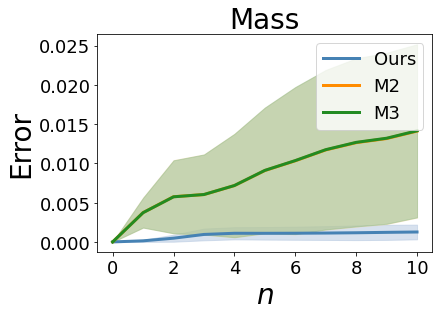

In [25]:
t_axis = np.arange(0, traj_len_pred + 1, 1)

plt.title("Mass", fontsize=28)
plt.plot(mass_mean_pk, label="Ours", color=pk_curve, linewidth=3)
plt.fill_between(
    t_axis, np.maximum(mass_mean_minus_pk, 0), mass_mean_plus_pk, color=pk_shadow, alpha=0.5
)

plt.plot(mass_mean_linear, label="M2", color=linear_curve, linewidth=3)
plt.fill_between(
    t_axis,
    np.maximum(mass_mean_minus_linear, 0),
    mass_mean_plus_linear,
    color=linear_shadow,
    alpha=0.5,
)

plt.plot(mass_mean_bilinear, label="M3", color=bilinear_curve, linewidth=3)
plt.fill_between(
    t_axis,
    np.maximum(mass_mean_minus_bilinear, 0),
    mass_mean_plus_bilinear,
    color=bilinear_shadow,
    alpha=0.5,
)

plt.xlabel(r"$n$", fontsize=28)
plt.ylabel("Error", fontsize=28)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)

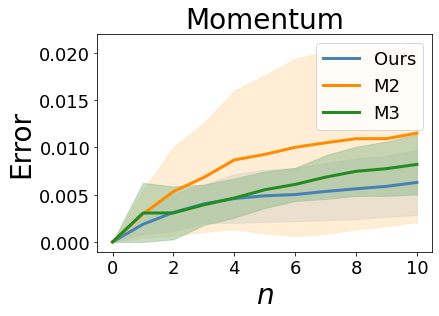

In [26]:
t_axis = np.arange(0, traj_len_pred + 1, 1)

plt.title("Momentum", fontsize=28)
plt.plot(momentum_mean_pk, label="Ours", color=pk_curve, linewidth=3)
plt.fill_between(
    t_axis,
    np.maximum(momentum_mean_minus_pk, 0),
    momentum_mean_plus_pk,
    color=pk_shadow,
    alpha=0.5,
)

plt.plot(momentum_mean_linear, label="M2", color=linear_curve, linewidth=3)
plt.fill_between(
    t_axis,
    np.maximum(momentum_mean_minus_linear, 0),
    momentum_mean_plus_linear,
    color=linear_shadow,
    alpha=0.5,
)

plt.plot(momentum_mean_bilinear, label="M3", color=bilinear_curve, linewidth=3)
plt.fill_between(
    t_axis,
    np.maximum(momentum_mean_minus_bilinear, 0),
    momentum_mean_plus_bilinear,
    color=bilinear_shadow,
    alpha=0.5,
)

plt.xlabel(r"$n$", fontsize=28)
plt.ylabel("Error", fontsize=28)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)

# Tracking problem

In [27]:
from scipy.optimize import minimize

In [28]:
# Testing reference
y0_track = np.zeros(shape=(Nx,)) + 0.2

In [29]:
T

0.01

In [30]:
Tsim_track = 10

traj_len_track = int(Tsim_track / T)

### Set piece-wise reference
soln_ref = np.zeros(shape=(traj_len_track, target_dim)) + 0.3

for i in range(soln_ref.shape[0]):
    if i > traj_len_track / 2:
        soln_ref[i, :] = 0.5

In [140]:
# Tsim_track = 0.2

# traj_len_track = int(Tsim_track / T)

# ### Set piece-wise reference
# soln_ref = np.zeros(shape=(traj_len_track, target_dim)) + 0.3

# # for i in range(soln_ref.shape[0]):
# #     if i > traj_len_track / 2:
# #         soln_ref[i, :] = 0.5

In [31]:
mass_ref = dx * tf.reshape(tf.math.reduce_sum(soln_ref, axis=-1), shape=(-1, 1))
momentum_ref = dx * tf.reshape(tf.math.reduce_sum(tf.square(soln_ref), axis=-1), shape=(-1, 1))

In [32]:
def mpc_loss_pk(param, tau, ref_list, y0, B, lambda_param):
    param = tf.reshape(param, shape=(int(param.shape[0] / param_dim), 1, param_dim))
    loss_list = []
    y0 = y0.reshape(1, -1)
    psi_x = dic_pk(y0)

    for i in range(tau):
        psi_x = model_K_u_pred_pk([param[i], psi_x])
        obs_next = psi_x @ B
        loss_curr = tf.square(tf.norm(ref_list[i] - obs_next))
        loss_list.append(loss_curr)

    ref_loss = tf.reduce_sum(loss_list)
    param_loss = lambda_param * tf.reduce_sum(tf.square(tf.norm(param, axis=-1)))

    loss = ref_loss + param_loss

    return loss


def mpc_loss_linear(param, tau, ref_list, y0, B, lambda_param):
    param = tf.reshape(param, shape=(int(param.shape[0] / param_dim), 1, param_dim))
    loss_list = []
    y0 = y0.reshape(1, -1)
    psi_y = solver_linear.dic.call(y0)

    for i in range(tau):
        psi_y = solver_linear.model_K_u_pred_linear.get_layer("Layer_A")(psi_y) + solver_linear.model_K_u_pred_linear.get_layer(
            "Layer_B"
        )(param[i])
        obs = psi_y @ B
        loss_curr = tf.square(tf.norm(ref_list[i] - obs))
        loss_list.append(loss_curr)

    ref_loss = tf.reduce_sum(loss_list)
    param_loss = lambda_param * tf.reduce_sum(tf.square(tf.norm(param, axis=-1)))

    loss = ref_loss + param_loss

    return loss


def mpc_loss_bilinear(param, tau, ref_list, y0, B, lambda_param):
    param = tf.reshape(param, shape=(int(param.shape[0] / param_dim), 1, param_dim))
    loss_list = []
    y0 = y0.reshape(1, -1)
    psi_y = solver_bilinear.dic.call(y0)

    for i in range(tau):

        u_psiy = tf.einsum("ij,ik->kij", psi_y, param[i])
        u_psiy_list = []
        for curr in u_psiy:
            u_psiy_list.append(curr)
        u_psiy_list = tf.concat(u_psiy_list, axis=-1)

        psi_y = solver_bilinear.model_K_u_pred_bilinear.get_layer("Layer_A")(
            psi_y
        ) + solver_bilinear.model_K_u_pred_bilinear.get_layer("Layer_B")(u_psiy_list)
        obs = psi_y @ B
        loss_curr = tf.square(tf.norm(ref_list[i] - obs))
        loss_list.append(loss_curr)

    ref_loss = tf.reduce_sum(loss_list)
    param_loss = lambda_param * tf.reduce_sum(tf.square(tf.norm(param, axis=-1)))

    loss = ref_loss + param_loss

    return loss

In [33]:
import time

In [144]:
# def KoopmanMPC(y0, tau, traj_len, soln_ref, kdv_solver, B, loss, lambda_param):

#     bounds = []
#     for i in range(tau * param_dim):
#         bounds.append((-1, 1))

#     y0_mpc_loop_list = [y0]
#     opt_control_list = []

#     results_list = []

#     t_list = []

#     # Wrap the loop with tqdm for a progress bar
#     for current_time in tqdm(range(traj_len - tau - 1), desc="Processing time steps"):

#         param_init = (
#             np.random.uniform(low=0, high=1, size=(tau * param_dim,)) * (umax - umin) + umin
#         )

#         t1 = time.time()
#         results = minimize(
#             loss,
#             x0=param_init,
#             args=(
#                 tau,
#                 soln_ref[current_time + 1 : current_time + 1 + tau, :],
#                 y0_mpc_loop_list[-1],
#                 B,
#                 lambda_param,
#             ),
#             bounds=bounds,
#             method='L-BFGS-B'
#         )

#         t2 = time.time()

#         results_list.append(results)

#         param = results.x.reshape(tau, param_dim)[0]
#         soln_next = kdv_solver(y0_mpc_loop_list[-1], T, param)
#         t3 = time.time()

#         y_next = soln_next.y.T[-1]
#         y0_mpc_loop_list.append(y_next)
#         opt_control_list.append(param)

#         print("*** current time ***", current_time)
#         print("optimize time: ", t2-t1)
#         print("compute kdv time: ", t3-t2)

#         t_list.append(t2-t1)

#     print("t mean: ", np.mean(t_list))

#     current_time = current_time + 1

#     param_init = np.random.uniform(low=0, high=1, size=(tau * param_dim,)) * (umax - umin) + umin

#     results = minimize(
#         loss,
#         x0=param_init,
#         args=(
#             tau,
#             soln_ref[current_time + 1 : current_time + 1 + tau, :],
#             y0_mpc_loop_list[-1],
#             B,
#             lambda_param,
#         ),
#         bounds=bounds,
#     )
#     results_list.append(results)

#     param = results.x.reshape(tau, param_dim)
#     for param_curr in param:
#         soln_next = kdv_solver(y0_mpc_loop_list[-1], T, param_curr)
#         y_next = soln_next.y.T[-1]
#         y0_mpc_loop_list.append(y_next)
#         opt_control_list.append(param_curr)

#     opt_control_list = np.asarray(opt_control_list)
#     y0_mpc_loop_list = np.asarray(y0_mpc_loop_list)

#     return opt_control_list, y0_mpc_loop_list, results_list

In [34]:
def KoopmanMPC(y0, tau, traj_len, soln_ref, kdv_solver, B, loss, lambda_param):

    bounds = []
    for i in range(tau * param_dim):
        bounds.append((-1, 1))

    y0_mpc_loop_list = [y0]
    opt_control_list = []

    results_list = []

    t_list = []

    param_init = (
            np.random.uniform(low=0, high=1, size=(tau * param_dim,)) * (umax - umin) + umin
        )

    # Wrap the loop with tqdm for a progress bar
    for current_time in tqdm(range(traj_len - tau - 1), desc="Processing time steps"):

        t1 = time.time()
        results = minimize(
            loss,
            x0=param_init,
            args=(
                tau,
                soln_ref[current_time + 1 : current_time + 1 + tau, :],
                y0_mpc_loop_list[-1],
                B,
                lambda_param,
            ),
            bounds=bounds,
            method='L-BFGS-B'
        )

        t2 = time.time()

        results_list.append(results)

        param = results.x.reshape(tau, param_dim)[0]
        param_init = results.x.reshape((tau * param_dim,))
        soln_next = kdv_solver(y0_mpc_loop_list[-1], T, param)

        y_next = soln_next.y.T[-1]
        y0_mpc_loop_list.append(y_next)
        opt_control_list.append(param)

        print("*** current time ***", current_time)
        print("optimize time: ", t2-t1)

        t_list.append(t2-t1)

    print("t mean: ", np.mean(t_list))

    current_time = current_time + 1

    # param_init = np.random.uniform(low=0, high=1, size=(tau * param_dim,)) * (umax - umin) + umin

    results = minimize(
        loss,
        x0=param_init,
        args=(
            tau,
            soln_ref[current_time + 1 : current_time + 1 + tau, :],
            y0_mpc_loop_list[-1],
            B,
            lambda_param,
        ),
        bounds=bounds,
    )
    results_list.append(results)

    param = results.x.reshape(tau, param_dim)
    for param_curr in param:
        soln_next = kdv_solver(y0_mpc_loop_list[-1], T, param_curr)
        y_next = soln_next.y.T[-1]
        y0_mpc_loop_list.append(y_next)
        opt_control_list.append(param_curr)

    opt_control_list = np.asarray(opt_control_list)
    y0_mpc_loop_list = np.asarray(y0_mpc_loop_list)

    return opt_control_list, y0_mpc_loop_list, results_list, t_list

In [35]:
B_mass = dic_pk.generate_B_mass(mass_ref)
B_momentum = dic_pk.generate_B_momentum(momentum_ref)

### Track mass

In [38]:
tau = 10  # time horizon
# lambda_param = 0.005
# lambda_param = 0

In [39]:
pk_opt_control_mass_0, pk_kdv_opt_mass_soln_0, pk_mass_opt_results_0, pk_time_list_0 = KoopmanMPC(
    y0=y0_track,
    tau=tau,
    traj_len=traj_len_track,
    soln_ref=mass_ref,
    kdv_solver=kdv.kdv_solution,
    B=B_mass,
    loss=mpc_loss_pk,
    lambda_param=0,
)

Processing time steps:   0%|          | 0/989 [00:00<?, ?it/s]

Processing time steps:   0%|          | 1/989 [02:23<39:18:28, 143.23s/it]

*** current time *** 0
optimize time:  142.97617983818054


Processing time steps:   0%|          | 1/989 [02:39<43:46:19, 159.49s/it]


KeyboardInterrupt: 

In [154]:
linear_opt_control_mass_0, linear_kdv_opt_mass_soln_0, linear_mass_results_0, linear_time_list_0 = KoopmanMPC(
    y0=y0_track,
    tau=tau,
    traj_len=traj_len_track,
    soln_ref=mass_ref,
    kdv_solver=kdv.kdv_solution,
    B=B_mass,
    loss=mpc_loss_linear,
    lambda_param=0,
)

Processing time steps:   0%|          | 1/989 [00:01<31:17,  1.90s/it]

*** current time *** 0
optimize time:  1.899444818496704


Processing time steps:   0%|          | 2/989 [00:02<17:34,  1.07s/it]

*** current time *** 1
optimize time:  0.4828667640686035


Processing time steps:   0%|          | 3/989 [00:02<13:06,  1.25it/s]

*** current time *** 2
optimize time:  0.4732232093811035


Processing time steps:   0%|          | 4/989 [00:03<11:00,  1.49it/s]

*** current time *** 3
optimize time:  0.4751913547515869


Processing time steps:   1%|          | 5/989 [00:03<09:59,  1.64it/s]

*** current time *** 4
optimize time:  0.49816322326660156


Processing time steps:   1%|          | 6/989 [00:04<09:15,  1.77it/s]

*** current time *** 5
optimize time:  0.47675275802612305


Processing time steps:   1%|          | 7/989 [00:04<08:46,  1.87it/s]

*** current time *** 6
optimize time:  0.4742093086242676


Processing time steps:   1%|          | 8/989 [00:05<08:26,  1.93it/s]

*** current time *** 7
optimize time:  0.47336244583129883


Processing time steps:   1%|          | 9/989 [00:05<08:15,  1.98it/s]

*** current time *** 8
optimize time:  0.47901177406311035


Processing time steps:   1%|          | 10/989 [00:06<08:09,  2.00it/s]

*** current time *** 9
optimize time:  0.4851391315460205


Processing time steps:   1%|          | 11/989 [00:06<08:01,  2.03it/s]

*** current time *** 10
optimize time:  0.4742767810821533


Processing time steps:   1%|          | 12/989 [00:07<07:56,  2.05it/s]

*** current time *** 11
optimize time:  0.47296833992004395


Processing time steps:   1%|▏         | 13/989 [00:07<07:52,  2.07it/s]

*** current time *** 12
optimize time:  0.47328710556030273


Processing time steps:   1%|▏         | 14/989 [00:08<07:49,  2.08it/s]

*** current time *** 13
optimize time:  0.47378063201904297


Processing time steps:   2%|▏         | 15/989 [00:08<07:47,  2.09it/s]

*** current time *** 14
optimize time:  0.4731166362762451


Processing time steps:   2%|▏         | 16/989 [00:09<07:45,  2.09it/s]

*** current time *** 15
optimize time:  0.47351956367492676


Processing time steps:   2%|▏         | 17/989 [00:09<07:45,  2.09it/s]

*** current time *** 16
optimize time:  0.4762570858001709


Processing time steps:   2%|▏         | 18/989 [00:10<07:44,  2.09it/s]

*** current time *** 17
optimize time:  0.47553420066833496


Processing time steps:   2%|▏         | 19/989 [00:10<07:43,  2.09it/s]

*** current time *** 18
optimize time:  0.4740638732910156


Processing time steps:   2%|▏         | 20/989 [00:10<07:42,  2.10it/s]

*** current time *** 19
optimize time:  0.473071813583374


Processing time steps:   2%|▏         | 21/989 [00:11<07:42,  2.09it/s]

*** current time *** 20
optimize time:  0.4769315719604492


Processing time steps:   2%|▏         | 22/989 [00:11<07:40,  2.10it/s]

*** current time *** 21
optimize time:  0.47234487533569336


Processing time steps:   2%|▏         | 23/989 [00:12<07:39,  2.10it/s]

*** current time *** 22
optimize time:  0.4731016159057617


Processing time steps:   2%|▏         | 24/989 [00:12<07:41,  2.09it/s]

*** current time *** 23
optimize time:  0.4821786880493164


Processing time steps:   3%|▎         | 25/989 [00:13<07:39,  2.10it/s]

*** current time *** 24
optimize time:  0.4702889919281006


Processing time steps:   3%|▎         | 26/989 [00:13<07:38,  2.10it/s]

*** current time *** 25
optimize time:  0.47258996963500977


Processing time steps:   3%|▎         | 27/989 [00:14<07:38,  2.10it/s]

*** current time *** 26
optimize time:  0.4757974147796631


Processing time steps:   3%|▎         | 28/989 [00:14<07:37,  2.10it/s]

*** current time *** 27
optimize time:  0.47406673431396484


Processing time steps:   3%|▎         | 29/989 [00:15<07:37,  2.10it/s]

*** current time *** 28
optimize time:  0.47521400451660156


Processing time steps:   3%|▎         | 30/989 [00:15<07:37,  2.10it/s]

*** current time *** 29
optimize time:  0.4741959571838379


Processing time steps:   3%|▎         | 31/989 [00:16<07:37,  2.09it/s]

*** current time *** 30
optimize time:  0.47815895080566406


Processing time steps:   3%|▎         | 32/989 [00:16<07:38,  2.09it/s]

*** current time *** 31
optimize time:  0.4786710739135742


Processing time steps:   3%|▎         | 33/989 [00:17<07:37,  2.09it/s]

*** current time *** 32
optimize time:  0.4749321937561035


Processing time steps:   3%|▎         | 34/989 [00:17<07:36,  2.09it/s]

*** current time *** 33
optimize time:  0.47440433502197266


Processing time steps:   4%|▎         | 35/989 [00:18<07:36,  2.09it/s]

*** current time *** 34
optimize time:  0.47731614112854004


Processing time steps:   4%|▎         | 36/989 [00:18<07:33,  2.10it/s]

*** current time *** 35
optimize time:  0.46721553802490234


Processing time steps:   4%|▎         | 37/989 [00:19<07:30,  2.12it/s]

*** current time *** 36
optimize time:  0.46393251419067383


Processing time steps:   4%|▍         | 38/989 [00:19<07:28,  2.12it/s]

*** current time *** 37
optimize time:  0.4659585952758789


Processing time steps:   4%|▍         | 39/989 [00:20<07:27,  2.12it/s]

*** current time *** 38
optimize time:  0.4683878421783447


Processing time steps:   4%|▍         | 40/989 [00:20<07:26,  2.13it/s]

*** current time *** 39
optimize time:  0.46637988090515137


Processing time steps:   4%|▍         | 41/989 [00:20<07:25,  2.13it/s]

*** current time *** 40
optimize time:  0.46698546409606934


Processing time steps:   4%|▍         | 42/989 [00:21<07:30,  2.10it/s]

*** current time *** 41
optimize time:  0.4866507053375244


Processing time steps:   4%|▍         | 43/989 [00:21<07:27,  2.11it/s]

*** current time *** 42
optimize time:  0.4667634963989258


Processing time steps:   4%|▍         | 44/989 [00:22<07:22,  2.13it/s]

*** current time *** 43
optimize time:  0.45456790924072266


Processing time steps:   5%|▍         | 45/989 [00:22<07:35,  2.07it/s]

*** current time *** 44
optimize time:  0.5118739604949951


Processing time steps:   5%|▍         | 46/989 [00:23<07:31,  2.09it/s]

*** current time *** 45
optimize time:  0.4696016311645508


Processing time steps:   5%|▍         | 47/989 [00:23<07:26,  2.11it/s]

*** current time *** 46
optimize time:  0.46131181716918945


Processing time steps:   5%|▍         | 48/989 [00:24<07:21,  2.13it/s]

*** current time *** 47
optimize time:  0.455580472946167


Processing time steps:   5%|▍         | 49/989 [00:24<07:17,  2.15it/s]

*** current time *** 48
optimize time:  0.4548220634460449


Processing time steps:   5%|▌         | 50/989 [00:25<07:27,  2.10it/s]

*** current time *** 49
optimize time:  0.5000231266021729


Processing time steps:   5%|▌         | 51/989 [00:25<07:21,  2.12it/s]

*** current time *** 50
optimize time:  0.4547004699707031


Processing time steps:   5%|▌         | 52/989 [00:26<07:18,  2.14it/s]

*** current time *** 51
optimize time:  0.45831918716430664


Processing time steps:   5%|▌         | 53/989 [00:26<07:14,  2.15it/s]

*** current time *** 52
optimize time:  0.45525169372558594


Processing time steps:   5%|▌         | 54/989 [00:27<07:12,  2.16it/s]

*** current time *** 53
optimize time:  0.4548313617706299


Processing time steps:   6%|▌         | 55/989 [00:27<07:10,  2.17it/s]

*** current time *** 54
optimize time:  0.45740818977355957


Processing time steps:   6%|▌         | 56/989 [00:28<07:09,  2.17it/s]

*** current time *** 55
optimize time:  0.456557035446167


Processing time steps:   6%|▌         | 57/989 [00:28<07:09,  2.17it/s]

*** current time *** 56
optimize time:  0.45795607566833496


Processing time steps:   6%|▌         | 58/989 [00:28<07:08,  2.17it/s]

*** current time *** 57
optimize time:  0.45636439323425293


Processing time steps:   6%|▌         | 59/989 [00:29<07:06,  2.18it/s]

*** current time *** 58
optimize time:  0.45473718643188477


Processing time steps:   6%|▌         | 60/989 [00:29<07:07,  2.17it/s]

*** current time *** 59
optimize time:  0.461108922958374


Processing time steps:   6%|▌         | 61/989 [00:30<07:06,  2.18it/s]

*** current time *** 60
optimize time:  0.45638442039489746


Processing time steps:   6%|▋         | 62/989 [00:30<07:05,  2.18it/s]

*** current time *** 61
optimize time:  0.45468831062316895


Processing time steps:   6%|▋         | 63/989 [00:31<07:10,  2.15it/s]

*** current time *** 62
optimize time:  0.47652506828308105


Processing time steps:   6%|▋         | 64/989 [00:31<07:07,  2.16it/s]

*** current time *** 63
optimize time:  0.4543147087097168


Processing time steps:   7%|▋         | 65/989 [00:32<07:05,  2.17it/s]

*** current time *** 64
optimize time:  0.4540560245513916


Processing time steps:   7%|▋         | 66/989 [00:32<07:03,  2.18it/s]

*** current time *** 65
optimize time:  0.4540562629699707


Processing time steps:   7%|▋         | 67/989 [00:33<07:04,  2.17it/s]

*** current time *** 66
optimize time:  0.4601709842681885


Processing time steps:   7%|▋         | 68/989 [00:33<07:06,  2.16it/s]

*** current time *** 67
optimize time:  0.4660062789916992


Processing time steps:   7%|▋         | 69/989 [00:34<07:06,  2.16it/s]

*** current time *** 68
optimize time:  0.4643368721008301


Processing time steps:   7%|▋         | 70/989 [00:34<07:06,  2.16it/s]

*** current time *** 69
optimize time:  0.46219420433044434


Processing time steps:   7%|▋         | 71/989 [00:34<07:07,  2.15it/s]

*** current time *** 70
optimize time:  0.4686591625213623


Processing time steps:   7%|▋         | 72/989 [00:35<07:06,  2.15it/s]

*** current time *** 71
optimize time:  0.4615623950958252


Processing time steps:   7%|▋         | 73/989 [00:35<07:11,  2.13it/s]

*** current time *** 72
optimize time:  0.4806191921234131


Processing time steps:   7%|▋         | 74/989 [00:36<07:09,  2.13it/s]

*** current time *** 73
optimize time:  0.4646892547607422


Processing time steps:   8%|▊         | 75/989 [00:36<07:07,  2.14it/s]

*** current time *** 74
optimize time:  0.4620964527130127


Processing time steps:   8%|▊         | 76/989 [00:37<07:10,  2.12it/s]

*** current time *** 75
optimize time:  0.4786357879638672


Processing time steps:   8%|▊         | 77/989 [00:37<07:13,  2.11it/s]

*** current time *** 76
optimize time:  0.48073840141296387


Processing time steps:   8%|▊         | 78/989 [00:38<07:09,  2.12it/s]

*** current time *** 77
optimize time:  0.4617886543273926


Processing time steps:   8%|▊         | 79/989 [00:38<07:07,  2.13it/s]

*** current time *** 78
optimize time:  0.4630296230316162


Processing time steps:   8%|▊         | 80/989 [00:39<07:06,  2.13it/s]

*** current time *** 79
optimize time:  0.46579694747924805


Processing time steps:   8%|▊         | 81/989 [00:39<07:05,  2.13it/s]

*** current time *** 80
optimize time:  0.46675872802734375


Processing time steps:   8%|▊         | 82/989 [00:40<07:06,  2.13it/s]

*** current time *** 81
optimize time:  0.4711751937866211


Processing time steps:   8%|▊         | 83/989 [00:40<07:04,  2.13it/s]

*** current time *** 82
optimize time:  0.46196532249450684


Processing time steps:   8%|▊         | 84/989 [00:41<07:03,  2.14it/s]

*** current time *** 83
optimize time:  0.46497321128845215


Processing time steps:   9%|▊         | 85/989 [00:41<07:02,  2.14it/s]

*** current time *** 84
optimize time:  0.4622058868408203


Processing time steps:   9%|▊         | 86/989 [00:42<07:07,  2.11it/s]

*** current time *** 85
optimize time:  0.4875614643096924


Processing time steps:   9%|▉         | 87/989 [00:42<07:05,  2.12it/s]

*** current time *** 86
optimize time:  0.4630000591278076


Processing time steps:   9%|▉         | 88/989 [00:42<07:02,  2.13it/s]

*** current time *** 87
optimize time:  0.4624364376068115


Processing time steps:   9%|▉         | 89/989 [00:43<07:24,  2.02it/s]

*** current time *** 88
optimize time:  0.5506129264831543


Processing time steps:   9%|▉         | 90/989 [00:43<07:26,  2.01it/s]

*** current time *** 89
optimize time:  0.49974989891052246


Processing time steps:   9%|▉         | 91/989 [00:44<07:18,  2.05it/s]

*** current time *** 90
optimize time:  0.4673922061920166


Processing time steps:   9%|▉         | 92/989 [00:44<07:11,  2.08it/s]

*** current time *** 91
optimize time:  0.4631998538970947


Processing time steps:   9%|▉         | 93/989 [00:45<07:07,  2.09it/s]

*** current time *** 92
optimize time:  0.4657602310180664


Processing time steps:  10%|▉         | 94/989 [00:45<07:07,  2.09it/s]

*** current time *** 93
optimize time:  0.47603821754455566


Processing time steps:  10%|▉         | 95/989 [00:46<07:13,  2.06it/s]

*** current time *** 94
optimize time:  0.5004777908325195


Processing time steps:  10%|▉         | 96/989 [00:46<07:07,  2.09it/s]

*** current time *** 95
optimize time:  0.46250486373901367


Processing time steps:  10%|▉         | 97/989 [00:47<07:03,  2.11it/s]

*** current time *** 96
optimize time:  0.4625122547149658


Processing time steps:  10%|▉         | 98/989 [00:47<07:00,  2.12it/s]

*** current time *** 97
optimize time:  0.46375346183776855


Processing time steps:  10%|█         | 99/989 [00:48<06:58,  2.13it/s]

*** current time *** 98
optimize time:  0.4645345211029053


Processing time steps:  10%|█         | 100/989 [00:48<07:00,  2.12it/s]

*** current time *** 99
optimize time:  0.4753410816192627


Processing time steps:  10%|█         | 101/989 [00:49<06:57,  2.13it/s]

*** current time *** 100
optimize time:  0.46349668502807617


Processing time steps:  10%|█         | 102/989 [00:49<06:56,  2.13it/s]

*** current time *** 101
optimize time:  0.4668903350830078


Processing time steps:  10%|█         | 103/989 [00:50<07:00,  2.11it/s]

*** current time *** 102
optimize time:  0.48360133171081543


Processing time steps:  11%|█         | 104/989 [00:50<07:20,  2.01it/s]

*** current time *** 103
optimize time:  0.549293041229248


Processing time steps:  11%|█         | 105/989 [00:51<07:12,  2.04it/s]

*** current time *** 104
optimize time:  0.46610355377197266


Processing time steps:  11%|█         | 106/989 [00:51<07:06,  2.07it/s]

*** current time *** 105
optimize time:  0.4661402702331543


Processing time steps:  11%|█         | 107/989 [00:52<07:01,  2.09it/s]

*** current time *** 106
optimize time:  0.4636263847351074


Processing time steps:  11%|█         | 108/989 [00:52<06:58,  2.10it/s]

*** current time *** 107
optimize time:  0.467012882232666


Processing time steps:  11%|█         | 109/989 [00:53<06:56,  2.11it/s]

*** current time *** 108
optimize time:  0.4664270877838135


Processing time steps:  11%|█         | 110/989 [00:53<06:55,  2.12it/s]

*** current time *** 109
optimize time:  0.46910834312438965


Processing time steps:  11%|█         | 111/989 [00:53<06:56,  2.11it/s]

*** current time *** 110
optimize time:  0.4773578643798828


Processing time steps:  11%|█▏        | 112/989 [00:54<06:58,  2.09it/s]

*** current time *** 111
optimize time:  0.4818885326385498


Processing time steps:  11%|█▏        | 113/989 [00:54<07:08,  2.04it/s]

*** current time *** 112
optimize time:  0.5136675834655762


Processing time steps:  12%|█▏        | 114/989 [00:55<07:08,  2.04it/s]

*** current time *** 113
optimize time:  0.48738884925842285


Processing time steps:  12%|█▏        | 115/989 [00:56<07:20,  1.98it/s]

*** current time *** 114
optimize time:  0.537053108215332


Processing time steps:  12%|█▏        | 116/989 [00:56<07:11,  2.03it/s]

*** current time *** 115
optimize time:  0.4673306941986084


Processing time steps:  12%|█▏        | 117/989 [00:56<07:04,  2.06it/s]

*** current time *** 116
optimize time:  0.4672396183013916


Processing time steps:  12%|█▏        | 118/989 [00:57<06:59,  2.08it/s]

*** current time *** 117
optimize time:  0.46766185760498047


Processing time steps:  12%|█▏        | 119/989 [00:57<06:54,  2.10it/s]

*** current time *** 118
optimize time:  0.4634971618652344


Processing time steps:  12%|█▏        | 120/989 [00:58<06:51,  2.11it/s]

*** current time *** 119
optimize time:  0.46498680114746094


Processing time steps:  12%|█▏        | 121/989 [00:58<06:51,  2.11it/s]

*** current time *** 120
optimize time:  0.4731569290161133


Processing time steps:  12%|█▏        | 122/989 [00:59<06:48,  2.12it/s]

*** current time *** 121
optimize time:  0.4631614685058594


Processing time steps:  12%|█▏        | 123/989 [00:59<06:47,  2.13it/s]

*** current time *** 122
optimize time:  0.46469593048095703


Processing time steps:  13%|█▎        | 124/989 [01:00<06:46,  2.13it/s]

*** current time *** 123
optimize time:  0.4680488109588623


Processing time steps:  13%|█▎        | 125/989 [01:00<06:44,  2.13it/s]

*** current time *** 124
optimize time:  0.46326112747192383


Processing time steps:  13%|█▎        | 126/989 [01:01<06:41,  2.15it/s]

*** current time *** 125
optimize time:  0.4559004306793213


Processing time steps:  13%|█▎        | 127/989 [01:01<06:39,  2.16it/s]

*** current time *** 126
optimize time:  0.4566311836242676


Processing time steps:  13%|█▎        | 128/989 [01:02<06:37,  2.17it/s]

*** current time *** 127
optimize time:  0.4553699493408203


Processing time steps:  13%|█▎        | 129/989 [01:02<06:36,  2.17it/s]

*** current time *** 128
optimize time:  0.4559204578399658


Processing time steps:  13%|█▎        | 130/989 [01:02<06:34,  2.18it/s]

*** current time *** 129
optimize time:  0.4554629325866699


Processing time steps:  13%|█▎        | 131/989 [01:03<06:33,  2.18it/s]

*** current time *** 130
optimize time:  0.4548490047454834


Processing time steps:  13%|█▎        | 132/989 [01:03<06:34,  2.17it/s]

*** current time *** 131
optimize time:  0.4635124206542969


Processing time steps:  13%|█▎        | 133/989 [01:04<06:42,  2.13it/s]

*** current time *** 132
optimize time:  0.48929834365844727


Processing time steps:  14%|█▎        | 134/989 [01:04<06:38,  2.15it/s]

*** current time *** 133
optimize time:  0.45441269874572754


Processing time steps:  14%|█▎        | 135/989 [01:05<06:35,  2.16it/s]

*** current time *** 134
optimize time:  0.4547233581542969


Processing time steps:  14%|█▍        | 136/989 [01:05<06:33,  2.17it/s]

*** current time *** 135
optimize time:  0.45439815521240234


Processing time steps:  14%|█▍        | 137/989 [01:06<06:32,  2.17it/s]

*** current time *** 136
optimize time:  0.4564533233642578


Processing time steps:  14%|█▍        | 138/989 [01:06<06:32,  2.17it/s]

*** current time *** 137
optimize time:  0.4592766761779785


Processing time steps:  14%|█▍        | 139/989 [01:07<06:32,  2.17it/s]

*** current time *** 138
optimize time:  0.46106791496276855


Processing time steps:  14%|█▍        | 140/989 [01:07<06:31,  2.17it/s]

*** current time *** 139
optimize time:  0.45646071434020996


Processing time steps:  14%|█▍        | 141/989 [01:08<06:29,  2.18it/s]

*** current time *** 140
optimize time:  0.45517730712890625


Processing time steps:  14%|█▍        | 142/989 [01:08<06:28,  2.18it/s]

*** current time *** 141
optimize time:  0.455596923828125


Processing time steps:  14%|█▍        | 143/989 [01:08<06:27,  2.18it/s]

*** current time *** 142
optimize time:  0.45531558990478516


Processing time steps:  15%|█▍        | 144/989 [01:09<06:26,  2.19it/s]

*** current time *** 143
optimize time:  0.4531681537628174


Processing time steps:  15%|█▍        | 145/989 [01:09<06:26,  2.18it/s]

*** current time *** 144
optimize time:  0.4586033821105957


Processing time steps:  15%|█▍        | 146/989 [01:10<06:26,  2.18it/s]

*** current time *** 145
optimize time:  0.45662927627563477


Processing time steps:  15%|█▍        | 147/989 [01:10<06:25,  2.18it/s]

*** current time *** 146
optimize time:  0.45525479316711426


Processing time steps:  15%|█▍        | 148/989 [01:11<06:24,  2.19it/s]

*** current time *** 147
optimize time:  0.4544095993041992


Processing time steps:  15%|█▌        | 149/989 [01:11<06:24,  2.18it/s]

*** current time *** 148
optimize time:  0.4573554992675781


Processing time steps:  15%|█▌        | 150/989 [01:12<06:26,  2.17it/s]

*** current time *** 149
optimize time:  0.4623560905456543


Processing time steps:  15%|█▌        | 151/989 [01:12<06:26,  2.17it/s]

*** current time *** 150
optimize time:  0.463604211807251


Processing time steps:  15%|█▌        | 152/989 [01:13<06:27,  2.16it/s]

*** current time *** 151
optimize time:  0.46360254287719727


Processing time steps:  15%|█▌        | 153/989 [01:13<06:28,  2.15it/s]

*** current time *** 152
optimize time:  0.4653928279876709


Processing time steps:  16%|█▌        | 154/989 [01:14<06:30,  2.14it/s]

*** current time *** 153
optimize time:  0.47255897521972656


Processing time steps:  16%|█▌        | 155/989 [01:14<06:31,  2.13it/s]

*** current time *** 154
optimize time:  0.4711418151855469


Processing time steps:  16%|█▌        | 156/989 [01:15<06:31,  2.13it/s]

*** current time *** 155
optimize time:  0.4689466953277588


Processing time steps:  16%|█▌        | 157/989 [01:15<06:31,  2.13it/s]

*** current time *** 156
optimize time:  0.46999526023864746


Processing time steps:  16%|█▌        | 158/989 [01:15<06:31,  2.12it/s]

*** current time *** 157
optimize time:  0.4696376323699951


Processing time steps:  16%|█▌        | 159/989 [01:16<06:31,  2.12it/s]

*** current time *** 158
optimize time:  0.47193145751953125


Processing time steps:  16%|█▌        | 160/989 [01:16<06:31,  2.12it/s]

*** current time *** 159
optimize time:  0.4705185890197754


Processing time steps:  16%|█▋        | 161/989 [01:17<06:29,  2.13it/s]

*** current time *** 160
optimize time:  0.4644956588745117


Processing time steps:  16%|█▋        | 162/989 [01:17<06:30,  2.12it/s]

*** current time *** 161
optimize time:  0.4762589931488037


Processing time steps:  16%|█▋        | 163/989 [01:18<06:29,  2.12it/s]

*** current time *** 162
optimize time:  0.4684474468231201


Processing time steps:  17%|█▋        | 164/989 [01:18<06:27,  2.13it/s]

*** current time *** 163
optimize time:  0.4631497859954834


Processing time steps:  17%|█▋        | 165/989 [01:19<06:25,  2.14it/s]

*** current time *** 164
optimize time:  0.4597358703613281


Processing time steps:  17%|█▋        | 166/989 [01:19<06:23,  2.14it/s]

*** current time *** 165
optimize time:  0.461761474609375


Processing time steps:  17%|█▋        | 167/989 [01:20<06:25,  2.13it/s]

*** current time *** 166
optimize time:  0.47162437438964844


Processing time steps:  17%|█▋        | 168/989 [01:20<06:23,  2.14it/s]

*** current time *** 167
optimize time:  0.46168947219848633


Processing time steps:  17%|█▋        | 169/989 [01:21<06:22,  2.14it/s]

*** current time *** 168
optimize time:  0.4643247127532959


Processing time steps:  17%|█▋        | 170/989 [01:21<06:23,  2.14it/s]

*** current time *** 169
optimize time:  0.4679129123687744


Processing time steps:  17%|█▋        | 171/989 [01:22<06:22,  2.14it/s]

*** current time *** 170
optimize time:  0.4649837017059326


Processing time steps:  17%|█▋        | 172/989 [01:22<06:22,  2.14it/s]

*** current time *** 171
optimize time:  0.46637797355651855


Processing time steps:  17%|█▋        | 173/989 [01:23<06:35,  2.06it/s]

*** current time *** 172
optimize time:  0.5223817825317383


Processing time steps:  18%|█▊        | 174/989 [01:23<06:34,  2.06it/s]

*** current time *** 173
optimize time:  0.4811267852783203


Processing time steps:  18%|█▊        | 175/989 [01:23<06:30,  2.08it/s]

*** current time *** 174
optimize time:  0.4668083190917969


Processing time steps:  18%|█▊        | 176/989 [01:24<06:29,  2.08it/s]

*** current time *** 175
optimize time:  0.4771692752838135


Processing time steps:  18%|█▊        | 177/989 [01:24<06:27,  2.10it/s]

*** current time *** 176
optimize time:  0.4697530269622803


Processing time steps:  18%|█▊        | 178/989 [01:25<06:25,  2.10it/s]

*** current time *** 177
optimize time:  0.4692354202270508


Processing time steps:  18%|█▊        | 179/989 [01:25<06:42,  2.01it/s]

*** current time *** 178
optimize time:  0.5436832904815674


Processing time steps:  18%|█▊        | 180/989 [01:26<06:34,  2.05it/s]

*** current time *** 179
optimize time:  0.46651482582092285


Processing time steps:  18%|█▊        | 181/989 [01:26<06:29,  2.07it/s]

*** current time *** 180
optimize time:  0.46679258346557617


Processing time steps:  18%|█▊        | 182/989 [01:27<06:26,  2.09it/s]

*** current time *** 181
optimize time:  0.4674561023712158


Processing time steps:  19%|█▊        | 183/989 [01:27<06:23,  2.10it/s]

*** current time *** 182
optimize time:  0.467679500579834


Processing time steps:  19%|█▊        | 184/989 [01:28<06:22,  2.11it/s]

*** current time *** 183
optimize time:  0.4709651470184326


Processing time steps:  19%|█▊        | 185/989 [01:28<06:23,  2.10it/s]

*** current time *** 184
optimize time:  0.4785134792327881


Processing time steps:  19%|█▉        | 186/989 [01:29<06:21,  2.11it/s]

*** current time *** 185
optimize time:  0.46898794174194336


Processing time steps:  19%|█▉        | 187/989 [01:29<06:20,  2.11it/s]

*** current time *** 186
optimize time:  0.4713783264160156


Processing time steps:  19%|█▉        | 188/989 [01:30<06:21,  2.10it/s]

*** current time *** 187
optimize time:  0.4772927761077881


Processing time steps:  19%|█▉        | 189/989 [01:30<06:20,  2.10it/s]

*** current time *** 188
optimize time:  0.47276973724365234


Processing time steps:  19%|█▉        | 190/989 [01:31<06:19,  2.11it/s]

*** current time *** 189
optimize time:  0.4705691337585449


Processing time steps:  19%|█▉        | 191/989 [01:31<06:18,  2.11it/s]

*** current time *** 190
optimize time:  0.47179746627807617


Processing time steps:  19%|█▉        | 192/989 [01:32<06:17,  2.11it/s]

*** current time *** 191
optimize time:  0.47071218490600586


Processing time steps:  20%|█▉        | 193/989 [01:32<06:18,  2.10it/s]

*** current time *** 192
optimize time:  0.4758260250091553


Processing time steps:  20%|█▉        | 194/989 [01:33<06:17,  2.10it/s]

*** current time *** 193
optimize time:  0.47293901443481445


Processing time steps:  20%|█▉        | 195/989 [01:33<06:17,  2.10it/s]

*** current time *** 194
optimize time:  0.47356390953063965


Processing time steps:  20%|█▉        | 196/989 [01:34<06:17,  2.10it/s]

*** current time *** 195
optimize time:  0.4754188060760498


Processing time steps:  20%|█▉        | 197/989 [01:34<06:16,  2.10it/s]

*** current time *** 196
optimize time:  0.4709954261779785


Processing time steps:  20%|██        | 198/989 [01:34<06:18,  2.09it/s]

*** current time *** 197
optimize time:  0.48366665840148926


Processing time steps:  20%|██        | 199/989 [01:35<06:18,  2.09it/s]

*** current time *** 198
optimize time:  0.47864770889282227


Processing time steps:  20%|██        | 200/989 [01:35<06:17,  2.09it/s]

*** current time *** 199
optimize time:  0.4752376079559326


Processing time steps:  20%|██        | 201/989 [01:36<06:16,  2.09it/s]

*** current time *** 200
optimize time:  0.47533750534057617


Processing time steps:  20%|██        | 202/989 [01:36<06:17,  2.09it/s]

*** current time *** 201
optimize time:  0.4795081615447998


Processing time steps:  21%|██        | 203/989 [01:37<06:32,  2.00it/s]

*** current time *** 202
optimize time:  0.5426156520843506


Processing time steps:  21%|██        | 204/989 [01:37<06:26,  2.03it/s]

*** current time *** 203
optimize time:  0.4746274948120117


Processing time steps:  21%|██        | 205/989 [01:38<06:21,  2.05it/s]

*** current time *** 204
optimize time:  0.4730966091156006


Processing time steps:  21%|██        | 206/989 [01:38<06:19,  2.06it/s]

*** current time *** 205
optimize time:  0.4756736755371094


Processing time steps:  21%|██        | 207/989 [01:39<06:16,  2.08it/s]

*** current time *** 206
optimize time:  0.47072649002075195


Processing time steps:  21%|██        | 208/989 [01:39<06:11,  2.10it/s]

*** current time *** 207
optimize time:  0.46158266067504883


Processing time steps:  21%|██        | 209/989 [01:40<06:09,  2.11it/s]

*** current time *** 208
optimize time:  0.4664485454559326


Processing time steps:  21%|██        | 210/989 [01:40<06:06,  2.12it/s]

*** current time *** 209
optimize time:  0.46297168731689453


Processing time steps:  21%|██▏       | 211/989 [01:41<06:04,  2.13it/s]

*** current time *** 210
optimize time:  0.46101808547973633


Processing time steps:  21%|██▏       | 212/989 [01:41<06:03,  2.14it/s]

*** current time *** 211
optimize time:  0.46332526206970215


Processing time steps:  22%|██▏       | 213/989 [01:42<06:01,  2.14it/s]

*** current time *** 212
optimize time:  0.4611475467681885


Processing time steps:  22%|██▏       | 214/989 [01:42<06:00,  2.15it/s]

*** current time *** 213
optimize time:  0.4614384174346924


Processing time steps:  22%|██▏       | 215/989 [01:43<05:59,  2.15it/s]

*** current time *** 214
optimize time:  0.4593937397003174


Processing time steps:  22%|██▏       | 216/989 [01:43<05:58,  2.15it/s]

*** current time *** 215
optimize time:  0.4616243839263916


Processing time steps:  22%|██▏       | 217/989 [01:43<05:58,  2.15it/s]

*** current time *** 216
optimize time:  0.46178483963012695


Processing time steps:  22%|██▏       | 218/989 [01:44<05:57,  2.15it/s]

*** current time *** 217
optimize time:  0.46283960342407227


Processing time steps:  22%|██▏       | 219/989 [01:44<05:59,  2.14it/s]

*** current time *** 218
optimize time:  0.47289133071899414


Processing time steps:  22%|██▏       | 220/989 [01:45<05:58,  2.14it/s]

*** current time *** 219
optimize time:  0.4624016284942627


Processing time steps:  22%|██▏       | 221/989 [01:45<05:58,  2.14it/s]

*** current time *** 220
optimize time:  0.46347904205322266


Processing time steps:  22%|██▏       | 222/989 [01:46<05:57,  2.14it/s]

*** current time *** 221
optimize time:  0.46437859535217285


Processing time steps:  23%|██▎       | 223/989 [01:46<05:57,  2.14it/s]

*** current time *** 222
optimize time:  0.4647808074951172


Processing time steps:  23%|██▎       | 224/989 [01:47<05:56,  2.14it/s]

*** current time *** 223
optimize time:  0.463775634765625


Processing time steps:  23%|██▎       | 225/989 [01:47<05:55,  2.15it/s]

*** current time *** 224
optimize time:  0.46239733695983887


Processing time steps:  23%|██▎       | 226/989 [01:48<05:55,  2.15it/s]

*** current time *** 225
optimize time:  0.46396827697753906


Processing time steps:  23%|██▎       | 227/989 [01:48<05:54,  2.15it/s]

*** current time *** 226
optimize time:  0.46138739585876465


Processing time steps:  23%|██▎       | 228/989 [01:49<05:53,  2.15it/s]

*** current time *** 227
optimize time:  0.46175074577331543


Processing time steps:  23%|██▎       | 229/989 [01:49<05:52,  2.15it/s]

*** current time *** 228
optimize time:  0.46119260787963867


Processing time steps:  23%|██▎       | 230/989 [01:50<05:52,  2.15it/s]

*** current time *** 229
optimize time:  0.46412062644958496


Processing time steps:  23%|██▎       | 231/989 [01:50<05:52,  2.15it/s]

*** current time *** 230
optimize time:  0.46514248847961426


Processing time steps:  23%|██▎       | 232/989 [01:50<05:53,  2.14it/s]

*** current time *** 231
optimize time:  0.46930384635925293


Processing time steps:  24%|██▎       | 233/989 [01:51<05:55,  2.13it/s]

*** current time *** 232
optimize time:  0.4747953414916992


Processing time steps:  24%|██▎       | 234/989 [01:51<05:56,  2.12it/s]

*** current time *** 233
optimize time:  0.47351694107055664


Processing time steps:  24%|██▍       | 235/989 [01:52<05:57,  2.11it/s]

*** current time *** 234
optimize time:  0.47689080238342285


Processing time steps:  24%|██▍       | 236/989 [01:52<05:57,  2.11it/s]

*** current time *** 235
optimize time:  0.4752066135406494


Processing time steps:  24%|██▍       | 237/989 [01:53<05:56,  2.11it/s]

*** current time *** 236
optimize time:  0.46854639053344727


Processing time steps:  24%|██▍       | 238/989 [01:53<05:55,  2.11it/s]

*** current time *** 237
optimize time:  0.4692380428314209


Processing time steps:  24%|██▍       | 239/989 [01:54<05:54,  2.12it/s]

*** current time *** 238
optimize time:  0.4688434600830078


Processing time steps:  24%|██▍       | 240/989 [01:54<05:53,  2.12it/s]

*** current time *** 239
optimize time:  0.4711415767669678


Processing time steps:  24%|██▍       | 241/989 [01:55<05:54,  2.11it/s]

*** current time *** 240
optimize time:  0.477069616317749


Processing time steps:  24%|██▍       | 242/989 [01:55<05:56,  2.10it/s]

*** current time *** 241
optimize time:  0.4818284511566162


Processing time steps:  25%|██▍       | 243/989 [01:56<05:56,  2.09it/s]

*** current time *** 242
optimize time:  0.47774553298950195


Processing time steps:  25%|██▍       | 244/989 [01:56<06:03,  2.05it/s]

*** current time *** 243
optimize time:  0.5095565319061279


Processing time steps:  25%|██▍       | 245/989 [01:57<06:01,  2.06it/s]

*** current time *** 244
optimize time:  0.4772462844848633


Processing time steps:  25%|██▍       | 246/989 [01:57<05:59,  2.07it/s]

*** current time *** 245
optimize time:  0.47554683685302734


Processing time steps:  25%|██▍       | 247/989 [01:58<05:57,  2.08it/s]

*** current time *** 246
optimize time:  0.4753286838531494


Processing time steps:  25%|██▌       | 248/989 [01:58<05:57,  2.08it/s]

*** current time *** 247
optimize time:  0.48074913024902344


Processing time steps:  25%|██▌       | 249/989 [01:59<05:56,  2.07it/s]

*** current time *** 248
optimize time:  0.4801311492919922


Processing time steps:  25%|██▌       | 250/989 [01:59<05:55,  2.08it/s]

*** current time *** 249
optimize time:  0.475982666015625


Processing time steps:  25%|██▌       | 251/989 [02:00<05:54,  2.08it/s]

*** current time *** 250
optimize time:  0.4783341884613037


Processing time steps:  25%|██▌       | 252/989 [02:00<05:54,  2.08it/s]

*** current time *** 251
optimize time:  0.4788694381713867


Processing time steps:  26%|██▌       | 253/989 [02:01<05:53,  2.08it/s]

*** current time *** 252
optimize time:  0.47890233993530273


Processing time steps:  26%|██▌       | 254/989 [02:01<05:54,  2.07it/s]

*** current time *** 253
optimize time:  0.48421549797058105


Processing time steps:  26%|██▌       | 255/989 [02:02<05:54,  2.07it/s]

*** current time *** 254
optimize time:  0.48084354400634766


Processing time steps:  26%|██▌       | 256/989 [02:02<05:56,  2.05it/s]

*** current time *** 255
optimize time:  0.4939260482788086


Processing time steps:  26%|██▌       | 257/989 [02:02<05:55,  2.06it/s]

*** current time *** 256
optimize time:  0.48073577880859375


Processing time steps:  26%|██▌       | 258/989 [02:03<05:53,  2.07it/s]

*** current time *** 257
optimize time:  0.47852087020874023


Processing time steps:  26%|██▌       | 259/989 [02:03<05:52,  2.07it/s]

*** current time *** 258
optimize time:  0.47798848152160645


Processing time steps:  26%|██▋       | 260/989 [02:04<05:51,  2.08it/s]

*** current time *** 259
optimize time:  0.47649359703063965


Processing time steps:  26%|██▋       | 261/989 [02:04<05:50,  2.08it/s]

*** current time *** 260
optimize time:  0.47928833961486816


Processing time steps:  26%|██▋       | 262/989 [02:05<05:53,  2.06it/s]

*** current time *** 261
optimize time:  0.4939441680908203


Processing time steps:  27%|██▋       | 263/989 [02:05<05:53,  2.05it/s]

*** current time *** 262
optimize time:  0.4891195297241211


Processing time steps:  27%|██▋       | 264/989 [02:06<05:52,  2.06it/s]

*** current time *** 263
optimize time:  0.4814159870147705


Processing time steps:  27%|██▋       | 265/989 [02:06<05:51,  2.06it/s]

*** current time *** 264
optimize time:  0.4836404323577881


Processing time steps:  27%|██▋       | 266/989 [02:07<05:49,  2.07it/s]

*** current time *** 265
optimize time:  0.47655344009399414


Processing time steps:  27%|██▋       | 267/989 [02:07<05:47,  2.08it/s]

*** current time *** 266
optimize time:  0.4744853973388672


Processing time steps:  27%|██▋       | 268/989 [02:08<05:45,  2.08it/s]

*** current time *** 267
optimize time:  0.4728066921234131


Processing time steps:  27%|██▋       | 269/989 [02:08<05:44,  2.09it/s]

*** current time *** 268
optimize time:  0.47512269020080566


Processing time steps:  27%|██▋       | 270/989 [02:09<05:58,  2.01it/s]

*** current time *** 269
optimize time:  0.5426547527313232


Processing time steps:  27%|██▋       | 271/989 [02:09<06:01,  1.99it/s]

*** current time *** 270
optimize time:  0.5112152099609375


Processing time steps:  28%|██▊       | 272/989 [02:10<05:57,  2.00it/s]

*** current time *** 271
optimize time:  0.48801136016845703


Processing time steps:  28%|██▊       | 273/989 [02:10<06:09,  1.94it/s]

*** current time *** 272
optimize time:  0.5543487071990967


Processing time steps:  28%|██▊       | 274/989 [02:11<05:59,  1.99it/s]

*** current time *** 273
optimize time:  0.4705023765563965


Processing time steps:  28%|██▊       | 275/989 [02:11<05:53,  2.02it/s]

*** current time *** 274
optimize time:  0.4734680652618408


Processing time steps:  28%|██▊       | 276/989 [02:12<05:49,  2.04it/s]

*** current time *** 275
optimize time:  0.4769721031188965


Processing time steps:  28%|██▊       | 277/989 [02:12<05:45,  2.06it/s]

*** current time *** 276
optimize time:  0.4714653491973877


Processing time steps:  28%|██▊       | 278/989 [02:13<05:53,  2.01it/s]

*** current time *** 277
optimize time:  0.522343635559082


Processing time steps:  28%|██▊       | 279/989 [02:13<05:45,  2.06it/s]

*** current time *** 278
optimize time:  0.4599878787994385


Processing time steps:  28%|██▊       | 280/989 [02:14<05:40,  2.08it/s]

*** current time *** 279
optimize time:  0.46245479583740234


Processing time steps:  28%|██▊       | 281/989 [02:14<05:36,  2.10it/s]

*** current time *** 280
optimize time:  0.463176965713501


Processing time steps:  29%|██▊       | 282/989 [02:15<05:34,  2.12it/s]

*** current time *** 281
optimize time:  0.46420812606811523


Processing time steps:  29%|██▊       | 283/989 [02:15<05:50,  2.01it/s]

*** current time *** 282
optimize time:  0.549527645111084


Processing time steps:  29%|██▊       | 284/989 [02:16<05:44,  2.04it/s]

*** current time *** 283
optimize time:  0.47002267837524414


Processing time steps:  29%|██▉       | 285/989 [02:16<05:40,  2.07it/s]

*** current time *** 284
optimize time:  0.4702467918395996


Processing time steps:  29%|██▉       | 286/989 [02:17<05:38,  2.07it/s]

*** current time *** 285
optimize time:  0.4748842716217041


Processing time steps:  29%|██▉       | 287/989 [02:17<05:35,  2.09it/s]

*** current time *** 286
optimize time:  0.4664905071258545


Processing time steps:  29%|██▉       | 288/989 [02:18<05:32,  2.11it/s]

*** current time *** 287
optimize time:  0.4614875316619873


Processing time steps:  29%|██▉       | 289/989 [02:18<05:29,  2.12it/s]

*** current time *** 288
optimize time:  0.46286582946777344


Processing time steps:  29%|██▉       | 290/989 [02:18<05:28,  2.13it/s]

*** current time *** 289
optimize time:  0.4642469882965088


Processing time steps:  29%|██▉       | 291/989 [02:19<05:26,  2.14it/s]

*** current time *** 290
optimize time:  0.46167874336242676


Processing time steps:  30%|██▉       | 292/989 [02:19<05:25,  2.14it/s]

*** current time *** 291
optimize time:  0.46196603775024414


Processing time steps:  30%|██▉       | 293/989 [02:20<05:25,  2.14it/s]

*** current time *** 292
optimize time:  0.4669003486633301


Processing time steps:  30%|██▉       | 294/989 [02:20<05:24,  2.14it/s]

*** current time *** 293
optimize time:  0.4614527225494385


Processing time steps:  30%|██▉       | 295/989 [02:21<05:22,  2.15it/s]

*** current time *** 294
optimize time:  0.4606337547302246


Processing time steps:  30%|██▉       | 296/989 [02:21<05:21,  2.15it/s]

*** current time *** 295
optimize time:  0.4607875347137451


Processing time steps:  30%|███       | 297/989 [02:22<05:21,  2.16it/s]

*** current time *** 296
optimize time:  0.4608726501464844


Processing time steps:  30%|███       | 298/989 [02:22<05:20,  2.16it/s]

*** current time *** 297
optimize time:  0.45964622497558594


Processing time steps:  30%|███       | 299/989 [02:23<05:19,  2.16it/s]

*** current time *** 298
optimize time:  0.46197509765625


Processing time steps:  30%|███       | 300/989 [02:23<05:19,  2.16it/s]

*** current time *** 299
optimize time:  0.4598124027252197


Processing time steps:  30%|███       | 301/989 [02:24<05:18,  2.16it/s]

*** current time *** 300
optimize time:  0.4616975784301758


Processing time steps:  31%|███       | 302/989 [02:24<05:18,  2.16it/s]

*** current time *** 301
optimize time:  0.46185874938964844


Processing time steps:  31%|███       | 303/989 [02:25<05:18,  2.15it/s]

*** current time *** 302
optimize time:  0.46352219581604004


Processing time steps:  31%|███       | 304/989 [02:25<05:17,  2.16it/s]

*** current time *** 303
optimize time:  0.4612922668457031


Processing time steps:  31%|███       | 305/989 [02:25<05:19,  2.14it/s]

*** current time *** 304
optimize time:  0.47067975997924805


Processing time steps:  31%|███       | 306/989 [02:26<05:18,  2.15it/s]

*** current time *** 305
optimize time:  0.4622645378112793


Processing time steps:  31%|███       | 307/989 [02:26<05:17,  2.15it/s]

*** current time *** 306
optimize time:  0.46173095703125


Processing time steps:  31%|███       | 308/989 [02:27<05:16,  2.15it/s]

*** current time *** 307
optimize time:  0.4618854522705078


Processing time steps:  31%|███       | 309/989 [02:27<05:15,  2.15it/s]

*** current time *** 308
optimize time:  0.46100687980651855


Processing time steps:  31%|███▏      | 310/989 [02:28<05:15,  2.15it/s]

*** current time *** 309
optimize time:  0.46227574348449707


Processing time steps:  31%|███▏      | 311/989 [02:28<05:15,  2.15it/s]

*** current time *** 310
optimize time:  0.4638679027557373


Processing time steps:  32%|███▏      | 312/989 [02:29<05:16,  2.14it/s]

*** current time *** 311
optimize time:  0.46930861473083496


Processing time steps:  32%|███▏      | 313/989 [02:29<05:16,  2.13it/s]

*** current time *** 312
optimize time:  0.4709765911102295


Processing time steps:  32%|███▏      | 314/989 [02:30<05:18,  2.12it/s]

*** current time *** 313
optimize time:  0.47562098503112793


Processing time steps:  32%|███▏      | 315/989 [02:30<05:17,  2.12it/s]

*** current time *** 314
optimize time:  0.4694972038269043


Processing time steps:  32%|███▏      | 316/989 [02:31<05:17,  2.12it/s]

*** current time *** 315
optimize time:  0.470592737197876


Processing time steps:  32%|███▏      | 317/989 [02:31<05:17,  2.11it/s]

*** current time *** 316
optimize time:  0.47431421279907227


Processing time steps:  32%|███▏      | 318/989 [02:32<05:17,  2.11it/s]

*** current time *** 317
optimize time:  0.4723498821258545


Processing time steps:  32%|███▏      | 319/989 [02:32<05:16,  2.12it/s]

*** current time *** 318
optimize time:  0.46814727783203125


Processing time steps:  32%|███▏      | 320/989 [02:33<05:15,  2.12it/s]

*** current time *** 319
optimize time:  0.46913886070251465


Processing time steps:  32%|███▏      | 321/989 [02:33<05:15,  2.12it/s]

*** current time *** 320
optimize time:  0.47101712226867676


Processing time steps:  33%|███▎      | 322/989 [02:33<05:14,  2.12it/s]

*** current time *** 321
optimize time:  0.4690537452697754


Processing time steps:  33%|███▎      | 323/989 [02:34<05:14,  2.11it/s]

*** current time *** 322
optimize time:  0.4725008010864258


Processing time steps:  33%|███▎      | 324/989 [02:34<05:15,  2.11it/s]

*** current time *** 323
optimize time:  0.47643423080444336


Processing time steps:  33%|███▎      | 325/989 [02:35<05:16,  2.10it/s]

*** current time *** 324
optimize time:  0.47829508781433105


Processing time steps:  33%|███▎      | 326/989 [02:35<05:16,  2.10it/s]

*** current time *** 325
optimize time:  0.47693705558776855


Processing time steps:  33%|███▎      | 327/989 [02:36<05:16,  2.09it/s]

*** current time *** 326
optimize time:  0.47823619842529297


Processing time steps:  33%|███▎      | 328/989 [02:36<05:15,  2.10it/s]

*** current time *** 327
optimize time:  0.4723196029663086


Processing time steps:  33%|███▎      | 329/989 [02:37<05:15,  2.09it/s]

*** current time *** 328
optimize time:  0.47710537910461426


Processing time steps:  33%|███▎      | 330/989 [02:37<05:16,  2.08it/s]

*** current time *** 329
optimize time:  0.4861581325531006


Processing time steps:  33%|███▎      | 331/989 [02:38<05:16,  2.08it/s]

*** current time *** 330
optimize time:  0.4791080951690674


Processing time steps:  34%|███▎      | 332/989 [02:38<05:28,  2.00it/s]

*** current time *** 331
optimize time:  0.5419516563415527


Processing time steps:  34%|███▎      | 333/989 [02:39<05:24,  2.02it/s]

*** current time *** 332
optimize time:  0.4782600402832031


Processing time steps:  34%|███▍      | 334/989 [02:39<05:21,  2.03it/s]

*** current time *** 333
optimize time:  0.4835472106933594


Processing time steps:  34%|███▍      | 335/989 [02:40<05:29,  1.98it/s]

*** current time *** 334
optimize time:  0.5315711498260498


Processing time steps:  34%|███▍      | 336/989 [02:40<05:32,  1.96it/s]

*** current time *** 335
optimize time:  0.5187783241271973


Processing time steps:  34%|███▍      | 337/989 [02:41<05:26,  2.00it/s]

*** current time *** 336
optimize time:  0.47656965255737305


Processing time steps:  34%|███▍      | 338/989 [02:41<05:21,  2.03it/s]

*** current time *** 337
optimize time:  0.47678112983703613


Processing time steps:  34%|███▍      | 339/989 [02:42<05:17,  2.05it/s]

*** current time *** 338
optimize time:  0.4741816520690918


Processing time steps:  34%|███▍      | 340/989 [02:42<05:14,  2.06it/s]

*** current time *** 339
optimize time:  0.4739677906036377


Processing time steps:  34%|███▍      | 341/989 [02:43<05:12,  2.07it/s]

*** current time *** 340
optimize time:  0.4760904312133789


Processing time steps:  35%|███▍      | 342/989 [02:43<05:11,  2.08it/s]

*** current time *** 341
optimize time:  0.47366833686828613


Processing time steps:  35%|███▍      | 343/989 [02:44<05:08,  2.09it/s]

*** current time *** 342
optimize time:  0.4680342674255371


Processing time steps:  35%|███▍      | 344/989 [02:44<05:06,  2.11it/s]

*** current time *** 343
optimize time:  0.46697545051574707


Processing time steps:  35%|███▍      | 345/989 [02:45<05:11,  2.07it/s]

*** current time *** 344
optimize time:  0.5012028217315674


Processing time steps:  35%|███▍      | 346/989 [02:45<05:18,  2.02it/s]

*** current time *** 345
optimize time:  0.5195388793945312


Processing time steps:  35%|███▌      | 347/989 [02:46<05:13,  2.05it/s]

*** current time *** 346
optimize time:  0.471904993057251


Processing time steps:  35%|███▌      | 348/989 [02:46<05:11,  2.06it/s]

*** current time *** 347
optimize time:  0.47793006896972656


Processing time steps:  35%|███▌      | 349/989 [02:47<05:08,  2.08it/s]

*** current time *** 348
optimize time:  0.47001147270202637


Processing time steps:  35%|███▌      | 350/989 [02:47<05:06,  2.09it/s]

*** current time *** 349
optimize time:  0.47196125984191895


Processing time steps:  35%|███▌      | 351/989 [02:48<05:05,  2.09it/s]

*** current time *** 350
optimize time:  0.4726591110229492


Processing time steps:  36%|███▌      | 352/989 [02:48<05:03,  2.10it/s]

*** current time *** 351
optimize time:  0.47020769119262695


Processing time steps:  36%|███▌      | 353/989 [02:48<05:01,  2.11it/s]

*** current time *** 352
optimize time:  0.46912693977355957


Processing time steps:  36%|███▌      | 354/989 [02:49<05:00,  2.11it/s]

*** current time *** 353
optimize time:  0.46816468238830566


Processing time steps:  36%|███▌      | 355/989 [02:49<05:13,  2.02it/s]

*** current time *** 354
optimize time:  0.5411560535430908


Processing time steps:  36%|███▌      | 356/989 [02:50<05:11,  2.03it/s]

*** current time *** 355
optimize time:  0.48458075523376465


Processing time steps:  36%|███▌      | 357/989 [02:50<05:08,  2.05it/s]

*** current time *** 356
optimize time:  0.47550034523010254


Processing time steps:  36%|███▌      | 358/989 [02:51<05:15,  2.00it/s]

*** current time *** 357
optimize time:  0.5251293182373047


Processing time steps:  36%|███▋      | 359/989 [02:51<05:15,  2.00it/s]

*** current time *** 358
optimize time:  0.4997413158416748


Processing time steps:  36%|███▋      | 360/989 [02:52<05:08,  2.04it/s]

*** current time *** 359
optimize time:  0.4658172130584717


Processing time steps:  37%|███▋      | 361/989 [02:52<05:03,  2.07it/s]

*** current time *** 360
optimize time:  0.46596384048461914


Processing time steps:  37%|███▋      | 362/989 [02:53<05:00,  2.09it/s]

*** current time *** 361
optimize time:  0.46480560302734375


Processing time steps:  37%|███▋      | 363/989 [02:53<04:57,  2.10it/s]

*** current time *** 362
optimize time:  0.4658832550048828


Processing time steps:  37%|███▋      | 364/989 [02:54<04:55,  2.11it/s]

*** current time *** 363
optimize time:  0.46521449089050293


Processing time steps:  37%|███▋      | 365/989 [02:54<04:53,  2.12it/s]

*** current time *** 364
optimize time:  0.46344757080078125


Processing time steps:  37%|███▋      | 366/989 [02:55<04:52,  2.13it/s]

*** current time *** 365
optimize time:  0.4629356861114502


Processing time steps:  37%|███▋      | 367/989 [02:55<04:51,  2.13it/s]

*** current time *** 366
optimize time:  0.4665491580963135


Processing time steps:  37%|███▋      | 368/989 [02:56<04:49,  2.15it/s]

*** current time *** 367
optimize time:  0.45673584938049316


Processing time steps:  37%|███▋      | 369/989 [02:56<04:48,  2.15it/s]

*** current time *** 368
optimize time:  0.463360071182251


Processing time steps:  37%|███▋      | 370/989 [02:57<04:46,  2.16it/s]

*** current time *** 369
optimize time:  0.4557511806488037


Processing time steps:  38%|███▊      | 371/989 [02:57<04:44,  2.17it/s]

*** current time *** 370
optimize time:  0.4519219398498535


Processing time steps:  38%|███▊      | 372/989 [02:58<04:42,  2.18it/s]

*** current time *** 371
optimize time:  0.4523143768310547


Processing time steps:  38%|███▊      | 373/989 [02:58<04:42,  2.18it/s]

*** current time *** 372
optimize time:  0.4540736675262451


Processing time steps:  38%|███▊      | 374/989 [02:58<04:41,  2.19it/s]

*** current time *** 373
optimize time:  0.45383715629577637


Processing time steps:  38%|███▊      | 375/989 [02:59<04:40,  2.19it/s]

*** current time *** 374
optimize time:  0.45426130294799805


Processing time steps:  38%|███▊      | 376/989 [02:59<04:39,  2.19it/s]

*** current time *** 375
optimize time:  0.4529595375061035


Processing time steps:  38%|███▊      | 377/989 [03:00<04:40,  2.18it/s]

*** current time *** 376
optimize time:  0.46195411682128906


Processing time steps:  38%|███▊      | 378/989 [03:00<04:39,  2.18it/s]

*** current time *** 377
optimize time:  0.45476198196411133


Processing time steps:  38%|███▊      | 379/989 [03:01<04:39,  2.19it/s]

*** current time *** 378
optimize time:  0.45395898818969727


Processing time steps:  38%|███▊      | 380/989 [03:01<04:38,  2.19it/s]

*** current time *** 379
optimize time:  0.4555339813232422


Processing time steps:  39%|███▊      | 381/989 [03:02<04:37,  2.19it/s]

*** current time *** 380
optimize time:  0.45216870307922363


Processing time steps:  39%|███▊      | 382/989 [03:02<04:36,  2.19it/s]

*** current time *** 381
optimize time:  0.45250701904296875


Processing time steps:  39%|███▊      | 383/989 [03:03<04:36,  2.19it/s]

*** current time *** 382
optimize time:  0.45285701751708984


Processing time steps:  39%|███▉      | 384/989 [03:03<04:35,  2.19it/s]

*** current time *** 383
optimize time:  0.4534299373626709


Processing time steps:  39%|███▉      | 385/989 [03:03<04:35,  2.19it/s]

*** current time *** 384
optimize time:  0.4542121887207031


Processing time steps:  39%|███▉      | 386/989 [03:04<04:34,  2.19it/s]

*** current time *** 385
optimize time:  0.454160213470459


Processing time steps:  39%|███▉      | 387/989 [03:04<04:34,  2.19it/s]

*** current time *** 386
optimize time:  0.45445823669433594


Processing time steps:  39%|███▉      | 388/989 [03:05<04:34,  2.19it/s]

*** current time *** 387
optimize time:  0.45537281036376953


Processing time steps:  39%|███▉      | 389/989 [03:05<04:33,  2.19it/s]

*** current time *** 388
optimize time:  0.4539649486541748


Processing time steps:  39%|███▉      | 390/989 [03:06<04:33,  2.19it/s]

*** current time *** 389
optimize time:  0.45410919189453125


Processing time steps:  40%|███▉      | 391/989 [03:06<04:32,  2.19it/s]

*** current time *** 390
optimize time:  0.45472073554992676


Processing time steps:  40%|███▉      | 392/989 [03:07<04:41,  2.12it/s]

*** current time *** 391
optimize time:  0.5035431385040283


Processing time steps:  40%|███▉      | 393/989 [03:07<04:40,  2.13it/s]

*** current time *** 392
optimize time:  0.4660956859588623


Processing time steps:  40%|███▉      | 394/989 [03:08<04:37,  2.15it/s]

*** current time *** 393
optimize time:  0.45246100425720215


Processing time steps:  40%|███▉      | 395/989 [03:08<04:34,  2.16it/s]

*** current time *** 394
optimize time:  0.4528238773345947


Processing time steps:  40%|████      | 396/989 [03:09<04:33,  2.17it/s]

*** current time *** 395
optimize time:  0.45501089096069336


Processing time steps:  40%|████      | 397/989 [03:09<04:32,  2.17it/s]

*** current time *** 396
optimize time:  0.4570145606994629


Processing time steps:  40%|████      | 398/989 [03:09<04:32,  2.17it/s]

*** current time *** 397
optimize time:  0.45803046226501465


Processing time steps:  40%|████      | 399/989 [03:10<04:33,  2.16it/s]

*** current time *** 398
optimize time:  0.4684724807739258


Processing time steps:  40%|████      | 400/989 [03:10<04:33,  2.16it/s]

*** current time *** 399
optimize time:  0.463259220123291


Processing time steps:  41%|████      | 401/989 [03:11<04:32,  2.16it/s]

*** current time *** 400
optimize time:  0.45940446853637695


Processing time steps:  41%|████      | 402/989 [03:11<04:31,  2.16it/s]

*** current time *** 401
optimize time:  0.4590566158294678


Processing time steps:  41%|████      | 403/989 [03:12<04:31,  2.16it/s]

*** current time *** 402
optimize time:  0.461345911026001


Processing time steps:  41%|████      | 404/989 [03:12<04:30,  2.16it/s]

*** current time *** 403
optimize time:  0.46127772331237793


Processing time steps:  41%|████      | 405/989 [03:13<04:30,  2.16it/s]

*** current time *** 404
optimize time:  0.46189117431640625


Processing time steps:  41%|████      | 406/989 [03:13<04:29,  2.16it/s]

*** current time *** 405
optimize time:  0.46024394035339355


Processing time steps:  41%|████      | 407/989 [03:14<04:29,  2.16it/s]

*** current time *** 406
optimize time:  0.4597346782684326


Processing time steps:  41%|████▏     | 408/989 [03:14<04:28,  2.16it/s]

*** current time *** 407
optimize time:  0.45955944061279297


Processing time steps:  41%|████▏     | 409/989 [03:15<04:28,  2.16it/s]

*** current time *** 408
optimize time:  0.461226224899292


Processing time steps:  41%|████▏     | 410/989 [03:15<04:27,  2.16it/s]

*** current time *** 409
optimize time:  0.4593687057495117


Processing time steps:  42%|████▏     | 411/989 [03:15<04:26,  2.17it/s]

*** current time *** 410
optimize time:  0.45897626876831055


Processing time steps:  42%|████▏     | 412/989 [03:16<04:26,  2.17it/s]

*** current time *** 411
optimize time:  0.4588897228240967


Processing time steps:  42%|████▏     | 413/989 [03:16<04:25,  2.17it/s]

*** current time *** 412
optimize time:  0.46048665046691895


Processing time steps:  42%|████▏     | 414/989 [03:17<04:27,  2.15it/s]

*** current time *** 413
optimize time:  0.4685969352722168


Processing time steps:  42%|████▏     | 415/989 [03:17<04:26,  2.16it/s]

*** current time *** 414
optimize time:  0.4593234062194824


Processing time steps:  42%|████▏     | 416/989 [03:18<04:25,  2.16it/s]

*** current time *** 415
optimize time:  0.4604673385620117


Processing time steps:  42%|████▏     | 417/989 [03:18<04:24,  2.16it/s]

*** current time *** 416
optimize time:  0.46084046363830566


Processing time steps:  42%|████▏     | 418/989 [03:19<04:24,  2.16it/s]

*** current time *** 417
optimize time:  0.4611625671386719


Processing time steps:  42%|████▏     | 419/989 [03:19<04:23,  2.16it/s]

*** current time *** 418
optimize time:  0.46047067642211914


Processing time steps:  42%|████▏     | 420/989 [03:20<04:24,  2.15it/s]

*** current time *** 419
optimize time:  0.46898388862609863


Processing time steps:  43%|████▎     | 421/989 [03:20<04:25,  2.14it/s]

*** current time *** 420
optimize time:  0.46736669540405273


Processing time steps:  43%|████▎     | 422/989 [03:21<04:30,  2.10it/s]

*** current time *** 421
optimize time:  0.5000381469726562


Processing time steps:  43%|████▎     | 423/989 [03:21<04:39,  2.02it/s]

*** current time *** 422
optimize time:  0.533226728439331


Processing time steps:  43%|████▎     | 424/989 [03:22<04:42,  2.00it/s]

*** current time *** 423
optimize time:  0.512826681137085


Processing time steps:  43%|████▎     | 425/989 [03:22<04:37,  2.04it/s]

*** current time *** 424
optimize time:  0.46750330924987793


Processing time steps:  43%|████▎     | 426/989 [03:23<04:33,  2.06it/s]

*** current time *** 425
optimize time:  0.46794819831848145


Processing time steps:  43%|████▎     | 427/989 [03:23<04:29,  2.08it/s]

*** current time *** 426
optimize time:  0.46610260009765625


Processing time steps:  43%|████▎     | 428/989 [03:24<04:27,  2.09it/s]

*** current time *** 427
optimize time:  0.4692082405090332


Processing time steps:  43%|████▎     | 429/989 [03:24<04:26,  2.10it/s]

*** current time *** 428
optimize time:  0.4685392379760742


Processing time steps:  43%|████▎     | 430/989 [03:24<04:24,  2.11it/s]

*** current time *** 429
optimize time:  0.46883630752563477


Processing time steps:  44%|████▎     | 431/989 [03:25<04:23,  2.12it/s]

*** current time *** 430
optimize time:  0.4648466110229492


Processing time steps:  44%|████▎     | 432/989 [03:25<04:22,  2.12it/s]

*** current time *** 431
optimize time:  0.46637392044067383


Processing time steps:  44%|████▍     | 433/989 [03:26<04:21,  2.13it/s]

*** current time *** 432
optimize time:  0.4667236804962158


Processing time steps:  44%|████▍     | 434/989 [03:26<04:21,  2.12it/s]

*** current time *** 433
optimize time:  0.4712953567504883


Processing time steps:  44%|████▍     | 435/989 [03:27<04:22,  2.11it/s]

*** current time *** 434
optimize time:  0.4763200283050537


Processing time steps:  44%|████▍     | 436/989 [03:27<04:21,  2.12it/s]

*** current time *** 435
optimize time:  0.46878814697265625


Processing time steps:  44%|████▍     | 437/989 [03:28<04:20,  2.12it/s]

*** current time *** 436
optimize time:  0.468472957611084


Processing time steps:  44%|████▍     | 438/989 [03:28<04:19,  2.12it/s]

*** current time *** 437
optimize time:  0.4680941104888916


Processing time steps:  44%|████▍     | 439/989 [03:29<04:18,  2.13it/s]

*** current time *** 438
optimize time:  0.46492934226989746


Processing time steps:  44%|████▍     | 440/989 [03:29<04:18,  2.12it/s]

*** current time *** 439
optimize time:  0.4704172611236572


Processing time steps:  45%|████▍     | 441/989 [03:30<04:18,  2.12it/s]

*** current time *** 440
optimize time:  0.4716155529022217


Processing time steps:  45%|████▍     | 442/989 [03:30<04:18,  2.12it/s]

*** current time *** 441
optimize time:  0.4701566696166992


Processing time steps:  45%|████▍     | 443/989 [03:31<04:18,  2.12it/s]

*** current time *** 442
optimize time:  0.47198987007141113


Processing time steps:  45%|████▍     | 444/989 [03:31<04:17,  2.12it/s]

*** current time *** 443
optimize time:  0.469501256942749


Processing time steps:  45%|████▍     | 445/989 [03:32<04:16,  2.12it/s]

*** current time *** 444
optimize time:  0.4666423797607422


Processing time steps:  45%|████▌     | 446/989 [03:32<04:15,  2.13it/s]

*** current time *** 445
optimize time:  0.46680259704589844


Processing time steps:  45%|████▌     | 447/989 [03:32<04:14,  2.13it/s]

*** current time *** 446
optimize time:  0.46767091751098633


Processing time steps:  45%|████▌     | 448/989 [03:33<04:14,  2.13it/s]

*** current time *** 447
optimize time:  0.46834683418273926


Processing time steps:  45%|████▌     | 449/989 [03:33<04:13,  2.13it/s]

*** current time *** 448
optimize time:  0.46811652183532715


Processing time steps:  46%|████▌     | 450/989 [03:34<04:12,  2.13it/s]

*** current time *** 449
optimize time:  0.4636955261230469


Processing time steps:  46%|████▌     | 451/989 [03:34<04:12,  2.13it/s]

*** current time *** 450
optimize time:  0.4662191867828369


Processing time steps:  46%|████▌     | 452/989 [03:35<04:20,  2.06it/s]

*** current time *** 451
optimize time:  0.5228700637817383


Processing time steps:  46%|████▌     | 453/989 [03:35<04:19,  2.07it/s]

*** current time *** 452
optimize time:  0.4785900115966797


Processing time steps:  46%|████▌     | 454/989 [03:36<04:15,  2.10it/s]

*** current time *** 453
optimize time:  0.45853352546691895


Processing time steps:  46%|████▌     | 455/989 [03:36<04:12,  2.12it/s]

*** current time *** 454
optimize time:  0.4608588218688965


Processing time steps:  46%|████▌     | 456/989 [03:37<04:20,  2.05it/s]

*** current time *** 455
optimize time:  0.5236821174621582


Processing time steps:  46%|████▌     | 457/989 [03:37<04:37,  1.91it/s]

*** current time *** 456
optimize time:  0.5990428924560547


Processing time steps:  46%|████▋     | 458/989 [03:38<04:42,  1.88it/s]

*** current time *** 457
optimize time:  0.5545334815979004


Processing time steps:  46%|████▋     | 459/989 [03:38<04:32,  1.95it/s]

*** current time *** 458
optimize time:  0.46833229064941406


Processing time steps:  47%|████▋     | 460/989 [03:39<04:23,  2.01it/s]

*** current time *** 459
optimize time:  0.4599342346191406


Processing time steps:  47%|████▋     | 461/989 [03:39<04:20,  2.03it/s]

*** current time *** 460
optimize time:  0.47730302810668945


Processing time steps:  47%|████▋     | 462/989 [03:40<04:15,  2.06it/s]

*** current time *** 461
optimize time:  0.46393918991088867


Processing time steps:  47%|████▋     | 463/989 [03:40<04:11,  2.09it/s]

*** current time *** 462
optimize time:  0.46381235122680664


Processing time steps:  47%|████▋     | 464/989 [03:41<04:09,  2.11it/s]

*** current time *** 463
optimize time:  0.46225452423095703


Processing time steps:  47%|████▋     | 465/989 [03:41<04:08,  2.11it/s]

*** current time *** 464
optimize time:  0.47207164764404297


Processing time steps:  47%|████▋     | 466/989 [03:42<04:06,  2.13it/s]

*** current time *** 465
optimize time:  0.45942234992980957


Processing time steps:  47%|████▋     | 467/989 [03:42<04:03,  2.14it/s]

*** current time *** 466
optimize time:  0.4577023983001709


Processing time steps:  47%|████▋     | 468/989 [03:43<04:03,  2.14it/s]

*** current time *** 467
optimize time:  0.46469831466674805


Processing time steps:  47%|████▋     | 469/989 [03:43<04:01,  2.15it/s]

*** current time *** 468
optimize time:  0.4578580856323242


Processing time steps:  48%|████▊     | 470/989 [03:44<04:00,  2.15it/s]

*** current time *** 469
optimize time:  0.460127592086792


Processing time steps:  48%|████▊     | 471/989 [03:44<04:00,  2.15it/s]

*** current time *** 470
optimize time:  0.4617795944213867


Processing time steps:  48%|████▊     | 472/989 [03:45<04:00,  2.15it/s]

*** current time *** 471
optimize time:  0.4629344940185547


Processing time steps:  48%|████▊     | 473/989 [03:45<04:00,  2.15it/s]

*** current time *** 472
optimize time:  0.4659898281097412


Processing time steps:  48%|████▊     | 474/989 [03:45<03:59,  2.15it/s]

*** current time *** 473
optimize time:  0.4601564407348633


Processing time steps:  48%|████▊     | 475/989 [03:46<03:58,  2.16it/s]

*** current time *** 474
optimize time:  0.460613489151001


Processing time steps:  48%|████▊     | 476/989 [03:46<03:57,  2.16it/s]

*** current time *** 475
optimize time:  0.4600636959075928


Processing time steps:  48%|████▊     | 477/989 [03:47<03:57,  2.16it/s]

*** current time *** 476
optimize time:  0.4603710174560547


Processing time steps:  48%|████▊     | 478/989 [03:47<03:57,  2.15it/s]

*** current time *** 477
optimize time:  0.46427106857299805


Processing time steps:  48%|████▊     | 479/989 [03:48<03:57,  2.15it/s]

*** current time *** 478
optimize time:  0.4652397632598877


Processing time steps:  49%|████▊     | 480/989 [03:48<03:58,  2.14it/s]

*** current time *** 479
optimize time:  0.4734208583831787


Processing time steps:  49%|████▊     | 481/989 [03:49<03:57,  2.14it/s]

*** current time *** 480
optimize time:  0.4643690586090088


Processing time steps:  49%|████▊     | 482/989 [03:49<03:57,  2.14it/s]

*** current time *** 481
optimize time:  0.46610403060913086


Processing time steps:  49%|████▉     | 483/989 [03:50<04:01,  2.10it/s]

*** current time *** 482
optimize time:  0.49457859992980957


Processing time steps:  49%|████▉     | 484/989 [03:50<03:59,  2.11it/s]

*** current time *** 483
optimize time:  0.46561574935913086


Processing time steps:  49%|████▉     | 485/989 [03:51<04:01,  2.09it/s]

*** current time *** 484
optimize time:  0.4882090091705322


Processing time steps:  49%|████▉     | 486/989 [03:51<03:58,  2.11it/s]

*** current time *** 485
optimize time:  0.4605073928833008


Processing time steps:  49%|████▉     | 487/989 [03:52<03:56,  2.13it/s]

*** current time *** 486
optimize time:  0.460040807723999


Processing time steps:  49%|████▉     | 488/989 [03:52<03:54,  2.14it/s]

*** current time *** 487
optimize time:  0.46078062057495117


Processing time steps:  49%|████▉     | 489/989 [03:52<03:55,  2.12it/s]

*** current time *** 488
optimize time:  0.47859930992126465


Processing time steps:  50%|████▉     | 490/989 [03:53<03:54,  2.13it/s]

*** current time *** 489
optimize time:  0.4607083797454834


Processing time steps:  50%|████▉     | 491/989 [03:53<03:54,  2.12it/s]

*** current time *** 490
optimize time:  0.47465062141418457


Processing time steps:  50%|████▉     | 492/989 [03:54<03:53,  2.13it/s]

*** current time *** 491
optimize time:  0.4622783660888672


Processing time steps:  50%|████▉     | 493/989 [03:54<03:52,  2.13it/s]

*** current time *** 492
optimize time:  0.4647650718688965


Processing time steps:  50%|████▉     | 494/989 [03:55<03:54,  2.11it/s]

*** current time *** 493
optimize time:  0.4808931350708008


Processing time steps:  50%|█████     | 495/989 [03:55<03:52,  2.12it/s]

*** current time *** 494
optimize time:  0.46402454376220703


Processing time steps:  50%|█████     | 496/989 [03:56<03:51,  2.13it/s]

*** current time *** 495
optimize time:  0.4611966609954834


Processing time steps:  50%|█████     | 497/989 [03:56<03:49,  2.14it/s]

*** current time *** 496
optimize time:  0.4625859260559082


Processing time steps:  50%|█████     | 498/989 [03:57<03:48,  2.14it/s]

*** current time *** 497
optimize time:  0.46181464195251465


Processing time steps:  50%|█████     | 499/989 [03:57<03:47,  2.15it/s]

*** current time *** 498
optimize time:  0.45872068405151367


Processing time steps:  51%|█████     | 500/989 [03:58<03:47,  2.15it/s]

*** current time *** 499
optimize time:  0.4678833484649658


Processing time steps:  51%|█████     | 501/989 [03:58<03:51,  2.11it/s]

*** current time *** 500
optimize time:  0.49173998832702637


Processing time steps:  51%|█████     | 502/989 [03:59<03:49,  2.12it/s]

*** current time *** 501
optimize time:  0.459944486618042


Processing time steps:  51%|█████     | 503/989 [03:59<03:53,  2.08it/s]

*** current time *** 502
optimize time:  0.5030109882354736


Processing time steps:  51%|█████     | 504/989 [04:00<03:49,  2.11it/s]

*** current time *** 503
optimize time:  0.45442867279052734


Processing time steps:  51%|█████     | 505/989 [04:00<03:47,  2.13it/s]

*** current time *** 504
optimize time:  0.45957207679748535


Processing time steps:  51%|█████     | 506/989 [04:00<03:46,  2.14it/s]

*** current time *** 505
optimize time:  0.4617745876312256


Processing time steps:  51%|█████▏    | 507/989 [04:01<03:44,  2.15it/s]

*** current time *** 506
optimize time:  0.45447754859924316


Processing time steps:  51%|█████▏    | 508/989 [04:01<03:42,  2.16it/s]

*** current time *** 507
optimize time:  0.456207275390625


Processing time steps:  51%|█████▏    | 509/989 [04:02<03:41,  2.17it/s]

*** current time *** 508
optimize time:  0.45641517639160156


Processing time steps:  52%|█████▏    | 510/989 [04:02<03:40,  2.18it/s]

*** current time *** 509
optimize time:  0.4533345699310303


Processing time steps:  52%|█████▏    | 511/989 [04:03<03:39,  2.18it/s]

*** current time *** 510
optimize time:  0.4536292552947998


Processing time steps:  52%|█████▏    | 512/989 [04:03<03:38,  2.19it/s]

*** current time *** 511
optimize time:  0.4533960819244385


Processing time steps:  52%|█████▏    | 513/989 [04:04<03:37,  2.19it/s]

*** current time *** 512
optimize time:  0.45389294624328613


Processing time steps:  52%|█████▏    | 514/989 [04:04<03:37,  2.19it/s]

*** current time *** 513
optimize time:  0.4545574188232422


Processing time steps:  52%|█████▏    | 515/989 [04:05<03:36,  2.19it/s]

*** current time *** 514
optimize time:  0.4539620876312256


Processing time steps:  52%|█████▏    | 516/989 [04:05<03:35,  2.19it/s]

*** current time *** 515
optimize time:  0.45323801040649414


Processing time steps:  52%|█████▏    | 517/989 [04:05<03:35,  2.19it/s]

*** current time *** 516
optimize time:  0.4531831741333008


Processing time steps:  52%|█████▏    | 518/989 [04:06<03:34,  2.19it/s]

*** current time *** 517
optimize time:  0.45352959632873535


Processing time steps:  52%|█████▏    | 519/989 [04:06<03:34,  2.19it/s]

*** current time *** 518
optimize time:  0.4551823139190674


Processing time steps:  53%|█████▎    | 520/989 [04:07<03:33,  2.19it/s]

*** current time *** 519
optimize time:  0.4527769088745117


Processing time steps:  53%|█████▎    | 521/989 [04:07<03:33,  2.19it/s]

*** current time *** 520
optimize time:  0.4534614086151123


Processing time steps:  53%|█████▎    | 522/989 [04:08<03:33,  2.19it/s]

*** current time *** 521
optimize time:  0.4555683135986328


Processing time steps:  53%|█████▎    | 523/989 [04:08<03:33,  2.19it/s]

*** current time *** 522
optimize time:  0.45822811126708984


Processing time steps:  53%|█████▎    | 524/989 [04:09<03:32,  2.19it/s]

*** current time *** 523
optimize time:  0.4511418342590332


Processing time steps:  53%|█████▎    | 525/989 [04:09<03:31,  2.19it/s]

*** current time *** 524
optimize time:  0.4535391330718994


Processing time steps:  53%|█████▎    | 526/989 [04:10<03:31,  2.19it/s]

*** current time *** 525
optimize time:  0.4552621841430664


Processing time steps:  53%|█████▎    | 527/989 [04:10<03:31,  2.19it/s]

*** current time *** 526
optimize time:  0.4582059383392334


Processing time steps:  53%|█████▎    | 528/989 [04:11<03:30,  2.19it/s]

*** current time *** 527
optimize time:  0.4535341262817383


Processing time steps:  53%|█████▎    | 529/989 [04:11<03:30,  2.18it/s]

*** current time *** 528
optimize time:  0.45816779136657715


Processing time steps:  54%|█████▎    | 530/989 [04:11<03:31,  2.17it/s]

*** current time *** 529
optimize time:  0.46234917640686035


Processing time steps:  54%|█████▎    | 531/989 [04:12<03:31,  2.17it/s]

*** current time *** 530
optimize time:  0.46326184272766113


Processing time steps:  54%|█████▍    | 532/989 [04:12<03:30,  2.17it/s]

*** current time *** 531
optimize time:  0.45982956886291504


Processing time steps:  54%|█████▍    | 533/989 [04:13<03:30,  2.16it/s]

*** current time *** 532
optimize time:  0.46085023880004883


Processing time steps:  54%|█████▍    | 534/989 [04:13<03:30,  2.16it/s]

*** current time *** 533
optimize time:  0.46028709411621094


Processing time steps:  54%|█████▍    | 535/989 [04:14<03:29,  2.16it/s]

*** current time *** 534
optimize time:  0.4603884220123291


Processing time steps:  54%|█████▍    | 536/989 [04:14<03:29,  2.16it/s]

*** current time *** 535
optimize time:  0.4601421356201172


Processing time steps:  54%|█████▍    | 537/989 [04:15<03:28,  2.16it/s]

*** current time *** 536
optimize time:  0.45998120307922363


Processing time steps:  54%|█████▍    | 538/989 [04:15<03:28,  2.17it/s]

*** current time *** 537
optimize time:  0.45766115188598633


Processing time steps:  54%|█████▍    | 539/989 [04:16<03:28,  2.16it/s]

*** current time *** 538
optimize time:  0.4637935161590576


Processing time steps:  55%|█████▍    | 540/989 [04:16<03:28,  2.16it/s]

*** current time *** 539
optimize time:  0.46266627311706543


Processing time steps:  55%|█████▍    | 541/989 [04:17<03:27,  2.15it/s]

*** current time *** 540
optimize time:  0.46346282958984375


Processing time steps:  55%|█████▍    | 542/989 [04:17<03:27,  2.15it/s]

*** current time *** 541
optimize time:  0.462932825088501


Processing time steps:  55%|█████▍    | 543/989 [04:17<03:27,  2.15it/s]

*** current time *** 542
optimize time:  0.46292901039123535


Processing time steps:  55%|█████▌    | 544/989 [04:18<03:26,  2.15it/s]

*** current time *** 543
optimize time:  0.46170687675476074


Processing time steps:  55%|█████▌    | 545/989 [04:18<03:29,  2.12it/s]

*** current time *** 544
optimize time:  0.48353028297424316


Processing time steps:  55%|█████▌    | 546/989 [04:19<03:29,  2.11it/s]

*** current time *** 545
optimize time:  0.47812390327453613


Processing time steps:  55%|█████▌    | 547/989 [04:19<03:30,  2.10it/s]

*** current time *** 546
optimize time:  0.4776027202606201


Processing time steps:  55%|█████▌    | 548/989 [04:20<03:30,  2.09it/s]

*** current time *** 547
optimize time:  0.479982852935791


Processing time steps:  56%|█████▌    | 549/989 [04:20<03:30,  2.09it/s]

*** current time *** 548
optimize time:  0.47792863845825195


Processing time steps:  56%|█████▌    | 550/989 [04:21<03:29,  2.09it/s]

*** current time *** 549
optimize time:  0.47607946395874023


Processing time steps:  56%|█████▌    | 551/989 [04:21<03:29,  2.09it/s]

*** current time *** 550
optimize time:  0.47594761848449707


Processing time steps:  56%|█████▌    | 552/989 [04:22<03:29,  2.09it/s]

*** current time *** 551
optimize time:  0.4781520366668701


Processing time steps:  56%|█████▌    | 553/989 [04:22<03:29,  2.09it/s]

*** current time *** 552
optimize time:  0.4794142246246338


Processing time steps:  56%|█████▌    | 554/989 [04:23<03:28,  2.08it/s]

*** current time *** 553
optimize time:  0.48004746437072754


Processing time steps:  56%|█████▌    | 555/989 [04:23<03:28,  2.08it/s]

*** current time *** 554
optimize time:  0.47904515266418457


Processing time steps:  56%|█████▌    | 556/989 [04:24<03:27,  2.08it/s]

*** current time *** 555
optimize time:  0.4769556522369385


Processing time steps:  56%|█████▋    | 557/989 [04:24<03:27,  2.08it/s]

*** current time *** 556
optimize time:  0.47864747047424316


Processing time steps:  56%|█████▋    | 558/989 [04:25<03:27,  2.08it/s]

*** current time *** 557
optimize time:  0.478792667388916


Processing time steps:  57%|█████▋    | 559/989 [04:25<03:27,  2.07it/s]

*** current time *** 558
optimize time:  0.48673272132873535


Processing time steps:  57%|█████▋    | 560/989 [04:26<03:26,  2.07it/s]

*** current time *** 559
optimize time:  0.47743749618530273


Processing time steps:  57%|█████▋    | 561/989 [04:26<03:31,  2.02it/s]

*** current time *** 560
optimize time:  0.5207211971282959


Processing time steps:  57%|█████▋    | 562/989 [04:27<03:28,  2.05it/s]

*** current time *** 561
optimize time:  0.46865200996398926


Processing time steps:  57%|█████▋    | 563/989 [04:27<03:25,  2.08it/s]

*** current time *** 562
optimize time:  0.4654834270477295


Processing time steps:  57%|█████▋    | 564/989 [04:28<03:22,  2.10it/s]

*** current time *** 563
optimize time:  0.46509695053100586


Processing time steps:  57%|█████▋    | 565/989 [04:28<03:21,  2.11it/s]

*** current time *** 564
optimize time:  0.46628355979919434


Processing time steps:  57%|█████▋    | 566/989 [04:28<03:20,  2.11it/s]

*** current time *** 565
optimize time:  0.47273850440979004


Processing time steps:  57%|█████▋    | 567/989 [04:29<03:19,  2.11it/s]

*** current time *** 566
optimize time:  0.4668865203857422


Processing time steps:  57%|█████▋    | 568/989 [04:29<03:18,  2.12it/s]

*** current time *** 567
optimize time:  0.46613621711730957


Processing time steps:  58%|█████▊    | 569/989 [04:30<03:18,  2.12it/s]

*** current time *** 568
optimize time:  0.46982765197753906


Processing time steps:  58%|█████▊    | 570/989 [04:30<03:17,  2.12it/s]

*** current time *** 569
optimize time:  0.4675576686859131


Processing time steps:  58%|█████▊    | 571/989 [04:31<03:16,  2.13it/s]

*** current time *** 570
optimize time:  0.4670531749725342


Processing time steps:  58%|█████▊    | 572/989 [04:31<03:16,  2.12it/s]

*** current time *** 571
optimize time:  0.4694645404815674


Processing time steps:  58%|█████▊    | 573/989 [04:32<03:16,  2.12it/s]

*** current time *** 572
optimize time:  0.4716341495513916


Processing time steps:  58%|█████▊    | 574/989 [04:32<03:16,  2.12it/s]

*** current time *** 573
optimize time:  0.4720306396484375


Processing time steps:  58%|█████▊    | 575/989 [04:33<03:14,  2.12it/s]

*** current time *** 574
optimize time:  0.4660191535949707


Processing time steps:  58%|█████▊    | 576/989 [04:33<03:14,  2.13it/s]

*** current time *** 575
optimize time:  0.4672520160675049


Processing time steps:  58%|█████▊    | 577/989 [04:34<03:13,  2.13it/s]

*** current time *** 576
optimize time:  0.46695542335510254


Processing time steps:  58%|█████▊    | 578/989 [04:34<03:13,  2.12it/s]

*** current time *** 577
optimize time:  0.47123265266418457


Processing time steps:  59%|█████▊    | 579/989 [04:35<03:12,  2.13it/s]

*** current time *** 578
optimize time:  0.46639537811279297


Processing time steps:  59%|█████▊    | 580/989 [04:35<03:12,  2.13it/s]

*** current time *** 579
optimize time:  0.4664618968963623


Processing time steps:  59%|█████▊    | 581/989 [04:36<03:11,  2.13it/s]

*** current time *** 580
optimize time:  0.4683074951171875


Processing time steps:  59%|█████▉    | 582/989 [04:36<03:11,  2.13it/s]

*** current time *** 581
optimize time:  0.4695401191711426


Processing time steps:  59%|█████▉    | 583/989 [04:36<03:11,  2.13it/s]

*** current time *** 582
optimize time:  0.46874547004699707


Processing time steps:  59%|█████▉    | 584/989 [04:37<03:10,  2.12it/s]

*** current time *** 583
optimize time:  0.4686400890350342


Processing time steps:  59%|█████▉    | 585/989 [04:37<03:13,  2.09it/s]

*** current time *** 584
optimize time:  0.49631571769714355


Processing time steps:  59%|█████▉    | 586/989 [04:38<03:15,  2.06it/s]

*** current time *** 585
optimize time:  0.49925708770751953


Processing time steps:  59%|█████▉    | 587/989 [04:38<03:16,  2.05it/s]

*** current time *** 586
optimize time:  0.4905085563659668


Processing time steps:  59%|█████▉    | 588/989 [04:39<03:15,  2.05it/s]

*** current time *** 587
optimize time:  0.4822840690612793


Processing time steps:  60%|█████▉    | 589/989 [04:39<03:13,  2.07it/s]

*** current time *** 588
optimize time:  0.47074317932128906


Processing time steps:  60%|█████▉    | 590/989 [04:40<03:10,  2.09it/s]

*** current time *** 589
optimize time:  0.46419525146484375


Processing time steps:  60%|█████▉    | 591/989 [04:40<03:08,  2.11it/s]

*** current time *** 590
optimize time:  0.4660167694091797


Processing time steps:  60%|█████▉    | 592/989 [04:41<03:07,  2.12it/s]

*** current time *** 591
optimize time:  0.4646594524383545


Processing time steps:  60%|█████▉    | 593/989 [04:41<03:10,  2.07it/s]

*** current time *** 592
optimize time:  0.5024526119232178


Processing time steps:  60%|██████    | 594/989 [04:42<03:16,  2.01it/s]

*** current time *** 593
optimize time:  0.527897834777832


Processing time steps:  60%|██████    | 595/989 [04:42<03:12,  2.05it/s]

*** current time *** 594
optimize time:  0.4684476852416992


Processing time steps:  60%|██████    | 596/989 [04:43<03:17,  1.99it/s]

*** current time *** 595
optimize time:  0.5339264869689941


Processing time steps:  60%|██████    | 597/989 [04:43<03:12,  2.03it/s]

*** current time *** 596
optimize time:  0.4641122817993164


Processing time steps:  60%|██████    | 598/989 [04:44<03:09,  2.07it/s]

*** current time *** 597
optimize time:  0.46341490745544434


Processing time steps:  61%|██████    | 599/989 [04:44<03:06,  2.09it/s]

*** current time *** 598
optimize time:  0.46233320236206055


Processing time steps:  61%|██████    | 600/989 [04:45<03:04,  2.11it/s]

*** current time *** 599
optimize time:  0.45974183082580566


Processing time steps:  61%|██████    | 601/989 [04:45<03:02,  2.12it/s]

*** current time *** 600
optimize time:  0.4628486633300781


Processing time steps:  61%|██████    | 602/989 [04:46<03:01,  2.13it/s]

*** current time *** 601
optimize time:  0.46685004234313965


Processing time steps:  61%|██████    | 603/989 [04:46<03:09,  2.04it/s]

*** current time *** 602
optimize time:  0.5374429225921631


Processing time steps:  61%|██████    | 604/989 [04:47<03:05,  2.08it/s]

*** current time *** 603
optimize time:  0.45879602432250977


Processing time steps:  61%|██████    | 605/989 [04:47<03:02,  2.10it/s]

*** current time *** 604
optimize time:  0.4592719078063965


Processing time steps:  61%|██████▏   | 606/989 [04:48<03:00,  2.12it/s]

*** current time *** 605
optimize time:  0.45906710624694824


Processing time steps:  61%|██████▏   | 607/989 [04:48<02:58,  2.14it/s]

*** current time *** 606
optimize time:  0.4585244655609131


Processing time steps:  61%|██████▏   | 608/989 [04:48<02:57,  2.14it/s]

*** current time *** 607
optimize time:  0.4609386920928955


Processing time steps:  62%|██████▏   | 609/989 [04:49<02:57,  2.14it/s]

*** current time *** 608
optimize time:  0.4692087173461914


Processing time steps:  62%|██████▏   | 610/989 [04:49<02:57,  2.14it/s]

*** current time *** 609
optimize time:  0.4650850296020508


Processing time steps:  62%|██████▏   | 611/989 [04:50<02:56,  2.15it/s]

*** current time *** 610
optimize time:  0.459517240524292


Processing time steps:  62%|██████▏   | 612/989 [04:50<02:55,  2.15it/s]

*** current time *** 611
optimize time:  0.46082544326782227


Processing time steps:  62%|██████▏   | 613/989 [04:51<02:54,  2.15it/s]

*** current time *** 612
optimize time:  0.4604017734527588


Processing time steps:  62%|██████▏   | 614/989 [04:51<02:53,  2.16it/s]

*** current time *** 613
optimize time:  0.4598660469055176


Processing time steps:  62%|██████▏   | 615/989 [04:52<02:53,  2.16it/s]

*** current time *** 614
optimize time:  0.4599132537841797


Processing time steps:  62%|██████▏   | 616/989 [04:52<02:52,  2.16it/s]

*** current time *** 615
optimize time:  0.45995020866394043


Processing time steps:  62%|██████▏   | 617/989 [04:53<02:52,  2.16it/s]

*** current time *** 616
optimize time:  0.4628031253814697


Processing time steps:  62%|██████▏   | 618/989 [04:53<02:51,  2.16it/s]

*** current time *** 617
optimize time:  0.4590733051300049


Processing time steps:  63%|██████▎   | 619/989 [04:54<02:51,  2.16it/s]

*** current time *** 618
optimize time:  0.4601132869720459


Processing time steps:  63%|██████▎   | 620/989 [04:54<02:50,  2.16it/s]

*** current time *** 619
optimize time:  0.4597632884979248


Processing time steps:  63%|██████▎   | 621/989 [04:55<02:49,  2.17it/s]

*** current time *** 620
optimize time:  0.4583404064178467


Processing time steps:  63%|██████▎   | 622/989 [04:55<02:49,  2.16it/s]

*** current time *** 621
optimize time:  0.4606893062591553


Processing time steps:  63%|██████▎   | 623/989 [04:55<02:49,  2.16it/s]

*** current time *** 622
optimize time:  0.4596292972564697


Processing time steps:  63%|██████▎   | 624/989 [04:56<02:48,  2.17it/s]

*** current time *** 623
optimize time:  0.45954465866088867


Processing time steps:  63%|██████▎   | 625/989 [04:56<02:48,  2.16it/s]

*** current time *** 624
optimize time:  0.46456098556518555


Processing time steps:  63%|██████▎   | 626/989 [04:57<02:53,  2.10it/s]

*** current time *** 625
optimize time:  0.5075507164001465


Processing time steps:  63%|██████▎   | 627/989 [04:57<02:52,  2.10it/s]

*** current time *** 626
optimize time:  0.46903038024902344


Processing time steps:  63%|██████▎   | 628/989 [04:58<02:51,  2.10it/s]

*** current time *** 627
optimize time:  0.47601771354675293


Processing time steps:  64%|██████▎   | 629/989 [04:58<02:52,  2.09it/s]

*** current time *** 628
optimize time:  0.48476743698120117


Processing time steps:  64%|██████▎   | 630/989 [04:59<02:50,  2.10it/s]

*** current time *** 629
optimize time:  0.4647819995880127


Processing time steps:  64%|██████▍   | 631/989 [04:59<02:50,  2.11it/s]

*** current time *** 630
optimize time:  0.47147059440612793


Processing time steps:  64%|██████▍   | 632/989 [05:00<02:47,  2.13it/s]

*** current time *** 631
optimize time:  0.4576261043548584


Processing time steps:  64%|██████▍   | 633/989 [05:00<02:46,  2.14it/s]

*** current time *** 632
optimize time:  0.456681489944458


Processing time steps:  64%|██████▍   | 634/989 [05:01<02:47,  2.12it/s]

*** current time *** 633
optimize time:  0.4791731834411621


Processing time steps:  64%|██████▍   | 635/989 [05:01<02:45,  2.13it/s]

*** current time *** 634
optimize time:  0.4600546360015869


Processing time steps:  64%|██████▍   | 636/989 [05:02<02:45,  2.14it/s]

*** current time *** 635
optimize time:  0.4640049934387207


Processing time steps:  64%|██████▍   | 637/989 [05:02<02:44,  2.14it/s]

*** current time *** 636
optimize time:  0.46170568466186523


Processing time steps:  65%|██████▍   | 638/989 [05:03<02:43,  2.14it/s]

*** current time *** 637
optimize time:  0.4648911952972412


Processing time steps:  65%|██████▍   | 639/989 [05:03<02:42,  2.15it/s]

*** current time *** 638
optimize time:  0.45887231826782227


Processing time steps:  65%|██████▍   | 640/989 [05:03<02:43,  2.14it/s]

*** current time *** 639
optimize time:  0.47220683097839355


Processing time steps:  65%|██████▍   | 641/989 [05:04<02:43,  2.13it/s]

*** current time *** 640
optimize time:  0.47339630126953125


Processing time steps:  65%|██████▍   | 642/989 [05:04<02:42,  2.14it/s]

*** current time *** 641
optimize time:  0.4608635902404785


Processing time steps:  65%|██████▌   | 643/989 [05:05<02:41,  2.14it/s]

*** current time *** 642
optimize time:  0.4609811305999756


Processing time steps:  65%|██████▌   | 644/989 [05:05<02:41,  2.14it/s]

*** current time *** 643
optimize time:  0.46906471252441406


Processing time steps:  65%|██████▌   | 645/989 [05:06<02:40,  2.15it/s]

*** current time *** 644
optimize time:  0.4579787254333496


Processing time steps:  65%|██████▌   | 646/989 [05:06<02:39,  2.16it/s]

*** current time *** 645
optimize time:  0.4583573341369629


Processing time steps:  65%|██████▌   | 647/989 [05:07<02:40,  2.14it/s]

*** current time *** 646
optimize time:  0.4752511978149414


Processing time steps:  66%|██████▌   | 648/989 [05:07<02:38,  2.15it/s]

*** current time *** 647
optimize time:  0.45966577529907227


Processing time steps:  66%|██████▌   | 649/989 [05:08<02:37,  2.15it/s]

*** current time *** 648
optimize time:  0.45891594886779785


Processing time steps:  66%|██████▌   | 650/989 [05:08<02:38,  2.14it/s]

*** current time *** 649
optimize time:  0.47260022163391113


Processing time steps:  66%|██████▌   | 651/989 [05:09<02:38,  2.14it/s]

*** current time *** 650
optimize time:  0.4656085968017578


Processing time steps:  66%|██████▌   | 652/989 [05:09<02:38,  2.12it/s]

*** current time *** 651
optimize time:  0.4767801761627197


Processing time steps:  66%|██████▌   | 653/989 [05:10<02:38,  2.12it/s]

*** current time *** 652
optimize time:  0.4682297706604004


Processing time steps:  66%|██████▌   | 654/989 [05:10<02:38,  2.12it/s]

*** current time *** 653
optimize time:  0.47358012199401855


Processing time steps:  66%|██████▌   | 655/989 [05:10<02:36,  2.13it/s]

*** current time *** 654
optimize time:  0.45775675773620605


Processing time steps:  66%|██████▋   | 656/989 [05:11<02:34,  2.15it/s]

*** current time *** 655
optimize time:  0.4558219909667969


Processing time steps:  66%|██████▋   | 657/989 [05:11<02:33,  2.16it/s]

*** current time *** 656
optimize time:  0.4581420421600342


Processing time steps:  67%|██████▋   | 658/989 [05:12<02:33,  2.16it/s]

*** current time *** 657
optimize time:  0.45779943466186523


Processing time steps:  67%|██████▋   | 659/989 [05:12<02:32,  2.16it/s]

*** current time *** 658
optimize time:  0.45904970169067383


Processing time steps:  67%|██████▋   | 660/989 [05:13<02:32,  2.16it/s]

*** current time *** 659
optimize time:  0.4620676040649414


Processing time steps:  67%|██████▋   | 661/989 [05:13<02:31,  2.16it/s]

*** current time *** 660
optimize time:  0.4605367183685303


Processing time steps:  67%|██████▋   | 662/989 [05:14<02:31,  2.16it/s]

*** current time *** 661
optimize time:  0.46470046043395996


Processing time steps:  67%|██████▋   | 663/989 [05:14<02:30,  2.16it/s]

*** current time *** 662
optimize time:  0.4593064785003662


Processing time steps:  67%|██████▋   | 664/989 [05:15<02:31,  2.14it/s]

*** current time *** 663
optimize time:  0.4733145236968994


Processing time steps:  67%|██████▋   | 665/989 [05:15<02:31,  2.14it/s]

*** current time *** 664
optimize time:  0.4655880928039551


Processing time steps:  67%|██████▋   | 666/989 [05:16<02:38,  2.04it/s]

*** current time *** 665
optimize time:  0.5411922931671143


Processing time steps:  67%|██████▋   | 667/989 [05:16<02:36,  2.05it/s]

*** current time *** 666
optimize time:  0.4777798652648926


Processing time steps:  68%|██████▊   | 668/989 [05:17<02:35,  2.06it/s]

*** current time *** 667
optimize time:  0.4794645309448242


Processing time steps:  68%|██████▊   | 669/989 [05:17<02:33,  2.08it/s]

*** current time *** 668
optimize time:  0.46567821502685547


Processing time steps:  68%|██████▊   | 670/989 [05:18<02:32,  2.10it/s]

*** current time *** 669
optimize time:  0.46814465522766113


Processing time steps:  68%|██████▊   | 671/989 [05:18<02:36,  2.03it/s]

*** current time *** 670
optimize time:  0.528548002243042


Processing time steps:  68%|██████▊   | 672/989 [05:19<02:34,  2.05it/s]

*** current time *** 671
optimize time:  0.47011590003967285


Processing time steps:  68%|██████▊   | 673/989 [05:19<02:32,  2.07it/s]

*** current time *** 672
optimize time:  0.4753553867340088


Processing time steps:  68%|██████▊   | 674/989 [05:20<02:32,  2.06it/s]

*** current time *** 673
optimize time:  0.48403072357177734


Processing time steps:  68%|██████▊   | 675/989 [05:20<02:33,  2.05it/s]

*** current time *** 674
optimize time:  0.49585390090942383


Processing time steps:  68%|██████▊   | 676/989 [05:20<02:31,  2.06it/s]

*** current time *** 675
optimize time:  0.47273683547973633


Processing time steps:  68%|██████▊   | 677/989 [05:21<02:29,  2.09it/s]

*** current time *** 676
optimize time:  0.4619734287261963


Processing time steps:  69%|██████▊   | 678/989 [05:21<02:28,  2.09it/s]

*** current time *** 677
optimize time:  0.47513866424560547


Processing time steps:  69%|██████▊   | 679/989 [05:22<02:27,  2.09it/s]

*** current time *** 678
optimize time:  0.47385168075561523


Processing time steps:  69%|██████▉   | 680/989 [05:22<02:26,  2.11it/s]

*** current time *** 679
optimize time:  0.461742639541626


Processing time steps:  69%|██████▉   | 681/989 [05:23<02:26,  2.11it/s]

*** current time *** 680
optimize time:  0.4739112854003906


Processing time steps:  69%|██████▉   | 682/989 [05:23<02:25,  2.11it/s]

*** current time *** 681
optimize time:  0.4727284908294678


Processing time steps:  69%|██████▉   | 683/989 [05:24<02:25,  2.10it/s]

*** current time *** 682
optimize time:  0.4792635440826416


Processing time steps:  69%|██████▉   | 684/989 [05:24<02:23,  2.12it/s]

*** current time *** 683
optimize time:  0.45836806297302246


Processing time steps:  69%|██████▉   | 685/989 [05:25<02:22,  2.13it/s]

*** current time *** 684
optimize time:  0.4590294361114502


Processing time steps:  69%|██████▉   | 686/989 [05:25<02:20,  2.15it/s]

*** current time *** 685
optimize time:  0.4530622959136963


Processing time steps:  69%|██████▉   | 687/989 [05:26<02:19,  2.16it/s]

*** current time *** 686
optimize time:  0.45635533332824707


Processing time steps:  70%|██████▉   | 688/989 [05:26<02:18,  2.17it/s]

*** current time *** 687
optimize time:  0.4563450813293457


Processing time steps:  70%|██████▉   | 689/989 [05:27<02:18,  2.17it/s]

*** current time *** 688
optimize time:  0.4579737186431885


Processing time steps:  70%|██████▉   | 690/989 [05:27<02:17,  2.17it/s]

*** current time *** 689
optimize time:  0.45586347579956055


Processing time steps:  70%|██████▉   | 691/989 [05:27<02:18,  2.16it/s]

*** current time *** 690
optimize time:  0.46808433532714844


Processing time steps:  70%|██████▉   | 692/989 [05:28<02:17,  2.16it/s]

*** current time *** 691
optimize time:  0.45969438552856445


Processing time steps:  70%|███████   | 693/989 [05:28<02:16,  2.16it/s]

*** current time *** 692
optimize time:  0.4584007263183594


Processing time steps:  70%|███████   | 694/989 [05:29<02:16,  2.17it/s]

*** current time *** 693
optimize time:  0.45757579803466797


Processing time steps:  70%|███████   | 695/989 [05:29<02:17,  2.14it/s]

*** current time *** 694
optimize time:  0.47735142707824707


Processing time steps:  70%|███████   | 696/989 [05:30<02:20,  2.09it/s]

*** current time *** 695
optimize time:  0.5057518482208252


Processing time steps:  70%|███████   | 697/989 [05:30<02:18,  2.11it/s]

*** current time *** 696
optimize time:  0.4629669189453125


Processing time steps:  71%|███████   | 698/989 [05:31<02:22,  2.05it/s]

*** current time *** 697
optimize time:  0.5177967548370361


Processing time steps:  71%|███████   | 699/989 [05:31<02:19,  2.07it/s]

*** current time *** 698
optimize time:  0.4659919738769531


Processing time steps:  71%|███████   | 700/989 [05:32<02:17,  2.09it/s]

*** current time *** 699
optimize time:  0.463787317276001


Processing time steps:  71%|███████   | 701/989 [05:32<02:16,  2.11it/s]

*** current time *** 700
optimize time:  0.4626619815826416


Processing time steps:  71%|███████   | 702/989 [05:33<02:15,  2.12it/s]

*** current time *** 701
optimize time:  0.4630146026611328


Processing time steps:  71%|███████   | 703/989 [05:33<02:14,  2.13it/s]

*** current time *** 702
optimize time:  0.4622666835784912


Processing time steps:  71%|███████   | 704/989 [05:34<02:13,  2.13it/s]

*** current time *** 703
optimize time:  0.46553778648376465


Processing time steps:  71%|███████▏  | 705/989 [05:34<02:12,  2.15it/s]

*** current time *** 704
optimize time:  0.4577369689941406


Processing time steps:  71%|███████▏  | 706/989 [05:35<02:11,  2.15it/s]

*** current time *** 705
optimize time:  0.4623739719390869


Processing time steps:  71%|███████▏  | 707/989 [05:35<02:10,  2.15it/s]

*** current time *** 706
optimize time:  0.45883607864379883


Processing time steps:  72%|███████▏  | 708/989 [05:35<02:10,  2.15it/s]

*** current time *** 707
optimize time:  0.46247053146362305


Processing time steps:  72%|███████▏  | 709/989 [05:36<02:09,  2.16it/s]

*** current time *** 708
optimize time:  0.45711374282836914


Processing time steps:  72%|███████▏  | 710/989 [05:36<02:09,  2.16it/s]

*** current time *** 709
optimize time:  0.46248745918273926


Processing time steps:  72%|███████▏  | 711/989 [05:37<02:09,  2.14it/s]

*** current time *** 710
optimize time:  0.4720890522003174


Processing time steps:  72%|███████▏  | 712/989 [05:37<02:10,  2.12it/s]

*** current time *** 711
optimize time:  0.4828920364379883


Processing time steps:  72%|███████▏  | 713/989 [05:38<02:11,  2.11it/s]

*** current time *** 712
optimize time:  0.4783482551574707


Processing time steps:  72%|███████▏  | 714/989 [05:38<02:10,  2.10it/s]

*** current time *** 713
optimize time:  0.4761497974395752


Processing time steps:  72%|███████▏  | 715/989 [05:39<02:12,  2.07it/s]

*** current time *** 714
optimize time:  0.49733924865722656


Processing time steps:  72%|███████▏  | 716/989 [05:39<02:11,  2.07it/s]

*** current time *** 715
optimize time:  0.47757816314697266


Processing time steps:  72%|███████▏  | 717/989 [05:40<02:10,  2.08it/s]

*** current time *** 716
optimize time:  0.4747321605682373


Processing time steps:  73%|███████▎  | 718/989 [05:40<02:11,  2.06it/s]

*** current time *** 717
optimize time:  0.4914894104003906


Processing time steps:  73%|███████▎  | 719/989 [05:41<02:09,  2.09it/s]

*** current time *** 718
optimize time:  0.4613523483276367


Processing time steps:  73%|███████▎  | 720/989 [05:41<02:07,  2.11it/s]

*** current time *** 719
optimize time:  0.46164822578430176


Processing time steps:  73%|███████▎  | 721/989 [05:42<02:06,  2.13it/s]

*** current time *** 720
optimize time:  0.46036481857299805


Processing time steps:  73%|███████▎  | 722/989 [05:42<02:05,  2.13it/s]

*** current time *** 721
optimize time:  0.4640195369720459


Processing time steps:  73%|███████▎  | 723/989 [05:43<02:05,  2.12it/s]

*** current time *** 722
optimize time:  0.47829389572143555


Processing time steps:  73%|███████▎  | 724/989 [05:43<02:06,  2.09it/s]

*** current time *** 723
optimize time:  0.4878532886505127


Processing time steps:  73%|███████▎  | 725/989 [05:44<02:05,  2.10it/s]

*** current time *** 724
optimize time:  0.4669687747955322


Processing time steps:  73%|███████▎  | 726/989 [05:44<02:03,  2.13it/s]

*** current time *** 725
optimize time:  0.4567711353302002


Processing time steps:  74%|███████▎  | 727/989 [05:44<02:02,  2.14it/s]

*** current time *** 726
optimize time:  0.4599592685699463


Processing time steps:  74%|███████▎  | 728/989 [05:45<02:02,  2.14it/s]

*** current time *** 727
optimize time:  0.4665200710296631


Processing time steps:  74%|███████▎  | 729/989 [05:45<02:01,  2.14it/s]

*** current time *** 728
optimize time:  0.462191104888916


Processing time steps:  74%|███████▍  | 730/989 [05:46<02:00,  2.15it/s]

*** current time *** 729
optimize time:  0.46045970916748047


Processing time steps:  74%|███████▍  | 731/989 [05:46<01:59,  2.16it/s]

*** current time *** 730
optimize time:  0.45720744132995605


Processing time steps:  74%|███████▍  | 732/989 [05:47<01:58,  2.16it/s]

*** current time *** 731
optimize time:  0.4587094783782959


Processing time steps:  74%|███████▍  | 733/989 [05:47<02:00,  2.13it/s]

*** current time *** 732
optimize time:  0.4855928421020508


Processing time steps:  74%|███████▍  | 734/989 [05:48<01:59,  2.14it/s]

*** current time *** 733
optimize time:  0.4584975242614746


Processing time steps:  74%|███████▍  | 735/989 [05:48<01:59,  2.12it/s]

*** current time *** 734
optimize time:  0.481722354888916


Processing time steps:  74%|███████▍  | 736/989 [05:49<01:58,  2.13it/s]

*** current time *** 735
optimize time:  0.4606139659881592


Processing time steps:  75%|███████▍  | 737/989 [05:49<01:57,  2.14it/s]

*** current time *** 736
optimize time:  0.4624650478363037


Processing time steps:  75%|███████▍  | 738/989 [05:50<01:57,  2.14it/s]

*** current time *** 737
optimize time:  0.46540117263793945


Processing time steps:  75%|███████▍  | 739/989 [05:50<01:56,  2.15it/s]

*** current time *** 738
optimize time:  0.45997142791748047


Processing time steps:  75%|███████▍  | 740/989 [05:51<01:56,  2.14it/s]

*** current time *** 739
optimize time:  0.46906256675720215


Processing time steps:  75%|███████▍  | 741/989 [05:51<01:55,  2.14it/s]

*** current time *** 740
optimize time:  0.46091222763061523


Processing time steps:  75%|███████▌  | 742/989 [05:51<01:54,  2.15it/s]

*** current time *** 741
optimize time:  0.46137523651123047


Processing time steps:  75%|███████▌  | 743/989 [05:52<01:54,  2.15it/s]

*** current time *** 742
optimize time:  0.4599182605743408


Processing time steps:  75%|███████▌  | 744/989 [05:52<01:53,  2.15it/s]

*** current time *** 743
optimize time:  0.4642930030822754


Processing time steps:  75%|███████▌  | 745/989 [05:53<01:53,  2.15it/s]

*** current time *** 744
optimize time:  0.4618675708770752


Processing time steps:  75%|███████▌  | 746/989 [05:53<01:54,  2.13it/s]

*** current time *** 745
optimize time:  0.4788224697113037


Processing time steps:  76%|███████▌  | 747/989 [05:54<01:53,  2.12it/s]

*** current time *** 746
optimize time:  0.4715235233306885


Processing time steps:  76%|███████▌  | 748/989 [05:54<01:53,  2.12it/s]

*** current time *** 747
optimize time:  0.4688711166381836


Processing time steps:  76%|███████▌  | 749/989 [05:55<01:53,  2.11it/s]

*** current time *** 748
optimize time:  0.47901463508605957


Processing time steps:  76%|███████▌  | 750/989 [05:55<01:52,  2.13it/s]

*** current time *** 749
optimize time:  0.45931529998779297


Processing time steps:  76%|███████▌  | 751/989 [05:56<01:51,  2.14it/s]

*** current time *** 750
optimize time:  0.4597923755645752


Processing time steps:  76%|███████▌  | 752/989 [05:56<01:50,  2.14it/s]

*** current time *** 751
optimize time:  0.4614078998565674


Processing time steps:  76%|███████▌  | 753/989 [05:57<01:49,  2.15it/s]

*** current time *** 752
optimize time:  0.46167945861816406


Processing time steps:  76%|███████▌  | 754/989 [05:57<01:49,  2.15it/s]

*** current time *** 753
optimize time:  0.46036434173583984


Processing time steps:  76%|███████▋  | 755/989 [05:58<01:48,  2.16it/s]

*** current time *** 754
optimize time:  0.45734190940856934


Processing time steps:  76%|███████▋  | 756/989 [05:58<01:48,  2.16it/s]

*** current time *** 755
optimize time:  0.46273374557495117


Processing time steps:  77%|███████▋  | 757/989 [05:58<01:47,  2.16it/s]

*** current time *** 756
optimize time:  0.45949459075927734


Processing time steps:  77%|███████▋  | 758/989 [05:59<01:46,  2.16it/s]

*** current time *** 757
optimize time:  0.46102380752563477


Processing time steps:  77%|███████▋  | 759/989 [05:59<01:46,  2.15it/s]

*** current time *** 758
optimize time:  0.4658772945404053


Processing time steps:  77%|███████▋  | 760/989 [06:00<01:46,  2.15it/s]

*** current time *** 759
optimize time:  0.4621388912200928


Processing time steps:  77%|███████▋  | 761/989 [06:00<01:45,  2.15it/s]

*** current time *** 760
optimize time:  0.4616236686706543


Processing time steps:  77%|███████▋  | 762/989 [06:01<01:46,  2.13it/s]

*** current time *** 761
optimize time:  0.47684192657470703


Processing time steps:  77%|███████▋  | 763/989 [06:01<01:45,  2.14it/s]

*** current time *** 762
optimize time:  0.4621307849884033


Processing time steps:  77%|███████▋  | 764/989 [06:02<01:44,  2.15it/s]

*** current time *** 763
optimize time:  0.4581794738769531


Processing time steps:  77%|███████▋  | 765/989 [06:02<01:44,  2.15it/s]

*** current time *** 764
optimize time:  0.46247386932373047


Processing time steps:  77%|███████▋  | 766/989 [06:03<01:43,  2.15it/s]

*** current time *** 765
optimize time:  0.460752010345459


Processing time steps:  78%|███████▊  | 767/989 [06:03<01:43,  2.15it/s]

*** current time *** 766
optimize time:  0.46176600456237793


Processing time steps:  78%|███████▊  | 768/989 [06:04<01:42,  2.16it/s]

*** current time *** 767
optimize time:  0.4558887481689453


Processing time steps:  78%|███████▊  | 769/989 [06:04<01:41,  2.17it/s]

*** current time *** 768
optimize time:  0.45276379585266113


Processing time steps:  78%|███████▊  | 770/989 [06:05<01:40,  2.18it/s]

*** current time *** 769
optimize time:  0.4548792839050293


Processing time steps:  78%|███████▊  | 771/989 [06:05<01:41,  2.15it/s]

*** current time *** 770
optimize time:  0.4766271114349365


Processing time steps:  78%|███████▊  | 772/989 [06:05<01:40,  2.16it/s]

*** current time *** 771
optimize time:  0.4525446891784668


Processing time steps:  78%|███████▊  | 773/989 [06:06<01:39,  2.18it/s]

*** current time *** 772
optimize time:  0.45236802101135254


Processing time steps:  78%|███████▊  | 774/989 [06:06<01:39,  2.16it/s]

*** current time *** 773
optimize time:  0.466794490814209


Processing time steps:  78%|███████▊  | 775/989 [06:07<01:38,  2.18it/s]

*** current time *** 774
optimize time:  0.4512655735015869


Processing time steps:  78%|███████▊  | 776/989 [06:07<01:37,  2.18it/s]

*** current time *** 775
optimize time:  0.45379066467285156


Processing time steps:  79%|███████▊  | 777/989 [06:08<01:37,  2.17it/s]

*** current time *** 776
optimize time:  0.4664175510406494


Processing time steps:  79%|███████▊  | 778/989 [06:08<01:37,  2.17it/s]

*** current time *** 777
optimize time:  0.4540140628814697


Processing time steps:  79%|███████▉  | 779/989 [06:09<01:36,  2.18it/s]

*** current time *** 778
optimize time:  0.4537363052368164


Processing time steps:  79%|███████▉  | 780/989 [06:09<01:35,  2.19it/s]

*** current time *** 779
optimize time:  0.4529693126678467


Processing time steps:  79%|███████▉  | 781/989 [06:10<01:35,  2.18it/s]

*** current time *** 780
optimize time:  0.45667147636413574


Processing time steps:  79%|███████▉  | 782/989 [06:10<01:35,  2.17it/s]

*** current time *** 781
optimize time:  0.4664626121520996


Processing time steps:  79%|███████▉  | 783/989 [06:11<01:34,  2.18it/s]

*** current time *** 782
optimize time:  0.4535863399505615


Processing time steps:  79%|███████▉  | 784/989 [06:11<01:34,  2.17it/s]

*** current time *** 783
optimize time:  0.46139001846313477


Processing time steps:  79%|███████▉  | 785/989 [06:11<01:33,  2.17it/s]

*** current time *** 784
optimize time:  0.45731425285339355


Processing time steps:  79%|███████▉  | 786/989 [06:12<01:33,  2.18it/s]

*** current time *** 785
optimize time:  0.45287585258483887


Processing time steps:  80%|███████▉  | 787/989 [06:12<01:32,  2.19it/s]

*** current time *** 786
optimize time:  0.45284461975097656


Processing time steps:  80%|███████▉  | 788/989 [06:13<01:31,  2.19it/s]

*** current time *** 787
optimize time:  0.45184326171875


Processing time steps:  80%|███████▉  | 789/989 [06:13<01:31,  2.18it/s]

*** current time *** 788
optimize time:  0.4620373249053955


Processing time steps:  80%|███████▉  | 790/989 [06:14<01:38,  2.03it/s]

*** current time *** 789
optimize time:  0.5707249641418457


Processing time steps:  80%|███████▉  | 791/989 [06:14<01:35,  2.06it/s]

*** current time *** 790
optimize time:  0.46283483505249023


Processing time steps:  80%|████████  | 792/989 [06:15<01:34,  2.10it/s]

*** current time *** 791
optimize time:  0.45813989639282227


Processing time steps:  80%|████████  | 793/989 [06:15<01:32,  2.12it/s]

*** current time *** 792
optimize time:  0.4601857662200928


Processing time steps:  80%|████████  | 794/989 [06:16<01:31,  2.13it/s]

*** current time *** 793
optimize time:  0.4604613780975342


Processing time steps:  80%|████████  | 795/989 [06:16<01:31,  2.12it/s]

*** current time *** 794
optimize time:  0.4726395606994629


Processing time steps:  80%|████████  | 796/989 [06:17<01:30,  2.13it/s]

*** current time *** 795
optimize time:  0.4636998176574707


Processing time steps:  81%|████████  | 797/989 [06:17<01:29,  2.14it/s]

*** current time *** 796
optimize time:  0.45786452293395996


Processing time steps:  81%|████████  | 798/989 [06:18<01:28,  2.15it/s]

*** current time *** 797
optimize time:  0.4576423168182373


Processing time steps:  81%|████████  | 799/989 [06:18<01:27,  2.16it/s]

*** current time *** 798
optimize time:  0.4575009346008301


Processing time steps:  81%|████████  | 800/989 [06:18<01:28,  2.14it/s]

*** current time *** 799
optimize time:  0.47290968894958496


Processing time steps:  81%|████████  | 801/989 [06:19<01:27,  2.15it/s]

*** current time *** 800
optimize time:  0.45662999153137207


Processing time steps:  81%|████████  | 802/989 [06:19<01:26,  2.15it/s]

*** current time *** 801
optimize time:  0.4635612964630127


Processing time steps:  81%|████████  | 803/989 [06:20<01:27,  2.13it/s]

*** current time *** 802
optimize time:  0.47489213943481445


Processing time steps:  81%|████████▏ | 804/989 [06:20<01:27,  2.12it/s]

*** current time *** 803
optimize time:  0.47524213790893555


Processing time steps:  81%|████████▏ | 805/989 [06:21<01:27,  2.11it/s]

*** current time *** 804
optimize time:  0.4761202335357666


Processing time steps:  81%|████████▏ | 806/989 [06:21<01:27,  2.10it/s]

*** current time *** 805
optimize time:  0.4810171127319336


Processing time steps:  82%|████████▏ | 807/989 [06:22<01:27,  2.08it/s]

*** current time *** 806
optimize time:  0.4860048294067383


Processing time steps:  82%|████████▏ | 808/989 [06:22<01:25,  2.11it/s]

*** current time *** 807
optimize time:  0.4588468074798584


Processing time steps:  82%|████████▏ | 809/989 [06:23<01:24,  2.13it/s]

*** current time *** 808
optimize time:  0.457958459854126


Processing time steps:  82%|████████▏ | 810/989 [06:23<01:23,  2.14it/s]

*** current time *** 809
optimize time:  0.4583737850189209


Processing time steps:  82%|████████▏ | 811/989 [06:24<01:22,  2.15it/s]

*** current time *** 810
optimize time:  0.4598658084869385


Processing time steps:  82%|████████▏ | 812/989 [06:24<01:22,  2.14it/s]

*** current time *** 811
optimize time:  0.4725022315979004


Processing time steps:  82%|████████▏ | 813/989 [06:25<01:22,  2.14it/s]

*** current time *** 812
optimize time:  0.46012020111083984


Processing time steps:  82%|████████▏ | 814/989 [06:25<01:21,  2.15it/s]

*** current time *** 813
optimize time:  0.4594917297363281


Processing time steps:  82%|████████▏ | 815/989 [06:26<01:20,  2.15it/s]

*** current time *** 814
optimize time:  0.4600045680999756


Processing time steps:  83%|████████▎ | 816/989 [06:26<01:20,  2.16it/s]

*** current time *** 815
optimize time:  0.46117234230041504


Processing time steps:  83%|████████▎ | 817/989 [06:26<01:19,  2.16it/s]

*** current time *** 816
optimize time:  0.460003137588501


Processing time steps:  83%|████████▎ | 818/989 [06:27<01:19,  2.16it/s]

*** current time *** 817
optimize time:  0.45835328102111816


Processing time steps:  83%|████████▎ | 819/989 [06:27<01:18,  2.16it/s]

*** current time *** 818
optimize time:  0.45971250534057617


Processing time steps:  83%|████████▎ | 820/989 [06:28<01:18,  2.17it/s]

*** current time *** 819
optimize time:  0.4586477279663086


Processing time steps:  83%|████████▎ | 821/989 [06:28<01:17,  2.16it/s]

*** current time *** 820
optimize time:  0.46425390243530273


Processing time steps:  83%|████████▎ | 822/989 [06:29<01:17,  2.16it/s]

*** current time *** 821
optimize time:  0.45983171463012695


Processing time steps:  83%|████████▎ | 823/989 [06:29<01:16,  2.16it/s]

*** current time *** 822
optimize time:  0.4633655548095703


Processing time steps:  83%|████████▎ | 824/989 [06:30<01:16,  2.16it/s]

*** current time *** 823
optimize time:  0.46130943298339844


Processing time steps:  83%|████████▎ | 825/989 [06:30<01:15,  2.16it/s]

*** current time *** 824
optimize time:  0.45840001106262207


Processing time steps:  84%|████████▎ | 826/989 [06:31<01:15,  2.17it/s]

*** current time *** 825
optimize time:  0.4556467533111572


Processing time steps:  84%|████████▎ | 827/989 [06:31<01:14,  2.16it/s]

*** current time *** 826
optimize time:  0.46329426765441895


Processing time steps:  84%|████████▎ | 828/989 [06:32<01:14,  2.16it/s]

*** current time *** 827
optimize time:  0.46538233757019043


Processing time steps:  84%|████████▍ | 829/989 [06:32<01:13,  2.16it/s]

*** current time *** 828
optimize time:  0.45540690422058105


Processing time steps:  84%|████████▍ | 830/989 [06:32<01:13,  2.17it/s]

*** current time *** 829
optimize time:  0.4576907157897949


Processing time steps:  84%|████████▍ | 831/989 [06:33<01:13,  2.15it/s]

*** current time *** 830
optimize time:  0.47379326820373535


Processing time steps:  84%|████████▍ | 832/989 [06:33<01:13,  2.15it/s]

*** current time *** 831
optimize time:  0.4611513614654541


Processing time steps:  84%|████████▍ | 833/989 [06:34<01:12,  2.15it/s]

*** current time *** 832
optimize time:  0.46097254753112793


Processing time steps:  84%|████████▍ | 834/989 [06:34<01:11,  2.15it/s]

*** current time *** 833
optimize time:  0.46145153045654297


Processing time steps:  84%|████████▍ | 835/989 [06:35<01:12,  2.13it/s]

*** current time *** 834
optimize time:  0.47792744636535645


Processing time steps:  85%|████████▍ | 836/989 [06:35<01:11,  2.13it/s]

*** current time *** 835
optimize time:  0.46666526794433594


Processing time steps:  85%|████████▍ | 837/989 [06:36<01:11,  2.14it/s]

*** current time *** 836
optimize time:  0.4622671604156494


Processing time steps:  85%|████████▍ | 838/989 [06:36<01:10,  2.13it/s]

*** current time *** 837
optimize time:  0.47319793701171875


Processing time steps:  85%|████████▍ | 839/989 [06:37<01:10,  2.13it/s]

*** current time *** 838
optimize time:  0.46358299255371094


Processing time steps:  85%|████████▍ | 840/989 [06:37<01:09,  2.13it/s]

*** current time *** 839
optimize time:  0.4702906608581543


Processing time steps:  85%|████████▌ | 841/989 [06:38<01:11,  2.08it/s]

*** current time *** 840
optimize time:  0.506272554397583


Processing time steps:  85%|████████▌ | 842/989 [06:38<01:10,  2.08it/s]

*** current time *** 841
optimize time:  0.4738643169403076


Processing time steps:  85%|████████▌ | 843/989 [06:39<01:10,  2.08it/s]

*** current time *** 842
optimize time:  0.47743701934814453


Processing time steps:  85%|████████▌ | 844/989 [06:39<01:10,  2.07it/s]

*** current time *** 843
optimize time:  0.4901304244995117


Processing time steps:  85%|████████▌ | 845/989 [06:40<01:09,  2.07it/s]

*** current time *** 844
optimize time:  0.4769711494445801


Processing time steps:  86%|████████▌ | 846/989 [06:40<01:08,  2.09it/s]

*** current time *** 845
optimize time:  0.4643855094909668


Processing time steps:  86%|████████▌ | 847/989 [06:40<01:07,  2.11it/s]

*** current time *** 846
optimize time:  0.46052026748657227


Processing time steps:  86%|████████▌ | 848/989 [06:41<01:06,  2.13it/s]

*** current time *** 847
optimize time:  0.4595298767089844


Processing time steps:  86%|████████▌ | 849/989 [06:41<01:05,  2.14it/s]

*** current time *** 848
optimize time:  0.4617652893066406


Processing time steps:  86%|████████▌ | 850/989 [06:42<01:06,  2.10it/s]

*** current time *** 849
optimize time:  0.49439334869384766


Processing time steps:  86%|████████▌ | 851/989 [06:42<01:04,  2.13it/s]

*** current time *** 850
optimize time:  0.45389628410339355


Processing time steps:  86%|████████▌ | 852/989 [06:43<01:03,  2.15it/s]

*** current time *** 851
optimize time:  0.4532649517059326


Processing time steps:  86%|████████▌ | 853/989 [06:43<01:03,  2.14it/s]

*** current time *** 852
optimize time:  0.470656156539917


Processing time steps:  86%|████████▋ | 854/989 [06:44<01:02,  2.16it/s]

*** current time *** 853
optimize time:  0.452394962310791


Processing time steps:  86%|████████▋ | 855/989 [06:44<01:01,  2.16it/s]

*** current time *** 854
optimize time:  0.45622849464416504


Processing time steps:  87%|████████▋ | 856/989 [06:45<01:03,  2.11it/s]

*** current time *** 855
optimize time:  0.49851274490356445


Processing time steps:  87%|████████▋ | 857/989 [06:45<01:02,  2.13it/s]

*** current time *** 856
optimize time:  0.46069836616516113


Processing time steps:  87%|████████▋ | 858/989 [06:46<01:01,  2.14it/s]

*** current time *** 857
optimize time:  0.45528674125671387


Processing time steps:  87%|████████▋ | 859/989 [06:46<01:00,  2.16it/s]

*** current time *** 858
optimize time:  0.4539010524749756


Processing time steps:  87%|████████▋ | 860/989 [06:47<00:59,  2.17it/s]

*** current time *** 859
optimize time:  0.45636558532714844


Processing time steps:  87%|████████▋ | 861/989 [06:47<00:58,  2.17it/s]

*** current time *** 860
optimize time:  0.452836275100708


Processing time steps:  87%|████████▋ | 862/989 [06:47<00:58,  2.18it/s]

*** current time *** 861
optimize time:  0.4550304412841797


Processing time steps:  87%|████████▋ | 863/989 [06:48<00:57,  2.18it/s]

*** current time *** 862
optimize time:  0.45339131355285645


Processing time steps:  87%|████████▋ | 864/989 [06:48<00:57,  2.19it/s]

*** current time *** 863
optimize time:  0.45384740829467773


Processing time steps:  87%|████████▋ | 865/989 [06:49<00:56,  2.19it/s]

*** current time *** 864
optimize time:  0.45326805114746094


Processing time steps:  88%|████████▊ | 866/989 [06:49<00:56,  2.19it/s]

*** current time *** 865
optimize time:  0.4536752700805664


Processing time steps:  88%|████████▊ | 867/989 [06:50<00:56,  2.15it/s]

*** current time *** 866
optimize time:  0.4794142246246338


Processing time steps:  88%|████████▊ | 868/989 [06:50<00:55,  2.17it/s]

*** current time *** 867
optimize time:  0.45325183868408203


Processing time steps:  88%|████████▊ | 869/989 [06:51<00:55,  2.18it/s]

*** current time *** 868
optimize time:  0.4531121253967285


Processing time steps:  88%|████████▊ | 870/989 [06:51<00:54,  2.18it/s]

*** current time *** 869
optimize time:  0.4547879695892334


Processing time steps:  88%|████████▊ | 871/989 [06:52<00:54,  2.18it/s]

*** current time *** 870
optimize time:  0.4558408260345459


Processing time steps:  88%|████████▊ | 872/989 [06:52<00:53,  2.17it/s]

*** current time *** 871
optimize time:  0.46112585067749023


Processing time steps:  88%|████████▊ | 873/989 [06:53<00:53,  2.15it/s]

*** current time *** 872
optimize time:  0.47357916831970215


Processing time steps:  88%|████████▊ | 874/989 [06:53<00:53,  2.16it/s]

*** current time *** 873
optimize time:  0.45719337463378906


Processing time steps:  88%|████████▊ | 875/989 [06:53<00:52,  2.15it/s]

*** current time *** 874
optimize time:  0.46671438217163086


Processing time steps:  89%|████████▊ | 876/989 [06:54<00:52,  2.15it/s]

*** current time *** 875
optimize time:  0.4616279602050781


Processing time steps:  89%|████████▊ | 877/989 [06:54<00:51,  2.15it/s]

*** current time *** 876
optimize time:  0.460923433303833


Processing time steps:  89%|████████▉ | 878/989 [06:55<00:51,  2.14it/s]

*** current time *** 877
optimize time:  0.4725339412689209


Processing time steps:  89%|████████▉ | 879/989 [06:55<00:51,  2.13it/s]

*** current time *** 878
optimize time:  0.47055983543395996


Processing time steps:  89%|████████▉ | 880/989 [06:56<00:50,  2.14it/s]

*** current time *** 879
optimize time:  0.46088099479675293


Processing time steps:  89%|████████▉ | 881/989 [06:56<00:50,  2.12it/s]

*** current time *** 880
optimize time:  0.4779210090637207


Processing time steps:  89%|████████▉ | 882/989 [06:57<00:50,  2.12it/s]

*** current time *** 881
optimize time:  0.4709653854370117


Processing time steps:  89%|████████▉ | 883/989 [06:57<00:49,  2.13it/s]

*** current time *** 882
optimize time:  0.4594743251800537


Processing time steps:  89%|████████▉ | 884/989 [06:58<00:49,  2.14it/s]

*** current time *** 883
optimize time:  0.4606621265411377


Processing time steps:  89%|████████▉ | 885/989 [06:58<00:48,  2.15it/s]

*** current time *** 884
optimize time:  0.4568312168121338


Processing time steps:  90%|████████▉ | 886/989 [06:59<00:47,  2.15it/s]

*** current time *** 885
optimize time:  0.4658181667327881


Processing time steps:  90%|████████▉ | 887/989 [06:59<00:47,  2.14it/s]

*** current time *** 886
optimize time:  0.4713859558105469


Processing time steps:  90%|████████▉ | 888/989 [07:00<00:47,  2.14it/s]

*** current time *** 887
optimize time:  0.4609551429748535


Processing time steps:  90%|████████▉ | 889/989 [07:00<00:46,  2.15it/s]

*** current time *** 888
optimize time:  0.4631233215332031


Processing time steps:  90%|████████▉ | 890/989 [07:00<00:45,  2.15it/s]

*** current time *** 889
optimize time:  0.45906496047973633


Processing time steps:  90%|█████████ | 891/989 [07:01<00:45,  2.16it/s]

*** current time *** 890
optimize time:  0.459216833114624


Processing time steps:  90%|█████████ | 892/989 [07:01<00:44,  2.16it/s]

*** current time *** 891
optimize time:  0.46139979362487793


Processing time steps:  90%|█████████ | 893/989 [07:02<00:45,  2.11it/s]

*** current time *** 892
optimize time:  0.49738121032714844


Processing time steps:  90%|█████████ | 894/989 [07:02<00:45,  2.10it/s]

*** current time *** 893
optimize time:  0.4779953956604004


Processing time steps:  90%|█████████ | 895/989 [07:03<00:44,  2.10it/s]

*** current time *** 894
optimize time:  0.4711785316467285


Processing time steps:  91%|█████████ | 896/989 [07:03<00:44,  2.10it/s]

*** current time *** 895
optimize time:  0.4748225212097168


Processing time steps:  91%|█████████ | 897/989 [07:04<00:43,  2.10it/s]

*** current time *** 896
optimize time:  0.4772469997406006


Processing time steps:  91%|█████████ | 898/989 [07:04<00:43,  2.09it/s]

*** current time *** 897
optimize time:  0.47972631454467773


Processing time steps:  91%|█████████ | 899/989 [07:05<00:42,  2.09it/s]

*** current time *** 898
optimize time:  0.4730184078216553


Processing time steps:  91%|█████████ | 900/989 [07:05<00:42,  2.10it/s]

*** current time *** 899
optimize time:  0.47313475608825684


Processing time steps:  91%|█████████ | 901/989 [07:06<00:42,  2.09it/s]

*** current time *** 900
optimize time:  0.4767918586730957


Processing time steps:  91%|█████████ | 902/989 [07:06<00:41,  2.10it/s]

*** current time *** 901
optimize time:  0.4697413444519043


Processing time steps:  91%|█████████▏| 903/989 [07:07<00:40,  2.10it/s]

*** current time *** 902
optimize time:  0.47357773780822754


Processing time steps:  91%|█████████▏| 904/989 [07:07<00:40,  2.09it/s]

*** current time *** 903
optimize time:  0.4825155735015869


Processing time steps:  92%|█████████▏| 905/989 [07:08<00:40,  2.09it/s]

*** current time *** 904
optimize time:  0.47429752349853516


Processing time steps:  92%|█████████▏| 906/989 [07:08<00:39,  2.10it/s]

*** current time *** 905
optimize time:  0.4692103862762451


Processing time steps:  92%|█████████▏| 907/989 [07:09<00:38,  2.10it/s]

*** current time *** 906
optimize time:  0.4726266860961914


Processing time steps:  92%|█████████▏| 908/989 [07:09<00:38,  2.11it/s]

*** current time *** 907
optimize time:  0.4649360179901123


Processing time steps:  92%|█████████▏| 909/989 [07:10<00:37,  2.12it/s]

*** current time *** 908
optimize time:  0.46808385848999023


Processing time steps:  92%|█████████▏| 910/989 [07:10<00:37,  2.10it/s]

*** current time *** 909
optimize time:  0.485917329788208


Processing time steps:  92%|█████████▏| 911/989 [07:10<00:37,  2.10it/s]

*** current time *** 910
optimize time:  0.47229552268981934


Processing time steps:  92%|█████████▏| 912/989 [07:11<00:36,  2.11it/s]

*** current time *** 911
optimize time:  0.46991682052612305


Processing time steps:  92%|█████████▏| 913/989 [07:11<00:36,  2.11it/s]

*** current time *** 912
optimize time:  0.4720425605773926


Processing time steps:  92%|█████████▏| 914/989 [07:12<00:35,  2.11it/s]

*** current time *** 913
optimize time:  0.4683077335357666


Processing time steps:  93%|█████████▎| 915/989 [07:12<00:35,  2.09it/s]

*** current time *** 914
optimize time:  0.4894983768463135


Processing time steps:  93%|█████████▎| 916/989 [07:13<00:35,  2.08it/s]

*** current time *** 915
optimize time:  0.481198787689209


Processing time steps:  93%|█████████▎| 917/989 [07:13<00:34,  2.09it/s]

*** current time *** 916
optimize time:  0.4708983898162842


Processing time steps:  93%|█████████▎| 918/989 [07:14<00:33,  2.10it/s]

*** current time *** 917
optimize time:  0.4709160327911377


Processing time steps:  93%|█████████▎| 919/989 [07:14<00:33,  2.11it/s]

*** current time *** 918
optimize time:  0.4692361354827881


Processing time steps:  93%|█████████▎| 920/989 [07:15<00:34,  1.99it/s]

*** current time *** 919
optimize time:  0.5615766048431396


Processing time steps:  93%|█████████▎| 921/989 [07:15<00:33,  2.02it/s]

*** current time *** 920
optimize time:  0.47563719749450684


Processing time steps:  93%|█████████▎| 922/989 [07:16<00:32,  2.04it/s]

*** current time *** 921
optimize time:  0.4768819808959961


Processing time steps:  93%|█████████▎| 923/989 [07:16<00:32,  2.06it/s]

*** current time *** 922
optimize time:  0.47242236137390137


Processing time steps:  93%|█████████▎| 924/989 [07:17<00:31,  2.06it/s]

*** current time *** 923
optimize time:  0.48556947708129883


Processing time steps:  94%|█████████▎| 925/989 [07:17<00:32,  2.00it/s]

*** current time *** 924
optimize time:  0.5314347743988037


Processing time steps:  94%|█████████▎| 926/989 [07:18<00:31,  2.03it/s]

*** current time *** 925
optimize time:  0.4709765911102295


Processing time steps:  94%|█████████▎| 927/989 [07:18<00:30,  2.06it/s]

*** current time *** 926
optimize time:  0.46949338912963867


Processing time steps:  94%|█████████▍| 928/989 [07:19<00:29,  2.07it/s]

*** current time *** 927
optimize time:  0.4730513095855713


Processing time steps:  94%|█████████▍| 929/989 [07:19<00:28,  2.08it/s]

*** current time *** 928
optimize time:  0.47118520736694336


Processing time steps:  94%|█████████▍| 930/989 [07:20<00:28,  2.05it/s]

*** current time *** 929
optimize time:  0.5038208961486816


Processing time steps:  94%|█████████▍| 931/989 [07:20<00:28,  2.07it/s]

*** current time *** 930
optimize time:  0.4737086296081543


Processing time steps:  94%|█████████▍| 932/989 [07:21<00:28,  2.03it/s]

*** current time *** 931
optimize time:  0.5117225646972656


Processing time steps:  94%|█████████▍| 933/989 [07:21<00:27,  2.07it/s]

*** current time *** 932
optimize time:  0.4601259231567383


Processing time steps:  94%|█████████▍| 934/989 [07:22<00:26,  2.08it/s]

*** current time *** 933
optimize time:  0.4701545238494873


Processing time steps:  95%|█████████▍| 935/989 [07:22<00:25,  2.10it/s]

*** current time *** 934
optimize time:  0.46149563789367676


Processing time steps:  95%|█████████▍| 936/989 [07:23<00:25,  2.11it/s]

*** current time *** 935
optimize time:  0.4649085998535156


Processing time steps:  95%|█████████▍| 937/989 [07:23<00:24,  2.12it/s]

*** current time *** 936
optimize time:  0.4664928913116455


Processing time steps:  95%|█████████▍| 938/989 [07:23<00:23,  2.13it/s]

*** current time *** 937
optimize time:  0.4604988098144531


Processing time steps:  95%|█████████▍| 939/989 [07:24<00:23,  2.14it/s]

*** current time *** 938
optimize time:  0.458970308303833


Processing time steps:  95%|█████████▌| 940/989 [07:24<00:22,  2.15it/s]

*** current time *** 939
optimize time:  0.4603748321533203


Processing time steps:  95%|█████████▌| 941/989 [07:25<00:22,  2.16it/s]

*** current time *** 940
optimize time:  0.45535969734191895


Processing time steps:  95%|█████████▌| 942/989 [07:25<00:21,  2.15it/s]

*** current time *** 941
optimize time:  0.47123050689697266


Processing time steps:  95%|█████████▌| 943/989 [07:26<00:21,  2.16it/s]

*** current time *** 942
optimize time:  0.453387975692749


Processing time steps:  95%|█████████▌| 944/989 [07:26<00:20,  2.15it/s]

*** current time *** 943
optimize time:  0.4671955108642578


Processing time steps:  96%|█████████▌| 945/989 [07:27<00:20,  2.16it/s]

*** current time *** 944
optimize time:  0.45827770233154297


Processing time steps:  96%|█████████▌| 946/989 [07:27<00:19,  2.17it/s]

*** current time *** 945
optimize time:  0.4537522792816162


Processing time steps:  96%|█████████▌| 947/989 [07:28<00:19,  2.18it/s]

*** current time *** 946
optimize time:  0.4526827335357666


Processing time steps:  96%|█████████▌| 948/989 [07:28<00:19,  2.07it/s]

*** current time *** 947
optimize time:  0.5331892967224121


Processing time steps:  96%|█████████▌| 949/989 [07:29<00:19,  2.01it/s]

*** current time *** 948
optimize time:  0.5289747714996338


Processing time steps:  96%|█████████▌| 950/989 [07:29<00:19,  2.05it/s]

*** current time *** 949
optimize time:  0.4640500545501709


Processing time steps:  96%|█████████▌| 951/989 [07:30<00:18,  2.09it/s]

*** current time *** 950
optimize time:  0.4588966369628906


Processing time steps:  96%|█████████▋| 952/989 [07:30<00:17,  2.11it/s]

*** current time *** 951
optimize time:  0.46073365211486816


Processing time steps:  96%|█████████▋| 953/989 [07:31<00:16,  2.13it/s]

*** current time *** 952
optimize time:  0.45761704444885254


Processing time steps:  96%|█████████▋| 954/989 [07:31<00:16,  2.11it/s]

*** current time *** 953
optimize time:  0.48375439643859863


Processing time steps:  97%|█████████▋| 955/989 [07:31<00:15,  2.13it/s]

*** current time *** 954
optimize time:  0.45850491523742676


Processing time steps:  97%|█████████▋| 956/989 [07:32<00:15,  2.14it/s]

*** current time *** 955
optimize time:  0.45752573013305664


Processing time steps:  97%|█████████▋| 957/989 [07:32<00:15,  2.04it/s]

*** current time *** 956
optimize time:  0.5393826961517334


Processing time steps:  97%|█████████▋| 958/989 [07:33<00:15,  2.05it/s]

*** current time *** 957
optimize time:  0.47983431816101074


Processing time steps:  97%|█████████▋| 959/989 [07:33<00:14,  2.09it/s]

*** current time *** 958
optimize time:  0.4570038318634033


Processing time steps:  97%|█████████▋| 960/989 [07:34<00:13,  2.11it/s]

*** current time *** 959
optimize time:  0.45664215087890625


Processing time steps:  97%|█████████▋| 961/989 [07:34<00:13,  2.11it/s]

*** current time *** 960
optimize time:  0.4765439033508301


Processing time steps:  97%|█████████▋| 962/989 [07:35<00:12,  2.12it/s]

*** current time *** 961
optimize time:  0.461226224899292


Processing time steps:  97%|█████████▋| 963/989 [07:35<00:12,  2.13it/s]

*** current time *** 962
optimize time:  0.4600179195404053


Processing time steps:  97%|█████████▋| 964/989 [07:36<00:11,  2.15it/s]

*** current time *** 963
optimize time:  0.4571952819824219


Processing time steps:  98%|█████████▊| 965/989 [07:36<00:11,  2.16it/s]

*** current time *** 964
optimize time:  0.45748066902160645


Processing time steps:  98%|█████████▊| 966/989 [07:37<00:10,  2.15it/s]

*** current time *** 965
optimize time:  0.46430182456970215


Processing time steps:  98%|█████████▊| 967/989 [07:37<00:10,  2.14it/s]

*** current time *** 966
optimize time:  0.46990466117858887


Processing time steps:  98%|█████████▊| 968/989 [07:38<00:09,  2.12it/s]

*** current time *** 967
optimize time:  0.4772639274597168


Processing time steps:  98%|█████████▊| 969/989 [07:38<00:09,  2.11it/s]

*** current time *** 968
optimize time:  0.47751355171203613


Processing time steps:  98%|█████████▊| 970/989 [07:39<00:09,  2.11it/s]

*** current time *** 969
optimize time:  0.47554707527160645


Processing time steps:  98%|█████████▊| 971/989 [07:39<00:08,  2.08it/s]

*** current time *** 970
optimize time:  0.4929206371307373


Processing time steps:  98%|█████████▊| 972/989 [07:40<00:08,  2.09it/s]

*** current time *** 971
optimize time:  0.472092866897583


Processing time steps:  98%|█████████▊| 973/989 [07:40<00:07,  2.09it/s]

*** current time *** 972
optimize time:  0.47774338722229004


Processing time steps:  98%|█████████▊| 974/989 [07:41<00:07,  2.10it/s]

*** current time *** 973
optimize time:  0.4704313278198242


Processing time steps:  99%|█████████▊| 975/989 [07:41<00:06,  2.11it/s]

*** current time *** 974
optimize time:  0.4612748622894287


Processing time steps:  99%|█████████▊| 976/989 [07:41<00:06,  2.13it/s]

*** current time *** 975
optimize time:  0.4602682590484619


Processing time steps:  99%|█████████▉| 977/989 [07:42<00:05,  2.14it/s]

*** current time *** 976
optimize time:  0.4593691825866699


Processing time steps:  99%|█████████▉| 978/989 [07:42<00:05,  2.14it/s]

*** current time *** 977
optimize time:  0.463275671005249


Processing time steps:  99%|█████████▉| 979/989 [07:43<00:04,  2.15it/s]

*** current time *** 978
optimize time:  0.4562642574310303


Processing time steps:  99%|█████████▉| 980/989 [07:43<00:04,  2.15it/s]

*** current time *** 979
optimize time:  0.46401262283325195


Processing time steps:  99%|█████████▉| 981/989 [07:44<00:03,  2.15it/s]

*** current time *** 980
optimize time:  0.4648125171661377


Processing time steps:  99%|█████████▉| 982/989 [07:44<00:03,  2.16it/s]

*** current time *** 981
optimize time:  0.4582381248474121


Processing time steps:  99%|█████████▉| 983/989 [07:45<00:02,  2.16it/s]

*** current time *** 982
optimize time:  0.46045851707458496


Processing time steps:  99%|█████████▉| 984/989 [07:45<00:02,  2.16it/s]

*** current time *** 983
optimize time:  0.4598701000213623


Processing time steps: 100%|█████████▉| 985/989 [07:46<00:01,  2.16it/s]

*** current time *** 984
optimize time:  0.46190452575683594


Processing time steps: 100%|█████████▉| 986/989 [07:46<00:01,  2.16it/s]

*** current time *** 985
optimize time:  0.4612715244293213


Processing time steps: 100%|█████████▉| 987/989 [07:47<00:00,  2.16it/s]

*** current time *** 986
optimize time:  0.4628448486328125


Processing time steps: 100%|█████████▉| 988/989 [07:47<00:00,  2.16it/s]

*** current time *** 987
optimize time:  0.45865750312805176


Processing time steps: 100%|██████████| 989/989 [07:47<00:00,  2.11it/s]

*** current time *** 988
optimize time:  0.47651243209838867
t mean:  0.47106728587521823


In [155]:
# linear_opt_control_mass_5, linear_kdv_opt_mass_soln_5 = KoopmanMPC(
#     y0=y0_track,
#     tau=tau,
#     traj_len=traj_len_track,
#     soln_ref=mass_ref,
#     kdv_solver=kdv.kdv_solution,
#     B=B_mass,
#     loss=mpc_loss_linear,
#     lambda_param=0.005,
# )

In [37]:
bilinear_opt_control_mass_0, bilinear_kdv_opt_mass_soln_0, bilinear_mass_results_0 = KoopmanMPC(
    y0=y0_track,
    tau=tau,
    traj_len=traj_len_track,
    soln_ref=mass_ref,
    kdv_solver=kdv.kdv_solution,
    B=B_mass,
    loss=mpc_loss_bilinear,
    lambda_param=0,
)

NameError: name 'tau' is not defined

In [157]:
# bilinear_opt_control_mass_5, bilinear_kdv_opt_mass_soln_5 = KoopmanMPC(
#     y0=y0_track,
#     tau=tau,
#     traj_len=traj_len_track,
#     soln_ref=mass_ref,
#     kdv_solver=kdv.kdv_solution,
#     B=B_mass,
#     loss=mpc_loss_bilinear,
#     lambda_param=0.005,
# )

In [169]:
pk_mass_opt_results_0[6]

      fun: 3.297860194025248
 hess_inv: <30x30 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00718074,  0.05770713,  0.06799796,  0.03097389,  0.04692224,
        0.02184586,  0.08164069, -0.00379203, -0.00021969,  0.07295857,
        0.01867644,  0.01017177,  0.06063505, -0.00159295, -0.00141331,
       -0.00255573,  0.03855454,  0.02717422,  0.01849734,  0.00223621,
        0.00063425,  0.0003658 ,  0.00309015,  0.01741465, -0.00102691,
        0.00419851,  0.01250937, -0.00946718,  0.00698717, -0.01119451])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 310
      nit: 1
     njev: 10
   status: 0
  success: True
        x: array([-0.44469671,  0.4666667 ,  0.51196555,  0.44718578,  0.44358361,
        0.50155914, -1.        ,  0.47998994,  0.50262675, -1.        ,
        0.5035461 ,  0.51518198, -1.        ,  0.47998994,  0.50262675,
       -0.45275927, -1.        ,  0.44408101,  0.42415675,  0.37538187,
       -0.66239616,  0.44719159,  0.44

In [159]:
linear_mass_results_0[0]

      fun: 3.3412256367736046
 hess_inv: <30x30 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.03909619, -0.03922032, -0.03918919, -0.03487641, -0.03498788,
       -0.03495946, -0.03072578, -0.03082405, -0.03079923, -0.02664398,
       -0.02672968, -0.02670792, -0.02263065, -0.02270402, -0.0226855 ,
       -0.01868687, -0.01874758, -0.01873244, -0.01481175, -0.01486025,
       -0.01484817, -0.01100555, -0.01104188, -0.01103282, -0.00726827,
       -0.00729234, -0.00728653, -0.00359974, -0.00361178, -0.00360889])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 124
      nit: 3
     njev: 4
   status: 0
  success: True
        x: array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [160]:
bilinear_mass_results_0[0]

      fun: 3.342172985845152
 hess_inv: <30x30 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.03914189, -0.03914935, -0.03903189, -0.0349214 , -0.03491927,
       -0.03481775, -0.03076916, -0.03075922, -0.03067262, -0.02668505,
       -0.0266696 , -0.02659686, -0.02266889, -0.02265006, -0.02259011,
       -0.01872054, -0.01870029, -0.0186521 , -0.01484008, -0.01482041,
       -0.01478342, -0.01102793, -0.01101057, -0.01098384, -0.00728382,
       -0.00727054, -0.0072534 , -0.00360787, -0.00360041, -0.00359215])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 124
      nit: 3
     njev: 4
   status: 0
  success: True
        x: array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [54]:
pk_kdv_opt_mass_0 = dx * tf.reduce_sum(pk_kdv_opt_mass_soln_0, axis=-1)
linear_kdv_opt_mass_0 = dx * tf.reduce_sum(linear_kdv_opt_mass_soln_0, axis=-1)
bilinear_kdv_opt_mass_0 = dx * tf.reduce_sum(bilinear_kdv_opt_mass_soln_0, axis=-1)
pk_kdv_opt_mass_5 = dx * tf.reduce_sum(pk_kdv_opt_mass_soln_5, axis=-1)
linear_kdv_opt_mass_5 = dx * tf.reduce_sum(linear_kdv_opt_mass_soln_5, axis=-1)
bilinear_kdv_opt_mass_5 = dx * tf.reduce_sum(bilinear_kdv_opt_mass_soln_5, axis=-1)


NameError: name 'pk_kdv_opt_mass_soln_5' is not defined

### Check exact control for KdV equation

In [50]:
def v_func(x, c):
    return np.exp(-25 * (x - c) ** 2)


c1, c2, c3 = -np.pi / 2, 0, np.pi / 2
v1 = v_func(x, c1).reshape(1, -1)
v2 = v_func(x, c2).reshape(1, -1)
v3 = v_func(x, c3).reshape(1, -1)

v_list = np.concatenate([v1, v2, v3], axis=0)


def v1_func(x):
    return np.exp(-25 * (x + np.pi / 2) ** 2)


def v2_func(x):
    return np.exp(-25 * (x) ** 2)


def v3_func(x):
    return np.exp(-25 * (x - np.pi / 2) ** 2)


from scipy import integrate

integral_1, error_1 = integrate.quad(v1_func, -np.pi, np.pi)

integral_2, error_2 = integrate.quad(v2_func, -np.pi, np.pi)

integral_3, error_3 = integrate.quad(v3_func, -np.pi, np.pi)

rhs_value = integral_1 + integral_2 + integral_3

mass_y0_track = dx * tf.reshape(tf.math.reduce_sum(y0_track, axis=-1), shape=(-1, 1))

track_time_1 = (mass_ref[0] - mass_y0_track) / rhs_value
track_step_1 = int(track_time_1 / T)

track_time_2 = (mass_ref[-1] - mass_ref[0]) / rhs_value
track_step_2 = int(track_time_2 / T)

control_exact_opt = np.zeros(shape=pk_opt_control_mass_0.shape, dtype="float64")

control_exact_opt[:track_step_1] = 0.5 ## sin(0.5 \pi) = 1
control_exact_opt[500 : 500 + track_step_2] = 0.5

kdv_opt_control = compute_kdv_soln(y0_track, control_exact_opt)

kdv_opt_control = np.asarray(kdv_opt_control)
kdv_opt_mass = dx * tf.reshape(tf.math.reduce_sum(kdv_opt_control, axis=-1), shape=(-1, 1))

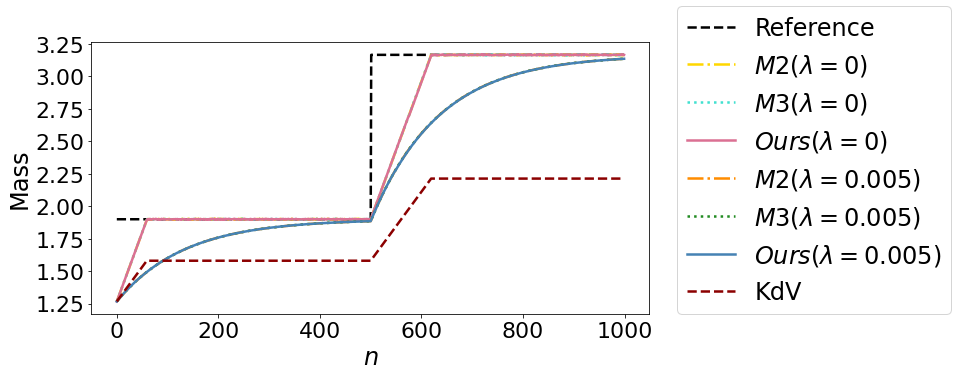

In [51]:
plt.figure(figsize=(10, 5))
plt.plot(mass_ref, label="Reference", linestyle="--", color=ref_color, linewidth=linewidth)

plt.plot(
    linear_kdv_opt_mass_0,
    label=r"$M2(\lambda = 0)$",
    color=linear_no_penalty_color,
    linestyle=linear_linestyle,
    linewidth=linewidth,
)
plt.plot(
    bilinear_kdv_opt_mass_0,
    label=r"$M3(\lambda = 0)$",
    color=bilinear_no_penalty_color,
    linestyle=bilinear_linestyle,
    linewidth=linewidth,
)
plt.plot(
    pk_kdv_opt_mass_0,
    label=r"$Ours(\lambda = 0)$", 
    color=pk_no_penalty_color, 
    linestyle=pk_linestyle, 
    linewidth=linewidth
)


plt.plot(
    linear_kdv_opt_mass_5,
    label=r"$M2(\lambda = 0.005)$",
    color=linear_curve,
    linestyle=linear_linestyle,
    linewidth=linewidth,
)
plt.plot(
    bilinear_kdv_opt_mass_5,
    label=r"$M3(\lambda = 0.005)$",
    color=bilinear_curve,
    linestyle=bilinear_linestyle,
    linewidth=linewidth,
)
plt.plot(
    pk_kdv_opt_mass_5,
    label=r"$Ours(\lambda = 0.005)$",
    color=pk_curve, 
    linestyle=pk_linestyle, 
    linewidth=linewidth
)

plt.plot(kdv_opt_mass, label="KdV", linestyle="--", color=exact_color, linewidth=linewidth)

plt.xticks(fontsize=ticks_font)
plt.yticks(fontsize=ticks_font)
plt.xlabel(r"$n$", fontsize=label_font)
plt.ylabel("Mass", fontsize=label_font)
# plt.yscale('log')
# plt.legend(fontsize=legend_font, loc=(1.05, 0.001))


plt.savefig(os.path.join(figures_path, 'kdv_'+forcing_type+'_mass_tracking.png'), dpi=200, bbox_inches='tight')
plt.savefig(os.path.join(figures_path, 'kdv_'+forcing_type+'_mass_tracking.pdf'), dpi=200, bbox_inches='tight')


### Track momentum

In [47]:
# pk_opt_control_momentum_0, pk_kdv_opt_momentum_soln_0 = KoopmanMPC(
#     y0=y0_track,
#     tau=tau,
#     traj_len=traj_len_track,
#     soln_ref=momentum_ref,
#     kdv_solver=kdv.kdv_solution,
#     B=B_momentum,
#     loss=mpc_loss_pk,
#     lambda_param=0,
# )

Processing time steps:   0%|          | 0/998 [00:00<?, ?it/s]

Processing time steps: 100%|██████████| 998/998 [04:31<00:00,  3.67it/s]


In [164]:
pk_opt_control_momentum_5, pk_kdv_opt_momentum_soln_5, pk_momentum_results_5, pk_momentum_t_list_5 = KoopmanMPC(
    y0=y0_track,
    tau=tau,
    traj_len=traj_len_track,
    soln_ref=momentum_ref,
    kdv_solver=kdv.kdv_solution,
    B=B_momentum,
    loss=mpc_loss_pk,
    lambda_param=0.005,
)

Processing time steps:   0%|          | 0/989 [00:00<?, ?it/s]

Processing time steps:   0%|          | 1/989 [01:59<32:43:18, 119.23s/it]

*** current time *** 0
optimize time:  119.0041184425354


Processing time steps:   0%|          | 2/989 [02:24<17:36:35, 64.23s/it] 

*** current time *** 1
optimize time:  25.448508262634277


Processing time steps:   0%|          | 3/989 [02:39<11:21:17, 41.46s/it]

*** current time *** 2
optimize time:  14.089802026748657


Processing time steps:   0%|          | 4/989 [02:50<8:06:03, 29.61s/it] 

*** current time *** 3
optimize time:  11.15370225906372


Processing time steps:   1%|          | 5/989 [03:00<6:09:25, 22.53s/it]

*** current time *** 4
optimize time:  9.716352939605713


Processing time steps:   1%|          | 6/989 [03:10<4:57:45, 18.17s/it]

*** current time *** 5
optimize time:  9.445339918136597


Processing time steps:   1%|          | 7/989 [03:20<4:13:47, 15.51s/it]

*** current time *** 6
optimize time:  9.641472101211548


Processing time steps:   1%|          | 8/989 [03:31<3:52:30, 14.22s/it]

*** current time *** 7
optimize time:  11.199499607086182


Processing time steps:   1%|          | 9/989 [03:41<3:30:00, 12.86s/it]

*** current time *** 8
optimize time:  9.598406314849854


Processing time steps:   1%|          | 10/989 [03:50<3:08:29, 11.55s/it]

*** current time *** 9
optimize time:  8.322606563568115


Processing time steps:   1%|          | 11/989 [04:00<2:58:59, 10.98s/it]

*** current time *** 10
optimize time:  9.4474778175354


Processing time steps:   1%|          | 12/989 [04:10<2:58:10, 10.94s/it]

*** current time *** 11
optimize time:  10.595606565475464


Processing time steps:   1%|▏         | 13/989 [04:20<2:52:09, 10.58s/it]

*** current time *** 12
optimize time:  9.491898775100708


Processing time steps:   1%|▏         | 14/989 [04:31<2:52:49, 10.64s/it]

*** current time *** 13
optimize time:  10.495489835739136


Processing time steps:   2%|▏         | 15/989 [04:40<2:43:23, 10.07s/it]

*** current time *** 14
optimize time:  8.475650787353516


Processing time steps:   2%|▏         | 16/989 [04:49<2:39:45,  9.85s/it]

*** current time *** 15
optimize time:  9.08639407157898


Processing time steps:   2%|▏         | 17/989 [05:00<2:44:54, 10.18s/it]

*** current time *** 16
optimize time:  10.64051866531372


Processing time steps:   2%|▏         | 18/989 [05:11<2:50:00, 10.51s/it]

*** current time *** 17
optimize time:  10.976088285446167


Processing time steps:   2%|▏         | 19/989 [05:34<3:48:27, 14.13s/it]

*** current time *** 18
optimize time:  22.21995520591736


Processing time steps:   2%|▏         | 20/989 [05:55<4:23:06, 16.29s/it]

*** current time *** 19
optimize time:  21.029934644699097


Processing time steps:   2%|▏         | 21/989 [06:18<4:56:01, 18.35s/it]

*** current time *** 20
optimize time:  22.81453561782837


Processing time steps:   2%|▏         | 22/989 [06:40<5:13:48, 19.47s/it]

*** current time *** 21
optimize time:  21.78668212890625


Processing time steps:   2%|▏         | 23/989 [07:03<5:28:06, 20.38s/it]

*** current time *** 22
optimize time:  22.242458820343018


Processing time steps:   2%|▏         | 24/989 [07:24<5:32:00, 20.64s/it]

*** current time *** 23
optimize time:  20.97963786125183


Processing time steps:   3%|▎         | 25/989 [07:48<5:44:51, 21.46s/it]

*** current time *** 24
optimize time:  23.037672519683838


Processing time steps:   3%|▎         | 26/989 [08:11<5:52:19, 21.95s/it]

*** current time *** 25
optimize time:  22.789265155792236


Processing time steps:   3%|▎         | 27/989 [08:34<5:56:21, 22.23s/it]

*** current time *** 26
optimize time:  22.52323889732361


Processing time steps:   3%|▎         | 28/989 [08:56<5:56:56, 22.29s/it]

*** current time *** 27
optimize time:  22.138099193572998


Processing time steps:   3%|▎         | 29/989 [09:18<5:55:41, 22.23s/it]

*** current time *** 28
optimize time:  21.835451126098633


Processing time steps:   3%|▎         | 30/989 [09:41<5:59:03, 22.46s/it]

*** current time *** 29
optimize time:  22.66743779182434


Processing time steps:   3%|▎         | 31/989 [09:52<5:02:56, 18.97s/it]

*** current time *** 30
optimize time:  10.5413658618927


Processing time steps:   3%|▎         | 32/989 [10:02<4:18:30, 16.21s/it]

*** current time *** 31
optimize time:  9.477376461029053


Processing time steps:   3%|▎         | 33/989 [10:14<3:57:49, 14.93s/it]

*** current time *** 32
optimize time:  11.621110200881958


Processing time steps:   3%|▎         | 34/989 [10:24<3:38:07, 13.70s/it]

*** current time *** 33
optimize time:  10.552914381027222


Processing time steps:   4%|▎         | 35/989 [10:35<3:20:53, 12.64s/it]

*** current time *** 34
optimize time:  9.84508228302002


Processing time steps:   4%|▎         | 36/989 [10:47<3:19:58, 12.59s/it]

*** current time *** 35
optimize time:  12.140161275863647


Processing time steps:   4%|▎         | 37/989 [10:57<3:06:14, 11.74s/it]

*** current time *** 36
optimize time:  9.49652361869812


Processing time steps:   4%|▍         | 38/989 [14:17<18:02:13, 68.28s/it]

*** current time *** 37
optimize time:  199.9490475654602


Processing time steps:   4%|▍         | 39/989 [14:42<14:35:03, 55.27s/it]

*** current time *** 38
optimize time:  24.613617420196533


Processing time steps:   4%|▍         | 40/989 [14:52<10:57:25, 41.57s/it]

*** current time *** 39
optimize time:  9.301367044448853


Processing time steps:   4%|▍         | 41/989 [15:02<8:28:34, 32.19s/it] 

*** current time *** 40
optimize time:  9.96708059310913


Processing time steps:   4%|▍         | 42/989 [15:10<6:32:48, 24.89s/it]

*** current time *** 41
optimize time:  7.5877556800842285


Processing time steps:   4%|▍         | 43/989 [17:40<16:24:09, 62.42s/it]

*** current time *** 42
optimize time:  149.72374033927917


Processing time steps:   4%|▍         | 44/989 [17:49<12:13:18, 46.56s/it]

*** current time *** 43
optimize time:  9.313977479934692


Processing time steps:   5%|▍         | 45/989 [19:11<14:56:59, 57.01s/it]

*** current time *** 44
optimize time:  81.08134508132935


Processing time steps:   5%|▍         | 46/989 [21:32<21:32:23, 82.23s/it]

*** current time *** 45
optimize time:  140.8474476337433


Processing time steps:   5%|▍         | 47/989 [21:38<15:33:32, 59.46s/it]

*** current time *** 46
optimize time:  6.031642913818359


Processing time steps:   5%|▍         | 48/989 [22:43<15:58:34, 61.12s/it]

*** current time *** 47
optimize time:  64.67688512802124


Processing time steps:   5%|▍         | 49/989 [23:27<14:35:22, 55.88s/it]

*** current time *** 48
optimize time:  43.37440609931946


Processing time steps:   5%|▌         | 50/989 [24:22<14:32:53, 55.78s/it]

*** current time *** 49
optimize time:  55.209450244903564


Processing time steps:   5%|▌         | 51/989 [25:34<15:48:21, 60.66s/it]

*** current time *** 50
optimize time:  71.81211137771606


Processing time steps:   5%|▌         | 52/989 [26:17<14:23:06, 55.27s/it]

*** current time *** 51
optimize time:  42.44420862197876


Processing time steps:   5%|▌         | 53/989 [27:41<16:38:09, 63.98s/it]

*** current time *** 52
optimize time:  83.99687123298645


Processing time steps:   5%|▌         | 54/989 [28:28<15:17:53, 58.90s/it]

*** current time *** 53
optimize time:  46.710813999176025


Processing time steps:   6%|▌         | 55/989 [29:33<15:45:50, 60.76s/it]

*** current time *** 54
optimize time:  64.75615096092224


Processing time steps:   6%|▌         | 56/989 [30:43<16:27:55, 63.53s/it]

*** current time *** 55
optimize time:  69.74105334281921


Processing time steps:   6%|▌         | 57/989 [31:36<15:35:10, 60.20s/it]

*** current time *** 56
optimize time:  52.204679012298584


Processing time steps:   6%|▌         | 58/989 [32:11<13:35:37, 52.56s/it]

*** current time *** 57
optimize time:  34.50144577026367


Processing time steps:   6%|▌         | 59/989 [32:19<10:08:30, 39.26s/it]

*** current time *** 58
optimize time:  7.977533340454102


Processing time steps:   6%|▌         | 60/989 [32:22<7:21:02, 28.48s/it] 

*** current time *** 59
optimize time:  3.0967907905578613


Processing time steps:   6%|▌         | 61/989 [32:25<5:23:18, 20.90s/it]

*** current time *** 60
optimize time:  2.9804012775421143


Processing time steps:   6%|▋         | 62/989 [32:29<4:01:36, 15.64s/it]

*** current time *** 61
optimize time:  3.0687708854675293


Processing time steps:   6%|▋         | 63/989 [32:32<3:04:26, 11.95s/it]

*** current time *** 62
optimize time:  3.119386672973633


Processing time steps:   6%|▋         | 64/989 [32:35<2:24:09,  9.35s/it]

*** current time *** 63
optimize time:  3.041160821914673


Processing time steps:   7%|▋         | 65/989 [32:39<1:55:38,  7.51s/it]

*** current time *** 64
optimize time:  2.9640727043151855


Processing time steps:   7%|▋         | 66/989 [32:42<1:36:33,  6.28s/it]

*** current time *** 65
optimize time:  3.1658003330230713


Processing time steps:   7%|▋         | 67/989 [32:45<1:22:40,  5.38s/it]

*** current time *** 66
optimize time:  2.966078519821167


Processing time steps:   7%|▋         | 68/989 [32:48<1:12:44,  4.74s/it]

*** current time *** 67
optimize time:  2.958777666091919


Processing time steps:   7%|▋         | 69/989 [32:52<1:06:30,  4.34s/it]

*** current time *** 68
optimize time:  3.135410785675049


Processing time steps:   7%|▋         | 70/989 [32:55<1:01:37,  4.02s/it]

*** current time *** 69
optimize time:  3.057077407836914


Processing time steps:   7%|▋         | 71/989 [32:59<58:49,  3.84s/it]  

*** current time *** 70
optimize time:  3.1581344604492188


Processing time steps:   7%|▋         | 72/989 [33:02<56:12,  3.68s/it]

*** current time *** 71
optimize time:  3.050790548324585


Processing time steps:   7%|▋         | 73/989 [33:05<54:12,  3.55s/it]

*** current time *** 72
optimize time:  3.005244493484497


Processing time steps:   7%|▋         | 74/989 [33:08<52:55,  3.47s/it]

*** current time *** 73
optimize time:  2.9741296768188477


Processing time steps:   8%|▊         | 75/989 [33:12<52:08,  3.42s/it]

*** current time *** 74
optimize time:  3.066433906555176


Processing time steps:   8%|▊         | 76/989 [33:15<52:00,  3.42s/it]

*** current time *** 75
optimize time:  3.161696195602417


Processing time steps:   8%|▊         | 77/989 [33:19<52:04,  3.43s/it]

*** current time *** 76
optimize time:  3.2161712646484375


Processing time steps:   8%|▊         | 78/989 [33:22<51:35,  3.40s/it]

*** current time *** 77
optimize time:  3.087191581726074


Processing time steps:   8%|▊         | 79/989 [33:25<51:26,  3.39s/it]

*** current time *** 78
optimize time:  3.0721793174743652


Processing time steps:   8%|▊         | 80/989 [33:29<50:53,  3.36s/it]

*** current time *** 79
optimize time:  3.0485334396362305


Processing time steps:   8%|▊         | 81/989 [33:31<46:22,  3.06s/it]

*** current time *** 80
optimize time:  2.118563652038574


Processing time steps:   8%|▊         | 82/989 [33:34<47:58,  3.17s/it]

*** current time *** 81
optimize time:  3.189771890640259


Processing time steps:   8%|▊         | 83/989 [33:37<43:34,  2.89s/it]

*** current time *** 82
optimize time:  1.9675631523132324


Processing time steps:   8%|▊         | 84/989 [33:40<45:30,  3.02s/it]

*** current time *** 83
optimize time:  3.0899994373321533


Processing time steps:   9%|▊         | 85/989 [33:41<37:41,  2.50s/it]

*** current time *** 84
optimize time:  1.054886817932129


Processing time steps:   9%|▊         | 86/989 [33:43<36:16,  2.41s/it]

*** current time *** 85
optimize time:  1.9159913063049316


Processing time steps:   9%|▉         | 87/989 [33:47<40:17,  2.68s/it]

*** current time *** 86
optimize time:  3.058443307876587


Processing time steps:   9%|▉         | 88/989 [33:48<34:08,  2.27s/it]

*** current time *** 87
optimize time:  1.0337815284729004


Processing time steps:   9%|▉         | 89/989 [33:49<29:37,  1.97s/it]

*** current time *** 88
optimize time:  1.0006818771362305


Processing time steps:   9%|▉         | 90/989 [33:52<31:25,  2.10s/it]

*** current time *** 89
optimize time:  2.141448497772217


Processing time steps:   9%|▉         | 91/989 [33:54<32:25,  2.17s/it]

*** current time *** 90
optimize time:  2.016580820083618


Processing time steps:   9%|▉         | 92/989 [33:57<37:15,  2.49s/it]

*** current time *** 91
optimize time:  2.997797727584839


Processing time steps:   9%|▉         | 93/989 [33:59<31:48,  2.13s/it]

*** current time *** 92
optimize time:  0.9688880443572998


Processing time steps:  10%|▉         | 94/989 [34:00<28:08,  1.89s/it]

*** current time *** 93
optimize time:  1.0508990287780762


Processing time steps:  10%|▉         | 95/989 [34:01<25:29,  1.71s/it]

*** current time *** 94
optimize time:  1.014465093612671


Processing time steps:  10%|▉         | 96/989 [34:02<23:18,  1.57s/it]

*** current time *** 95
optimize time:  0.9444534778594971


Processing time steps:  10%|▉         | 97/989 [34:04<21:52,  1.47s/it]

*** current time *** 96
optimize time:  1.0142533779144287


Processing time steps:  10%|▉         | 98/989 [34:05<21:35,  1.45s/it]

*** current time *** 97
optimize time:  1.0648069381713867


Processing time steps:  10%|█         | 99/989 [34:06<20:52,  1.41s/it]

*** current time *** 98
optimize time:  1.036048412322998


Processing time steps:  10%|█         | 100/989 [34:08<20:30,  1.38s/it]

*** current time *** 99
optimize time:  1.0726454257965088


Processing time steps:  10%|█         | 101/989 [34:09<19:48,  1.34s/it]

*** current time *** 100
optimize time:  0.9930698871612549


Processing time steps:  10%|█         | 102/989 [34:11<24:11,  1.64s/it]

*** current time *** 101
optimize time:  1.9346277713775635


Processing time steps:  10%|█         | 103/989 [34:13<26:35,  1.80s/it]

*** current time *** 102
optimize time:  1.9511723518371582


Processing time steps:  11%|█         | 104/989 [34:16<28:51,  1.96s/it]

*** current time *** 103
optimize time:  2.0707850456237793


Processing time steps:  11%|█         | 105/989 [34:18<30:09,  2.05s/it]

*** current time *** 104
optimize time:  2.018869161605835


Processing time steps:  11%|█         | 106/989 [34:20<31:02,  2.11s/it]

*** current time *** 105
optimize time:  2.0061514377593994


Processing time steps:  11%|█         | 107/989 [34:23<31:53,  2.17s/it]

*** current time *** 106
optimize time:  2.0442864894866943


Processing time steps:  11%|█         | 108/989 [34:25<33:34,  2.29s/it]

*** current time *** 107
optimize time:  2.1898205280303955


Processing time steps:  11%|█         | 109/989 [34:27<33:30,  2.29s/it]

*** current time *** 108
optimize time:  2.0182793140411377


Processing time steps:  11%|█         | 110/989 [34:31<38:13,  2.61s/it]

*** current time *** 109
optimize time:  3.053258180618286


Processing time steps:  11%|█         | 111/989 [34:32<32:15,  2.20s/it]

*** current time *** 110
optimize time:  1.0254127979278564


Processing time steps:  11%|█▏        | 112/989 [34:33<28:03,  1.92s/it]

*** current time *** 111
optimize time:  0.9687440395355225


Processing time steps:  11%|█▏        | 113/989 [34:35<25:14,  1.73s/it]

*** current time *** 112
optimize time:  1.0327978134155273


Processing time steps:  12%|█▏        | 114/989 [34:36<23:09,  1.59s/it]

*** current time *** 113
optimize time:  1.0317254066467285


Processing time steps:  12%|█▏        | 115/989 [34:37<21:32,  1.48s/it]

*** current time *** 114
optimize time:  0.9980378150939941


Processing time steps:  12%|█▏        | 116/989 [34:38<20:34,  1.41s/it]

*** current time *** 115
optimize time:  1.0017280578613281


Processing time steps:  12%|█▏        | 117/989 [34:40<20:08,  1.39s/it]

*** current time *** 116
optimize time:  1.0130515098571777


Processing time steps:  12%|█▏        | 118/989 [34:42<24:10,  1.66s/it]

*** current time *** 117
optimize time:  2.0286128520965576


Processing time steps:  12%|█▏        | 119/989 [34:44<26:37,  1.84s/it]

*** current time *** 118
optimize time:  1.9552409648895264


Processing time steps:  12%|█▏        | 120/989 [34:46<28:11,  1.95s/it]

*** current time *** 119
optimize time:  1.9760327339172363


Processing time steps:  12%|█▏        | 121/989 [34:49<30:04,  2.08s/it]

*** current time *** 120
optimize time:  2.157302141189575


Processing time steps:  12%|█▏        | 122/989 [34:51<31:17,  2.17s/it]

*** current time *** 121
optimize time:  2.061255693435669


Processing time steps:  12%|█▏        | 123/989 [34:53<31:48,  2.20s/it]

*** current time *** 122
optimize time:  2.0628015995025635


Processing time steps:  13%|█▎        | 124/989 [34:56<31:57,  2.22s/it]

*** current time *** 123
optimize time:  1.9574694633483887


Processing time steps:  13%|█▎        | 125/989 [34:58<32:09,  2.23s/it]

*** current time *** 124
optimize time:  2.0321462154388428


Processing time steps:  13%|█▎        | 126/989 [35:00<31:53,  2.22s/it]

*** current time *** 125
optimize time:  1.9294674396514893


Processing time steps:  13%|█▎        | 127/989 [35:02<32:08,  2.24s/it]

*** current time *** 126
optimize time:  2.056811571121216


Processing time steps:  13%|█▎        | 128/989 [35:05<32:38,  2.27s/it]

*** current time *** 127
optimize time:  1.9977045059204102


Processing time steps:  13%|█▎        | 129/989 [35:07<32:21,  2.26s/it]

*** current time *** 128
optimize time:  1.9868919849395752


Processing time steps:  13%|█▎        | 130/989 [35:09<32:51,  2.30s/it]

*** current time *** 129
optimize time:  2.145242691040039


Processing time steps:  13%|█▎        | 131/989 [35:12<32:33,  2.28s/it]

*** current time *** 130
optimize time:  1.9599316120147705


Processing time steps:  13%|█▎        | 132/989 [35:14<32:58,  2.31s/it]

*** current time *** 131
optimize time:  2.06257700920105


Processing time steps:  13%|█▎        | 133/989 [35:16<33:18,  2.33s/it]

*** current time *** 132
optimize time:  2.159203052520752


Processing time steps:  14%|█▎        | 134/989 [35:19<33:30,  2.35s/it]

*** current time *** 133
optimize time:  2.095304012298584


Processing time steps:  14%|█▎        | 135/989 [35:21<33:38,  2.36s/it]

*** current time *** 134
optimize time:  2.0817809104919434


Processing time steps:  14%|█▍        | 136/989 [35:23<32:50,  2.31s/it]

*** current time *** 135
optimize time:  1.9517607688903809


Processing time steps:  14%|█▍        | 137/989 [35:26<32:33,  2.29s/it]

*** current time *** 136
optimize time:  1.9334757328033447


Processing time steps:  14%|█▍        | 138/989 [35:28<32:37,  2.30s/it]

*** current time *** 137
optimize time:  1.9910533428192139


Processing time steps:  14%|█▍        | 139/989 [35:30<32:20,  2.28s/it]

*** current time *** 138
optimize time:  2.0140886306762695


Processing time steps:  14%|█▍        | 140/989 [35:33<32:30,  2.30s/it]

*** current time *** 139
optimize time:  2.0807998180389404


Processing time steps:  14%|█▍        | 141/989 [35:35<32:20,  2.29s/it]

*** current time *** 140
optimize time:  2.030524730682373


Processing time steps:  14%|█▍        | 142/989 [35:36<28:17,  2.00s/it]

*** current time *** 141
optimize time:  1.0402624607086182


Processing time steps:  14%|█▍        | 143/989 [35:37<25:15,  1.79s/it]

*** current time *** 142
optimize time:  1.0189952850341797


Processing time steps:  15%|█▍        | 144/989 [35:39<23:05,  1.64s/it]

*** current time *** 143
optimize time:  1.0167803764343262


Processing time steps:  15%|█▍        | 145/989 [35:40<21:26,  1.52s/it]

*** current time *** 144
optimize time:  1.0071070194244385


Processing time steps:  15%|█▍        | 146/989 [35:41<20:09,  1.43s/it]

*** current time *** 145
optimize time:  0.9940743446350098


Processing time steps:  15%|█▍        | 147/989 [35:42<19:21,  1.38s/it]

*** current time *** 146
optimize time:  1.0227150917053223


Processing time steps:  15%|█▍        | 148/989 [35:44<19:18,  1.38s/it]

*** current time *** 147
optimize time:  1.095898151397705


Processing time steps:  15%|█▌        | 149/989 [35:45<18:53,  1.35s/it]

*** current time *** 148
optimize time:  1.009207010269165


Processing time steps:  15%|█▌        | 150/989 [35:46<18:02,  1.29s/it]

*** current time *** 149
optimize time:  0.926008939743042


Processing time steps:  15%|█▌        | 151/989 [35:48<18:12,  1.30s/it]

*** current time *** 150
optimize time:  1.0938136577606201


Processing time steps:  15%|█▌        | 152/989 [35:49<17:57,  1.29s/it]

*** current time *** 151
optimize time:  0.9568397998809814


Processing time steps:  15%|█▌        | 153/989 [35:50<17:49,  1.28s/it]

*** current time *** 152
optimize time:  1.014237642288208


Processing time steps:  16%|█▌        | 154/989 [35:51<17:53,  1.29s/it]

*** current time *** 153
optimize time:  1.0308911800384521


Processing time steps:  16%|█▌        | 155/989 [35:53<17:32,  1.26s/it]

*** current time *** 154
optimize time:  0.9751672744750977


Processing time steps:  16%|█▌        | 156/989 [35:54<17:43,  1.28s/it]

*** current time *** 155
optimize time:  0.9811728000640869


Processing time steps:  16%|█▌        | 157/989 [35:55<17:59,  1.30s/it]

*** current time *** 156
optimize time:  1.0550689697265625


Processing time steps:  16%|█▌        | 158/989 [35:57<17:50,  1.29s/it]

*** current time *** 157
optimize time:  0.9691207408905029


Processing time steps:  16%|█▌        | 159/989 [35:58<17:54,  1.29s/it]

*** current time *** 158
optimize time:  1.0225028991699219


Processing time steps:  16%|█▌        | 160/989 [35:59<18:02,  1.31s/it]

*** current time *** 159
optimize time:  1.0950143337249756


Processing time steps:  16%|█▋        | 161/989 [36:01<17:59,  1.30s/it]

*** current time *** 160
optimize time:  1.0306506156921387


Processing time steps:  16%|█▋        | 162/989 [36:03<22:07,  1.60s/it]

*** current time *** 161
optimize time:  2.0500588417053223


Processing time steps:  16%|█▋        | 163/989 [36:05<25:34,  1.86s/it]

*** current time *** 162
optimize time:  2.1466152667999268


Processing time steps:  17%|█▋        | 164/989 [36:08<27:10,  1.98s/it]

*** current time *** 163
optimize time:  2.0162346363067627


Processing time steps:  17%|█▋        | 165/989 [36:10<28:58,  2.11s/it]

*** current time *** 164
optimize time:  2.1198320388793945


Processing time steps:  17%|█▋        | 166/989 [36:12<29:49,  2.17s/it]

*** current time *** 165
optimize time:  2.0440421104431152


Processing time steps:  17%|█▋        | 167/989 [36:15<30:21,  2.22s/it]

*** current time *** 166
optimize time:  1.9890565872192383


Processing time steps:  17%|█▋        | 168/989 [36:17<30:34,  2.23s/it]

*** current time *** 167
optimize time:  2.03659725189209


Processing time steps:  17%|█▋        | 169/989 [36:19<30:53,  2.26s/it]

*** current time *** 168
optimize time:  1.99912428855896


Processing time steps:  17%|█▋        | 170/989 [36:21<31:03,  2.27s/it]

*** current time *** 169
optimize time:  2.0675337314605713


Processing time steps:  17%|█▋        | 171/989 [36:24<31:37,  2.32s/it]

*** current time *** 170
optimize time:  2.161780595779419


Processing time steps:  17%|█▋        | 172/989 [36:26<31:55,  2.34s/it]

*** current time *** 171
optimize time:  2.076045513153076


Processing time steps:  17%|█▋        | 173/989 [36:29<31:17,  2.30s/it]

*** current time *** 172
optimize time:  1.9542689323425293


Processing time steps:  18%|█▊        | 174/989 [36:31<31:17,  2.30s/it]

*** current time *** 173
optimize time:  1.940438985824585


Processing time steps:  18%|█▊        | 175/989 [36:33<31:20,  2.31s/it]

*** current time *** 174
optimize time:  2.0724735260009766


Processing time steps:  18%|█▊        | 176/989 [36:35<31:20,  2.31s/it]

*** current time *** 175
optimize time:  2.039888620376587


Processing time steps:  18%|█▊        | 177/989 [36:39<35:05,  2.59s/it]

*** current time *** 176
optimize time:  3.0162644386291504


Processing time steps:  18%|█▊        | 178/989 [36:40<29:23,  2.17s/it]

*** current time *** 177
optimize time:  0.9700345993041992


Processing time steps:  18%|█▊        | 179/989 [36:41<25:44,  1.91s/it]

*** current time *** 178
optimize time:  1.0467679500579834


Processing time steps:  18%|█▊        | 180/989 [36:43<23:32,  1.75s/it]

*** current time *** 179
optimize time:  1.0943076610565186


Processing time steps:  18%|█▊        | 181/989 [36:44<21:35,  1.60s/it]

*** current time *** 180
optimize time:  1.0296874046325684


Processing time steps:  18%|█▊        | 182/989 [36:45<20:20,  1.51s/it]

*** current time *** 181
optimize time:  0.9628391265869141


Processing time steps:  19%|█▊        | 183/989 [36:46<19:21,  1.44s/it]

*** current time *** 182
optimize time:  0.9936952590942383


Processing time steps:  19%|█▊        | 184/989 [36:49<23:07,  1.72s/it]

*** current time *** 183
optimize time:  2.137077569961548


Processing time steps:  19%|█▊        | 185/989 [36:51<25:13,  1.88s/it]

*** current time *** 184
optimize time:  2.017354965209961


Processing time steps:  19%|█▉        | 186/989 [36:53<26:57,  2.01s/it]

*** current time *** 185
optimize time:  1.9957561492919922


Processing time steps:  19%|█▉        | 187/989 [36:56<28:10,  2.11s/it]

*** current time *** 186
optimize time:  2.074333429336548


Processing time steps:  19%|█▉        | 188/989 [36:59<33:28,  2.51s/it]

*** current time *** 187
optimize time:  3.2009923458099365


Processing time steps:  19%|█▉        | 189/989 [37:00<28:32,  2.14s/it]

*** current time *** 188
optimize time:  0.9992465972900391


Processing time steps:  19%|█▉        | 190/989 [37:02<24:59,  1.88s/it]

*** current time *** 189
optimize time:  1.010263442993164


Processing time steps:  19%|█▉        | 191/989 [37:03<22:55,  1.72s/it]

*** current time *** 190
optimize time:  1.1040654182434082


Processing time steps:  19%|█▉        | 192/989 [37:04<20:59,  1.58s/it]

*** current time *** 191
optimize time:  0.9395956993103027


Processing time steps:  20%|█▉        | 193/989 [37:06<19:31,  1.47s/it]

*** current time *** 192
optimize time:  0.9721372127532959


Processing time steps:  20%|█▉        | 194/989 [37:07<18:53,  1.43s/it]

*** current time *** 193
optimize time:  1.0727264881134033


Processing time steps:  20%|█▉        | 195/989 [37:08<18:26,  1.39s/it]

*** current time *** 194
optimize time:  1.0570101737976074


Processing time steps:  20%|█▉        | 196/989 [37:09<17:54,  1.35s/it]

*** current time *** 195
optimize time:  1.0085704326629639


Processing time steps:  20%|█▉        | 197/989 [37:11<17:20,  1.31s/it]

*** current time *** 196
optimize time:  0.9894838333129883


Processing time steps:  20%|██        | 198/989 [37:12<17:11,  1.30s/it]

*** current time *** 197
optimize time:  0.9983212947845459


Processing time steps:  20%|██        | 199/989 [37:13<17:11,  1.31s/it]

*** current time *** 198
optimize time:  1.0406370162963867


Processing time steps:  20%|██        | 200/989 [37:15<17:07,  1.30s/it]

*** current time *** 199
optimize time:  1.0636274814605713


Processing time steps:  20%|██        | 201/989 [37:16<16:59,  1.29s/it]

*** current time *** 200
optimize time:  1.0185315608978271


Processing time steps:  20%|██        | 202/989 [37:17<17:00,  1.30s/it]

*** current time *** 201
optimize time:  1.0641026496887207


Processing time steps:  21%|██        | 203/989 [37:18<16:58,  1.30s/it]

*** current time *** 202
optimize time:  1.042747974395752


Processing time steps:  21%|██        | 204/989 [37:20<16:49,  1.29s/it]

*** current time *** 203
optimize time:  1.0255146026611328


Processing time steps:  21%|██        | 205/989 [37:21<17:10,  1.31s/it]

*** current time *** 204
optimize time:  1.049299955368042


Processing time steps:  21%|██        | 206/989 [37:22<17:10,  1.32s/it]

*** current time *** 205
optimize time:  1.0871915817260742


Processing time steps:  21%|██        | 207/989 [37:24<16:55,  1.30s/it]

*** current time *** 206
optimize time:  1.0308585166931152


Processing time steps:  21%|██        | 208/989 [37:25<17:17,  1.33s/it]

*** current time *** 207
optimize time:  1.1179652214050293


Processing time steps:  21%|██        | 209/989 [37:26<17:08,  1.32s/it]

*** current time *** 208
optimize time:  1.0004372596740723


Processing time steps:  21%|██        | 210/989 [37:28<16:47,  1.29s/it]

*** current time *** 209
optimize time:  1.0017471313476562


Processing time steps:  21%|██▏       | 211/989 [37:29<17:11,  1.33s/it]

*** current time *** 210
optimize time:  1.0771512985229492


Processing time steps:  21%|██▏       | 212/989 [37:30<16:50,  1.30s/it]

*** current time *** 211
optimize time:  0.9749729633331299


Processing time steps:  22%|██▏       | 213/989 [37:31<16:48,  1.30s/it]

*** current time *** 212
optimize time:  1.0036509037017822


Processing time steps:  22%|██▏       | 214/989 [37:33<17:21,  1.34s/it]

*** current time *** 213
optimize time:  1.0981254577636719


Processing time steps:  22%|██▏       | 215/989 [37:34<17:06,  1.33s/it]

*** current time *** 214
optimize time:  1.0557467937469482


Processing time steps:  22%|██▏       | 216/989 [37:35<16:30,  1.28s/it]

*** current time *** 215
optimize time:  0.9486587047576904


Processing time steps:  22%|██▏       | 217/989 [37:37<16:55,  1.32s/it]

*** current time *** 216
optimize time:  1.1005942821502686


Processing time steps:  22%|██▏       | 218/989 [37:38<16:56,  1.32s/it]

*** current time *** 217
optimize time:  1.0919039249420166


Processing time steps:  22%|██▏       | 219/989 [37:39<17:00,  1.33s/it]

*** current time *** 218
optimize time:  1.0720725059509277


Processing time steps:  22%|██▏       | 220/989 [37:41<16:48,  1.31s/it]

*** current time *** 219
optimize time:  1.0170094966888428


Processing time steps:  22%|██▏       | 221/989 [37:42<16:37,  1.30s/it]

*** current time *** 220
optimize time:  0.9768760204315186


Processing time steps:  22%|██▏       | 222/989 [37:43<16:42,  1.31s/it]

*** current time *** 221
optimize time:  1.0485355854034424


Processing time steps:  23%|██▎       | 223/989 [37:45<16:27,  1.29s/it]

*** current time *** 222
optimize time:  0.9997107982635498


Processing time steps:  23%|██▎       | 224/989 [37:46<16:26,  1.29s/it]

*** current time *** 223
optimize time:  1.0111162662506104


Processing time steps:  23%|██▎       | 225/989 [37:47<16:20,  1.28s/it]

*** current time *** 224
optimize time:  1.0151238441467285


Processing time steps:  23%|██▎       | 226/989 [37:48<16:15,  1.28s/it]

*** current time *** 225
optimize time:  1.0372545719146729


Processing time steps:  23%|██▎       | 227/989 [37:50<16:09,  1.27s/it]

*** current time *** 226
optimize time:  0.9769322872161865


Processing time steps:  23%|██▎       | 228/989 [37:51<16:14,  1.28s/it]

*** current time *** 227
optimize time:  1.0335369110107422


Processing time steps:  23%|██▎       | 229/989 [37:53<20:00,  1.58s/it]

*** current time *** 228
optimize time:  1.9762849807739258


Processing time steps:  23%|██▎       | 230/989 [37:55<22:33,  1.78s/it]

*** current time *** 229
optimize time:  2.027405023574829


Processing time steps:  23%|██▎       | 231/989 [37:58<24:37,  1.95s/it]

*** current time *** 230
optimize time:  2.0986480712890625


Processing time steps:  23%|██▎       | 232/989 [38:00<25:26,  2.02s/it]

*** current time *** 231
optimize time:  1.9464795589447021


Processing time steps:  24%|██▎       | 233/989 [38:02<26:32,  2.11s/it]

*** current time *** 232
optimize time:  2.0387113094329834


Processing time steps:  24%|██▎       | 234/989 [38:05<27:16,  2.17s/it]

*** current time *** 233
optimize time:  2.0347440242767334


Processing time steps:  24%|██▍       | 235/989 [38:07<27:28,  2.19s/it]

*** current time *** 234
optimize time:  2.0026957988739014


Processing time steps:  24%|██▍       | 236/989 [38:09<28:00,  2.23s/it]

*** current time *** 235
optimize time:  2.083866834640503


Processing time steps:  24%|██▍       | 237/989 [38:11<27:51,  2.22s/it]

*** current time *** 236
optimize time:  1.9653546810150146


Processing time steps:  24%|██▍       | 238/989 [38:14<28:22,  2.27s/it]

*** current time *** 237
optimize time:  2.1353509426116943


Processing time steps:  24%|██▍       | 239/989 [38:16<28:06,  2.25s/it]

*** current time *** 238
optimize time:  1.978104829788208


Processing time steps:  24%|██▍       | 240/989 [38:18<28:11,  2.26s/it]

*** current time *** 239
optimize time:  2.0159080028533936


Processing time steps:  24%|██▍       | 241/989 [38:21<28:52,  2.32s/it]

*** current time *** 240
optimize time:  2.0514345169067383


Processing time steps:  24%|██▍       | 242/989 [38:23<28:40,  2.30s/it]

*** current time *** 241
optimize time:  2.0376100540161133


Processing time steps:  25%|██▍       | 243/989 [38:24<24:44,  1.99s/it]

*** current time *** 242
optimize time:  0.9989414215087891


Processing time steps:  25%|██▍       | 244/989 [38:25<22:00,  1.77s/it]

*** current time *** 243
optimize time:  0.9798893928527832


Processing time steps:  25%|██▍       | 245/989 [38:27<20:29,  1.65s/it]

*** current time *** 244
optimize time:  1.1172490119934082


Processing time steps:  25%|██▍       | 246/989 [38:28<19:19,  1.56s/it]

*** current time *** 245
optimize time:  1.0691475868225098


Processing time steps:  25%|██▍       | 247/989 [38:30<18:25,  1.49s/it]

*** current time *** 246
optimize time:  1.0783283710479736


Processing time steps:  25%|██▌       | 248/989 [38:31<17:38,  1.43s/it]

*** current time *** 247
optimize time:  1.0575690269470215


Processing time steps:  25%|██▌       | 249/989 [38:32<17:00,  1.38s/it]

*** current time *** 248
optimize time:  1.0364387035369873


Processing time steps:  25%|██▌       | 250/989 [38:33<16:32,  1.34s/it]

*** current time *** 249
optimize time:  1.0177323818206787


Processing time steps:  25%|██▌       | 251/989 [38:35<16:14,  1.32s/it]

*** current time *** 250
optimize time:  1.0297825336456299


Processing time steps:  25%|██▌       | 252/989 [38:36<16:22,  1.33s/it]

*** current time *** 251
optimize time:  1.0816223621368408


Processing time steps:  26%|██▌       | 253/989 [38:37<16:20,  1.33s/it]

*** current time *** 252
optimize time:  1.0526695251464844


Processing time steps:  26%|██▌       | 254/989 [38:39<16:01,  1.31s/it]

*** current time *** 253
optimize time:  1.0105884075164795


Processing time steps:  26%|██▌       | 255/989 [38:40<15:58,  1.31s/it]

*** current time *** 254
optimize time:  1.0638389587402344


Processing time steps:  26%|██▌       | 256/989 [38:41<15:38,  1.28s/it]

*** current time *** 255
optimize time:  0.9922869205474854


Processing time steps:  26%|██▌       | 257/989 [38:42<15:36,  1.28s/it]

*** current time *** 256
optimize time:  1.0187172889709473


Processing time steps:  26%|██▌       | 258/989 [38:44<15:26,  1.27s/it]

*** current time *** 257
optimize time:  0.9977171421051025


Processing time steps:  26%|██▌       | 259/989 [38:45<15:41,  1.29s/it]

*** current time *** 258
optimize time:  1.059173345565796


Processing time steps:  26%|██▋       | 260/989 [38:46<15:43,  1.29s/it]

*** current time *** 259
optimize time:  0.9941504001617432


Processing time steps:  26%|██▋       | 261/989 [38:48<16:11,  1.33s/it]

*** current time *** 260
optimize time:  1.1869487762451172


Processing time steps:  26%|██▋       | 262/989 [38:49<16:22,  1.35s/it]

*** current time *** 261
optimize time:  1.0451021194458008


Processing time steps:  27%|██▋       | 263/989 [38:50<15:55,  1.32s/it]

*** current time *** 262
optimize time:  0.9952375888824463


Processing time steps:  27%|██▋       | 264/989 [38:51<15:19,  1.27s/it]

*** current time *** 263
optimize time:  0.9323711395263672


Processing time steps:  27%|██▋       | 265/989 [38:53<15:38,  1.30s/it]

*** current time *** 264
optimize time:  1.0857694149017334


Processing time steps:  27%|██▋       | 266/989 [38:55<19:56,  1.65s/it]

*** current time *** 265
optimize time:  2.163360595703125


Processing time steps:  27%|██▋       | 267/989 [38:58<22:20,  1.86s/it]

*** current time *** 266
optimize time:  2.0876293182373047


Processing time steps:  27%|██▋       | 268/989 [39:00<24:43,  2.06s/it]

*** current time *** 267
optimize time:  2.2412168979644775


Processing time steps:  27%|██▋       | 269/989 [39:02<25:35,  2.13s/it]

*** current time *** 268
optimize time:  2.0701818466186523


Processing time steps:  27%|██▋       | 270/989 [39:05<26:17,  2.19s/it]

*** current time *** 269
optimize time:  2.0846595764160156


Processing time steps:  27%|██▋       | 271/989 [39:07<27:11,  2.27s/it]

*** current time *** 270
optimize time:  2.169626235961914


Processing time steps:  28%|██▊       | 272/989 [39:11<31:36,  2.64s/it]

*** current time *** 271
optimize time:  3.251126766204834


Processing time steps:  28%|██▊       | 273/989 [39:12<26:37,  2.23s/it]

*** current time *** 272
optimize time:  1.0242416858673096


Processing time steps:  28%|██▊       | 274/989 [39:13<22:58,  1.93s/it]

*** current time *** 273
optimize time:  0.9942338466644287


Processing time steps:  28%|██▊       | 275/989 [39:14<20:14,  1.70s/it]

*** current time *** 274
optimize time:  0.9423811435699463


Processing time steps:  28%|██▊       | 276/989 [39:16<18:49,  1.58s/it]

*** current time *** 275
optimize time:  1.0664434432983398


Processing time steps:  28%|██▊       | 277/989 [39:17<17:42,  1.49s/it]

*** current time *** 276
optimize time:  1.051917552947998


Processing time steps:  28%|██▊       | 278/989 [39:18<16:49,  1.42s/it]

*** current time *** 277
optimize time:  1.0083088874816895


Processing time steps:  28%|██▊       | 279/989 [39:20<16:16,  1.38s/it]

*** current time *** 278
optimize time:  0.9580888748168945


Processing time steps:  28%|██▊       | 280/989 [39:21<15:55,  1.35s/it]

*** current time *** 279
optimize time:  1.0100195407867432


Processing time steps:  28%|██▊       | 281/989 [39:23<19:45,  1.67s/it]

*** current time *** 280
optimize time:  2.1852869987487793


Processing time steps:  29%|██▊       | 282/989 [39:25<21:36,  1.83s/it]

*** current time *** 281
optimize time:  1.9199931621551514


Processing time steps:  29%|██▊       | 283/989 [39:28<23:25,  1.99s/it]

*** current time *** 282
optimize time:  2.121049165725708


Processing time steps:  29%|██▊       | 284/989 [39:30<24:53,  2.12s/it]

*** current time *** 283
optimize time:  2.165853977203369


Processing time steps:  29%|██▉       | 285/989 [39:33<25:29,  2.17s/it]

*** current time *** 284
optimize time:  2.0295605659484863


Processing time steps:  29%|██▉       | 286/989 [39:35<25:32,  2.18s/it]

*** current time *** 285
optimize time:  1.9636387825012207


Processing time steps:  29%|██▉       | 287/989 [39:38<29:38,  2.53s/it]

*** current time *** 286
optimize time:  3.0610296726226807


Processing time steps:  29%|██▉       | 288/989 [39:39<25:29,  2.18s/it]

*** current time *** 287
optimize time:  1.1127958297729492


Processing time steps:  29%|██▉       | 289/989 [39:41<22:19,  1.91s/it]

*** current time *** 288
optimize time:  1.0363836288452148


Processing time steps:  29%|██▉       | 290/989 [39:42<20:05,  1.72s/it]

*** current time *** 289
optimize time:  1.0439553260803223


Processing time steps:  29%|██▉       | 291/989 [39:43<18:38,  1.60s/it]

*** current time *** 290
optimize time:  1.0754244327545166


Processing time steps:  30%|██▉       | 292/989 [39:45<17:23,  1.50s/it]

*** current time *** 291
optimize time:  1.0209708213806152


Processing time steps:  30%|██▉       | 293/989 [39:46<16:30,  1.42s/it]

*** current time *** 292
optimize time:  1.0161635875701904


Processing time steps:  30%|██▉       | 294/989 [39:47<16:30,  1.43s/it]

*** current time *** 293
optimize time:  1.1507925987243652


Processing time steps:  30%|██▉       | 295/989 [39:49<15:58,  1.38s/it]

*** current time *** 294
optimize time:  0.9685583114624023


Processing time steps:  30%|██▉       | 296/989 [39:50<15:40,  1.36s/it]

*** current time *** 295
optimize time:  1.0173547267913818


Processing time steps:  30%|███       | 297/989 [39:51<15:33,  1.35s/it]

*** current time *** 296
optimize time:  1.0798017978668213


Processing time steps:  30%|███       | 298/989 [39:53<15:26,  1.34s/it]

*** current time *** 297
optimize time:  1.0848498344421387


Processing time steps:  30%|███       | 299/989 [39:54<15:15,  1.33s/it]

*** current time *** 298
optimize time:  1.0465545654296875


Processing time steps:  30%|███       | 300/989 [39:55<15:18,  1.33s/it]

*** current time *** 299
optimize time:  1.0830464363098145


Processing time steps:  30%|███       | 301/989 [39:56<15:17,  1.33s/it]

*** current time *** 300
optimize time:  1.079394817352295


Processing time steps:  31%|███       | 302/989 [39:58<15:11,  1.33s/it]

*** current time *** 301
optimize time:  1.0448718070983887


Processing time steps:  31%|███       | 303/989 [39:59<15:10,  1.33s/it]

*** current time *** 302
optimize time:  1.0682661533355713


Processing time steps:  31%|███       | 304/989 [40:00<14:37,  1.28s/it]

*** current time *** 303
optimize time:  0.9404664039611816


Processing time steps:  31%|███       | 305/989 [40:02<14:51,  1.30s/it]

*** current time *** 304
optimize time:  1.0978405475616455


Processing time steps:  31%|███       | 306/989 [40:03<14:52,  1.31s/it]

*** current time *** 305
optimize time:  1.0571980476379395


Processing time steps:  31%|███       | 307/989 [40:04<15:07,  1.33s/it]

*** current time *** 306
optimize time:  1.0697956085205078


Processing time steps:  31%|███       | 308/989 [40:06<14:49,  1.31s/it]

*** current time *** 307
optimize time:  0.9527945518493652


Processing time steps:  31%|███       | 309/989 [40:07<14:49,  1.31s/it]

*** current time *** 308
optimize time:  1.0025551319122314


Processing time steps:  31%|███▏      | 310/989 [40:08<14:48,  1.31s/it]

*** current time *** 309
optimize time:  1.0457465648651123


Processing time steps:  31%|███▏      | 311/989 [40:09<14:37,  1.29s/it]

*** current time *** 310
optimize time:  1.0233042240142822


Processing time steps:  32%|███▏      | 312/989 [40:11<14:44,  1.31s/it]

*** current time *** 311
optimize time:  1.0191967487335205


Processing time steps:  32%|███▏      | 313/989 [40:12<14:40,  1.30s/it]

*** current time *** 312
optimize time:  1.0565433502197266


Processing time steps:  32%|███▏      | 314/989 [40:13<14:50,  1.32s/it]

*** current time *** 313
optimize time:  1.084075689315796


Processing time steps:  32%|███▏      | 315/989 [40:15<14:44,  1.31s/it]

*** current time *** 314
optimize time:  0.9718315601348877


Processing time steps:  32%|███▏      | 316/989 [40:16<14:32,  1.30s/it]

*** current time *** 315
optimize time:  1.023629903793335


Processing time steps:  32%|███▏      | 317/989 [40:17<14:28,  1.29s/it]

*** current time *** 316
optimize time:  1.0406944751739502


Processing time steps:  32%|███▏      | 318/989 [40:19<14:41,  1.31s/it]

*** current time *** 317
optimize time:  1.0812253952026367


Processing time steps:  32%|███▏      | 319/989 [40:20<15:01,  1.35s/it]

*** current time *** 318
optimize time:  1.0588793754577637


Processing time steps:  32%|███▏      | 320/989 [40:21<14:43,  1.32s/it]

*** current time *** 319
optimize time:  0.9725096225738525


Processing time steps:  32%|███▏      | 321/989 [40:23<14:56,  1.34s/it]

*** current time *** 320
optimize time:  1.078791618347168


Processing time steps:  33%|███▎      | 322/989 [40:24<15:13,  1.37s/it]

*** current time *** 321
optimize time:  1.1061832904815674


Processing time steps:  33%|███▎      | 323/989 [40:25<14:45,  1.33s/it]

*** current time *** 322
optimize time:  0.9922261238098145


Processing time steps:  33%|███▎      | 324/989 [40:27<14:53,  1.34s/it]

*** current time *** 323
optimize time:  1.1151049137115479


Processing time steps:  33%|███▎      | 325/989 [40:28<14:57,  1.35s/it]

*** current time *** 324
optimize time:  1.0642650127410889


Processing time steps:  33%|███▎      | 326/989 [40:30<15:13,  1.38s/it]

*** current time *** 325
optimize time:  1.1837060451507568


Processing time steps:  33%|███▎      | 327/989 [40:32<18:30,  1.68s/it]

*** current time *** 326
optimize time:  2.1239893436431885


Processing time steps:  33%|███▎      | 328/989 [40:34<20:30,  1.86s/it]

*** current time *** 327
optimize time:  2.0527126789093018


Processing time steps:  33%|███▎      | 329/989 [40:37<21:44,  1.98s/it]

*** current time *** 328
optimize time:  2.0176568031311035


Processing time steps:  33%|███▎      | 330/989 [40:39<22:47,  2.08s/it]

*** current time *** 329
optimize time:  1.9970028400421143


Processing time steps:  33%|███▎      | 331/989 [40:41<23:38,  2.16s/it]

*** current time *** 330
optimize time:  2.0174193382263184


Processing time steps:  34%|███▎      | 332/989 [40:44<24:12,  2.21s/it]

*** current time *** 331
optimize time:  1.9734666347503662


Processing time steps:  34%|███▎      | 333/989 [40:46<24:32,  2.24s/it]

*** current time *** 332
optimize time:  1.9818711280822754


Processing time steps:  34%|███▍      | 334/989 [40:48<24:41,  2.26s/it]

*** current time *** 333
optimize time:  2.04789400100708


Processing time steps:  34%|███▍      | 335/989 [40:50<24:33,  2.25s/it]

*** current time *** 334
optimize time:  1.9922614097595215


Processing time steps:  34%|███▍      | 336/989 [40:53<24:23,  2.24s/it]

*** current time *** 335
optimize time:  1.9304783344268799


Processing time steps:  34%|███▍      | 337/989 [40:55<24:25,  2.25s/it]

*** current time *** 336
optimize time:  2.0138700008392334


Processing time steps:  34%|███▍      | 338/989 [40:57<25:02,  2.31s/it]

*** current time *** 337
optimize time:  2.085139036178589


Processing time steps:  34%|███▍      | 339/989 [41:00<24:53,  2.30s/it]

*** current time *** 338
optimize time:  1.966343641281128


Processing time steps:  34%|███▍      | 340/989 [41:03<28:50,  2.67s/it]

*** current time *** 339
optimize time:  3.2559032440185547


Processing time steps:  34%|███▍      | 341/989 [41:04<24:41,  2.29s/it]

*** current time *** 340
optimize time:  1.0525567531585693


Processing time steps:  35%|███▍      | 342/989 [41:06<21:27,  1.99s/it]

*** current time *** 341
optimize time:  0.9321012496948242


Processing time steps:  35%|███▍      | 343/989 [41:07<19:11,  1.78s/it]

*** current time *** 342
optimize time:  1.067917823791504


Processing time steps:  35%|███▍      | 344/989 [41:08<17:26,  1.62s/it]

*** current time *** 343
optimize time:  1.016653299331665


Processing time steps:  35%|███▍      | 345/989 [41:10<16:22,  1.53s/it]

*** current time *** 344
optimize time:  0.9864442348480225


Processing time steps:  35%|███▍      | 346/989 [41:11<15:56,  1.49s/it]

*** current time *** 345
optimize time:  1.139108657836914


Processing time steps:  35%|███▌      | 347/989 [41:12<15:20,  1.43s/it]

*** current time *** 346
optimize time:  1.0338025093078613


Processing time steps:  35%|███▌      | 348/989 [41:14<14:54,  1.40s/it]

*** current time *** 347
optimize time:  1.0337355136871338


Processing time steps:  35%|███▌      | 349/989 [41:16<17:42,  1.66s/it]

*** current time *** 348
optimize time:  1.9630522727966309


Processing time steps:  35%|███▌      | 350/989 [41:18<19:39,  1.85s/it]

*** current time *** 349
optimize time:  2.018592119216919


Processing time steps:  35%|███▌      | 351/989 [41:21<21:16,  2.00s/it]

*** current time *** 350
optimize time:  2.1237213611602783


Processing time steps:  36%|███▌      | 352/989 [41:23<22:16,  2.10s/it]

*** current time *** 351
optimize time:  2.079620838165283


Processing time steps:  36%|███▌      | 353/989 [41:25<23:00,  2.17s/it]

*** current time *** 352
optimize time:  2.0832715034484863


Processing time steps:  36%|███▌      | 354/989 [41:28<23:19,  2.20s/it]

*** current time *** 353
optimize time:  2.030817985534668


Processing time steps:  36%|███▌      | 355/989 [41:30<23:27,  2.22s/it]

*** current time *** 354
optimize time:  2.031609296798706


Processing time steps:  36%|███▌      | 356/989 [41:32<24:11,  2.29s/it]

*** current time *** 355
optimize time:  2.087562322616577


Processing time steps:  36%|███▌      | 357/989 [41:34<24:02,  2.28s/it]

*** current time *** 356
optimize time:  2.0221424102783203


Processing time steps:  36%|███▌      | 358/989 [41:37<24:02,  2.29s/it]

*** current time *** 357
optimize time:  2.0641281604766846


Processing time steps:  36%|███▋      | 359/989 [41:39<24:00,  2.29s/it]

*** current time *** 358
optimize time:  1.99068284034729


Processing time steps:  36%|███▋      | 360/989 [41:42<27:06,  2.59s/it]

*** current time *** 359
optimize time:  3.0437612533569336


Processing time steps:  37%|███▋      | 361/989 [41:44<22:54,  2.19s/it]

*** current time *** 360
optimize time:  1.0179667472839355


Processing time steps:  37%|███▋      | 362/989 [41:45<20:03,  1.92s/it]

*** current time *** 361
optimize time:  1.0080509185791016


Processing time steps:  37%|███▋      | 363/989 [41:46<18:08,  1.74s/it]

*** current time *** 362
optimize time:  1.077305555343628


Processing time steps:  37%|███▋      | 364/989 [41:48<16:52,  1.62s/it]

*** current time *** 363
optimize time:  1.1089236736297607


Processing time steps:  37%|███▋      | 365/989 [41:49<15:45,  1.52s/it]

*** current time *** 364
optimize time:  1.0389008522033691


Processing time steps:  37%|███▋      | 366/989 [41:50<15:18,  1.47s/it]

*** current time *** 365
optimize time:  1.0656015872955322


Processing time steps:  37%|███▋      | 367/989 [41:52<14:51,  1.43s/it]

*** current time *** 366
optimize time:  0.998319149017334


Processing time steps:  37%|███▋      | 368/989 [41:53<14:23,  1.39s/it]

*** current time *** 367
optimize time:  1.0478887557983398


Processing time steps:  37%|███▋      | 369/989 [41:55<17:25,  1.69s/it]

*** current time *** 368
optimize time:  2.085564613342285


Processing time steps:  37%|███▋      | 370/989 [41:58<19:27,  1.89s/it]

*** current time *** 369
optimize time:  2.0560333728790283


Processing time steps:  38%|███▊      | 371/989 [42:00<20:48,  2.02s/it]

*** current time *** 370
optimize time:  2.0335071086883545


Processing time steps:  38%|███▊      | 372/989 [42:02<21:16,  2.07s/it]

*** current time *** 371
optimize time:  1.9462506771087646


Processing time steps:  38%|███▊      | 373/989 [42:04<21:38,  2.11s/it]

*** current time *** 372
optimize time:  1.9679491519927979


Processing time steps:  38%|███▊      | 374/989 [42:07<22:09,  2.16s/it]

*** current time *** 373
optimize time:  2.041754961013794


Processing time steps:  38%|███▊      | 375/989 [42:09<22:25,  2.19s/it]

*** current time *** 374
optimize time:  1.9242641925811768


Processing time steps:  38%|███▊      | 376/989 [42:11<23:01,  2.25s/it]

*** current time *** 375
optimize time:  2.107816457748413


Processing time steps:  38%|███▊      | 377/989 [42:14<23:07,  2.27s/it]

*** current time *** 376
optimize time:  2.0221235752105713


Processing time steps:  38%|███▊      | 378/989 [42:16<23:24,  2.30s/it]

*** current time *** 377
optimize time:  2.0279598236083984


Processing time steps:  38%|███▊      | 379/989 [42:18<23:44,  2.33s/it]

*** current time *** 378
optimize time:  2.069610118865967


Processing time steps:  38%|███▊      | 380/989 [42:21<23:51,  2.35s/it]

*** current time *** 379
optimize time:  2.1313021183013916


Processing time steps:  39%|███▊      | 381/989 [42:23<23:34,  2.33s/it]

*** current time *** 380
optimize time:  2.0272903442382812


Processing time steps:  39%|███▊      | 382/989 [42:25<23:36,  2.33s/it]

*** current time *** 381
optimize time:  2.085991144180298


Processing time steps:  39%|███▊      | 383/989 [42:28<23:29,  2.33s/it]

*** current time *** 382
optimize time:  2.039161443710327


Processing time steps:  39%|███▉      | 384/989 [42:30<23:19,  2.31s/it]

*** current time *** 383
optimize time:  2.0309877395629883


Processing time steps:  39%|███▉      | 385/989 [42:32<23:15,  2.31s/it]

*** current time *** 384
optimize time:  2.071382522583008


Processing time steps:  39%|███▉      | 386/989 [42:35<23:35,  2.35s/it]

*** current time *** 385
optimize time:  2.1406781673431396


Processing time steps:  39%|███▉      | 387/989 [42:37<23:22,  2.33s/it]

*** current time *** 386
optimize time:  2.0307533740997314


Processing time steps:  39%|███▉      | 388/989 [42:38<20:15,  2.02s/it]

*** current time *** 387
optimize time:  1.0332119464874268


Processing time steps:  39%|███▉      | 389/989 [42:40<18:40,  1.87s/it]

*** current time *** 388
optimize time:  1.1779098510742188


Processing time steps:  39%|███▉      | 390/989 [42:41<17:06,  1.71s/it]

*** current time *** 389
optimize time:  1.027355432510376


Processing time steps:  40%|███▉      | 391/989 [42:42<15:40,  1.57s/it]

*** current time *** 390
optimize time:  0.9477524757385254


Processing time steps:  40%|███▉      | 392/989 [42:44<15:00,  1.51s/it]

*** current time *** 391
optimize time:  1.119584560394287


Processing time steps:  40%|███▉      | 393/989 [42:45<14:31,  1.46s/it]

*** current time *** 392
optimize time:  1.113175392150879


Processing time steps:  40%|███▉      | 394/989 [42:46<13:49,  1.39s/it]

*** current time *** 393
optimize time:  0.996619462966919


Processing time steps:  40%|███▉      | 395/989 [42:48<13:18,  1.34s/it]

*** current time *** 394
optimize time:  0.9951126575469971


Processing time steps:  40%|████      | 396/989 [42:49<13:23,  1.35s/it]

*** current time *** 395
optimize time:  1.122121810913086


Processing time steps:  40%|████      | 397/989 [42:50<13:16,  1.35s/it]

*** current time *** 396
optimize time:  1.0591132640838623


Processing time steps:  40%|████      | 398/989 [42:52<13:02,  1.32s/it]

*** current time *** 397
optimize time:  1.0153212547302246


Processing time steps:  40%|████      | 399/989 [42:53<13:15,  1.35s/it]

*** current time *** 398
optimize time:  1.0973846912384033


Processing time steps:  40%|████      | 400/989 [42:54<13:02,  1.33s/it]

*** current time *** 399
optimize time:  1.0257866382598877


Processing time steps:  41%|████      | 401/989 [42:56<13:08,  1.34s/it]

*** current time *** 400
optimize time:  1.0990431308746338


Processing time steps:  41%|████      | 402/989 [42:57<13:17,  1.36s/it]

*** current time *** 401
optimize time:  1.0719480514526367


Processing time steps:  41%|████      | 403/989 [42:58<13:14,  1.36s/it]

*** current time *** 402
optimize time:  1.0213918685913086


Processing time steps:  41%|████      | 404/989 [43:00<13:15,  1.36s/it]

*** current time *** 403
optimize time:  1.1045315265655518


Processing time steps:  41%|████      | 405/989 [43:01<13:27,  1.38s/it]

*** current time *** 404
optimize time:  1.1698613166809082


Processing time steps:  41%|████      | 406/989 [43:02<13:05,  1.35s/it]

*** current time *** 405
optimize time:  1.012437105178833


Processing time steps:  41%|████      | 407/989 [43:04<13:16,  1.37s/it]

*** current time *** 406
optimize time:  1.1041769981384277


Processing time steps:  41%|████▏     | 408/989 [43:05<13:24,  1.38s/it]

*** current time *** 407
optimize time:  1.146346092224121


Processing time steps:  41%|████▏     | 409/989 [43:07<13:31,  1.40s/it]

*** current time *** 408
optimize time:  1.1609342098236084


Processing time steps:  41%|████▏     | 410/989 [43:08<13:21,  1.38s/it]

*** current time *** 409
optimize time:  1.075108528137207


Processing time steps:  42%|████▏     | 411/989 [43:09<13:23,  1.39s/it]

*** current time *** 410
optimize time:  1.0739760398864746


Processing time steps:  42%|████▏     | 412/989 [43:11<13:06,  1.36s/it]

*** current time *** 411
optimize time:  1.0048527717590332


Processing time steps:  42%|████▏     | 413/989 [43:12<12:41,  1.32s/it]

*** current time *** 412
optimize time:  0.9731831550598145


Processing time steps:  42%|████▏     | 414/989 [43:13<12:57,  1.35s/it]

*** current time *** 413
optimize time:  1.1459791660308838


Processing time steps:  42%|████▏     | 415/989 [43:15<12:51,  1.34s/it]

*** current time *** 414
optimize time:  1.077436923980713


Processing time steps:  42%|████▏     | 416/989 [43:16<12:54,  1.35s/it]

*** current time *** 415
optimize time:  1.1271376609802246


Processing time steps:  42%|████▏     | 417/989 [43:17<12:52,  1.35s/it]

*** current time *** 416
optimize time:  1.0027432441711426


Processing time steps:  42%|████▏     | 418/989 [43:19<12:59,  1.37s/it]

*** current time *** 417
optimize time:  1.094839096069336


Processing time steps:  42%|████▏     | 419/989 [43:20<12:56,  1.36s/it]

*** current time *** 418
optimize time:  1.0547802448272705


Processing time steps:  42%|████▏     | 420/989 [43:22<13:04,  1.38s/it]

*** current time *** 419
optimize time:  1.0639188289642334


Processing time steps:  43%|████▎     | 421/989 [43:23<12:40,  1.34s/it]

*** current time *** 420
optimize time:  0.969184398651123


Processing time steps:  43%|████▎     | 422/989 [43:24<12:32,  1.33s/it]

*** current time *** 421
optimize time:  1.0262136459350586


Processing time steps:  43%|████▎     | 423/989 [43:25<12:19,  1.31s/it]

*** current time *** 422
optimize time:  0.9639182090759277


Processing time steps:  43%|████▎     | 424/989 [43:27<12:16,  1.30s/it]

*** current time *** 423
optimize time:  0.9961133003234863


Processing time steps:  43%|████▎     | 425/989 [43:28<12:03,  1.28s/it]

*** current time *** 424
optimize time:  0.9755616188049316


Processing time steps:  43%|████▎     | 426/989 [43:30<15:17,  1.63s/it]

*** current time *** 425
optimize time:  2.1205148696899414


Processing time steps:  43%|████▎     | 427/989 [43:33<17:48,  1.90s/it]

*** current time *** 426
optimize time:  2.240206241607666


Processing time steps:  43%|████▎     | 428/989 [43:35<19:20,  2.07s/it]

*** current time *** 427
optimize time:  2.1687283515930176


Processing time steps:  43%|████▎     | 429/989 [43:38<21:13,  2.27s/it]

*** current time *** 428
optimize time:  2.4221677780151367


Processing time steps:  43%|████▎     | 430/989 [43:40<21:18,  2.29s/it]

*** current time *** 429
optimize time:  2.041048288345337


Processing time steps:  44%|████▎     | 431/989 [43:43<22:25,  2.41s/it]

*** current time *** 430
optimize time:  2.4054207801818848


Processing time steps:  44%|████▎     | 432/989 [43:46<22:38,  2.44s/it]

*** current time *** 431
optimize time:  2.2371034622192383


Processing time steps:  44%|████▍     | 433/989 [43:48<22:52,  2.47s/it]

*** current time *** 432
optimize time:  2.1977362632751465


Processing time steps:  44%|████▍     | 434/989 [43:52<25:36,  2.77s/it]

*** current time *** 433
optimize time:  3.142085313796997


Processing time steps:  44%|████▍     | 435/989 [43:53<21:30,  2.33s/it]

*** current time *** 434
optimize time:  0.9810898303985596


Processing time steps:  44%|████▍     | 436/989 [43:54<18:42,  2.03s/it]

*** current time *** 435
optimize time:  1.0589380264282227


Processing time steps:  44%|████▍     | 437/989 [43:56<16:53,  1.84s/it]

*** current time *** 436
optimize time:  1.131850242614746


Processing time steps:  44%|████▍     | 438/989 [43:57<15:20,  1.67s/it]

*** current time *** 437
optimize time:  1.0432350635528564


Processing time steps:  44%|████▍     | 439/989 [43:58<14:30,  1.58s/it]

*** current time *** 438
optimize time:  1.1202061176300049


Processing time steps:  44%|████▍     | 440/989 [44:00<13:38,  1.49s/it]

*** current time *** 439
optimize time:  1.0396671295166016


Processing time steps:  45%|████▍     | 441/989 [44:01<13:12,  1.45s/it]

*** current time *** 440
optimize time:  1.012998342514038


Processing time steps:  45%|████▍     | 442/989 [44:02<12:53,  1.41s/it]

*** current time *** 441
optimize time:  1.054630994796753


Processing time steps:  45%|████▍     | 443/989 [44:05<15:19,  1.68s/it]

*** current time *** 442
optimize time:  2.0099024772644043


Processing time steps:  45%|████▍     | 444/989 [44:07<17:40,  1.95s/it]

*** current time *** 443
optimize time:  2.247168779373169


Processing time steps:  45%|████▍     | 445/989 [44:10<18:57,  2.09s/it]

*** current time *** 444
optimize time:  2.1227705478668213


Processing time steps:  45%|████▌     | 446/989 [44:12<19:20,  2.14s/it]

*** current time *** 445
optimize time:  1.9560775756835938


Processing time steps:  45%|████▌     | 447/989 [44:14<20:10,  2.23s/it]

*** current time *** 446
optimize time:  2.110030174255371


Processing time steps:  45%|████▌     | 448/989 [44:17<20:36,  2.29s/it]

*** current time *** 447
optimize time:  2.138326406478882


Processing time steps:  45%|████▌     | 449/989 [44:19<21:11,  2.36s/it]

*** current time *** 448
optimize time:  2.2577426433563232


Processing time steps:  46%|████▌     | 450/989 [44:21<20:51,  2.32s/it]

*** current time *** 449
optimize time:  1.9884858131408691


Processing time steps:  46%|████▌     | 451/989 [44:25<23:10,  2.59s/it]

*** current time *** 450
optimize time:  2.942476749420166


Processing time steps:  46%|████▌     | 452/989 [44:26<19:29,  2.18s/it]

*** current time *** 451
optimize time:  0.9765124320983887


Processing time steps:  46%|████▌     | 453/989 [44:27<16:55,  1.89s/it]

*** current time *** 452
optimize time:  0.9747159481048584


Processing time steps:  46%|████▌     | 454/989 [44:28<15:07,  1.70s/it]

*** current time *** 453
optimize time:  0.975353479385376


Processing time steps:  46%|████▌     | 455/989 [44:30<13:46,  1.55s/it]

*** current time *** 454
optimize time:  0.9747157096862793


Processing time steps:  46%|████▌     | 456/989 [44:31<12:46,  1.44s/it]

*** current time *** 455
optimize time:  0.9540722370147705


Processing time steps:  46%|████▌     | 457/989 [44:32<12:05,  1.36s/it]

*** current time *** 456
optimize time:  0.9643921852111816


Processing time steps:  46%|████▋     | 458/989 [44:33<11:37,  1.31s/it]

*** current time *** 457
optimize time:  0.9600257873535156


Processing time steps:  46%|████▋     | 459/989 [44:34<11:15,  1.27s/it]

*** current time *** 458
optimize time:  0.9531352519989014


Processing time steps:  47%|████▋     | 460/989 [44:35<10:59,  1.25s/it]

*** current time *** 459
optimize time:  0.9532694816589355


Processing time steps:  47%|████▋     | 461/989 [44:37<10:48,  1.23s/it]

*** current time *** 460
optimize time:  0.954235315322876


Processing time steps:  47%|████▋     | 462/989 [44:38<10:42,  1.22s/it]

*** current time *** 461
optimize time:  0.9642398357391357


Processing time steps:  47%|████▋     | 463/989 [44:39<10:36,  1.21s/it]

*** current time *** 462
optimize time:  0.9569523334503174


Processing time steps:  47%|████▋     | 464/989 [44:40<10:30,  1.20s/it]

*** current time *** 463
optimize time:  0.9513504505157471


Processing time steps:  47%|████▋     | 465/989 [44:41<10:31,  1.21s/it]

*** current time *** 464
optimize time:  0.9595553874969482


Processing time steps:  47%|████▋     | 466/989 [44:43<10:34,  1.21s/it]

*** current time *** 465
optimize time:  0.9714736938476562


Processing time steps:  47%|████▋     | 467/989 [44:44<10:34,  1.22s/it]

*** current time *** 466
optimize time:  0.9718985557556152


Processing time steps:  47%|████▋     | 468/989 [44:45<10:35,  1.22s/it]

*** current time *** 467
optimize time:  0.970372200012207


Processing time steps:  47%|████▋     | 469/989 [44:46<10:35,  1.22s/it]

*** current time *** 468
optimize time:  0.9864950180053711


Processing time steps:  48%|████▊     | 470/989 [44:48<10:35,  1.22s/it]

*** current time *** 469
optimize time:  0.9784173965454102


Processing time steps:  48%|████▊     | 471/989 [44:49<10:36,  1.23s/it]

*** current time *** 470
optimize time:  0.9789934158325195


Processing time steps:  48%|████▊     | 472/989 [44:50<10:36,  1.23s/it]

*** current time *** 471
optimize time:  0.9796388149261475


Processing time steps:  48%|████▊     | 473/989 [44:51<10:34,  1.23s/it]

*** current time *** 472
optimize time:  0.9716329574584961


Processing time steps:  48%|████▊     | 474/989 [44:53<10:33,  1.23s/it]

*** current time *** 473
optimize time:  0.9786133766174316


Processing time steps:  48%|████▊     | 475/989 [44:54<10:33,  1.23s/it]

*** current time *** 474
optimize time:  0.9812679290771484


Processing time steps:  48%|████▊     | 476/989 [44:55<10:30,  1.23s/it]

*** current time *** 475
optimize time:  0.9693443775177002


Processing time steps:  48%|████▊     | 477/989 [44:56<10:28,  1.23s/it]

*** current time *** 476
optimize time:  0.9724431037902832


Processing time steps:  48%|████▊     | 478/989 [44:57<10:27,  1.23s/it]

*** current time *** 477
optimize time:  0.9679620265960693


Processing time steps:  48%|████▊     | 479/989 [44:59<10:26,  1.23s/it]

*** current time *** 478
optimize time:  0.976285457611084


Processing time steps:  49%|████▊     | 480/989 [45:00<10:25,  1.23s/it]

*** current time *** 479
optimize time:  0.9731249809265137


Processing time steps:  49%|████▊     | 481/989 [45:01<10:26,  1.23s/it]

*** current time *** 480
optimize time:  0.9881293773651123


Processing time steps:  49%|████▊     | 482/989 [45:02<10:24,  1.23s/it]

*** current time *** 481
optimize time:  0.976844072341919


Processing time steps:  49%|████▉     | 483/989 [45:04<10:28,  1.24s/it]

*** current time *** 482
optimize time:  1.002408742904663


Processing time steps:  49%|████▉     | 484/989 [45:05<10:24,  1.24s/it]

*** current time *** 483
optimize time:  0.9744670391082764


Processing time steps:  49%|████▉     | 485/989 [45:06<10:27,  1.25s/it]

*** current time *** 484
optimize time:  1.0097146034240723


Processing time steps:  49%|████▉     | 486/989 [45:07<10:31,  1.25s/it]

*** current time *** 485
optimize time:  1.0242693424224854


Processing time steps:  49%|████▉     | 487/989 [45:09<10:22,  1.24s/it]

*** current time *** 486
optimize time:  0.9701223373413086


Processing time steps:  49%|████▉     | 488/989 [45:10<10:13,  1.22s/it]

*** current time *** 487
optimize time:  0.9517126083374023


Processing time steps:  49%|████▉     | 489/989 [45:11<10:05,  1.21s/it]

*** current time *** 488
optimize time:  0.9517168998718262


Processing time steps:  50%|████▉     | 490/989 [45:12<10:01,  1.21s/it]

*** current time *** 489
optimize time:  0.9607808589935303


Processing time steps:  50%|████▉     | 491/989 [45:13<09:57,  1.20s/it]

*** current time *** 490
optimize time:  0.9489583969116211


Processing time steps:  50%|████▉     | 492/989 [47:25<5:33:17, 40.24s/it]

*** current time *** 491
optimize time:  131.06223225593567


Processing time steps:  50%|████▉     | 493/989 [50:42<12:01:11, 87.24s/it]

*** current time *** 492
optimize time:  196.67256498336792


Processing time steps:  50%|████▉     | 494/989 [51:11<9:36:13, 69.85s/it] 

*** current time *** 493
optimize time:  29.00335383415222


Processing time steps:  50%|█████     | 495/989 [51:20<7:04:23, 51.55s/it]

*** current time *** 494
optimize time:  8.610787868499756


Processing time steps:  50%|█████     | 496/989 [51:31<5:25:31, 39.62s/it]

*** current time *** 495
optimize time:  11.529016971588135


Processing time steps:  50%|█████     | 497/989 [51:42<4:14:13, 31.00s/it]

*** current time *** 496
optimize time:  10.651895999908447


Processing time steps:  50%|█████     | 498/989 [51:52<3:22:01, 24.69s/it]

*** current time *** 497
optimize time:  9.698923349380493


Processing time steps:  50%|█████     | 499/989 [52:03<2:47:20, 20.49s/it]

*** current time *** 498
optimize time:  10.465344905853271


Processing time steps:  51%|█████     | 500/989 [52:14<2:23:40, 17.63s/it]

*** current time *** 499
optimize time:  10.697962045669556


Processing time steps:  51%|█████     | 501/989 [52:24<2:04:42, 15.33s/it]

*** current time *** 500
optimize time:  9.716975927352905


Processing time steps:  51%|█████     | 502/989 [52:36<1:55:53, 14.28s/it]

*** current time *** 501
optimize time:  11.573373079299927


Processing time steps:  51%|█████     | 503/989 [53:38<3:51:02, 28.52s/it]

*** current time *** 502
optimize time:  61.509013175964355


Processing time steps:  51%|█████     | 504/989 [53:55<3:24:29, 25.30s/it]

*** current time *** 503
optimize time:  17.513672351837158


Processing time steps:  51%|█████     | 505/989 [54:05<2:46:46, 20.68s/it]

*** current time *** 504
optimize time:  9.659377098083496


Processing time steps:  51%|█████     | 506/989 [54:16<2:22:01, 17.64s/it]

*** current time *** 505
optimize time:  10.309766054153442


Processing time steps:  51%|█████▏    | 507/989 [54:26<2:03:15, 15.34s/it]

*** current time *** 506
optimize time:  9.718666553497314


Processing time steps:  51%|█████▏    | 508/989 [54:35<1:47:51, 13.45s/it]

*** current time *** 507
optimize time:  8.791682243347168


Processing time steps:  51%|█████▏    | 509/989 [54:45<1:40:30, 12.56s/it]

*** current time *** 508
optimize time:  10.164836168289185


Processing time steps:  52%|█████▏    | 510/989 [54:57<1:38:28, 12.34s/it]

*** current time *** 509
optimize time:  11.498275756835938


Processing time steps:  52%|█████▏    | 511/989 [55:07<1:33:06, 11.69s/it]

*** current time *** 510
optimize time:  9.665952920913696


Processing time steps:  52%|█████▏    | 512/989 [55:17<1:28:23, 11.12s/it]

*** current time *** 511
optimize time:  9.52147364616394


Processing time steps:  52%|█████▏    | 513/989 [55:27<1:25:07, 10.73s/it]

*** current time *** 512
optimize time:  9.543861627578735


Processing time steps:  52%|█████▏    | 514/989 [55:40<1:31:17, 11.53s/it]

*** current time *** 513
optimize time:  13.08713674545288


Processing time steps:  52%|█████▏    | 515/989 [55:51<1:28:39, 11.22s/it]

*** current time *** 514
optimize time:  10.225794315338135


Processing time steps:  52%|█████▏    | 516/989 [56:04<1:33:21, 11.84s/it]

*** current time *** 515
optimize time:  13.048641681671143


Processing time steps:  52%|█████▏    | 517/989 [56:23<1:49:54, 13.97s/it]

*** current time *** 516
optimize time:  18.707984924316406


Processing time steps:  52%|█████▏    | 518/989 [56:43<2:03:40, 15.76s/it]

*** current time *** 517
optimize time:  19.669559478759766


Processing time steps:  52%|█████▏    | 519/989 [57:03<2:13:04, 16.99s/it]

*** current time *** 518
optimize time:  19.641433715820312


Processing time steps:  53%|█████▎    | 520/989 [57:23<2:19:44, 17.88s/it]

*** current time *** 519
optimize time:  19.704365253448486


Processing time steps:  53%|█████▎    | 521/989 [57:34<2:04:41, 15.99s/it]

*** current time *** 520
optimize time:  11.333148956298828


Processing time steps:  53%|█████▎    | 522/989 [57:44<1:49:19, 14.05s/it]

*** current time *** 521
optimize time:  9.296945571899414


Processing time steps:  53%|█████▎    | 523/989 [57:53<1:38:40, 12.70s/it]

*** current time *** 522
optimize time:  9.320972681045532


Processing time steps:  53%|█████▎    | 524/989 [58:05<1:35:42, 12.35s/it]

*** current time *** 523
optimize time:  11.277897834777832


Processing time steps:  53%|█████▎    | 525/989 [58:15<1:29:10, 11.53s/it]

*** current time *** 524
optimize time:  9.380863904953003


Processing time steps:  53%|█████▎    | 526/989 [58:24<1:24:09, 10.91s/it]

*** current time *** 525
optimize time:  9.220134496688843


Processing time steps:  53%|█████▎    | 527/989 [58:34<1:22:46, 10.75s/it]

*** current time *** 526
optimize time:  10.159580707550049


Processing time steps:  53%|█████▎    | 528/989 [58:45<1:21:46, 10.64s/it]

*** current time *** 527
optimize time:  10.153142929077148


Processing time steps:  53%|█████▎    | 529/989 [58:55<1:21:14, 10.60s/it]

*** current time *** 528
optimize time:  10.24377155303955


Processing time steps:  54%|█████▎    | 530/989 [59:06<1:20:57, 10.58s/it]

*** current time *** 529
optimize time:  10.307308435440063


Processing time steps:  54%|█████▎    | 531/989 [59:16<1:20:33, 10.55s/it]

*** current time *** 530
optimize time:  10.243990898132324


Processing time steps:  54%|█████▍    | 532/989 [59:27<1:19:58, 10.50s/it]

*** current time *** 531
optimize time:  10.148904800415039


Processing time steps:  54%|█████▍    | 533/989 [59:37<1:19:46, 10.50s/it]

*** current time *** 532
optimize time:  10.24161171913147


Processing time steps:  54%|█████▍    | 534/989 [59:48<1:19:37, 10.50s/it]

*** current time *** 533
optimize time:  10.266386032104492


Processing time steps:  54%|█████▍    | 535/989 [59:58<1:19:19, 10.48s/it]

*** current time *** 534
optimize time:  10.211235761642456


Processing time steps:  54%|█████▍    | 536/989 [1:00:09<1:19:02, 10.47s/it]

*** current time *** 535
optimize time:  10.186802387237549


Processing time steps:  54%|█████▍    | 537/989 [1:00:19<1:19:10, 10.51s/it]

*** current time *** 536
optimize time:  10.358305215835571


Processing time steps:  54%|█████▍    | 538/989 [1:00:29<1:16:48, 10.22s/it]

*** current time *** 537
optimize time:  9.293123006820679


Processing time steps:  54%|█████▍    | 539/989 [1:00:38<1:14:57,  9.99s/it]

*** current time *** 538
optimize time:  9.242369413375854


Processing time steps:  55%|█████▍    | 540/989 [1:00:51<1:20:11, 10.72s/it]

*** current time *** 539
optimize time:  12.14935302734375


Processing time steps:  55%|█████▍    | 541/989 [1:01:02<1:22:05, 10.99s/it]

*** current time *** 540
optimize time:  11.389770269393921


Processing time steps:  55%|█████▍    | 542/989 [1:01:13<1:21:17, 10.91s/it]

*** current time *** 541
optimize time:  10.46491289138794


Processing time steps:  55%|█████▍    | 543/989 [1:01:23<1:20:07, 10.78s/it]

*** current time *** 542
optimize time:  10.24203896522522


Processing time steps:  55%|█████▌    | 544/989 [1:01:34<1:19:47, 10.76s/it]

*** current time *** 543
optimize time:  10.459453821182251


Processing time steps:  55%|█████▌    | 545/989 [1:01:45<1:20:28, 10.88s/it]

*** current time *** 544
optimize time:  10.878514289855957


Processing time steps:  55%|█████▌    | 546/989 [1:03:14<4:12:19, 34.18s/it]

*** current time *** 545
optimize time:  88.29768776893616


Processing time steps:  55%|█████▌    | 547/989 [1:03:23<3:15:33, 26.55s/it]

*** current time *** 546
optimize time:  8.483779907226562


Processing time steps:  55%|█████▌    | 548/989 [1:03:33<2:38:37, 21.58s/it]

*** current time *** 547
optimize time:  9.729561567306519


Processing time steps:  56%|█████▌    | 549/989 [1:03:45<2:17:07, 18.70s/it]

*** current time *** 548
optimize time:  11.70751428604126


Processing time steps:  56%|█████▌    | 550/989 [1:03:53<1:55:11, 15.74s/it]

*** current time *** 549
optimize time:  8.604433298110962


Processing time steps:  56%|█████▌    | 551/989 [1:04:03<1:41:48, 13.95s/it]

*** current time *** 550
optimize time:  9.5071861743927


Processing time steps:  56%|█████▌    | 552/989 [1:04:12<1:30:26, 12.42s/it]

*** current time *** 551
optimize time:  8.600407600402832


Processing time steps:  56%|█████▌    | 553/989 [1:04:21<1:22:25, 11.34s/it]

*** current time *** 552
optimize time:  8.572336673736572


Processing time steps:  56%|█████▌    | 554/989 [1:04:30<1:17:11, 10.65s/it]

*** current time *** 553
optimize time:  8.7636239528656


Processing time steps:  56%|█████▌    | 555/989 [1:04:39<1:13:28, 10.16s/it]

*** current time *** 554
optimize time:  8.750250577926636


Processing time steps:  56%|█████▌    | 556/989 [1:04:48<1:10:50,  9.82s/it]

*** current time *** 555
optimize time:  8.74701476097107


Processing time steps:  56%|█████▋    | 557/989 [1:05:08<1:32:08, 12.80s/it]

*** current time *** 556
optimize time:  19.514179706573486


Processing time steps:  56%|█████▋    | 558/989 [1:05:27<1:47:05, 14.91s/it]

*** current time *** 557
optimize time:  19.570550680160522


Processing time steps:  57%|█████▋    | 559/989 [1:05:47<1:57:17, 16.37s/it]

*** current time *** 558
optimize time:  19.52322793006897


Processing time steps:  57%|█████▋    | 560/989 [1:06:08<2:06:43, 17.72s/it]

*** current time *** 559
optimize time:  20.585571765899658


Processing time steps:  57%|█████▋    | 561/989 [1:06:31<2:17:29, 19.27s/it]

*** current time *** 560
optimize time:  22.569950819015503


Processing time steps:  57%|█████▋    | 562/989 [1:06:53<2:23:19, 20.14s/it]

*** current time *** 561
optimize time:  21.883038759231567


Processing time steps:  57%|█████▋    | 563/989 [1:07:16<2:28:16, 20.88s/it]

*** current time *** 562
optimize time:  22.3542001247406


Processing time steps:  57%|█████▋    | 564/989 [1:07:38<2:29:57, 21.17s/it]

*** current time *** 563
optimize time:  21.571972846984863


Processing time steps:  57%|█████▋    | 565/989 [1:08:00<2:31:38, 21.46s/it]

*** current time *** 564
optimize time:  21.868489980697632


Processing time steps:  57%|█████▋    | 566/989 [1:08:21<2:30:18, 21.32s/it]

*** current time *** 565
optimize time:  20.611897468566895


Processing time steps:  57%|█████▋    | 567/989 [1:08:43<2:31:34, 21.55s/it]

*** current time *** 566
optimize time:  21.797380208969116


Processing time steps:  57%|█████▋    | 568/989 [1:09:03<2:29:03, 21.24s/it]

*** current time *** 567
optimize time:  20.236165285110474


Processing time steps:  58%|█████▊    | 569/989 [1:09:26<2:30:37, 21.52s/it]

*** current time *** 568
optimize time:  21.878314971923828


Processing time steps:  58%|█████▊    | 570/989 [1:09:46<2:27:18, 21.09s/it]

*** current time *** 569
optimize time:  19.865599155426025


Processing time steps:  58%|█████▊    | 571/989 [1:10:09<2:31:51, 21.80s/it]

*** current time *** 570
optimize time:  23.102355480194092


Processing time steps:  58%|█████▊    | 572/989 [1:10:30<2:30:26, 21.65s/it]

*** current time *** 571
optimize time:  21.014727354049683


Processing time steps:  58%|█████▊    | 573/989 [1:10:51<2:28:31, 21.42s/it]

*** current time *** 572
optimize time:  20.540870904922485


Processing time steps:  58%|█████▊    | 574/989 [1:11:14<2:31:03, 21.84s/it]

*** current time *** 573
optimize time:  22.560651779174805


Processing time steps:  58%|█████▊    | 575/989 [1:11:37<2:33:09, 22.20s/it]

*** current time *** 574
optimize time:  22.79349708557129


Processing time steps:  58%|█████▊    | 576/989 [1:12:00<2:34:59, 22.52s/it]

*** current time *** 575
optimize time:  22.990229606628418


Processing time steps:  58%|█████▊    | 577/989 [1:12:21<2:30:45, 21.96s/it]

*** current time *** 576
optimize time:  20.374383687973022


Processing time steps:  58%|█████▊    | 578/989 [1:12:41<2:26:26, 21.38s/it]

*** current time *** 577
optimize time:  19.638689279556274


Processing time steps:  59%|█████▊    | 579/989 [1:13:03<2:26:15, 21.40s/it]

*** current time *** 578
optimize time:  21.130244731903076


Processing time steps:  59%|█████▊    | 580/989 [1:13:24<2:26:43, 21.53s/it]

*** current time *** 579
optimize time:  21.553674697875977


Processing time steps:  59%|█████▊    | 581/989 [1:13:46<2:27:01, 21.62s/it]

*** current time *** 580
optimize time:  21.5886127948761


Processing time steps:  59%|█████▉    | 582/989 [1:14:07<2:25:14, 21.41s/it]

*** current time *** 581
optimize time:  20.642948150634766


Processing time steps:  59%|█████▉    | 583/989 [1:14:29<2:26:35, 21.66s/it]

*** current time *** 582
optimize time:  21.952959775924683


Processing time steps:  59%|█████▉    | 584/989 [1:14:51<2:26:54, 21.77s/it]

*** current time *** 583
optimize time:  21.76685857772827


Processing time steps:  59%|█████▉    | 585/989 [1:15:14<2:28:04, 21.99s/it]

*** current time *** 584
optimize time:  22.264850854873657


Processing time steps:  59%|█████▉    | 586/989 [1:15:34<2:24:16, 21.48s/it]

*** current time *** 585
optimize time:  20.010842323303223


Processing time steps:  59%|█████▉    | 587/989 [1:15:54<2:20:53, 21.03s/it]

*** current time *** 586
optimize time:  19.66095232963562


Processing time steps:  59%|█████▉    | 588/989 [1:16:15<2:20:06, 20.96s/it]

*** current time *** 587
optimize time:  20.50974726676941


Processing time steps:  60%|█████▉    | 589/989 [1:16:36<2:20:51, 21.13s/it]

*** current time *** 588
optimize time:  21.13508915901184


Processing time steps:  60%|█████▉    | 590/989 [1:16:59<2:23:23, 21.56s/it]

*** current time *** 589
optimize time:  22.183698654174805


Processing time steps:  60%|█████▉    | 591/989 [1:17:19<2:19:37, 21.05s/it]

*** current time *** 590
optimize time:  19.596770524978638


Processing time steps:  60%|█████▉    | 592/989 [1:17:42<2:22:34, 21.55s/it]

*** current time *** 591
optimize time:  22.477460622787476


Processing time steps:  60%|█████▉    | 593/989 [1:18:03<2:21:36, 21.46s/it]

*** current time *** 592
optimize time:  20.981945753097534


Processing time steps:  60%|██████    | 594/989 [1:18:25<2:22:35, 21.66s/it]

*** current time *** 593
optimize time:  21.78822135925293


Processing time steps:  60%|██████    | 595/989 [1:18:47<2:22:40, 21.73s/it]

*** current time *** 594
optimize time:  21.562087774276733


Processing time steps:  60%|██████    | 596/989 [1:19:09<2:22:44, 21.79s/it]

*** current time *** 595
optimize time:  21.59939217567444


Processing time steps:  60%|██████    | 597/989 [1:19:31<2:23:51, 22.02s/it]

*** current time *** 596
optimize time:  22.312820196151733


Processing time steps:  60%|██████    | 598/989 [1:19:54<2:24:43, 22.21s/it]

*** current time *** 597
optimize time:  22.314576387405396


Processing time steps:  61%|██████    | 599/989 [1:20:07<2:06:40, 19.49s/it]

*** current time *** 598
optimize time:  12.811754703521729


Processing time steps:  61%|██████    | 600/989 [1:20:18<1:49:28, 16.89s/it]

*** current time *** 599
optimize time:  10.418646812438965


Processing time steps:  61%|██████    | 601/989 [1:20:30<1:40:20, 15.52s/it]

*** current time *** 600
optimize time:  11.94320297241211


Processing time steps:  61%|██████    | 602/989 [1:23:24<6:46:34, 63.04s/it]

*** current time *** 601
optimize time:  173.6804645061493


Processing time steps:  61%|██████    | 603/989 [1:23:46<5:25:33, 50.61s/it]

*** current time *** 602
optimize time:  21.296809673309326


Processing time steps:  61%|██████    | 604/989 [1:27:17<10:34:09, 98.83s/it]

*** current time *** 603
optimize time:  211.087229013443


Processing time steps:  61%|██████    | 605/989 [1:30:01<12:36:32, 118.21s/it]

*** current time *** 604
optimize time:  163.1416254043579


Processing time steps:  61%|██████▏   | 606/989 [1:33:54<16:14:58, 152.74s/it]

*** current time *** 605
optimize time:  233.05778813362122


Processing time steps:  61%|██████▏   | 607/989 [1:34:42<12:51:46, 121.22s/it]

*** current time *** 606
optimize time:  47.35485219955444


Processing time steps:  61%|██████▏   | 608/989 [1:36:07<11:40:48, 110.36s/it]

*** current time *** 607
optimize time:  84.74012804031372


Processing time steps:  62%|██████▏   | 609/989 [1:36:58<9:47:37, 92.78s/it]  

*** current time *** 608
optimize time:  51.51698899269104


Processing time steps:  62%|██████▏   | 610/989 [1:37:49<8:26:23, 80.17s/it]

*** current time *** 609
optimize time:  50.40851855278015


Processing time steps:  62%|██████▏   | 611/989 [1:38:46<7:40:35, 73.11s/it]

*** current time *** 610
optimize time:  56.37670397758484


Processing time steps:  62%|██████▏   | 612/989 [1:39:36<6:55:34, 66.14s/it]

*** current time *** 611
optimize time:  49.5617356300354


Processing time steps:  62%|██████▏   | 613/989 [1:39:41<5:00:32, 47.96s/it]

*** current time *** 612
optimize time:  5.207788944244385


Processing time steps:  62%|██████▏   | 614/989 [1:39:47<3:40:34, 35.29s/it]

*** current time *** 613
optimize time:  5.434950351715088


Processing time steps:  62%|██████▏   | 615/989 [1:39:52<2:44:30, 26.39s/it]

*** current time *** 614
optimize time:  5.332234144210815


Processing time steps:  62%|██████▏   | 616/989 [1:39:58<2:04:50, 20.08s/it]

*** current time *** 615
optimize time:  5.101010799407959


Processing time steps:  62%|██████▏   | 617/989 [1:40:04<1:37:43, 15.76s/it]

*** current time *** 616
optimize time:  5.424304962158203


Processing time steps:  62%|██████▏   | 618/989 [1:40:08<1:16:37, 12.39s/it]

*** current time *** 617
optimize time:  4.273256540298462


Processing time steps:  63%|██████▎   | 619/989 [1:40:13<1:01:58, 10.05s/it]

*** current time *** 618
optimize time:  4.300356388092041


Processing time steps:  63%|██████▎   | 620/989 [1:40:17<51:24,  8.36s/it]  

*** current time *** 619
optimize time:  4.11051344871521


Processing time steps:  63%|██████▎   | 621/989 [1:40:21<42:23,  6.91s/it]

*** current time *** 620
optimize time:  3.267900228500366


Processing time steps:  63%|██████▎   | 622/989 [1:40:24<35:34,  5.82s/it]

*** current time *** 621
optimize time:  2.9714951515197754


Processing time steps:  63%|██████▎   | 623/989 [1:40:27<30:58,  5.08s/it]

*** current time *** 622
optimize time:  3.095764636993408


Processing time steps:  63%|██████▎   | 624/989 [1:40:30<27:33,  4.53s/it]

*** current time *** 623
optimize time:  3.0227975845336914


Processing time steps:  63%|██████▎   | 625/989 [1:40:34<25:29,  4.20s/it]

*** current time *** 624
optimize time:  3.197381019592285


Processing time steps:  63%|██████▎   | 626/989 [1:40:37<23:39,  3.91s/it]

*** current time *** 625
optimize time:  2.9521493911743164


Processing time steps:  63%|██████▎   | 627/989 [1:40:40<22:25,  3.72s/it]

*** current time *** 626
optimize time:  3.0411739349365234


Processing time steps:  63%|██████▎   | 628/989 [1:40:43<19:55,  3.31s/it]

*** current time *** 627
optimize time:  2.097851037979126


Processing time steps:  64%|██████▎   | 629/989 [1:40:46<20:06,  3.35s/it]

*** current time *** 628
optimize time:  3.196881055831909


Processing time steps:  64%|██████▎   | 630/989 [1:40:48<16:25,  2.74s/it]

*** current time *** 629
optimize time:  1.0089190006256104


Processing time steps:  64%|██████▍   | 631/989 [1:40:50<15:57,  2.67s/it]

*** current time *** 630
optimize time:  2.250845193862915


Processing time steps:  64%|██████▍   | 632/989 [1:40:54<17:35,  2.96s/it]

*** current time *** 631
optimize time:  3.27653169631958


Processing time steps:  64%|██████▍   | 633/989 [1:40:55<14:45,  2.49s/it]

*** current time *** 632
optimize time:  1.1004691123962402


Processing time steps:  64%|██████▍   | 634/989 [1:40:56<12:42,  2.15s/it]

*** current time *** 633
optimize time:  1.104477882385254


Processing time steps:  64%|██████▍   | 635/989 [1:40:58<11:15,  1.91s/it]

*** current time *** 634
optimize time:  1.0980520248413086


Processing time steps:  64%|██████▍   | 636/989 [1:40:59<10:10,  1.73s/it]

*** current time *** 635
optimize time:  1.048936128616333


Processing time steps:  64%|██████▍   | 637/989 [1:41:00<09:35,  1.63s/it]

*** current time *** 636
optimize time:  1.0912683010101318


Processing time steps:  65%|██████▍   | 638/989 [1:41:03<10:45,  1.84s/it]

*** current time *** 637
optimize time:  2.0249123573303223


Processing time steps:  65%|██████▍   | 639/989 [1:41:05<11:52,  2.04s/it]

*** current time *** 638
optimize time:  2.223397731781006


Processing time steps:  65%|██████▍   | 640/989 [1:41:08<12:17,  2.11s/it]

*** current time *** 639
optimize time:  2.0683836936950684


Processing time steps:  65%|██████▍   | 641/989 [1:41:10<12:46,  2.20s/it]

*** current time *** 640
optimize time:  2.177656412124634


Processing time steps:  65%|██████▍   | 642/989 [1:41:13<14:38,  2.53s/it]

*** current time *** 641
optimize time:  3.0680596828460693


Processing time steps:  65%|██████▌   | 643/989 [1:41:15<12:28,  2.16s/it]

*** current time *** 642
optimize time:  1.0146386623382568


Processing time steps:  65%|██████▌   | 644/989 [1:41:16<11:05,  1.93s/it]

*** current time *** 643
optimize time:  1.1355557441711426


Processing time steps:  65%|██████▌   | 645/989 [1:41:17<09:56,  1.73s/it]

*** current time *** 644
optimize time:  1.0463366508483887


Processing time steps:  65%|██████▌   | 646/989 [1:41:19<09:12,  1.61s/it]

*** current time *** 645
optimize time:  1.064864158630371


Processing time steps:  65%|██████▌   | 647/989 [1:41:20<08:49,  1.55s/it]

*** current time *** 646
optimize time:  1.07326078414917


Processing time steps:  66%|██████▌   | 648/989 [1:41:22<10:12,  1.80s/it]

*** current time *** 647
optimize time:  2.1066551208496094


Processing time steps:  66%|██████▌   | 649/989 [1:41:25<11:12,  1.98s/it]

*** current time *** 648
optimize time:  2.09124755859375


Processing time steps:  66%|██████▌   | 650/989 [1:41:28<13:32,  2.40s/it]

*** current time *** 649
optimize time:  3.1242072582244873


Processing time steps:  66%|██████▌   | 651/989 [1:41:30<11:49,  2.10s/it]

*** current time *** 650
optimize time:  1.070310354232788


Processing time steps:  66%|██████▌   | 652/989 [1:41:31<10:36,  1.89s/it]

*** current time *** 651
optimize time:  1.0768773555755615


Processing time steps:  66%|██████▌   | 653/989 [1:41:32<09:51,  1.76s/it]

*** current time *** 652
optimize time:  1.1151015758514404


Processing time steps:  66%|██████▌   | 654/989 [1:41:34<09:18,  1.67s/it]

*** current time *** 653
optimize time:  1.1384320259094238


Processing time steps:  66%|██████▌   | 655/989 [1:41:35<08:46,  1.58s/it]

*** current time *** 654
optimize time:  1.077641487121582


Processing time steps:  66%|██████▋   | 656/989 [1:41:37<08:24,  1.52s/it]

*** current time *** 655
optimize time:  1.0973851680755615


Processing time steps:  66%|██████▋   | 657/989 [1:41:38<07:59,  1.44s/it]

*** current time *** 656
optimize time:  1.0193941593170166


Processing time steps:  67%|██████▋   | 658/989 [1:41:39<07:43,  1.40s/it]

*** current time *** 657
optimize time:  1.043907642364502


Processing time steps:  67%|██████▋   | 659/989 [1:41:41<07:39,  1.39s/it]

*** current time *** 658
optimize time:  1.121610403060913


Processing time steps:  67%|██████▋   | 660/989 [1:41:42<07:28,  1.36s/it]

*** current time *** 659
optimize time:  1.035810947418213


Processing time steps:  67%|██████▋   | 661/989 [1:41:43<07:18,  1.34s/it]

*** current time *** 660
optimize time:  1.0425007343292236


Processing time steps:  67%|██████▋   | 662/989 [1:41:44<07:16,  1.34s/it]

*** current time *** 661
optimize time:  1.0528695583343506


Processing time steps:  67%|██████▋   | 663/989 [1:41:46<07:16,  1.34s/it]

*** current time *** 662
optimize time:  1.033839225769043


Processing time steps:  67%|██████▋   | 664/989 [1:41:47<06:59,  1.29s/it]

*** current time *** 663
optimize time:  0.9497036933898926


Processing time steps:  67%|██████▋   | 665/989 [1:41:48<06:47,  1.26s/it]

*** current time *** 664
optimize time:  0.9485955238342285


Processing time steps:  67%|██████▋   | 666/989 [1:41:49<06:39,  1.24s/it]

*** current time *** 665
optimize time:  0.9601047039031982


Processing time steps:  67%|██████▋   | 667/989 [1:41:51<06:34,  1.23s/it]

*** current time *** 666
optimize time:  0.9687643051147461


Processing time steps:  68%|██████▊   | 668/989 [1:41:52<06:28,  1.21s/it]

*** current time *** 667
optimize time:  0.9442324638366699


Processing time steps:  68%|██████▊   | 669/989 [1:41:53<06:23,  1.20s/it]

*** current time *** 668
optimize time:  0.9519221782684326


Processing time steps:  68%|██████▊   | 670/989 [1:41:54<06:20,  1.19s/it]

*** current time *** 669
optimize time:  0.9336516857147217


Processing time steps:  68%|██████▊   | 671/989 [1:41:55<06:18,  1.19s/it]

*** current time *** 670
optimize time:  0.9380536079406738


Processing time steps:  68%|██████▊   | 672/989 [1:41:56<06:17,  1.19s/it]

*** current time *** 671
optimize time:  0.9403243064880371


Processing time steps:  68%|██████▊   | 673/989 [1:41:58<06:15,  1.19s/it]

*** current time *** 672
optimize time:  0.9381396770477295


Processing time steps:  68%|██████▊   | 674/989 [1:41:59<06:14,  1.19s/it]

*** current time *** 673
optimize time:  0.9618918895721436


Processing time steps:  68%|██████▊   | 675/989 [1:42:00<06:13,  1.19s/it]

*** current time *** 674
optimize time:  0.9433627128601074


Processing time steps:  68%|██████▊   | 676/989 [1:42:01<06:16,  1.20s/it]

*** current time *** 675
optimize time:  0.9792690277099609


Processing time steps:  68%|██████▊   | 677/989 [1:42:02<06:12,  1.19s/it]

*** current time *** 676
optimize time:  0.9383444786071777


Processing time steps:  69%|██████▊   | 678/989 [1:42:04<06:10,  1.19s/it]

*** current time *** 677
optimize time:  0.9313414096832275


Processing time steps:  69%|██████▊   | 679/989 [1:42:05<06:08,  1.19s/it]

*** current time *** 678
optimize time:  0.9370467662811279


Processing time steps:  69%|██████▉   | 680/989 [1:42:06<06:08,  1.19s/it]

*** current time *** 679
optimize time:  0.9512314796447754


Processing time steps:  69%|██████▉   | 681/989 [1:42:07<06:07,  1.19s/it]

*** current time *** 680
optimize time:  0.9461028575897217


Processing time steps:  69%|██████▉   | 682/989 [1:42:08<06:05,  1.19s/it]

*** current time *** 681
optimize time:  0.9366014003753662


Processing time steps:  69%|██████▉   | 683/989 [1:42:10<06:05,  1.19s/it]

*** current time *** 682
optimize time:  0.9564800262451172


Processing time steps:  69%|██████▉   | 684/989 [1:42:11<06:03,  1.19s/it]

*** current time *** 683
optimize time:  0.9409637451171875


Processing time steps:  69%|██████▉   | 685/989 [1:42:12<06:00,  1.19s/it]

*** current time *** 684
optimize time:  0.9351234436035156


Processing time steps:  69%|██████▉   | 686/989 [1:42:13<05:59,  1.19s/it]

*** current time *** 685
optimize time:  0.9381499290466309


Processing time steps:  69%|██████▉   | 687/989 [1:42:14<05:58,  1.19s/it]

*** current time *** 686
optimize time:  0.9377355575561523


Processing time steps:  70%|██████▉   | 688/989 [1:42:15<05:56,  1.19s/it]

*** current time *** 687
optimize time:  0.9383771419525146


Processing time steps:  70%|██████▉   | 689/989 [1:42:17<05:55,  1.18s/it]

*** current time *** 688
optimize time:  0.9350466728210449


Processing time steps:  70%|██████▉   | 690/989 [1:42:18<05:55,  1.19s/it]

*** current time *** 689
optimize time:  0.9614243507385254


Processing time steps:  70%|██████▉   | 691/989 [1:42:19<05:54,  1.19s/it]

*** current time *** 690
optimize time:  0.9404146671295166


Processing time steps:  70%|██████▉   | 692/989 [1:42:20<05:52,  1.19s/it]

*** current time *** 691
optimize time:  0.9318370819091797


Processing time steps:  70%|███████   | 693/989 [1:42:21<05:49,  1.18s/it]

*** current time *** 692
optimize time:  0.935753583908081


Processing time steps:  70%|███████   | 694/989 [1:42:23<05:45,  1.17s/it]

*** current time *** 693
optimize time:  0.923121452331543


Processing time steps:  70%|███████   | 695/989 [1:42:25<07:03,  1.44s/it]

*** current time *** 694
optimize time:  1.8458447456359863


Processing time steps:  70%|███████   | 696/989 [1:42:27<07:59,  1.64s/it]

*** current time *** 695
optimize time:  1.8696374893188477


Processing time steps:  70%|███████   | 697/989 [1:42:29<08:37,  1.77s/it]

*** current time *** 696
optimize time:  1.8633971214294434


Processing time steps:  71%|███████   | 698/989 [1:42:30<07:45,  1.60s/it]

*** current time *** 697
optimize time:  0.9602110385894775


Processing time steps:  71%|███████   | 699/989 [1:42:31<07:06,  1.47s/it]

*** current time *** 698
optimize time:  0.9368233680725098


Processing time steps:  71%|███████   | 700/989 [1:42:32<06:36,  1.37s/it]

*** current time *** 699
optimize time:  0.9263060092926025


Processing time steps:  71%|███████   | 701/989 [1:42:33<06:16,  1.31s/it]

*** current time *** 700
optimize time:  0.9233684539794922


Processing time steps:  71%|███████   | 702/989 [1:42:35<06:02,  1.26s/it]

*** current time *** 701
optimize time:  0.930729866027832


Processing time steps:  71%|███████   | 703/989 [1:42:36<05:52,  1.23s/it]

*** current time *** 702
optimize time:  0.93603515625


Processing time steps:  71%|███████   | 704/989 [1:42:37<05:44,  1.21s/it]

*** current time *** 703
optimize time:  0.9250292778015137


Processing time steps:  71%|███████▏  | 705/989 [1:42:38<05:38,  1.19s/it]

*** current time *** 704
optimize time:  0.932243824005127


Processing time steps:  71%|███████▏  | 706/989 [1:42:39<05:34,  1.18s/it]

*** current time *** 705
optimize time:  0.9260475635528564


Processing time steps:  71%|███████▏  | 707/989 [1:42:40<05:30,  1.17s/it]

*** current time *** 706
optimize time:  0.927931547164917


Processing time steps:  72%|███████▏  | 708/989 [1:42:42<05:27,  1.17s/it]

*** current time *** 707
optimize time:  0.9314413070678711


Processing time steps:  72%|███████▏  | 709/989 [1:42:43<05:31,  1.18s/it]

*** current time *** 708
optimize time:  1.0020794868469238


Processing time steps:  72%|███████▏  | 710/989 [1:42:44<05:28,  1.18s/it]

*** current time *** 709
optimize time:  0.9396426677703857


Processing time steps:  72%|███████▏  | 711/989 [1:42:45<05:25,  1.17s/it]

*** current time *** 710
optimize time:  0.9292607307434082


Processing time steps:  72%|███████▏  | 712/989 [1:42:47<06:39,  1.44s/it]

*** current time *** 711
optimize time:  1.8529200553894043


Processing time steps:  72%|███████▏  | 713/989 [1:42:49<07:32,  1.64s/it]

*** current time *** 712
optimize time:  1.8759512901306152


Processing time steps:  72%|███████▏  | 714/989 [1:42:51<08:10,  1.78s/it]

*** current time *** 713
optimize time:  1.8685381412506104


Processing time steps:  72%|███████▏  | 715/989 [1:42:53<08:35,  1.88s/it]

*** current time *** 714
optimize time:  1.8620615005493164


Processing time steps:  72%|███████▏  | 716/989 [1:42:56<08:52,  1.95s/it]

*** current time *** 715
optimize time:  1.8629212379455566


Processing time steps:  72%|███████▏  | 717/989 [1:42:58<09:02,  2.00s/it]

*** current time *** 716
optimize time:  1.8599112033843994


Processing time steps:  73%|███████▎  | 718/989 [1:43:00<09:11,  2.03s/it]

*** current time *** 717
optimize time:  1.882200002670288


Processing time steps:  73%|███████▎  | 719/989 [1:43:02<09:15,  2.06s/it]

*** current time *** 718
optimize time:  1.863853931427002


Processing time steps:  73%|███████▎  | 720/989 [1:43:04<09:17,  2.07s/it]

*** current time *** 719
optimize time:  1.8680241107940674


Processing time steps:  73%|███████▎  | 721/989 [1:43:07<10:35,  2.37s/it]

*** current time *** 720
optimize time:  2.8269007205963135


Processing time steps:  73%|███████▎  | 722/989 [1:43:08<08:58,  2.02s/it]

*** current time *** 721
optimize time:  0.9376847743988037


Processing time steps:  73%|███████▎  | 723/989 [1:43:09<07:49,  1.77s/it]

*** current time *** 722
optimize time:  0.93416428565979


Processing time steps:  73%|███████▎  | 724/989 [1:43:11<07:01,  1.59s/it]

*** current time *** 723
optimize time:  0.9418330192565918


Processing time steps:  73%|███████▎  | 725/989 [1:43:12<06:27,  1.47s/it]

*** current time *** 724
optimize time:  0.933403491973877


Processing time steps:  73%|███████▎  | 726/989 [1:43:14<07:17,  1.67s/it]

*** current time *** 725
optimize time:  1.8801252841949463


Processing time steps:  74%|███████▎  | 727/989 [1:43:16<07:50,  1.80s/it]

*** current time *** 726
optimize time:  1.8596851825714111


Processing time steps:  74%|███████▎  | 728/989 [1:43:19<09:27,  2.17s/it]

*** current time *** 727
optimize time:  2.8134379386901855


Processing time steps:  74%|███████▎  | 729/989 [1:43:20<08:07,  1.88s/it]

*** current time *** 728
optimize time:  0.9310832023620605


Processing time steps:  74%|███████▍  | 730/989 [1:43:21<07:11,  1.67s/it]

*** current time *** 729
optimize time:  0.9344961643218994


Processing time steps:  74%|███████▍  | 731/989 [1:43:23<06:32,  1.52s/it]

*** current time *** 730
optimize time:  0.9361326694488525


Processing time steps:  74%|███████▍  | 732/989 [1:43:24<06:04,  1.42s/it]

*** current time *** 731
optimize time:  0.9352297782897949


Processing time steps:  74%|███████▍  | 733/989 [1:43:25<05:45,  1.35s/it]

*** current time *** 732
optimize time:  0.9429187774658203


Processing time steps:  74%|███████▍  | 734/989 [1:43:26<05:31,  1.30s/it]

*** current time *** 733
optimize time:  0.9400031566619873


Processing time steps:  74%|███████▍  | 735/989 [1:43:27<05:21,  1.27s/it]

*** current time *** 734
optimize time:  0.9343538284301758


Processing time steps:  74%|███████▍  | 736/989 [1:43:29<05:14,  1.24s/it]

*** current time *** 735
optimize time:  0.9414525032043457


Processing time steps:  75%|███████▍  | 737/989 [1:43:30<05:09,  1.23s/it]

*** current time *** 736
optimize time:  0.9482409954071045


Processing time steps:  75%|███████▍  | 738/989 [1:43:31<05:04,  1.21s/it]

*** current time *** 737
optimize time:  0.9315481185913086


Processing time steps:  75%|███████▍  | 739/989 [1:43:32<05:01,  1.21s/it]

*** current time *** 738
optimize time:  0.9346706867218018


Processing time steps:  75%|███████▍  | 740/989 [1:43:33<04:58,  1.20s/it]

*** current time *** 739
optimize time:  0.9413492679595947


Processing time steps:  75%|███████▍  | 741/989 [1:43:35<05:03,  1.22s/it]

*** current time *** 740
optimize time:  1.036879301071167


Processing time steps:  75%|███████▌  | 742/989 [1:43:36<05:00,  1.22s/it]

*** current time *** 741
optimize time:  0.9561545848846436


Processing time steps:  75%|███████▌  | 743/989 [1:43:37<04:58,  1.21s/it]

*** current time *** 742
optimize time:  0.9488265514373779


Processing time steps:  75%|███████▌  | 744/989 [1:43:38<04:55,  1.21s/it]

*** current time *** 743
optimize time:  0.9433650970458984


Processing time steps:  75%|███████▌  | 745/989 [1:43:39<04:53,  1.20s/it]

*** current time *** 744
optimize time:  0.9532082080841064


Processing time steps:  75%|███████▌  | 746/989 [1:43:41<04:50,  1.20s/it]

*** current time *** 745
optimize time:  0.933866024017334


Processing time steps:  76%|███████▌  | 747/989 [1:43:42<04:49,  1.20s/it]

*** current time *** 746
optimize time:  0.949836254119873


Processing time steps:  76%|███████▌  | 748/989 [1:43:43<04:45,  1.18s/it]

*** current time *** 747
optimize time:  0.9274415969848633


Processing time steps:  76%|███████▌  | 749/989 [1:43:44<04:43,  1.18s/it]

*** current time *** 748
optimize time:  0.9501583576202393


Processing time steps:  76%|███████▌  | 750/989 [1:43:45<04:40,  1.18s/it]

*** current time *** 749
optimize time:  0.9391670227050781


Processing time steps:  76%|███████▌  | 751/989 [1:43:46<04:38,  1.17s/it]

*** current time *** 750
optimize time:  0.9250130653381348


Processing time steps:  76%|███████▌  | 752/989 [1:43:48<04:35,  1.16s/it]

*** current time *** 751
optimize time:  0.9299688339233398


Processing time steps:  76%|███████▌  | 753/989 [1:43:49<04:34,  1.16s/it]

*** current time *** 752
optimize time:  0.9299979209899902


Processing time steps:  76%|███████▌  | 754/989 [1:43:50<04:33,  1.16s/it]

*** current time *** 753
optimize time:  0.9358847141265869


Processing time steps:  76%|███████▋  | 755/989 [1:43:51<04:31,  1.16s/it]

*** current time *** 754
optimize time:  0.9269533157348633


Processing time steps:  76%|███████▋  | 756/989 [1:43:52<04:29,  1.16s/it]

*** current time *** 755
optimize time:  0.9278120994567871


Processing time steps:  77%|███████▋  | 757/989 [1:43:53<04:28,  1.16s/it]

*** current time *** 756
optimize time:  0.9323546886444092


Processing time steps:  77%|███████▋  | 758/989 [1:43:55<04:28,  1.16s/it]

*** current time *** 757
optimize time:  0.9331388473510742


Processing time steps:  77%|███████▋  | 759/989 [1:43:56<04:28,  1.17s/it]

*** current time *** 758
optimize time:  0.9349117279052734


Processing time steps:  77%|███████▋  | 760/989 [1:43:57<04:27,  1.17s/it]

*** current time *** 759
optimize time:  0.9327068328857422


Processing time steps:  77%|███████▋  | 761/989 [1:43:58<04:27,  1.17s/it]

*** current time *** 760
optimize time:  0.9333367347717285


Processing time steps:  77%|███████▋  | 762/989 [1:43:59<04:27,  1.18s/it]

*** current time *** 761
optimize time:  0.9405426979064941


Processing time steps:  77%|███████▋  | 763/989 [1:44:00<04:27,  1.18s/it]

*** current time *** 762
optimize time:  0.9502108097076416


Processing time steps:  77%|███████▋  | 764/989 [1:44:02<04:25,  1.18s/it]

*** current time *** 763
optimize time:  0.9316465854644775


Processing time steps:  77%|███████▋  | 765/989 [1:44:03<04:24,  1.18s/it]

*** current time *** 764
optimize time:  0.9442811012268066


Processing time steps:  77%|███████▋  | 766/989 [1:44:04<04:29,  1.21s/it]

*** current time *** 765
optimize time:  1.0263304710388184


Processing time steps:  78%|███████▊  | 767/989 [1:44:06<05:32,  1.50s/it]

*** current time *** 766
optimize time:  1.9130747318267822


Processing time steps:  78%|███████▊  | 768/989 [1:44:08<06:14,  1.70s/it]

*** current time *** 767
optimize time:  1.9168696403503418


Processing time steps:  78%|███████▊  | 769/989 [1:44:11<06:42,  1.83s/it]

*** current time *** 768
optimize time:  1.9045662879943848


Processing time steps:  78%|███████▊  | 770/989 [1:44:14<08:05,  2.22s/it]

*** current time *** 769
optimize time:  2.8677010536193848


Processing time steps:  78%|███████▊  | 771/989 [1:44:15<06:55,  1.91s/it]

*** current time *** 770
optimize time:  0.9334216117858887


Processing time steps:  78%|███████▊  | 772/989 [1:44:16<06:06,  1.69s/it]

*** current time *** 771
optimize time:  0.9432282447814941


Processing time steps:  78%|███████▊  | 773/989 [1:44:17<05:31,  1.54s/it]

*** current time *** 772
optimize time:  0.9289941787719727


Processing time steps:  78%|███████▊  | 774/989 [1:44:18<05:07,  1.43s/it]

*** current time *** 773
optimize time:  0.9362924098968506


Processing time steps:  78%|███████▊  | 775/989 [1:44:21<05:49,  1.63s/it]

*** current time *** 774
optimize time:  1.8857762813568115


Processing time steps:  78%|███████▊  | 776/989 [1:44:23<06:15,  1.76s/it]

*** current time *** 775
optimize time:  1.8356459140777588


Processing time steps:  79%|███████▊  | 777/989 [1:44:25<06:32,  1.85s/it]

*** current time *** 776
optimize time:  1.8400845527648926


Processing time steps:  79%|███████▊  | 778/989 [1:44:28<07:42,  2.19s/it]

*** current time *** 777
optimize time:  2.759126663208008


Processing time steps:  79%|███████▉  | 779/989 [1:44:29<06:36,  1.89s/it]

*** current time *** 778
optimize time:  0.9492230415344238


Processing time steps:  79%|███████▉  | 780/989 [1:44:30<05:48,  1.67s/it]

*** current time *** 779
optimize time:  0.927825927734375


Processing time steps:  79%|███████▉  | 781/989 [1:44:31<05:15,  1.52s/it]

*** current time *** 780
optimize time:  0.9360024929046631


Processing time steps:  79%|███████▉  | 782/989 [1:44:32<04:52,  1.41s/it]

*** current time *** 781
optimize time:  0.9345548152923584


Processing time steps:  79%|███████▉  | 783/989 [1:44:33<04:37,  1.35s/it]

*** current time *** 782
optimize time:  0.9342412948608398


Processing time steps:  79%|███████▉  | 784/989 [1:44:35<04:26,  1.30s/it]

*** current time *** 783
optimize time:  0.9414913654327393


Processing time steps:  79%|███████▉  | 785/989 [1:44:36<04:18,  1.27s/it]

*** current time *** 784
optimize time:  0.9420790672302246


Processing time steps:  79%|███████▉  | 786/989 [1:44:37<04:10,  1.24s/it]

*** current time *** 785
optimize time:  0.9328587055206299


Processing time steps:  80%|███████▉  | 787/989 [1:44:39<05:02,  1.50s/it]

*** current time *** 786
optimize time:  1.8675179481506348


Processing time steps:  80%|███████▉  | 788/989 [1:44:41<05:45,  1.72s/it]

*** current time *** 787
optimize time:  1.9755947589874268


Processing time steps:  80%|███████▉  | 789/989 [1:44:44<06:09,  1.85s/it]

*** current time *** 788
optimize time:  1.896296739578247


Processing time steps:  80%|███████▉  | 790/989 [1:44:47<07:20,  2.21s/it]

*** current time *** 789
optimize time:  2.8227105140686035


Processing time steps:  80%|███████▉  | 791/989 [1:44:48<06:17,  1.91s/it]

*** current time *** 790
optimize time:  0.931678295135498


Processing time steps:  80%|████████  | 792/989 [1:44:49<05:32,  1.69s/it]

*** current time *** 791
optimize time:  0.9426286220550537


Processing time steps:  80%|████████  | 793/989 [1:44:50<05:00,  1.54s/it]

*** current time *** 792
optimize time:  0.9319756031036377


Processing time steps:  80%|████████  | 794/989 [1:44:51<04:43,  1.45s/it]

*** current time *** 793
optimize time:  1.0143606662750244


Processing time steps:  80%|████████  | 795/989 [1:44:54<05:20,  1.65s/it]

*** current time *** 794
optimize time:  1.8775672912597656


Processing time steps:  80%|████████  | 796/989 [1:44:56<05:49,  1.81s/it]

*** current time *** 795
optimize time:  1.919482946395874


Processing time steps:  81%|████████  | 797/989 [1:44:59<07:03,  2.21s/it]

*** current time *** 796
optimize time:  2.9119081497192383


Processing time steps:  81%|████████  | 798/989 [1:45:00<06:01,  1.89s/it]

*** current time *** 797
optimize time:  0.9277167320251465


Processing time steps:  81%|████████  | 799/989 [1:45:01<05:18,  1.67s/it]

*** current time *** 798
optimize time:  0.9333493709564209


Processing time steps:  81%|████████  | 800/989 [1:45:02<04:46,  1.52s/it]

*** current time *** 799
optimize time:  0.9287948608398438


Processing time steps:  81%|████████  | 801/989 [1:45:03<04:24,  1.41s/it]

*** current time *** 800
optimize time:  0.9312715530395508


Processing time steps:  81%|████████  | 802/989 [1:45:05<04:09,  1.33s/it]

*** current time *** 801
optimize time:  0.9302089214324951


Processing time steps:  81%|████████  | 803/989 [1:45:06<03:58,  1.28s/it]

*** current time *** 802
optimize time:  0.9395999908447266


Processing time steps:  81%|████████▏ | 804/989 [1:45:07<03:50,  1.25s/it]

*** current time *** 803
optimize time:  0.9338576793670654


Processing time steps:  81%|████████▏ | 805/989 [1:45:08<03:44,  1.22s/it]

*** current time *** 804
optimize time:  0.9321551322937012


Processing time steps:  81%|████████▏ | 806/989 [1:45:09<03:39,  1.20s/it]

*** current time *** 805
optimize time:  0.9310903549194336


Processing time steps:  82%|████████▏ | 807/989 [1:45:10<03:38,  1.20s/it]

*** current time *** 806
optimize time:  0.9332468509674072


Processing time steps:  82%|████████▏ | 808/989 [1:45:12<03:38,  1.21s/it]

*** current time *** 807
optimize time:  0.9704074859619141


Processing time steps:  82%|████████▏ | 809/989 [1:45:13<03:37,  1.21s/it]

*** current time *** 808
optimize time:  0.9671831130981445


Processing time steps:  82%|████████▏ | 810/989 [1:45:14<03:34,  1.20s/it]

*** current time *** 809
optimize time:  0.933016300201416


Processing time steps:  82%|████████▏ | 811/989 [1:45:15<03:33,  1.20s/it]

*** current time *** 810
optimize time:  0.9443681240081787


Processing time steps:  82%|████████▏ | 812/989 [1:45:16<03:31,  1.19s/it]

*** current time *** 811
optimize time:  0.9407193660736084


Processing time steps:  82%|████████▏ | 813/989 [1:45:18<03:31,  1.20s/it]

*** current time *** 812
optimize time:  0.9847874641418457


Processing time steps:  82%|████████▏ | 814/989 [1:45:19<03:29,  1.20s/it]

*** current time *** 813
optimize time:  0.9388642311096191


Processing time steps:  82%|████████▏ | 815/989 [1:45:20<03:27,  1.19s/it]

*** current time *** 814
optimize time:  0.9286248683929443


Processing time steps:  83%|████████▎ | 816/989 [1:45:21<03:25,  1.19s/it]

*** current time *** 815
optimize time:  0.9387822151184082


Processing time steps:  83%|████████▎ | 817/989 [1:45:22<03:24,  1.19s/it]

*** current time *** 816
optimize time:  0.939490795135498


Processing time steps:  83%|████████▎ | 818/989 [1:45:24<03:22,  1.18s/it]

*** current time *** 817
optimize time:  0.9317493438720703


Processing time steps:  83%|████████▎ | 819/989 [1:45:25<03:20,  1.18s/it]

*** current time *** 818
optimize time:  0.9315841197967529


Processing time steps:  83%|████████▎ | 820/989 [1:45:26<03:22,  1.20s/it]

*** current time *** 819
optimize time:  0.9994039535522461


Processing time steps:  83%|████████▎ | 821/989 [1:45:27<03:21,  1.20s/it]

*** current time *** 820
optimize time:  0.9560372829437256


Processing time steps:  83%|████████▎ | 822/989 [1:45:28<03:20,  1.20s/it]

*** current time *** 821
optimize time:  0.9475498199462891


Processing time steps:  83%|████████▎ | 823/989 [1:45:30<03:18,  1.20s/it]

*** current time *** 822
optimize time:  0.9448895454406738


Processing time steps:  83%|████████▎ | 824/989 [1:45:31<03:16,  1.19s/it]

*** current time *** 823
optimize time:  0.943875789642334


Processing time steps:  83%|████████▎ | 825/989 [1:45:32<03:16,  1.20s/it]

*** current time *** 824
optimize time:  0.9529759883880615


Processing time steps:  84%|████████▎ | 826/989 [1:45:34<04:06,  1.51s/it]

*** current time *** 825
optimize time:  1.9758381843566895


Processing time steps:  84%|████████▎ | 827/989 [1:45:36<04:40,  1.73s/it]

*** current time *** 826
optimize time:  1.9902071952819824


Processing time steps:  84%|████████▎ | 828/989 [1:45:39<04:58,  1.85s/it]

*** current time *** 827
optimize time:  1.9077067375183105


Processing time steps:  84%|████████▍ | 829/989 [1:45:41<05:08,  1.93s/it]

*** current time *** 828
optimize time:  1.8711915016174316


Processing time steps:  84%|████████▍ | 830/989 [1:45:43<05:14,  1.98s/it]

*** current time *** 829
optimize time:  1.8771014213562012


Processing time steps:  84%|████████▍ | 831/989 [1:45:45<05:17,  2.01s/it]

*** current time *** 830
optimize time:  1.8654677867889404


Processing time steps:  84%|████████▍ | 832/989 [1:45:47<05:19,  2.04s/it]

*** current time *** 831
optimize time:  1.8725218772888184


Processing time steps:  84%|████████▍ | 833/989 [1:45:49<05:22,  2.07s/it]

*** current time *** 832
optimize time:  1.8793177604675293


Processing time steps:  84%|████████▍ | 834/989 [1:45:51<05:27,  2.11s/it]

*** current time *** 833
optimize time:  1.9447569847106934


Processing time steps:  84%|████████▍ | 835/989 [1:45:54<05:27,  2.13s/it]

*** current time *** 834
optimize time:  1.919755220413208


Processing time steps:  85%|████████▍ | 836/989 [1:45:56<05:25,  2.13s/it]

*** current time *** 835
optimize time:  1.8802118301391602


Processing time steps:  85%|████████▍ | 837/989 [1:45:58<05:23,  2.13s/it]

*** current time *** 836
optimize time:  1.8833296298980713


Processing time steps:  85%|████████▍ | 838/989 [1:46:00<05:21,  2.13s/it]

*** current time *** 837
optimize time:  1.8926539421081543


Processing time steps:  85%|████████▍ | 839/989 [1:46:02<05:19,  2.13s/it]

*** current time *** 838
optimize time:  1.8890204429626465


Processing time steps:  85%|████████▍ | 840/989 [1:46:04<05:18,  2.14s/it]

*** current time *** 839
optimize time:  1.9027726650238037


Processing time steps:  85%|████████▌ | 841/989 [1:46:06<05:18,  2.15s/it]

*** current time *** 840
optimize time:  1.9384286403656006


Processing time steps:  85%|████████▌ | 842/989 [1:46:09<05:15,  2.15s/it]

*** current time *** 841
optimize time:  1.8964180946350098


Processing time steps:  85%|████████▌ | 843/989 [1:46:11<05:13,  2.15s/it]

*** current time *** 842
optimize time:  1.9003539085388184


Processing time steps:  85%|████████▌ | 844/989 [1:46:13<05:11,  2.15s/it]

*** current time *** 843
optimize time:  1.8813400268554688


Processing time steps:  85%|████████▌ | 845/989 [1:46:15<05:08,  2.14s/it]

*** current time *** 844
optimize time:  1.8886759281158447


Processing time steps:  86%|████████▌ | 846/989 [1:46:17<05:05,  2.13s/it]

*** current time *** 845
optimize time:  1.8889799118041992


Processing time steps:  86%|████████▌ | 847/989 [1:46:19<05:01,  2.12s/it]

*** current time *** 846
optimize time:  1.87001371383667


Processing time steps:  86%|████████▌ | 848/989 [1:46:21<04:57,  2.11s/it]

*** current time *** 847
optimize time:  1.8638620376586914


Processing time steps:  86%|████████▌ | 849/989 [1:46:23<04:54,  2.11s/it]

*** current time *** 848
optimize time:  1.873598575592041


Processing time steps:  86%|████████▌ | 850/989 [1:46:25<04:51,  2.10s/it]

*** current time *** 849
optimize time:  1.862572431564331


Processing time steps:  86%|████████▌ | 851/989 [1:46:28<04:49,  2.10s/it]

*** current time *** 850
optimize time:  1.8693938255310059


Processing time steps:  86%|████████▌ | 852/989 [1:46:30<04:49,  2.12s/it]

*** current time *** 851
optimize time:  1.9079041481018066


Processing time steps:  86%|████████▌ | 853/989 [1:46:32<04:48,  2.12s/it]

*** current time *** 852
optimize time:  1.8960485458374023


Processing time steps:  86%|████████▋ | 854/989 [1:46:34<04:47,  2.13s/it]

*** current time *** 853
optimize time:  1.9038100242614746


Processing time steps:  86%|████████▋ | 855/989 [1:46:36<04:46,  2.14s/it]

*** current time *** 854
optimize time:  1.8981316089630127


Processing time steps:  87%|████████▋ | 856/989 [1:46:38<04:44,  2.14s/it]

*** current time *** 855
optimize time:  1.8977015018463135


Processing time steps:  87%|████████▋ | 857/989 [1:46:40<04:42,  2.14s/it]

*** current time *** 856
optimize time:  1.9010169506072998


Processing time steps:  87%|████████▋ | 858/989 [1:46:43<04:40,  2.14s/it]

*** current time *** 857
optimize time:  1.8960375785827637


Processing time steps:  87%|████████▋ | 859/989 [1:46:45<04:38,  2.14s/it]

*** current time *** 858
optimize time:  1.900132417678833


Processing time steps:  87%|████████▋ | 860/989 [1:46:47<04:36,  2.14s/it]

*** current time *** 859
optimize time:  1.887929916381836


Processing time steps:  87%|████████▋ | 861/989 [1:46:49<04:34,  2.14s/it]

*** current time *** 860
optimize time:  1.9014365673065186


Processing time steps:  87%|████████▋ | 862/989 [1:46:51<04:32,  2.14s/it]

*** current time *** 861
optimize time:  1.8979926109313965


Processing time steps:  87%|████████▋ | 863/989 [1:46:53<04:29,  2.14s/it]

*** current time *** 862
optimize time:  1.8891575336456299


Processing time steps:  87%|████████▋ | 864/989 [1:46:55<04:26,  2.13s/it]

*** current time *** 863
optimize time:  1.8798456192016602


Processing time steps:  87%|████████▋ | 865/989 [1:46:57<03:48,  1.84s/it]

*** current time *** 864
optimize time:  0.9522080421447754


Processing time steps:  88%|████████▊ | 866/989 [1:46:58<03:21,  1.64s/it]

*** current time *** 865
optimize time:  0.9311144351959229


Processing time steps:  88%|████████▊ | 867/989 [1:46:59<03:02,  1.49s/it]

*** current time *** 866
optimize time:  0.9321825504302979


Processing time steps:  88%|████████▊ | 868/989 [1:47:00<02:48,  1.39s/it]

*** current time *** 867
optimize time:  0.9288749694824219


Processing time steps:  88%|████████▊ | 869/989 [1:47:01<02:38,  1.32s/it]

*** current time *** 868
optimize time:  0.9269285202026367


Processing time steps:  88%|████████▊ | 870/989 [1:47:02<02:31,  1.27s/it]

*** current time *** 869
optimize time:  0.9258368015289307


Processing time steps:  88%|████████▊ | 871/989 [1:47:03<02:25,  1.24s/it]

*** current time *** 870
optimize time:  0.9328856468200684


Processing time steps:  88%|████████▊ | 872/989 [1:47:05<02:21,  1.21s/it]

*** current time *** 871
optimize time:  0.9359111785888672


Processing time steps:  88%|████████▊ | 873/989 [1:47:06<02:19,  1.20s/it]

*** current time *** 872
optimize time:  0.9391837120056152


Processing time steps:  88%|████████▊ | 874/989 [1:47:07<02:17,  1.19s/it]

*** current time *** 873
optimize time:  0.938058614730835


Processing time steps:  88%|████████▊ | 875/989 [1:47:08<02:16,  1.19s/it]

*** current time *** 874
optimize time:  0.9416313171386719


Processing time steps:  89%|████████▊ | 876/989 [1:47:09<02:14,  1.19s/it]

*** current time *** 875
optimize time:  0.9363818168640137


Processing time steps:  89%|████████▊ | 877/989 [1:47:11<02:12,  1.18s/it]

*** current time *** 876
optimize time:  0.9355249404907227


Processing time steps:  89%|████████▉ | 878/989 [1:47:12<02:11,  1.19s/it]

*** current time *** 877
optimize time:  0.9368295669555664


Processing time steps:  89%|████████▉ | 879/989 [1:47:13<02:10,  1.19s/it]

*** current time *** 878
optimize time:  0.9506196975708008


Processing time steps:  89%|████████▉ | 880/989 [1:47:14<02:10,  1.19s/it]

*** current time *** 879
optimize time:  0.9484217166900635


Processing time steps:  89%|████████▉ | 881/989 [1:47:15<02:09,  1.20s/it]

*** current time *** 880
optimize time:  0.9549884796142578


Processing time steps:  89%|████████▉ | 882/989 [1:47:17<02:08,  1.20s/it]

*** current time *** 881
optimize time:  0.9455368518829346


Processing time steps:  89%|████████▉ | 883/989 [1:47:19<02:36,  1.48s/it]

*** current time *** 882
optimize time:  1.8879735469818115


Processing time steps:  89%|████████▉ | 884/989 [1:47:21<02:54,  1.67s/it]

*** current time *** 883
optimize time:  1.8631224632263184


Processing time steps:  89%|████████▉ | 885/989 [1:47:23<03:07,  1.80s/it]

*** current time *** 884
optimize time:  1.8723933696746826


Processing time steps:  90%|████████▉ | 886/989 [1:47:25<03:16,  1.90s/it]

*** current time *** 885
optimize time:  1.8983919620513916


Processing time steps:  90%|████████▉ | 887/989 [1:47:28<03:51,  2.27s/it]

*** current time *** 886
optimize time:  2.8792665004730225


Processing time steps:  90%|████████▉ | 888/989 [1:47:29<03:17,  1.96s/it]

*** current time *** 887
optimize time:  0.9877002239227295


Processing time steps:  90%|████████▉ | 889/989 [1:47:31<02:54,  1.75s/it]

*** current time *** 888
optimize time:  1.0173192024230957


Processing time steps:  90%|████████▉ | 890/989 [1:47:32<02:36,  1.58s/it]

*** current time *** 889
optimize time:  0.9410197734832764


Processing time steps:  90%|█████████ | 891/989 [1:47:33<02:24,  1.47s/it]

*** current time *** 890
optimize time:  0.9773821830749512


Processing time steps:  90%|█████████ | 892/989 [1:47:34<02:14,  1.39s/it]

*** current time *** 891
optimize time:  0.9551045894622803


Processing time steps:  90%|█████████ | 893/989 [1:47:36<02:32,  1.59s/it]

*** current time *** 892
optimize time:  1.8497705459594727


Processing time steps:  90%|█████████ | 894/989 [1:47:38<02:44,  1.74s/it]

*** current time *** 893
optimize time:  1.842796802520752


Processing time steps:  90%|█████████ | 895/989 [1:47:40<02:52,  1.83s/it]

*** current time *** 894
optimize time:  1.8387413024902344


Processing time steps:  91%|█████████ | 896/989 [1:47:42<02:56,  1.90s/it]

*** current time *** 895
optimize time:  1.838538408279419


Processing time steps:  91%|█████████ | 897/989 [1:47:45<02:59,  1.95s/it]

*** current time *** 896
optimize time:  1.8335731029510498


Processing time steps:  91%|█████████ | 898/989 [1:47:47<03:02,  2.00s/it]

*** current time *** 897
optimize time:  1.8809185028076172


Processing time steps:  91%|█████████ | 899/989 [1:47:49<03:03,  2.04s/it]

*** current time *** 898
optimize time:  1.8695745468139648


Processing time steps:  91%|█████████ | 900/989 [1:47:51<03:03,  2.06s/it]

*** current time *** 899
optimize time:  1.8690237998962402


Processing time steps:  91%|█████████ | 901/989 [1:47:53<03:02,  2.08s/it]

*** current time *** 900
optimize time:  1.8717155456542969


Processing time steps:  91%|█████████ | 902/989 [1:47:55<03:02,  2.09s/it]

*** current time *** 901
optimize time:  1.8751461505889893


Processing time steps:  91%|█████████▏| 903/989 [1:47:57<03:00,  2.10s/it]

*** current time *** 902
optimize time:  1.8665037155151367


Processing time steps:  91%|█████████▏| 904/989 [1:47:59<02:58,  2.10s/it]

*** current time *** 903
optimize time:  1.8722045421600342


Processing time steps:  92%|█████████▏| 905/989 [1:48:01<02:57,  2.11s/it]

*** current time *** 904
optimize time:  1.8718347549438477


Processing time steps:  92%|█████████▏| 906/989 [1:48:04<02:55,  2.11s/it]

*** current time *** 905
optimize time:  1.876615285873413


Processing time steps:  92%|█████████▏| 907/989 [1:48:06<02:53,  2.12s/it]

*** current time *** 906
optimize time:  1.891352653503418


Processing time steps:  92%|█████████▏| 908/989 [1:48:08<02:51,  2.12s/it]

*** current time *** 907
optimize time:  1.8593988418579102


Processing time steps:  92%|█████████▏| 909/989 [1:48:10<02:48,  2.11s/it]

*** current time *** 908
optimize time:  1.8643767833709717


Processing time steps:  92%|█████████▏| 910/989 [1:48:12<02:46,  2.11s/it]

*** current time *** 909
optimize time:  1.8710572719573975


Processing time steps:  92%|█████████▏| 911/989 [1:48:14<02:44,  2.11s/it]

*** current time *** 910
optimize time:  1.8865103721618652


Processing time steps:  92%|█████████▏| 912/989 [1:48:16<02:41,  2.10s/it]

*** current time *** 911
optimize time:  1.8626985549926758


Processing time steps:  92%|█████████▏| 913/989 [1:48:18<02:39,  2.09s/it]

*** current time *** 912
optimize time:  1.8543508052825928


Processing time steps:  92%|█████████▏| 914/989 [1:48:20<02:37,  2.10s/it]

*** current time *** 913
optimize time:  1.8895325660705566


Processing time steps:  93%|█████████▎| 915/989 [1:48:23<02:35,  2.10s/it]

*** current time *** 914
optimize time:  1.8633389472961426


Processing time steps:  93%|█████████▎| 916/989 [1:48:25<02:32,  2.09s/it]

*** current time *** 915
optimize time:  1.8590035438537598


Processing time steps:  93%|█████████▎| 917/989 [1:48:27<02:31,  2.11s/it]

*** current time *** 916
optimize time:  1.9290282726287842


Processing time steps:  93%|█████████▎| 918/989 [1:48:29<02:28,  2.10s/it]

*** current time *** 917
optimize time:  1.8411269187927246


Processing time steps:  93%|█████████▎| 919/989 [1:48:30<02:06,  1.81s/it]

*** current time *** 918
optimize time:  0.9231665134429932


Processing time steps:  93%|█████████▎| 920/989 [1:48:31<01:51,  1.61s/it]

*** current time *** 919
optimize time:  0.9227325916290283


Processing time steps:  93%|█████████▎| 921/989 [1:48:32<01:40,  1.47s/it]

*** current time *** 920
optimize time:  0.92173171043396


Processing time steps:  93%|█████████▎| 922/989 [1:48:33<01:32,  1.37s/it]

*** current time *** 921
optimize time:  0.9223411083221436


Processing time steps:  93%|█████████▎| 923/989 [1:48:35<01:26,  1.30s/it]

*** current time *** 922
optimize time:  0.9197666645050049


Processing time steps:  93%|█████████▎| 924/989 [1:48:36<01:21,  1.26s/it]

*** current time *** 923
optimize time:  0.9234962463378906


Processing time steps:  94%|█████████▎| 925/989 [1:48:37<01:18,  1.23s/it]

*** current time *** 924
optimize time:  0.9329969882965088


Processing time steps:  94%|█████████▎| 926/989 [1:48:38<01:15,  1.21s/it]

*** current time *** 925
optimize time:  0.9223213195800781


Processing time steps:  94%|█████████▎| 927/989 [1:48:39<01:13,  1.19s/it]

*** current time *** 926
optimize time:  0.9282894134521484


Processing time steps:  94%|█████████▍| 928/989 [1:48:41<01:29,  1.46s/it]

*** current time *** 927
optimize time:  1.851952075958252


Processing time steps:  94%|█████████▍| 929/989 [1:48:43<01:39,  1.65s/it]

*** current time *** 928
optimize time:  1.8538358211517334


Processing time steps:  94%|█████████▍| 930/989 [1:48:45<01:45,  1.79s/it]

*** current time *** 929
optimize time:  1.8549878597259521


Processing time steps:  94%|█████████▍| 931/989 [1:48:48<01:49,  1.88s/it]

*** current time *** 930
optimize time:  1.8674566745758057


Processing time steps:  94%|█████████▍| 932/989 [1:48:50<01:51,  1.95s/it]

*** current time *** 931
optimize time:  1.8641746044158936


Processing time steps:  94%|█████████▍| 933/989 [1:48:52<01:51,  2.00s/it]

*** current time *** 932
optimize time:  1.8579134941101074


Processing time steps:  94%|█████████▍| 934/989 [1:48:54<01:51,  2.03s/it]

*** current time *** 933
optimize time:  1.8557629585266113


Processing time steps:  95%|█████████▍| 935/989 [1:48:56<01:50,  2.05s/it]

*** current time *** 934
optimize time:  1.8533391952514648


Processing time steps:  95%|█████████▍| 936/989 [1:48:58<01:50,  2.08s/it]

*** current time *** 935
optimize time:  1.901503562927246


Processing time steps:  95%|█████████▍| 937/989 [1:49:00<01:49,  2.11s/it]

*** current time *** 936
optimize time:  1.923774003982544


Processing time steps:  95%|█████████▍| 938/989 [1:49:02<01:47,  2.11s/it]

*** current time *** 937
optimize time:  1.8606178760528564


Processing time steps:  95%|█████████▍| 939/989 [1:49:05<01:45,  2.11s/it]

*** current time *** 938
optimize time:  1.8587570190429688


Processing time steps:  95%|█████████▌| 940/989 [1:49:07<01:43,  2.11s/it]

*** current time *** 939
optimize time:  1.8795106410980225


Processing time steps:  95%|█████████▌| 941/989 [1:49:09<01:41,  2.12s/it]

*** current time *** 940
optimize time:  1.875051498413086


Processing time steps:  95%|█████████▌| 942/989 [1:49:11<01:39,  2.12s/it]

*** current time *** 941
optimize time:  1.8716390132904053


Processing time steps:  95%|█████████▌| 943/989 [1:49:13<01:37,  2.11s/it]

*** current time *** 942
optimize time:  1.86187744140625


Processing time steps:  95%|█████████▌| 944/989 [1:49:15<01:35,  2.11s/it]

*** current time *** 943
optimize time:  1.8626272678375244


Processing time steps:  96%|█████████▌| 945/989 [1:49:17<01:32,  2.11s/it]

*** current time *** 944
optimize time:  1.8599162101745605


Processing time steps:  96%|█████████▌| 946/989 [1:49:19<01:30,  2.11s/it]

*** current time *** 945
optimize time:  1.8676648139953613


Processing time steps:  96%|█████████▌| 947/989 [1:49:21<01:28,  2.11s/it]

*** current time *** 946
optimize time:  1.8699965476989746


Processing time steps:  96%|█████████▌| 948/989 [1:49:24<01:26,  2.11s/it]

*** current time *** 947
optimize time:  1.865619421005249


Processing time steps:  96%|█████████▌| 949/989 [1:49:26<01:24,  2.11s/it]

*** current time *** 948
optimize time:  1.8618097305297852


Processing time steps:  96%|█████████▌| 950/989 [1:49:28<01:22,  2.12s/it]

*** current time *** 949
optimize time:  1.902921438217163


Processing time steps:  96%|█████████▌| 951/989 [1:49:30<01:20,  2.12s/it]

*** current time *** 950
optimize time:  1.872734546661377


Processing time steps:  96%|█████████▋| 952/989 [1:49:32<01:17,  2.10s/it]

*** current time *** 951
optimize time:  1.8478553295135498


Processing time steps:  96%|█████████▋| 953/989 [1:49:34<01:15,  2.09s/it]

*** current time *** 952
optimize time:  1.842482328414917


Processing time steps:  96%|█████████▋| 954/989 [1:49:36<01:12,  2.08s/it]

*** current time *** 953
optimize time:  1.842101812362671


Processing time steps:  97%|█████████▋| 955/989 [1:49:37<01:01,  1.80s/it]

*** current time *** 954
optimize time:  0.9216997623443604


Processing time steps:  97%|█████████▋| 956/989 [1:49:38<00:53,  1.61s/it]

*** current time *** 955
optimize time:  0.931757926940918


Processing time steps:  97%|█████████▋| 957/989 [1:49:40<00:47,  1.47s/it]

*** current time *** 956
optimize time:  0.9226932525634766


Processing time steps:  97%|█████████▋| 958/989 [1:49:41<00:42,  1.37s/it]

*** current time *** 957
optimize time:  0.922799825668335


Processing time steps:  97%|█████████▋| 959/989 [1:49:42<00:39,  1.32s/it]

*** current time *** 958
optimize time:  0.933990478515625


Processing time steps:  97%|█████████▋| 960/989 [1:49:43<00:37,  1.28s/it]

*** current time *** 959
optimize time:  0.9401214122772217


Processing time steps:  97%|█████████▋| 961/989 [1:49:44<00:35,  1.25s/it]

*** current time *** 960
optimize time:  0.9390480518341064


Processing time steps:  97%|█████████▋| 962/989 [1:49:45<00:33,  1.23s/it]

*** current time *** 961
optimize time:  0.9367742538452148


Processing time steps:  97%|█████████▋| 963/989 [1:49:47<00:31,  1.22s/it]

*** current time *** 962
optimize time:  0.9377503395080566


Processing time steps:  97%|█████████▋| 964/989 [1:49:48<00:30,  1.24s/it]

*** current time *** 963
optimize time:  1.0315375328063965


Processing time steps:  98%|█████████▊| 965/989 [1:49:49<00:29,  1.23s/it]

*** current time *** 964
optimize time:  0.9661195278167725


Processing time steps:  98%|█████████▊| 966/989 [1:49:50<00:28,  1.22s/it]

*** current time *** 965
optimize time:  0.9586138725280762


Processing time steps:  98%|█████████▊| 967/989 [1:49:52<00:26,  1.22s/it]

*** current time *** 966
optimize time:  0.961524248123169


Processing time steps:  98%|█████████▊| 968/989 [1:49:53<00:25,  1.23s/it]

*** current time *** 967
optimize time:  0.9979386329650879


Processing time steps:  98%|█████████▊| 969/989 [1:49:54<00:24,  1.22s/it]

*** current time *** 968
optimize time:  0.9471242427825928


Processing time steps:  98%|█████████▊| 970/989 [1:49:55<00:22,  1.21s/it]

*** current time *** 969
optimize time:  0.9488856792449951


Processing time steps:  98%|█████████▊| 971/989 [1:49:56<00:21,  1.21s/it]

*** current time *** 970
optimize time:  0.9502828121185303


Processing time steps:  98%|█████████▊| 972/989 [1:49:58<00:20,  1.20s/it]

*** current time *** 971
optimize time:  0.9544200897216797


Processing time steps:  98%|█████████▊| 973/989 [1:49:59<00:19,  1.21s/it]

*** current time *** 972
optimize time:  0.9753248691558838


Processing time steps:  98%|█████████▊| 974/989 [1:50:01<00:22,  1.51s/it]

*** current time *** 973
optimize time:  1.9463791847229004


Processing time steps:  99%|█████████▊| 975/989 [1:50:03<00:23,  1.70s/it]

*** current time *** 974
optimize time:  1.9166314601898193


Processing time steps:  99%|█████████▊| 976/989 [1:50:05<00:23,  1.84s/it]

*** current time *** 975
optimize time:  1.8910748958587646


Processing time steps:  99%|█████████▉| 977/989 [1:50:08<00:23,  1.94s/it]

*** current time *** 976
optimize time:  1.9259250164031982


Processing time steps:  99%|█████████▉| 978/989 [1:50:10<00:21,  1.99s/it]

*** current time *** 977
optimize time:  1.8699288368225098


Processing time steps:  99%|█████████▉| 979/989 [1:50:12<00:20,  2.01s/it]

*** current time *** 978
optimize time:  1.8466291427612305


Processing time steps:  99%|█████████▉| 980/989 [1:50:15<00:20,  2.31s/it]

*** current time *** 979
optimize time:  2.7720346450805664


Processing time steps:  99%|█████████▉| 981/989 [1:50:16<00:15,  1.96s/it]

*** current time *** 980
optimize time:  0.92502760887146


Processing time steps:  99%|█████████▉| 982/989 [1:50:17<00:12,  1.71s/it]

*** current time *** 981
optimize time:  0.9245309829711914


Processing time steps:  99%|█████████▉| 983/989 [1:50:18<00:09,  1.54s/it]

*** current time *** 982
optimize time:  0.9238100051879883


Processing time steps:  99%|█████████▉| 984/989 [1:50:19<00:07,  1.43s/it]

*** current time *** 983
optimize time:  0.9372451305389404


Processing time steps: 100%|█████████▉| 985/989 [1:50:20<00:05,  1.36s/it]

*** current time *** 984
optimize time:  0.9406068325042725


Processing time steps: 100%|█████████▉| 986/989 [1:50:23<00:04,  1.59s/it]

*** current time *** 985
optimize time:  1.879216194152832


Processing time steps: 100%|█████████▉| 987/989 [1:50:25<00:03,  1.75s/it]

*** current time *** 986
optimize time:  1.874891996383667


Processing time steps: 100%|█████████▉| 988/989 [1:50:28<00:02,  2.15s/it]

*** current time *** 987
optimize time:  2.8329668045043945


Processing time steps: 100%|██████████| 989/989 [1:50:29<00:00,  6.70s/it]

*** current time *** 988
optimize time:  0.9536478519439697
t mean:  6.442405522291533


In [165]:
# linear_opt_control_momentum_0, linear_kdv_opt_momentum_soln_0 = KoopmanMPC(
#     y0=y0_track,
#     tau=tau,
#     traj_len=traj_len_track,
#     soln_ref=momentum_ref,
#     kdv_solver=kdv.kdv_solution,
#     B=B_momentum,
#     loss=mpc_loss_linear,
#     lambda_param=0,
# )

In [166]:
linear_opt_control_momentum_5, linear_kdv_opt_momentum_soln_5, linear_momentum_results_5, linear_momentum_t_list_5 = KoopmanMPC(
    y0=y0_track,
    tau=tau,
    traj_len=traj_len_track,
    soln_ref=momentum_ref,
    kdv_solver=kdv.kdv_solution,
    B=B_momentum,
    loss=mpc_loss_linear,
    lambda_param=0.005,
)

Processing time steps:   0%|          | 1/989 [00:02<34:35,  2.10s/it]

*** current time *** 0
optimize time:  1.8807919025421143


Processing time steps:   0%|          | 2/989 [00:04<34:23,  2.09s/it]

*** current time *** 1
optimize time:  1.8347923755645752


Processing time steps:   0%|          | 3/989 [00:06<34:21,  2.09s/it]

*** current time *** 2
optimize time:  1.834022045135498


Processing time steps:   0%|          | 4/989 [00:08<34:18,  2.09s/it]

*** current time *** 3
optimize time:  1.832768201828003


Processing time steps:   1%|          | 5/989 [00:10<34:12,  2.09s/it]

*** current time *** 4
optimize time:  1.8322710990905762


Processing time steps:   1%|          | 6/989 [00:12<34:04,  2.08s/it]

*** current time *** 5
optimize time:  1.8225438594818115


Processing time steps:   1%|          | 7/989 [00:14<31:29,  1.92s/it]

*** current time *** 6
optimize time:  1.3759040832519531


Processing time steps:   1%|          | 8/989 [00:16<32:03,  1.96s/it]

*** current time *** 7
optimize time:  1.811682939529419


Processing time steps:   1%|          | 9/989 [00:17<30:07,  1.84s/it]

*** current time *** 8
optimize time:  1.3646283149719238


Processing time steps:   1%|          | 10/989 [00:19<31:03,  1.90s/it]

*** current time *** 9
optimize time:  1.80946683883667


Processing time steps:   1%|          | 11/989 [00:21<31:41,  1.94s/it]

*** current time *** 10
optimize time:  1.8103337287902832


Processing time steps:   1%|          | 12/989 [00:23<29:51,  1.83s/it]

*** current time *** 11
optimize time:  1.354372262954712


Processing time steps:   1%|▏         | 13/989 [00:25<30:59,  1.91s/it]

*** current time *** 12
optimize time:  1.813800573348999


Processing time steps:   1%|▏         | 14/989 [00:27<31:52,  1.96s/it]

*** current time *** 13
optimize time:  1.8419885635375977


Processing time steps:   2%|▏         | 15/989 [00:29<32:28,  2.00s/it]

*** current time *** 14
optimize time:  1.8387303352355957


Processing time steps:   2%|▏         | 16/989 [00:31<32:52,  2.03s/it]

*** current time *** 15
optimize time:  1.8392302989959717


Processing time steps:   2%|▏         | 17/989 [00:33<33:13,  2.05s/it]

*** current time *** 16
optimize time:  1.859482765197754


Processing time steps:   2%|▏         | 18/989 [00:35<31:04,  1.92s/it]

*** current time *** 17
optimize time:  1.366365909576416


Processing time steps:   2%|▏         | 19/989 [00:37<31:53,  1.97s/it]

*** current time *** 18
optimize time:  1.8488099575042725


Processing time steps:   2%|▏         | 20/989 [00:39<30:09,  1.87s/it]

*** current time *** 19
optimize time:  1.3731861114501953


Processing time steps:   2%|▏         | 21/989 [00:41<31:07,  1.93s/it]

*** current time *** 20
optimize time:  1.8267579078674316


Processing time steps:   2%|▏         | 22/989 [00:42<30:10,  1.87s/it]

*** current time *** 21
optimize time:  1.4868402481079102


Processing time steps:   2%|▏         | 23/989 [00:44<29:06,  1.81s/it]

*** current time *** 22
optimize time:  1.408670425415039


Processing time steps:   2%|▏         | 24/989 [00:46<28:20,  1.76s/it]

*** current time *** 23
optimize time:  1.4059298038482666


Processing time steps:   3%|▎         | 25/989 [00:48<28:00,  1.74s/it]

*** current time *** 24
optimize time:  1.4356858730316162


Processing time steps:   3%|▎         | 26/989 [00:49<27:33,  1.72s/it]

*** current time *** 25
optimize time:  1.4075868129730225


Processing time steps:   3%|▎         | 27/989 [00:51<27:17,  1.70s/it]

*** current time *** 26
optimize time:  1.402987003326416


Processing time steps:   3%|▎         | 28/989 [00:53<27:12,  1.70s/it]

*** current time *** 27
optimize time:  1.4646711349487305


Processing time steps:   3%|▎         | 29/989 [00:54<26:42,  1.67s/it]

*** current time *** 28
optimize time:  1.3728556632995605


Processing time steps:   3%|▎         | 30/989 [00:56<28:33,  1.79s/it]

*** current time *** 29
optimize time:  1.8333470821380615


Processing time steps:   3%|▎         | 31/989 [00:58<29:53,  1.87s/it]

*** current time *** 30
optimize time:  1.8434159755706787


Processing time steps:   3%|▎         | 32/989 [01:00<28:32,  1.79s/it]

*** current time *** 31
optimize time:  1.3726696968078613


Processing time steps:   3%|▎         | 33/989 [01:02<29:47,  1.87s/it]

*** current time *** 32
optimize time:  1.831463098526001


Processing time steps:   3%|▎         | 34/989 [01:04<28:35,  1.80s/it]

*** current time *** 33
optimize time:  1.3757729530334473


Processing time steps:   4%|▎         | 35/989 [01:05<28:02,  1.76s/it]

*** current time *** 34
optimize time:  1.4292540550231934


Processing time steps:   4%|▎         | 36/989 [01:07<29:31,  1.86s/it]

*** current time *** 35
optimize time:  1.8224239349365234


Processing time steps:   4%|▎         | 37/989 [01:09<28:23,  1.79s/it]

*** current time *** 36
optimize time:  1.3679471015930176


Processing time steps:   4%|▍         | 38/989 [01:11<29:41,  1.87s/it]

*** current time *** 37
optimize time:  1.822214126586914


Processing time steps:   4%|▍         | 39/989 [01:13<28:26,  1.80s/it]

*** current time *** 38
optimize time:  1.3669092655181885


Processing time steps:   4%|▍         | 40/989 [01:14<27:33,  1.74s/it]

*** current time *** 39
optimize time:  1.3594400882720947


Processing time steps:   4%|▍         | 41/989 [01:16<27:08,  1.72s/it]

*** current time *** 40
optimize time:  1.408722162246704


Processing time steps:   4%|▍         | 42/989 [01:18<26:38,  1.69s/it]

*** current time *** 41
optimize time:  1.3615751266479492


Processing time steps:   4%|▍         | 43/989 [01:19<26:15,  1.67s/it]

*** current time *** 42
optimize time:  1.3627116680145264


Processing time steps:   4%|▍         | 44/989 [01:21<26:00,  1.65s/it]

*** current time *** 43
optimize time:  1.3660774230957031


Processing time steps:   5%|▍         | 45/989 [01:22<25:47,  1.64s/it]

*** current time *** 44
optimize time:  1.3610973358154297


Processing time steps:   5%|▍         | 46/989 [01:24<25:38,  1.63s/it]

*** current time *** 45
optimize time:  1.3621749877929688


Processing time steps:   5%|▍         | 47/989 [01:26<27:41,  1.76s/it]

*** current time *** 46
optimize time:  1.8264050483703613


Processing time steps:   5%|▍         | 48/989 [01:28<26:56,  1.72s/it]

*** current time *** 47
optimize time:  1.3647897243499756


Processing time steps:   5%|▍         | 49/989 [01:29<26:25,  1.69s/it]

*** current time *** 48
optimize time:  1.3685638904571533


Processing time steps:   5%|▌         | 50/989 [01:31<25:55,  1.66s/it]

*** current time *** 49
optimize time:  1.3611829280853271


Processing time steps:   5%|▌         | 51/989 [01:32<25:32,  1.63s/it]

*** current time *** 50
optimize time:  1.3511803150177002


Processing time steps:   5%|▌         | 52/989 [01:34<27:20,  1.75s/it]

*** current time *** 51
optimize time:  1.7942695617675781


Processing time steps:   5%|▌         | 53/989 [01:36<26:28,  1.70s/it]

*** current time *** 52
optimize time:  1.3453989028930664


Processing time steps:   5%|▌         | 54/989 [01:38<25:52,  1.66s/it]

*** current time *** 53
optimize time:  1.3468706607818604


Processing time steps:   6%|▌         | 55/989 [01:39<25:28,  1.64s/it]

*** current time *** 54
optimize time:  1.3549954891204834


Processing time steps:   6%|▌         | 56/989 [01:41<25:07,  1.62s/it]

*** current time *** 55
optimize time:  1.3426523208618164


Processing time steps:   6%|▌         | 57/989 [01:42<25:03,  1.61s/it]

*** current time *** 56
optimize time:  1.3586609363555908


Processing time steps:   6%|▌         | 58/989 [01:44<25:01,  1.61s/it]

*** current time *** 57
optimize time:  1.3611717224121094


Processing time steps:   6%|▌         | 59/989 [01:46<25:02,  1.62s/it]

*** current time *** 58
optimize time:  1.3728678226470947


Processing time steps:   6%|▌         | 60/989 [01:47<25:04,  1.62s/it]

*** current time *** 59
optimize time:  1.3670628070831299


Processing time steps:   6%|▌         | 61/989 [01:49<25:00,  1.62s/it]

*** current time *** 60
optimize time:  1.3655457496643066


Processing time steps:   6%|▋         | 62/989 [01:50<24:57,  1.61s/it]

*** current time *** 61
optimize time:  1.3625011444091797


Processing time steps:   6%|▋         | 63/989 [01:52<24:53,  1.61s/it]

*** current time *** 62
optimize time:  1.3661105632781982


Processing time steps:   6%|▋         | 64/989 [01:54<24:50,  1.61s/it]

*** current time *** 63
optimize time:  1.35976243019104


Processing time steps:   7%|▋         | 65/989 [01:55<24:50,  1.61s/it]

*** current time *** 64
optimize time:  1.3660244941711426


Processing time steps:   7%|▋         | 66/989 [01:57<24:47,  1.61s/it]

*** current time *** 65
optimize time:  1.3602848052978516


Processing time steps:   7%|▋         | 67/989 [01:58<24:45,  1.61s/it]

*** current time *** 66
optimize time:  1.3593883514404297


Processing time steps:   7%|▋         | 68/989 [02:00<24:42,  1.61s/it]

*** current time *** 67
optimize time:  1.3576655387878418


Processing time steps:   7%|▋         | 69/989 [02:02<24:38,  1.61s/it]

*** current time *** 68
optimize time:  1.3553617000579834


Processing time steps:   7%|▋         | 70/989 [02:03<24:35,  1.61s/it]

*** current time *** 69
optimize time:  1.354172706604004


Processing time steps:   7%|▋         | 71/989 [02:05<24:34,  1.61s/it]

*** current time *** 70
optimize time:  1.3630764484405518


Processing time steps:   7%|▋         | 72/989 [02:07<24:30,  1.60s/it]

*** current time *** 71
optimize time:  1.3527235984802246


Processing time steps:   7%|▋         | 73/989 [02:08<24:29,  1.60s/it]

*** current time *** 72
optimize time:  1.3586149215698242


Processing time steps:   7%|▋         | 74/989 [02:10<24:26,  1.60s/it]

*** current time *** 73
optimize time:  1.3705484867095947


Processing time steps:   8%|▊         | 75/989 [02:11<24:19,  1.60s/it]

*** current time *** 74
optimize time:  1.3481659889221191


Processing time steps:   8%|▊         | 76/989 [02:13<24:17,  1.60s/it]

*** current time *** 75
optimize time:  1.3519127368927002


Processing time steps:   8%|▊         | 77/989 [02:14<24:16,  1.60s/it]

*** current time *** 76
optimize time:  1.348698377609253


Processing time steps:   8%|▊         | 78/989 [02:16<24:13,  1.60s/it]

*** current time *** 77
optimize time:  1.350689172744751


Processing time steps:   8%|▊         | 79/989 [02:18<24:09,  1.59s/it]

*** current time *** 78
optimize time:  1.3467278480529785


Processing time steps:   8%|▊         | 80/989 [02:19<24:09,  1.60s/it]

*** current time *** 79
optimize time:  1.3506300449371338


Processing time steps:   8%|▊         | 81/989 [02:21<24:13,  1.60s/it]

*** current time *** 80
optimize time:  1.3499095439910889


Processing time steps:   8%|▊         | 82/989 [02:23<24:17,  1.61s/it]

*** current time *** 81
optimize time:  1.358494520187378


Processing time steps:   8%|▊         | 83/989 [02:24<24:18,  1.61s/it]

*** current time *** 82
optimize time:  1.3558733463287354


Processing time steps:   8%|▊         | 84/989 [02:26<24:26,  1.62s/it]

*** current time *** 83
optimize time:  1.4004473686218262


Processing time steps:   9%|▊         | 85/989 [02:27<24:27,  1.62s/it]

*** current time *** 84
optimize time:  1.35811448097229


Processing time steps:   9%|▊         | 86/989 [02:29<24:26,  1.62s/it]

*** current time *** 85
optimize time:  1.3612918853759766


Processing time steps:   9%|▉         | 87/989 [02:31<24:28,  1.63s/it]

*** current time *** 86
optimize time:  1.370321273803711


Processing time steps:   9%|▉         | 88/989 [02:32<24:28,  1.63s/it]

*** current time *** 87
optimize time:  1.364748239517212


Processing time steps:   9%|▉         | 89/989 [02:34<24:28,  1.63s/it]

*** current time *** 88
optimize time:  1.3598668575286865


Processing time steps:   9%|▉         | 90/989 [02:36<24:29,  1.63s/it]

*** current time *** 89
optimize time:  1.363757610321045


Processing time steps:   9%|▉         | 91/989 [02:37<24:30,  1.64s/it]

*** current time *** 90
optimize time:  1.362367868423462


Processing time steps:   9%|▉         | 92/989 [02:39<24:33,  1.64s/it]

*** current time *** 91
optimize time:  1.3634867668151855


Processing time steps:   9%|▉         | 93/989 [02:41<24:39,  1.65s/it]

*** current time *** 92
optimize time:  1.3648271560668945


Processing time steps:  10%|▉         | 94/989 [02:42<24:45,  1.66s/it]

*** current time *** 93
optimize time:  1.354569911956787


Processing time steps:  10%|▉         | 95/989 [02:44<24:47,  1.66s/it]

*** current time *** 94
optimize time:  1.3562729358673096


Processing time steps:  10%|▉         | 96/989 [02:46<24:51,  1.67s/it]

*** current time *** 95
optimize time:  1.3614356517791748


Processing time steps:  10%|▉         | 97/989 [02:47<24:57,  1.68s/it]

*** current time *** 96
optimize time:  1.3577160835266113


Processing time steps:  10%|▉         | 98/989 [02:49<24:48,  1.67s/it]

*** current time *** 97
optimize time:  1.347271203994751


Processing time steps:  10%|█         | 99/989 [02:51<24:41,  1.66s/it]

*** current time *** 98
optimize time:  1.3511264324188232


Processing time steps:  10%|█         | 100/989 [02:52<24:34,  1.66s/it]

*** current time *** 99
optimize time:  1.3408594131469727


Processing time steps:  10%|█         | 101/989 [02:54<24:32,  1.66s/it]

*** current time *** 100
optimize time:  1.3474512100219727


Processing time steps:  10%|█         | 102/989 [02:56<24:29,  1.66s/it]

*** current time *** 101
optimize time:  1.349205493927002


Processing time steps:  10%|█         | 103/989 [02:57<24:25,  1.65s/it]

*** current time *** 102
optimize time:  1.345407247543335


Processing time steps:  11%|█         | 104/989 [02:59<24:22,  1.65s/it]

*** current time *** 103
optimize time:  1.3459925651550293


Processing time steps:  11%|█         | 105/989 [03:01<24:33,  1.67s/it]

*** current time *** 104
optimize time:  1.3647112846374512


Processing time steps:  11%|█         | 106/989 [03:02<24:38,  1.67s/it]

*** current time *** 105
optimize time:  1.3578481674194336


Processing time steps:  11%|█         | 107/989 [03:04<24:51,  1.69s/it]

*** current time *** 106
optimize time:  1.3742103576660156


Processing time steps:  11%|█         | 108/989 [03:06<24:53,  1.70s/it]

*** current time *** 107
optimize time:  1.3774006366729736


Processing time steps:  11%|█         | 109/989 [03:07<24:52,  1.70s/it]

*** current time *** 108
optimize time:  1.359309434890747


Processing time steps:  11%|█         | 110/989 [03:09<24:49,  1.70s/it]

*** current time *** 109
optimize time:  1.3684566020965576


Processing time steps:  11%|█         | 111/989 [03:11<24:52,  1.70s/it]

*** current time *** 110
optimize time:  1.3826537132263184


Processing time steps:  11%|█▏        | 112/989 [03:12<24:49,  1.70s/it]

*** current time *** 111
optimize time:  1.3703303337097168


Processing time steps:  11%|█▏        | 113/989 [03:14<24:44,  1.69s/it]

*** current time *** 112
optimize time:  1.3717973232269287


Processing time steps:  12%|█▏        | 114/989 [03:16<24:43,  1.70s/it]

*** current time *** 113
optimize time:  1.3797237873077393


Processing time steps:  12%|█▏        | 115/989 [03:18<24:36,  1.69s/it]

*** current time *** 114
optimize time:  1.358442783355713


Processing time steps:  12%|█▏        | 116/989 [03:19<24:32,  1.69s/it]

*** current time *** 115
optimize time:  1.3601043224334717


Processing time steps:  12%|█▏        | 117/989 [03:21<24:33,  1.69s/it]

*** current time *** 116
optimize time:  1.3742663860321045


Processing time steps:  12%|█▏        | 118/989 [03:23<24:35,  1.69s/it]

*** current time *** 117
optimize time:  1.3697006702423096


Processing time steps:  12%|█▏        | 119/989 [03:24<24:44,  1.71s/it]

*** current time *** 118
optimize time:  1.3831322193145752


Processing time steps:  12%|█▏        | 120/989 [03:26<24:52,  1.72s/it]

*** current time *** 119
optimize time:  1.4294185638427734


Processing time steps:  12%|█▏        | 121/989 [03:28<24:34,  1.70s/it]

*** current time *** 120
optimize time:  1.352315902709961


Processing time steps:  12%|█▏        | 122/989 [03:29<24:22,  1.69s/it]

*** current time *** 121
optimize time:  1.3552744388580322


Processing time steps:  12%|█▏        | 123/989 [03:31<24:18,  1.68s/it]

*** current time *** 122
optimize time:  1.3628895282745361


Processing time steps:  13%|█▎        | 124/989 [03:33<24:11,  1.68s/it]

*** current time *** 123
optimize time:  1.3588314056396484


Processing time steps:  13%|█▎        | 125/989 [03:34<24:04,  1.67s/it]

*** current time *** 124
optimize time:  1.354449987411499


Processing time steps:  13%|█▎        | 126/989 [03:36<24:00,  1.67s/it]

*** current time *** 125
optimize time:  1.3616726398468018


Processing time steps:  13%|█▎        | 127/989 [03:38<23:55,  1.66s/it]

*** current time *** 126
optimize time:  1.351119041442871


Processing time steps:  13%|█▎        | 128/989 [03:39<24:07,  1.68s/it]

*** current time *** 127
optimize time:  1.3544118404388428


Processing time steps:  13%|█▎        | 129/989 [03:41<24:18,  1.70s/it]

*** current time *** 128
optimize time:  1.4099230766296387


Processing time steps:  13%|█▎        | 130/989 [03:43<24:06,  1.68s/it]

*** current time *** 129
optimize time:  1.353111982345581


Processing time steps:  13%|█▎        | 131/989 [03:44<23:57,  1.68s/it]

*** current time *** 130
optimize time:  1.35357666015625


Processing time steps:  13%|█▎        | 132/989 [03:46<23:51,  1.67s/it]

*** current time *** 131
optimize time:  1.355325698852539


Processing time steps:  13%|█▎        | 133/989 [03:47<21:48,  1.53s/it]

*** current time *** 132
optimize time:  0.9009442329406738


Processing time steps:  14%|█▎        | 134/989 [03:49<22:19,  1.57s/it]

*** current time *** 133
optimize time:  1.3609626293182373


Processing time steps:  14%|█▎        | 135/989 [03:50<20:41,  1.45s/it]

*** current time *** 134
optimize time:  0.9042766094207764


Processing time steps:  14%|█▍        | 136/989 [03:52<21:29,  1.51s/it]

*** current time *** 135
optimize time:  1.362809419631958


Processing time steps:  14%|█▍        | 137/989 [03:53<20:07,  1.42s/it]

*** current time *** 136
optimize time:  0.9146950244903564


Processing time steps:  14%|█▍        | 138/989 [03:55<21:08,  1.49s/it]

*** current time *** 137
optimize time:  1.368349313735962


Processing time steps:  14%|█▍        | 139/989 [03:56<19:53,  1.40s/it]

*** current time *** 138
optimize time:  0.9204158782958984


Processing time steps:  14%|█▍        | 140/989 [03:58<20:55,  1.48s/it]

*** current time *** 139
optimize time:  1.3664369583129883


Processing time steps:  14%|█▍        | 141/989 [03:59<19:42,  1.39s/it]

*** current time *** 140
optimize time:  0.9154434204101562


Processing time steps:  14%|█▍        | 142/989 [04:00<20:44,  1.47s/it]

*** current time *** 141
optimize time:  1.3655827045440674


Processing time steps:  14%|█▍        | 143/989 [04:02<19:34,  1.39s/it]

*** current time *** 142
optimize time:  0.9121599197387695


Processing time steps:  15%|█▍        | 144/989 [04:03<20:41,  1.47s/it]

*** current time *** 143
optimize time:  1.374133825302124


Processing time steps:  15%|█▍        | 145/989 [04:04<17:39,  1.25s/it]

*** current time *** 144
optimize time:  0.462634801864624


Processing time steps:  15%|█▍        | 146/989 [04:06<19:32,  1.39s/it]

*** current time *** 145
optimize time:  1.3914170265197754


Processing time steps:  15%|█▍        | 147/989 [04:07<18:52,  1.35s/it]

*** current time *** 146
optimize time:  0.9230220317840576


Processing time steps:  15%|█▍        | 148/989 [04:09<20:21,  1.45s/it]

*** current time *** 147
optimize time:  1.3829426765441895


Processing time steps:  15%|█▌        | 149/989 [04:10<19:26,  1.39s/it]

*** current time *** 148
optimize time:  0.9226701259613037


Processing time steps:  15%|█▌        | 150/989 [04:12<20:41,  1.48s/it]

*** current time *** 149
optimize time:  1.372424840927124


Processing time steps:  15%|█▌        | 151/989 [04:13<19:41,  1.41s/it]

*** current time *** 150
optimize time:  0.9274716377258301


Processing time steps:  15%|█▌        | 152/989 [04:14<20:49,  1.49s/it]

*** current time *** 151
optimize time:  1.3756029605865479


Processing time steps:  15%|█▌        | 153/989 [04:16<19:43,  1.42s/it]

*** current time *** 152
optimize time:  0.9208219051361084


Processing time steps:  16%|█▌        | 154/989 [04:17<20:47,  1.49s/it]

*** current time *** 153
optimize time:  1.3647339344024658


Processing time steps:  16%|█▌        | 155/989 [04:18<17:45,  1.28s/it]

*** current time *** 154
optimize time:  0.45923304557800293


Processing time steps:  16%|█▌        | 156/989 [04:20<19:24,  1.40s/it]

*** current time *** 155
optimize time:  1.3632469177246094


Processing time steps:  16%|█▌        | 157/989 [04:21<16:47,  1.21s/it]

*** current time *** 156
optimize time:  0.45749616622924805


Processing time steps:  16%|█▌        | 158/989 [04:22<18:44,  1.35s/it]

*** current time *** 157
optimize time:  1.3712530136108398


Processing time steps:  16%|█▌        | 159/989 [04:23<16:13,  1.17s/it]

*** current time *** 158
optimize time:  0.4583301544189453


Processing time steps:  16%|█▌        | 160/989 [04:25<18:13,  1.32s/it]

*** current time *** 159
optimize time:  1.370201826095581


Processing time steps:  16%|█▋        | 161/989 [04:25<15:49,  1.15s/it]

*** current time *** 160
optimize time:  0.4629640579223633


Processing time steps:  16%|█▋        | 162/989 [04:27<16:00,  1.16s/it]

*** current time *** 161
optimize time:  0.916222333908081


Processing time steps:  16%|█▋        | 163/989 [04:28<18:00,  1.31s/it]

*** current time *** 162
optimize time:  1.3735241889953613


Processing time steps:  17%|█▋        | 164/989 [04:29<15:36,  1.14s/it]

*** current time *** 163
optimize time:  0.46045899391174316


Processing time steps:  17%|█▋        | 165/989 [04:30<15:49,  1.15s/it]

*** current time *** 164
optimize time:  0.9118027687072754


Processing time steps:  17%|█▋        | 166/989 [04:32<17:52,  1.30s/it]

*** current time *** 165
optimize time:  1.3707208633422852


Processing time steps:  17%|█▋        | 167/989 [04:33<15:41,  1.15s/it]

*** current time *** 166
optimize time:  0.47954249382019043


Processing time steps:  17%|█▋        | 168/989 [04:34<16:01,  1.17s/it]

*** current time *** 167
optimize time:  0.9095680713653564


Processing time steps:  17%|█▋        | 169/989 [04:36<18:06,  1.33s/it]

*** current time *** 168
optimize time:  1.372868537902832


Processing time steps:  17%|█▋        | 170/989 [04:36<15:51,  1.16s/it]

*** current time *** 169
optimize time:  0.4606637954711914


Processing time steps:  17%|█▋        | 171/989 [04:38<16:09,  1.19s/it]

*** current time *** 170
optimize time:  0.9116320610046387


Processing time steps:  17%|█▋        | 172/989 [04:39<18:13,  1.34s/it]

*** current time *** 171
optimize time:  1.3694448471069336


Processing time steps:  17%|█▋        | 173/989 [04:40<15:57,  1.17s/it]

*** current time *** 172
optimize time:  0.45687341690063477


Processing time steps:  18%|█▊        | 174/989 [04:41<16:12,  1.19s/it]

*** current time *** 173
optimize time:  0.9108257293701172


Processing time steps:  18%|█▊        | 175/989 [04:43<18:16,  1.35s/it]

*** current time *** 174
optimize time:  1.3740522861480713


Processing time steps:  18%|█▊        | 176/989 [04:44<15:59,  1.18s/it]

*** current time *** 175
optimize time:  0.45449066162109375


Processing time steps:  18%|█▊        | 177/989 [04:45<16:09,  1.19s/it]

*** current time *** 176
optimize time:  0.9209761619567871


Processing time steps:  18%|█▊        | 178/989 [04:47<18:05,  1.34s/it]

*** current time *** 177
optimize time:  1.3711297512054443


Processing time steps:  18%|█▊        | 179/989 [04:47<15:43,  1.17s/it]

*** current time *** 178
optimize time:  0.4554405212402344


Processing time steps:  18%|█▊        | 180/989 [04:49<15:54,  1.18s/it]

*** current time *** 179
optimize time:  0.9084455966949463


Processing time steps:  18%|█▊        | 181/989 [04:50<16:01,  1.19s/it]

*** current time *** 180
optimize time:  0.9091517925262451


Processing time steps:  18%|█▊        | 182/989 [04:52<17:55,  1.33s/it]

*** current time *** 181
optimize time:  1.360008955001831


Processing time steps:  19%|█▊        | 183/989 [04:52<15:35,  1.16s/it]

*** current time *** 182
optimize time:  0.45514345169067383


Processing time steps:  19%|█▊        | 184/989 [04:53<14:00,  1.04s/it]

*** current time *** 183
optimize time:  0.4622337818145752


Processing time steps:  19%|█▊        | 185/989 [04:54<14:39,  1.09s/it]

*** current time *** 184
optimize time:  0.9068682193756104


Processing time steps:  19%|█▉        | 186/989 [04:56<16:56,  1.27s/it]

*** current time *** 185
optimize time:  1.3665969371795654


Processing time steps:  19%|█▉        | 187/989 [04:57<14:56,  1.12s/it]

*** current time *** 186
optimize time:  0.46242189407348633


Processing time steps:  19%|█▉        | 188/989 [04:58<15:17,  1.15s/it]

*** current time *** 187
optimize time:  0.9090590476989746


Processing time steps:  19%|█▉        | 189/989 [04:59<15:32,  1.17s/it]

*** current time *** 188
optimize time:  0.911815881729126


Processing time steps:  19%|█▉        | 190/989 [05:01<17:30,  1.32s/it]

*** current time *** 189
optimize time:  1.362365961074829


Processing time steps:  19%|█▉        | 191/989 [05:02<15:16,  1.15s/it]

*** current time *** 190
optimize time:  0.4555964469909668


Processing time steps:  19%|█▉        | 192/989 [05:02<13:41,  1.03s/it]

*** current time *** 191
optimize time:  0.45572924613952637


Processing time steps:  20%|█▉        | 193/989 [05:04<14:25,  1.09s/it]

*** current time *** 192
optimize time:  0.915306568145752


Processing time steps:  20%|█▉        | 194/989 [05:05<14:55,  1.13s/it]

*** current time *** 193
optimize time:  0.9104921817779541


Processing time steps:  20%|█▉        | 195/989 [05:07<17:12,  1.30s/it]

*** current time *** 194
optimize time:  1.3773036003112793


Processing time steps:  20%|█▉        | 196/989 [05:07<15:10,  1.15s/it]

*** current time *** 195
optimize time:  0.46352338790893555


Processing time steps:  20%|█▉        | 197/989 [05:08<13:44,  1.04s/it]

*** current time *** 196
optimize time:  0.4612712860107422


Processing time steps:  20%|██        | 198/989 [05:09<14:32,  1.10s/it]

*** current time *** 197
optimize time:  0.9138040542602539


Processing time steps:  20%|██        | 199/989 [05:11<15:05,  1.15s/it]

*** current time *** 198
optimize time:  0.9134538173675537


Processing time steps:  20%|██        | 200/989 [05:12<17:18,  1.32s/it]

*** current time *** 199
optimize time:  1.3770992755889893


Processing time steps:  20%|██        | 201/989 [05:13<15:14,  1.16s/it]

*** current time *** 200
optimize time:  0.46224188804626465


Processing time steps:  20%|██        | 202/989 [05:14<13:48,  1.05s/it]

*** current time *** 201
optimize time:  0.4689218997955322


Processing time steps:  21%|██        | 203/989 [05:15<12:45,  1.03it/s]

*** current time *** 202
optimize time:  0.4544093608856201


Processing time steps:  21%|██        | 204/989 [05:16<13:52,  1.06s/it]

*** current time *** 203
optimize time:  0.9246532917022705


Processing time steps:  21%|██        | 205/989 [05:17<14:36,  1.12s/it]

*** current time *** 204
optimize time:  0.918759822845459


Processing time steps:  21%|██        | 206/989 [05:19<16:53,  1.29s/it]

*** current time *** 205
optimize time:  1.3710298538208008


Processing time steps:  21%|██        | 207/989 [05:20<14:54,  1.14s/it]

*** current time *** 206
optimize time:  0.4599740505218506


Processing time steps:  21%|██        | 208/989 [05:20<13:30,  1.04s/it]

*** current time *** 207
optimize time:  0.45860815048217773


Processing time steps:  21%|██        | 209/989 [05:21<12:31,  1.04it/s]

*** current time *** 208
optimize time:  0.45821237564086914


Processing time steps:  21%|██        | 210/989 [05:23<13:35,  1.05s/it]

*** current time *** 209
optimize time:  0.9090762138366699


Processing time steps:  21%|██▏       | 211/989 [05:24<14:27,  1.12s/it]

*** current time *** 210
optimize time:  0.9158775806427002


Processing time steps:  21%|██▏       | 212/989 [05:25<15:14,  1.18s/it]

*** current time *** 211
optimize time:  0.962688684463501


Processing time steps:  22%|██▏       | 213/989 [05:27<17:45,  1.37s/it]

*** current time *** 212
optimize time:  1.4982891082763672


Processing time steps:  22%|██▏       | 214/989 [05:28<15:25,  1.19s/it]

*** current time *** 213
optimize time:  0.45308756828308105


Processing time steps:  22%|██▏       | 215/989 [05:29<13:47,  1.07s/it]

*** current time *** 214
optimize time:  0.4551856517791748


Processing time steps:  22%|██▏       | 216/989 [05:29<12:39,  1.02it/s]

*** current time *** 215
optimize time:  0.45361900329589844


Processing time steps:  22%|██▏       | 217/989 [05:31<13:37,  1.06s/it]

*** current time *** 216
optimize time:  0.9078583717346191


Processing time steps:  22%|██▏       | 218/989 [05:32<14:22,  1.12s/it]

*** current time *** 217
optimize time:  0.9074745178222656


Processing time steps:  22%|██▏       | 219/989 [05:33<14:50,  1.16s/it]

*** current time *** 218
optimize time:  0.9128773212432861


Processing time steps:  22%|██▏       | 220/989 [05:34<15:17,  1.19s/it]

*** current time *** 219
optimize time:  0.9386107921600342


Processing time steps:  22%|██▏       | 221/989 [05:36<17:15,  1.35s/it]

*** current time *** 220
optimize time:  1.3823378086090088


Processing time steps:  22%|██▏       | 222/989 [05:37<15:04,  1.18s/it]

*** current time *** 221
optimize time:  0.4577312469482422


Processing time steps:  23%|██▎       | 223/989 [05:38<13:34,  1.06s/it]

*** current time *** 222
optimize time:  0.45952630043029785


Processing time steps:  23%|██▎       | 224/989 [05:38<12:30,  1.02it/s]

*** current time *** 223
optimize time:  0.4619295597076416


Processing time steps:  23%|██▎       | 225/989 [05:39<11:46,  1.08it/s]

*** current time *** 224
optimize time:  0.45986437797546387


Processing time steps:  23%|██▎       | 226/989 [05:40<11:15,  1.13it/s]

*** current time *** 225
optimize time:  0.4601716995239258


Processing time steps:  23%|██▎       | 227/989 [05:41<12:37,  1.01it/s]

*** current time *** 226
optimize time:  0.9186513423919678


Processing time steps:  23%|██▎       | 228/989 [05:42<13:35,  1.07s/it]

*** current time *** 227
optimize time:  0.9215476512908936


Processing time steps:  23%|██▎       | 229/989 [05:44<14:15,  1.13s/it]

*** current time *** 228
optimize time:  0.922142505645752


Processing time steps:  23%|██▎       | 230/989 [05:45<14:47,  1.17s/it]

*** current time *** 229
optimize time:  0.938556432723999


Processing time steps:  23%|██▎       | 231/989 [05:47<16:48,  1.33s/it]

*** current time *** 230
optimize time:  1.3746976852416992


Processing time steps:  23%|██▎       | 232/989 [05:47<14:43,  1.17s/it]

*** current time *** 231
optimize time:  0.4550669193267822


Processing time steps:  24%|██▎       | 233/989 [05:48<13:31,  1.07s/it]

*** current time *** 232
optimize time:  0.5184721946716309


Processing time steps:  24%|██▎       | 234/989 [05:49<12:25,  1.01it/s]

*** current time *** 233
optimize time:  0.4589662551879883


Processing time steps:  24%|██▍       | 235/989 [05:50<11:39,  1.08it/s]

*** current time *** 234
optimize time:  0.4570951461791992


Processing time steps:  24%|██▍       | 236/989 [05:51<11:06,  1.13it/s]

*** current time *** 235
optimize time:  0.45599985122680664


Processing time steps:  24%|██▍       | 237/989 [05:51<10:43,  1.17it/s]

*** current time *** 236
optimize time:  0.4578976631164551


Processing time steps:  24%|██▍       | 238/989 [05:52<10:26,  1.20it/s]

*** current time *** 237
optimize time:  0.4586174488067627


Processing time steps:  24%|██▍       | 239/989 [05:54<11:55,  1.05it/s]

*** current time *** 238
optimize time:  0.9138271808624268


Processing time steps:  24%|██▍       | 240/989 [05:55<13:09,  1.05s/it]

*** current time *** 239
optimize time:  0.934412956237793


Processing time steps:  24%|██▍       | 241/989 [05:56<13:51,  1.11s/it]

*** current time *** 240
optimize time:  0.9572200775146484


Processing time steps:  24%|██▍       | 242/989 [05:57<14:10,  1.14s/it]

*** current time *** 241
optimize time:  0.911754846572876


Processing time steps:  25%|██▍       | 243/989 [05:58<14:20,  1.15s/it]

*** current time *** 242
optimize time:  0.9120488166809082


Processing time steps:  25%|██▍       | 244/989 [06:00<16:10,  1.30s/it]

*** current time *** 243
optimize time:  1.3636605739593506


Processing time steps:  25%|██▍       | 245/989 [06:01<14:03,  1.13s/it]

*** current time *** 244
optimize time:  0.45545315742492676


Processing time steps:  25%|██▍       | 246/989 [06:02<12:31,  1.01s/it]

*** current time *** 245
optimize time:  0.4557797908782959


Processing time steps:  25%|██▍       | 247/989 [06:02<11:25,  1.08it/s]

*** current time *** 246
optimize time:  0.4546833038330078


Processing time steps:  25%|██▌       | 248/989 [06:03<10:40,  1.16it/s]

*** current time *** 247
optimize time:  0.45586419105529785


Processing time steps:  25%|██▌       | 249/989 [06:04<10:13,  1.21it/s]

*** current time *** 248
optimize time:  0.4581763744354248


Processing time steps:  25%|██▌       | 250/989 [06:05<09:57,  1.24it/s]

*** current time *** 249
optimize time:  0.45111799240112305


Processing time steps:  25%|██▌       | 251/989 [06:05<09:42,  1.27it/s]

*** current time *** 250
optimize time:  0.45658063888549805


Processing time steps:  25%|██▌       | 252/989 [06:06<09:30,  1.29it/s]

*** current time *** 251
optimize time:  0.4516758918762207


Processing time steps:  26%|██▌       | 253/989 [06:07<09:24,  1.30it/s]

*** current time *** 252
optimize time:  0.45254969596862793


Processing time steps:  26%|██▌       | 254/989 [06:08<11:07,  1.10it/s]

*** current time *** 253
optimize time:  0.9103102684020996


Processing time steps:  26%|██▌       | 255/989 [06:09<12:17,  1.00s/it]

*** current time *** 254
optimize time:  0.9058370590209961


Processing time steps:  26%|██▌       | 256/989 [06:10<13:05,  1.07s/it]

*** current time *** 255
optimize time:  0.9055113792419434


Processing time steps:  26%|██▌       | 257/989 [06:12<13:55,  1.14s/it]

*** current time *** 256
optimize time:  0.9826595783233643


Processing time steps:  26%|██▌       | 258/989 [06:13<14:16,  1.17s/it]

*** current time *** 257
optimize time:  0.9267637729644775


Processing time steps:  26%|██▌       | 259/989 [06:14<14:31,  1.19s/it]

*** current time *** 258
optimize time:  0.9298512935638428


Processing time steps:  26%|██▋       | 260/989 [06:16<14:52,  1.22s/it]

*** current time *** 259
optimize time:  0.9577298164367676


Processing time steps:  26%|██▋       | 261/989 [06:17<15:03,  1.24s/it]

*** current time *** 260
optimize time:  0.9532747268676758


Processing time steps:  26%|██▋       | 262/989 [06:18<15:13,  1.26s/it]

*** current time *** 261
optimize time:  0.9444601535797119


Processing time steps:  27%|██▋       | 263/989 [06:20<16:56,  1.40s/it]

*** current time *** 262
optimize time:  1.4143109321594238


Processing time steps:  27%|██▋       | 264/989 [06:21<14:45,  1.22s/it]

*** current time *** 263
optimize time:  0.469667911529541


Processing time steps:  27%|██▋       | 265/989 [06:21<13:07,  1.09s/it]

*** current time *** 264
optimize time:  0.4584836959838867


Processing time steps:  27%|██▋       | 266/989 [06:22<11:54,  1.01it/s]

*** current time *** 265
optimize time:  0.4587130546569824


Processing time steps:  27%|██▋       | 267/989 [06:23<11:07,  1.08it/s]

*** current time *** 266
optimize time:  0.4819645881652832


Processing time steps:  27%|██▋       | 268/989 [06:24<10:33,  1.14it/s]

*** current time *** 267
optimize time:  0.4749622344970703


Processing time steps:  27%|██▋       | 269/989 [06:24<10:04,  1.19it/s]

*** current time *** 268
optimize time:  0.4589674472808838


Processing time steps:  27%|██▋       | 270/989 [06:25<09:48,  1.22it/s]

*** current time *** 269
optimize time:  0.4631922245025635


Processing time steps:  27%|██▋       | 271/989 [06:26<09:37,  1.24it/s]

*** current time *** 270
optimize time:  0.45978641510009766


Processing time steps:  28%|██▊       | 272/989 [06:27<09:28,  1.26it/s]

*** current time *** 271
optimize time:  0.4547460079193115


Processing time steps:  28%|██▊       | 273/989 [06:28<09:24,  1.27it/s]

*** current time *** 272
optimize time:  0.45837926864624023


Processing time steps:  28%|██▊       | 274/989 [06:28<09:24,  1.27it/s]

*** current time *** 273
optimize time:  0.46154069900512695


Processing time steps:  28%|██▊       | 275/989 [06:29<09:26,  1.26it/s]

*** current time *** 274
optimize time:  0.46256399154663086


Processing time steps:  28%|██▊       | 276/989 [06:30<09:27,  1.26it/s]

*** current time *** 275
optimize time:  0.4588816165924072


Processing time steps:  28%|██▊       | 277/989 [06:31<09:25,  1.26it/s]

*** current time *** 276
optimize time:  0.45996737480163574


Processing time steps:  28%|██▊       | 278/989 [06:32<11:04,  1.07it/s]

*** current time *** 277
optimize time:  0.9203579425811768


Processing time steps:  28%|██▊       | 279/989 [06:33<12:08,  1.03s/it]

*** current time *** 278
optimize time:  0.9117922782897949


Processing time steps:  28%|██▊       | 280/989 [06:34<12:53,  1.09s/it]

*** current time *** 279
optimize time:  0.9049820899963379


Processing time steps:  28%|██▊       | 281/989 [06:36<13:19,  1.13s/it]

*** current time *** 280
optimize time:  0.9128422737121582


Processing time steps:  29%|██▊       | 282/989 [06:37<13:34,  1.15s/it]

*** current time *** 281
optimize time:  0.8994336128234863


Processing time steps:  29%|██▊       | 283/989 [06:38<13:43,  1.17s/it]

*** current time *** 282
optimize time:  0.8987836837768555


Processing time steps:  29%|██▊       | 284/989 [06:39<13:50,  1.18s/it]

*** current time *** 283
optimize time:  0.9014890193939209


Processing time steps:  29%|██▉       | 285/989 [06:41<13:55,  1.19s/it]

*** current time *** 284
optimize time:  0.9024930000305176


Processing time steps:  29%|██▉       | 286/989 [06:42<13:59,  1.19s/it]

*** current time *** 285
optimize time:  0.902658224105835


Processing time steps:  29%|██▉       | 287/989 [06:43<14:06,  1.21s/it]

*** current time *** 286
optimize time:  0.926513671875


Processing time steps:  29%|██▉       | 288/989 [06:44<14:05,  1.21s/it]

*** current time *** 287
optimize time:  0.9021849632263184


Processing time steps:  29%|██▉       | 289/989 [06:45<14:06,  1.21s/it]

*** current time *** 288
optimize time:  0.9085872173309326


Processing time steps:  29%|██▉       | 290/989 [06:47<14:12,  1.22s/it]

*** current time *** 289
optimize time:  0.9186146259307861


Processing time steps:  29%|██▉       | 291/989 [06:48<14:14,  1.22s/it]

*** current time *** 290
optimize time:  0.9057488441467285


Processing time steps:  30%|██▉       | 292/989 [06:49<14:14,  1.23s/it]

*** current time *** 291
optimize time:  0.9067456722259521


Processing time steps:  30%|██▉       | 293/989 [06:50<14:14,  1.23s/it]

*** current time *** 292
optimize time:  0.9090988636016846


Processing time steps:  30%|██▉       | 294/989 [06:52<14:34,  1.26s/it]

*** current time *** 293
optimize time:  1.0170440673828125


Processing time steps:  30%|██▉       | 295/989 [06:53<14:31,  1.26s/it]

*** current time *** 294
optimize time:  0.9192466735839844


Processing time steps:  30%|██▉       | 296/989 [06:54<14:30,  1.26s/it]

*** current time *** 295
optimize time:  0.9199323654174805


Processing time steps:  30%|███       | 297/989 [06:55<14:30,  1.26s/it]

*** current time *** 296
optimize time:  0.9282233715057373


Processing time steps:  30%|███       | 298/989 [06:57<14:29,  1.26s/it]

*** current time *** 297
optimize time:  0.933290958404541


Processing time steps:  30%|███       | 299/989 [06:58<15:57,  1.39s/it]

*** current time *** 298
optimize time:  1.3618102073669434


Processing time steps:  30%|███       | 300/989 [06:59<13:51,  1.21s/it]

*** current time *** 299
optimize time:  0.4549567699432373


Processing time steps:  30%|███       | 301/989 [07:00<12:23,  1.08s/it]

*** current time *** 300
optimize time:  0.4564859867095947


Processing time steps:  31%|███       | 302/989 [07:01<11:21,  1.01it/s]

*** current time *** 301
optimize time:  0.4548218250274658


Processing time steps:  31%|███       | 303/989 [07:02<10:36,  1.08it/s]

*** current time *** 302
optimize time:  0.4576575756072998


Processing time steps:  31%|███       | 304/989 [07:02<10:07,  1.13it/s]

*** current time *** 303
optimize time:  0.45755648612976074


Processing time steps:  31%|███       | 305/989 [07:03<09:56,  1.15it/s]

*** current time *** 304
optimize time:  0.5092113018035889


Processing time steps:  31%|███       | 306/989 [07:04<09:38,  1.18it/s]

*** current time *** 305
optimize time:  0.46154069900512695


Processing time steps:  31%|███       | 307/989 [07:05<09:28,  1.20it/s]

*** current time *** 306
optimize time:  0.462268590927124


Processing time steps:  31%|███       | 308/989 [07:06<09:30,  1.19it/s]

*** current time *** 307
optimize time:  0.5079436302185059


Processing time steps:  31%|███       | 309/989 [07:06<09:22,  1.21it/s]

*** current time *** 308
optimize time:  0.4687793254852295


Processing time steps:  31%|███▏      | 310/989 [07:07<09:14,  1.22it/s]

*** current time *** 309
optimize time:  0.4618363380432129


Processing time steps:  31%|███▏      | 311/989 [07:08<09:09,  1.23it/s]

*** current time *** 310
optimize time:  0.46082019805908203


Processing time steps:  32%|███▏      | 312/989 [07:09<09:06,  1.24it/s]

*** current time *** 311
optimize time:  0.4664041996002197


Processing time steps:  32%|███▏      | 313/989 [07:10<09:02,  1.25it/s]

*** current time *** 312
optimize time:  0.46180248260498047


Processing time steps:  32%|███▏      | 314/989 [07:10<08:59,  1.25it/s]

*** current time *** 313
optimize time:  0.4614596366882324


Processing time steps:  32%|███▏      | 315/989 [07:11<08:54,  1.26it/s]

*** current time *** 314
optimize time:  0.4583706855773926


Processing time steps:  32%|███▏      | 316/989 [07:12<08:52,  1.26it/s]

*** current time *** 315
optimize time:  0.45874977111816406


Processing time steps:  32%|███▏      | 317/989 [07:13<08:50,  1.27it/s]

*** current time *** 316
optimize time:  0.45907068252563477


Processing time steps:  32%|███▏      | 318/989 [07:13<08:48,  1.27it/s]

*** current time *** 317
optimize time:  0.45981740951538086


Processing time steps:  32%|███▏      | 319/989 [07:14<08:42,  1.28it/s]

*** current time *** 318
optimize time:  0.4631037712097168


Processing time steps:  32%|███▏      | 320/989 [07:15<08:39,  1.29it/s]

*** current time *** 319
optimize time:  0.4561038017272949


Processing time steps:  32%|███▏      | 321/989 [07:16<08:35,  1.30it/s]

*** current time *** 320
optimize time:  0.45792102813720703


Processing time steps:  33%|███▎      | 322/989 [07:17<08:35,  1.30it/s]

*** current time *** 321
optimize time:  0.46119022369384766


Processing time steps:  33%|███▎      | 323/989 [07:17<08:31,  1.30it/s]

*** current time *** 322
optimize time:  0.4568321704864502


Processing time steps:  33%|███▎      | 324/989 [07:18<08:28,  1.31it/s]

*** current time *** 323
optimize time:  0.4564366340637207


Processing time steps:  33%|███▎      | 325/989 [07:19<08:26,  1.31it/s]

*** current time *** 324
optimize time:  0.45885419845581055


Processing time steps:  33%|███▎      | 326/989 [07:20<08:24,  1.31it/s]

*** current time *** 325
optimize time:  0.45747947692871094


Processing time steps:  33%|███▎      | 327/989 [07:20<08:24,  1.31it/s]

*** current time *** 326
optimize time:  0.4602229595184326


Processing time steps:  33%|███▎      | 328/989 [07:21<08:23,  1.31it/s]

*** current time *** 327
optimize time:  0.4577021598815918


Processing time steps:  33%|███▎      | 329/989 [07:22<08:22,  1.31it/s]

*** current time *** 328
optimize time:  0.4581904411315918


Processing time steps:  33%|███▎      | 330/989 [07:23<08:21,  1.31it/s]

*** current time *** 329
optimize time:  0.45643019676208496


Processing time steps:  33%|███▎      | 331/989 [07:23<08:20,  1.32it/s]

*** current time *** 330
optimize time:  0.45720911026000977


Processing time steps:  34%|███▎      | 332/989 [07:24<08:19,  1.32it/s]

*** current time *** 331
optimize time:  0.45748400688171387


Processing time steps:  34%|███▎      | 333/989 [07:25<08:20,  1.31it/s]

*** current time *** 332
optimize time:  0.45653605461120605


Processing time steps:  34%|███▍      | 334/989 [07:26<08:24,  1.30it/s]

*** current time *** 333
optimize time:  0.45912599563598633


Processing time steps:  34%|███▍      | 335/989 [07:26<08:28,  1.29it/s]

*** current time *** 334
optimize time:  0.46042823791503906


Processing time steps:  34%|███▍      | 336/989 [07:27<08:31,  1.28it/s]

*** current time *** 335
optimize time:  0.4631059169769287


Processing time steps:  34%|███▍      | 337/989 [07:28<08:34,  1.27it/s]

*** current time *** 336
optimize time:  0.46212148666381836


Processing time steps:  34%|███▍      | 338/989 [07:29<08:35,  1.26it/s]

*** current time *** 337
optimize time:  0.4631986618041992


Processing time steps:  34%|███▍      | 339/989 [07:30<08:35,  1.26it/s]

*** current time *** 338
optimize time:  0.4638230800628662


Processing time steps:  34%|███▍      | 340/989 [07:30<08:35,  1.26it/s]

*** current time *** 339
optimize time:  0.4678637981414795


Processing time steps:  34%|███▍      | 341/989 [07:31<08:35,  1.26it/s]

*** current time *** 340
optimize time:  0.45961546897888184


Processing time steps:  35%|███▍      | 342/989 [07:32<08:39,  1.25it/s]

*** current time *** 341
optimize time:  0.4755229949951172


Processing time steps:  35%|███▍      | 343/989 [07:33<08:35,  1.25it/s]

*** current time *** 342
optimize time:  0.46541833877563477


Processing time steps:  35%|███▍      | 344/989 [07:34<08:32,  1.26it/s]

*** current time *** 343
optimize time:  0.4649958610534668


Processing time steps:  35%|███▍      | 345/989 [07:34<08:31,  1.26it/s]

*** current time *** 344
optimize time:  0.4672579765319824


Processing time steps:  35%|███▍      | 346/989 [07:35<08:29,  1.26it/s]

*** current time *** 345
optimize time:  0.47209644317626953


Processing time steps:  35%|███▌      | 347/989 [07:36<08:25,  1.27it/s]

*** current time *** 346
optimize time:  0.4682135581970215


Processing time steps:  35%|███▌      | 348/989 [07:37<08:26,  1.27it/s]

*** current time *** 347
optimize time:  0.46987009048461914


Processing time steps:  35%|███▌      | 349/989 [07:38<08:20,  1.28it/s]

*** current time *** 348
optimize time:  0.46427416801452637


Processing time steps:  35%|███▌      | 350/989 [07:38<08:12,  1.30it/s]

*** current time *** 349
optimize time:  0.46306681632995605


Processing time steps:  35%|███▌      | 351/989 [07:39<08:06,  1.31it/s]

*** current time *** 350
optimize time:  0.46153903007507324


Processing time steps:  36%|███▌      | 352/989 [07:40<08:03,  1.32it/s]

*** current time *** 351
optimize time:  0.46305131912231445


Processing time steps:  36%|███▌      | 353/989 [07:41<08:03,  1.32it/s]

*** current time *** 352
optimize time:  0.46407032012939453


Processing time steps:  36%|███▌      | 354/989 [07:41<08:05,  1.31it/s]

*** current time *** 353
optimize time:  0.46285009384155273


Processing time steps:  36%|███▌      | 355/989 [07:42<08:07,  1.30it/s]

*** current time *** 354
optimize time:  0.46379613876342773


Processing time steps:  36%|███▌      | 356/989 [07:43<08:09,  1.29it/s]

*** current time *** 355
optimize time:  0.4648277759552002


Processing time steps:  36%|███▌      | 357/989 [07:44<08:10,  1.29it/s]

*** current time *** 356
optimize time:  0.46414828300476074


Processing time steps:  36%|███▌      | 358/989 [07:45<09:39,  1.09it/s]

*** current time *** 357
optimize time:  0.9250094890594482


Processing time steps:  36%|███▋      | 359/989 [07:46<09:14,  1.14it/s]

*** current time *** 358
optimize time:  0.4633464813232422


Processing time steps:  36%|███▋      | 360/989 [07:47<10:21,  1.01it/s]

*** current time *** 359
optimize time:  0.9203531742095947


Processing time steps:  37%|███▋      | 361/989 [07:48<09:44,  1.08it/s]

*** current time *** 360
optimize time:  0.46938014030456543


Processing time steps:  37%|███▋      | 362/989 [07:49<10:41,  1.02s/it]

*** current time *** 361
optimize time:  0.9232025146484375


Processing time steps:  37%|███▋      | 363/989 [07:50<09:54,  1.05it/s]

*** current time *** 362
optimize time:  0.46068501472473145


Processing time steps:  37%|███▋      | 364/989 [07:51<09:20,  1.12it/s]

*** current time *** 363
optimize time:  0.4623548984527588


Processing time steps:  37%|███▋      | 365/989 [07:51<08:57,  1.16it/s]

*** current time *** 364
optimize time:  0.4640836715698242


Processing time steps:  37%|███▋      | 366/989 [07:53<10:06,  1.03it/s]

*** current time *** 365
optimize time:  0.9163186550140381


Processing time steps:  37%|███▋      | 367/989 [07:53<09:23,  1.10it/s]

*** current time *** 366
optimize time:  0.46280598640441895


Processing time steps:  37%|███▋      | 368/989 [07:54<08:49,  1.17it/s]

*** current time *** 367
optimize time:  0.45610499382019043


Processing time steps:  37%|███▋      | 369/989 [07:55<08:25,  1.23it/s]

*** current time *** 368
optimize time:  0.45636463165283203


Processing time steps:  37%|███▋      | 370/989 [07:56<08:08,  1.27it/s]

*** current time *** 369
optimize time:  0.4617180824279785


Processing time steps:  38%|███▊      | 371/989 [07:56<07:53,  1.30it/s]

*** current time *** 370
optimize time:  0.45392465591430664


Processing time steps:  38%|███▊      | 372/989 [07:57<07:41,  1.34it/s]

*** current time *** 371
optimize time:  0.45279622077941895


Processing time steps:  38%|███▊      | 373/989 [07:58<07:36,  1.35it/s]

*** current time *** 372
optimize time:  0.46660280227661133


Processing time steps:  38%|███▊      | 374/989 [07:58<07:30,  1.36it/s]

*** current time *** 373
optimize time:  0.4552626609802246


Processing time steps:  38%|███▊      | 375/989 [07:59<07:28,  1.37it/s]

*** current time *** 374
optimize time:  0.453643798828125


Processing time steps:  38%|███▊      | 376/989 [08:00<07:30,  1.36it/s]

*** current time *** 375
optimize time:  0.45435404777526855


Processing time steps:  38%|███▊      | 377/989 [08:01<07:31,  1.36it/s]

*** current time *** 376
optimize time:  0.45363903045654297


Processing time steps:  38%|███▊      | 378/989 [08:01<07:32,  1.35it/s]

*** current time *** 377
optimize time:  0.45700573921203613


Processing time steps:  38%|███▊      | 379/989 [08:02<07:34,  1.34it/s]

*** current time *** 378
optimize time:  0.4560213088989258


Processing time steps:  38%|███▊      | 380/989 [08:03<07:36,  1.34it/s]

*** current time *** 379
optimize time:  0.4544491767883301


Processing time steps:  39%|███▊      | 381/989 [08:04<07:36,  1.33it/s]

*** current time *** 380
optimize time:  0.45219969749450684


Processing time steps:  39%|███▊      | 382/989 [08:04<07:39,  1.32it/s]

*** current time *** 381
optimize time:  0.45606017112731934


Processing time steps:  39%|███▊      | 383/989 [08:05<07:45,  1.30it/s]

*** current time *** 382
optimize time:  0.46066904067993164


Processing time steps:  39%|███▉      | 384/989 [08:06<07:47,  1.29it/s]

*** current time *** 383
optimize time:  0.4575228691101074


Processing time steps:  39%|███▉      | 385/989 [08:07<07:51,  1.28it/s]

*** current time *** 384
optimize time:  0.4598653316497803


Processing time steps:  39%|███▉      | 386/989 [08:08<07:54,  1.27it/s]

*** current time *** 385
optimize time:  0.45825934410095215


Processing time steps:  39%|███▉      | 387/989 [08:08<07:55,  1.26it/s]

*** current time *** 386
optimize time:  0.4648122787475586


Processing time steps:  39%|███▉      | 388/989 [08:09<07:54,  1.27it/s]

*** current time *** 387
optimize time:  0.458085298538208


Processing time steps:  39%|███▉      | 389/989 [08:10<07:53,  1.27it/s]

*** current time *** 388
optimize time:  0.45650243759155273


Processing time steps:  39%|███▉      | 390/989 [08:11<07:53,  1.26it/s]

*** current time *** 389
optimize time:  0.4618360996246338


Processing time steps:  40%|███▉      | 391/989 [08:12<08:01,  1.24it/s]

*** current time *** 390
optimize time:  0.49031949043273926


Processing time steps:  40%|███▉      | 392/989 [08:12<08:03,  1.23it/s]

*** current time *** 391
optimize time:  0.48098278045654297


Processing time steps:  40%|███▉      | 393/989 [08:13<08:05,  1.23it/s]

*** current time *** 392
optimize time:  0.47646021842956543


Processing time steps:  40%|███▉      | 394/989 [08:14<08:00,  1.24it/s]

*** current time *** 393
optimize time:  0.4630770683288574


Processing time steps:  40%|███▉      | 395/989 [08:15<07:55,  1.25it/s]

*** current time *** 394
optimize time:  0.4537529945373535


Processing time steps:  40%|████      | 396/989 [08:16<07:55,  1.25it/s]

*** current time *** 395
optimize time:  0.4745502471923828


Processing time steps:  40%|████      | 397/989 [08:16<07:51,  1.26it/s]

*** current time *** 396
optimize time:  0.4573187828063965


Processing time steps:  40%|████      | 398/989 [08:17<07:49,  1.26it/s]

*** current time *** 397
optimize time:  0.45629382133483887


Processing time steps:  40%|████      | 399/989 [08:18<07:50,  1.25it/s]

*** current time *** 398
optimize time:  0.4563744068145752


Processing time steps:  40%|████      | 400/989 [08:19<07:48,  1.26it/s]

*** current time *** 399
optimize time:  0.45770812034606934


Processing time steps:  41%|████      | 401/989 [08:20<07:46,  1.26it/s]

*** current time *** 400
optimize time:  0.45664453506469727


Processing time steps:  41%|████      | 402/989 [08:20<07:45,  1.26it/s]

*** current time *** 401
optimize time:  0.4582493305206299


Processing time steps:  41%|████      | 403/989 [08:21<07:48,  1.25it/s]

*** current time *** 402
optimize time:  0.4861738681793213


Processing time steps:  41%|████      | 404/989 [08:22<07:45,  1.26it/s]

*** current time *** 403
optimize time:  0.45404958724975586


Processing time steps:  41%|████      | 405/989 [08:23<07:46,  1.25it/s]

*** current time *** 404
optimize time:  0.4797506332397461


Processing time steps:  41%|████      | 406/989 [08:24<07:42,  1.26it/s]

*** current time *** 405
optimize time:  0.45523905754089355


Processing time steps:  41%|████      | 407/989 [08:24<07:40,  1.26it/s]

*** current time *** 406
optimize time:  0.4530360698699951


Processing time steps:  41%|████▏     | 408/989 [08:25<07:40,  1.26it/s]

*** current time *** 407
optimize time:  0.45608973503112793


Processing time steps:  41%|████▏     | 409/989 [08:26<07:39,  1.26it/s]

*** current time *** 408
optimize time:  0.4569106101989746


Processing time steps:  41%|████▏     | 410/989 [08:27<07:37,  1.26it/s]

*** current time *** 409
optimize time:  0.4558424949645996


Processing time steps:  42%|████▏     | 411/989 [08:27<07:36,  1.27it/s]

*** current time *** 410
optimize time:  0.454301118850708


Processing time steps:  42%|████▏     | 412/989 [08:28<07:38,  1.26it/s]

*** current time *** 411
optimize time:  0.4585227966308594


Processing time steps:  42%|████▏     | 413/989 [08:29<07:37,  1.26it/s]

*** current time *** 412
optimize time:  0.45496702194213867


Processing time steps:  42%|████▏     | 414/989 [08:30<07:36,  1.26it/s]

*** current time *** 413
optimize time:  0.4579432010650635


Processing time steps:  42%|████▏     | 415/989 [08:31<07:40,  1.25it/s]

*** current time *** 414
optimize time:  0.48549556732177734


Processing time steps:  42%|████▏     | 416/989 [08:31<07:42,  1.24it/s]

*** current time *** 415
optimize time:  0.4730081558227539


Processing time steps:  42%|████▏     | 417/989 [08:32<07:38,  1.25it/s]

*** current time *** 416
optimize time:  0.4626636505126953


Processing time steps:  42%|████▏     | 418/989 [08:33<07:30,  1.27it/s]

*** current time *** 417
optimize time:  0.45079636573791504


Processing time steps:  42%|████▏     | 419/989 [08:34<07:28,  1.27it/s]

*** current time *** 418
optimize time:  0.4813263416290283


Processing time steps:  42%|████▏     | 420/989 [08:35<07:21,  1.29it/s]

*** current time *** 419
optimize time:  0.45200347900390625


Processing time steps:  43%|████▎     | 421/989 [08:35<07:18,  1.30it/s]

*** current time *** 420
optimize time:  0.45377349853515625


Processing time steps:  43%|████▎     | 422/989 [08:36<07:15,  1.30it/s]

*** current time *** 421
optimize time:  0.4530322551727295


Processing time steps:  43%|████▎     | 423/989 [08:37<07:12,  1.31it/s]

*** current time *** 422
optimize time:  0.45128631591796875


Processing time steps:  43%|████▎     | 424/989 [08:38<07:09,  1.31it/s]

*** current time *** 423
optimize time:  0.4522387981414795


Processing time steps:  43%|████▎     | 425/989 [08:38<07:11,  1.31it/s]

*** current time *** 424
optimize time:  0.4516117572784424


Processing time steps:  43%|████▎     | 426/989 [08:39<07:08,  1.31it/s]

*** current time *** 425
optimize time:  0.45122313499450684


Processing time steps:  43%|████▎     | 427/989 [08:40<07:06,  1.32it/s]

*** current time *** 426
optimize time:  0.45108675956726074


Processing time steps:  43%|████▎     | 428/989 [08:41<07:07,  1.31it/s]

*** current time *** 427
optimize time:  0.47029662132263184


Processing time steps:  43%|████▎     | 429/989 [08:41<07:05,  1.32it/s]

*** current time *** 428
optimize time:  0.4506988525390625


Processing time steps:  43%|████▎     | 430/989 [08:42<07:03,  1.32it/s]

*** current time *** 429
optimize time:  0.4529151916503906


Processing time steps:  44%|████▎     | 431/989 [08:43<07:02,  1.32it/s]

*** current time *** 430
optimize time:  0.450916051864624


Processing time steps:  44%|████▎     | 432/989 [08:44<07:07,  1.30it/s]

*** current time *** 431
optimize time:  0.45645833015441895


Processing time steps:  44%|████▍     | 433/989 [08:44<07:09,  1.29it/s]

*** current time *** 432
optimize time:  0.4550502300262451


Processing time steps:  44%|████▍     | 434/989 [08:45<07:11,  1.29it/s]

*** current time *** 433
optimize time:  0.4552624225616455


Processing time steps:  44%|████▍     | 435/989 [08:46<07:14,  1.28it/s]

*** current time *** 434
optimize time:  0.47092199325561523


Processing time steps:  44%|████▍     | 436/989 [08:47<07:19,  1.26it/s]

*** current time *** 435
optimize time:  0.4925251007080078


Processing time steps:  44%|████▍     | 437/989 [08:48<07:16,  1.27it/s]

*** current time *** 436
optimize time:  0.45229458808898926


Processing time steps:  44%|████▍     | 438/989 [08:48<07:14,  1.27it/s]

*** current time *** 437
optimize time:  0.45616888999938965


Processing time steps:  44%|████▍     | 439/989 [08:49<07:15,  1.26it/s]

*** current time *** 438
optimize time:  0.46288299560546875


Processing time steps:  44%|████▍     | 440/989 [08:50<07:24,  1.24it/s]

*** current time *** 439
optimize time:  0.5132765769958496


Processing time steps:  45%|████▍     | 441/989 [08:51<07:21,  1.24it/s]

*** current time *** 440
optimize time:  0.46465349197387695


Processing time steps:  45%|████▍     | 442/989 [08:52<07:20,  1.24it/s]

*** current time *** 441
optimize time:  0.4642612934112549


Processing time steps:  45%|████▍     | 443/989 [08:53<07:15,  1.25it/s]

*** current time *** 442
optimize time:  0.4570333957672119


Processing time steps:  45%|████▍     | 444/989 [08:53<07:12,  1.26it/s]

*** current time *** 443
optimize time:  0.454639196395874


Processing time steps:  45%|████▍     | 445/989 [08:54<07:09,  1.27it/s]

*** current time *** 444
optimize time:  0.4535646438598633


Processing time steps:  45%|████▌     | 446/989 [08:55<07:10,  1.26it/s]

*** current time *** 445
optimize time:  0.46323156356811523


Processing time steps:  45%|████▌     | 447/989 [08:56<07:20,  1.23it/s]

*** current time *** 446
optimize time:  0.5371425151824951


Processing time steps:  45%|████▌     | 448/989 [08:56<07:13,  1.25it/s]

*** current time *** 447
optimize time:  0.45932555198669434


Processing time steps:  45%|████▌     | 449/989 [08:57<07:08,  1.26it/s]

*** current time *** 448
optimize time:  0.459566593170166


Processing time steps:  46%|████▌     | 450/989 [08:58<07:04,  1.27it/s]

*** current time *** 449
optimize time:  0.4600362777709961


Processing time steps:  46%|████▌     | 451/989 [08:59<07:01,  1.28it/s]

*** current time *** 450
optimize time:  0.460906982421875


Processing time steps:  46%|████▌     | 452/989 [09:00<07:00,  1.28it/s]

*** current time *** 451
optimize time:  0.4694044589996338


Processing time steps:  46%|████▌     | 453/989 [09:00<07:00,  1.27it/s]

*** current time *** 452
optimize time:  0.48896312713623047


Processing time steps:  46%|████▌     | 454/989 [09:01<06:56,  1.28it/s]

*** current time *** 453
optimize time:  0.48094916343688965


Processing time steps:  46%|████▌     | 455/989 [09:02<06:48,  1.31it/s]

*** current time *** 454
optimize time:  0.45411205291748047


Processing time steps:  46%|████▌     | 456/989 [09:03<06:42,  1.32it/s]

*** current time *** 455
optimize time:  0.45398640632629395


Processing time steps:  46%|████▌     | 457/989 [09:03<06:42,  1.32it/s]

*** current time *** 456
optimize time:  0.4830174446105957


Processing time steps:  46%|████▋     | 458/989 [09:04<06:39,  1.33it/s]

*** current time *** 457
optimize time:  0.4556398391723633


Processing time steps:  46%|████▋     | 459/989 [09:05<06:40,  1.32it/s]

*** current time *** 458
optimize time:  0.45441555976867676


Processing time steps:  47%|████▋     | 460/989 [09:06<06:52,  1.28it/s]

*** current time *** 459
optimize time:  0.5215473175048828


Processing time steps:  47%|████▋     | 461/989 [09:06<06:49,  1.29it/s]

*** current time *** 460
optimize time:  0.4560112953186035


Processing time steps:  47%|████▋     | 462/989 [09:07<06:48,  1.29it/s]

*** current time *** 461
optimize time:  0.4587137699127197


Processing time steps:  47%|████▋     | 463/989 [09:08<06:48,  1.29it/s]

*** current time *** 462
optimize time:  0.46002793312072754


Processing time steps:  47%|████▋     | 464/989 [09:09<06:47,  1.29it/s]

*** current time *** 463
optimize time:  0.4589827060699463


Processing time steps:  47%|████▋     | 465/989 [09:10<06:52,  1.27it/s]

*** current time *** 464
optimize time:  0.47771739959716797


Processing time steps:  47%|████▋     | 466/989 [09:10<06:57,  1.25it/s]

*** current time *** 465
optimize time:  0.4804873466491699


Processing time steps:  47%|████▋     | 467/989 [09:11<06:53,  1.26it/s]

*** current time *** 466
optimize time:  0.4920163154602051


Processing time steps:  47%|████▋     | 468/989 [09:12<06:46,  1.28it/s]

*** current time *** 467
optimize time:  0.4617280960083008


Processing time steps:  47%|████▋     | 469/989 [09:13<06:42,  1.29it/s]

*** current time *** 468
optimize time:  0.4597771167755127


Processing time steps:  48%|████▊     | 470/989 [09:13<06:38,  1.30it/s]

*** current time *** 469
optimize time:  0.4614400863647461


Processing time steps:  48%|████▊     | 471/989 [09:14<06:33,  1.31it/s]

*** current time *** 470
optimize time:  0.4609105587005615


Processing time steps:  48%|████▊     | 472/989 [09:15<06:27,  1.33it/s]

*** current time *** 471
optimize time:  0.45989561080932617


Processing time steps:  48%|████▊     | 473/989 [09:16<06:22,  1.35it/s]

*** current time *** 472
optimize time:  0.4622766971588135


Processing time steps:  48%|████▊     | 474/989 [09:16<06:17,  1.36it/s]

*** current time *** 473
optimize time:  0.45996570587158203


Processing time steps:  48%|████▊     | 475/989 [09:17<06:14,  1.37it/s]

*** current time *** 474
optimize time:  0.4596385955810547


Processing time steps:  48%|████▊     | 476/989 [09:18<06:10,  1.38it/s]

*** current time *** 475
optimize time:  0.4596242904663086


Processing time steps:  48%|████▊     | 477/989 [09:19<06:07,  1.39it/s]

*** current time *** 476
optimize time:  0.4614076614379883


Processing time steps:  48%|████▊     | 478/989 [09:19<06:07,  1.39it/s]

*** current time *** 477
optimize time:  0.45897364616394043


Processing time steps:  48%|████▊     | 479/989 [09:20<06:06,  1.39it/s]

*** current time *** 478
optimize time:  0.46367979049682617


Processing time steps:  49%|████▊     | 480/989 [09:21<06:07,  1.39it/s]

*** current time *** 479
optimize time:  0.4601786136627197


Processing time steps:  49%|████▊     | 481/989 [09:21<06:10,  1.37it/s]

*** current time *** 480
optimize time:  0.4598042964935303


Processing time steps:  49%|████▊     | 482/989 [09:22<06:17,  1.34it/s]

*** current time *** 481
optimize time:  0.4645085334777832


Processing time steps:  49%|████▉     | 483/989 [09:23<06:22,  1.32it/s]

*** current time *** 482
optimize time:  0.465665340423584


Processing time steps:  49%|████▉     | 484/989 [09:24<06:25,  1.31it/s]

*** current time *** 483
optimize time:  0.46178293228149414


Processing time steps:  49%|████▉     | 485/989 [09:25<06:28,  1.30it/s]

*** current time *** 484
optimize time:  0.463454008102417


Processing time steps:  49%|████▉     | 486/989 [09:25<06:31,  1.29it/s]

*** current time *** 485
optimize time:  0.46837425231933594


Processing time steps:  49%|████▉     | 487/989 [09:26<06:31,  1.28it/s]

*** current time *** 486
optimize time:  0.46307992935180664


Processing time steps:  49%|████▉     | 488/989 [09:27<06:32,  1.28it/s]

*** current time *** 487
optimize time:  0.4643416404724121


Processing time steps:  49%|████▉     | 489/989 [09:28<06:33,  1.27it/s]

*** current time *** 488
optimize time:  0.46382975578308105


Processing time steps:  50%|████▉     | 490/989 [09:29<06:34,  1.26it/s]

*** current time *** 489
optimize time:  0.4692416191101074


Processing time steps:  50%|████▉     | 491/989 [09:29<06:34,  1.26it/s]

*** current time *** 490
optimize time:  0.46767425537109375


Processing time steps:  50%|████▉     | 492/989 [09:32<10:12,  1.23s/it]

*** current time *** 491
optimize time:  1.9220328330993652


Processing time steps:  50%|████▉     | 493/989 [09:34<12:33,  1.52s/it]

*** current time *** 492
optimize time:  1.8578176498413086


Processing time steps:  50%|████▉     | 494/989 [09:36<14:06,  1.71s/it]

*** current time *** 493
optimize time:  1.8271033763885498


Processing time steps:  50%|█████     | 495/989 [09:38<15:08,  1.84s/it]

*** current time *** 494
optimize time:  1.8114821910858154


Processing time steps:  50%|█████     | 496/989 [09:40<15:53,  1.93s/it]

*** current time *** 495
optimize time:  1.8280842304229736


Processing time steps:  50%|█████     | 497/989 [09:42<16:20,  1.99s/it]

*** current time *** 496
optimize time:  1.8042640686035156


Processing time steps:  50%|█████     | 498/989 [09:45<16:42,  2.04s/it]

*** current time *** 497
optimize time:  1.8230400085449219


Processing time steps:  50%|█████     | 499/989 [09:47<16:56,  2.07s/it]

*** current time *** 498
optimize time:  1.8202486038208008


Processing time steps:  51%|█████     | 500/989 [09:48<15:58,  1.96s/it]

*** current time *** 499
optimize time:  1.3648004531860352


Processing time steps:  51%|█████     | 501/989 [09:49<13:06,  1.61s/it]

*** current time *** 500
optimize time:  0.4601705074310303


Processing time steps:  51%|█████     | 502/989 [09:50<11:00,  1.36s/it]

*** current time *** 501
optimize time:  0.4532132148742676


Processing time steps:  51%|█████     | 503/989 [09:51<09:31,  1.18s/it]

*** current time *** 502
optimize time:  0.4567999839782715


Processing time steps:  51%|█████     | 504/989 [09:51<08:28,  1.05s/it]

*** current time *** 503
optimize time:  0.449951171875


Processing time steps:  51%|█████     | 505/989 [09:52<07:44,  1.04it/s]

*** current time *** 504
optimize time:  0.4505319595336914


Processing time steps:  51%|█████     | 506/989 [09:53<07:12,  1.12it/s]

*** current time *** 505
optimize time:  0.45112156867980957


Processing time steps:  51%|█████▏    | 507/989 [09:54<06:51,  1.17it/s]

*** current time *** 506
optimize time:  0.4551260471343994


Processing time steps:  51%|█████▏    | 508/989 [09:54<06:35,  1.22it/s]

*** current time *** 507
optimize time:  0.45314788818359375


Processing time steps:  51%|█████▏    | 509/989 [09:55<06:24,  1.25it/s]

*** current time *** 508
optimize time:  0.4527895450592041


Processing time steps:  52%|█████▏    | 510/989 [09:56<06:15,  1.28it/s]

*** current time *** 509
optimize time:  0.4548966884613037


Processing time steps:  52%|█████▏    | 511/989 [09:57<06:09,  1.29it/s]

*** current time *** 510
optimize time:  0.45375919342041016


Processing time steps:  52%|█████▏    | 512/989 [09:57<06:04,  1.31it/s]

*** current time *** 511
optimize time:  0.45343613624572754


Processing time steps:  52%|█████▏    | 513/989 [09:58<06:01,  1.32it/s]

*** current time *** 512
optimize time:  0.4524204730987549


Processing time steps:  52%|█████▏    | 514/989 [09:59<05:59,  1.32it/s]

*** current time *** 513
optimize time:  0.4537208080291748


Processing time steps:  52%|█████▏    | 515/989 [10:00<05:58,  1.32it/s]

*** current time *** 514
optimize time:  0.45257568359375


Processing time steps:  52%|█████▏    | 516/989 [10:00<06:00,  1.31it/s]

*** current time *** 515
optimize time:  0.45215773582458496


Processing time steps:  52%|█████▏    | 517/989 [10:01<05:58,  1.32it/s]

*** current time *** 516
optimize time:  0.4530158042907715


Processing time steps:  52%|█████▏    | 518/989 [10:02<05:56,  1.32it/s]

*** current time *** 517
optimize time:  0.4505958557128906


Processing time steps:  52%|█████▏    | 519/989 [10:03<05:55,  1.32it/s]

*** current time *** 518
optimize time:  0.4548614025115967


Processing time steps:  53%|█████▎    | 520/989 [10:04<05:58,  1.31it/s]

*** current time *** 519
optimize time:  0.45649218559265137


Processing time steps:  53%|█████▎    | 521/989 [10:04<06:00,  1.30it/s]

*** current time *** 520
optimize time:  0.458939790725708


Processing time steps:  53%|█████▎    | 522/989 [10:05<05:57,  1.31it/s]

*** current time *** 521
optimize time:  0.4535834789276123


Processing time steps:  53%|█████▎    | 523/989 [10:06<05:55,  1.31it/s]

*** current time *** 522
optimize time:  0.45783138275146484


Processing time steps:  53%|█████▎    | 524/989 [10:07<05:53,  1.31it/s]

*** current time *** 523
optimize time:  0.45385169982910156


Processing time steps:  53%|█████▎    | 525/989 [10:07<05:52,  1.32it/s]

*** current time *** 524
optimize time:  0.4533195495605469


Processing time steps:  53%|█████▎    | 526/989 [10:08<05:52,  1.32it/s]

*** current time *** 525
optimize time:  0.4540896415710449


Processing time steps:  53%|█████▎    | 527/989 [10:09<05:51,  1.32it/s]

*** current time *** 526
optimize time:  0.45317673683166504


Processing time steps:  53%|█████▎    | 528/989 [10:10<05:49,  1.32it/s]

*** current time *** 527
optimize time:  0.4526345729827881


Processing time steps:  53%|█████▎    | 529/989 [10:10<05:48,  1.32it/s]

*** current time *** 528
optimize time:  0.45340681076049805


Processing time steps:  54%|█████▎    | 530/989 [10:11<05:47,  1.32it/s]

*** current time *** 529
optimize time:  0.46024084091186523


Processing time steps:  54%|█████▎    | 531/989 [10:12<05:44,  1.33it/s]

*** current time *** 530
optimize time:  0.45172905921936035


Processing time steps:  54%|█████▍    | 532/989 [10:13<05:42,  1.33it/s]

*** current time *** 531
optimize time:  0.4537851810455322


Processing time steps:  54%|█████▍    | 533/989 [10:13<05:40,  1.34it/s]

*** current time *** 532
optimize time:  0.4535384178161621


Processing time steps:  54%|█████▍    | 534/989 [10:14<05:39,  1.34it/s]

*** current time *** 533
optimize time:  0.4542052745819092


Processing time steps:  54%|█████▍    | 535/989 [10:15<05:35,  1.35it/s]

*** current time *** 534
optimize time:  0.453174352645874


Processing time steps:  54%|█████▍    | 536/989 [10:16<05:31,  1.37it/s]

*** current time *** 535
optimize time:  0.4570119380950928


Processing time steps:  54%|█████▍    | 537/989 [10:16<05:30,  1.37it/s]

*** current time *** 536
optimize time:  0.45136284828186035


Processing time steps:  54%|█████▍    | 538/989 [10:17<05:30,  1.37it/s]

*** current time *** 537
optimize time:  0.45519018173217773


Processing time steps:  54%|█████▍    | 539/989 [10:18<05:28,  1.37it/s]

*** current time *** 538
optimize time:  0.4546029567718506


Processing time steps:  55%|█████▍    | 540/989 [10:18<05:28,  1.37it/s]

*** current time *** 539
optimize time:  0.4532961845397949


Processing time steps:  55%|█████▍    | 541/989 [10:19<05:27,  1.37it/s]

*** current time *** 540
optimize time:  0.45693540573120117


Processing time steps:  55%|█████▍    | 542/989 [10:20<05:27,  1.37it/s]

*** current time *** 541
optimize time:  0.45671534538269043


Processing time steps:  55%|█████▍    | 543/989 [10:21<05:27,  1.36it/s]

*** current time *** 542
optimize time:  0.4562816619873047


Processing time steps:  55%|█████▌    | 544/989 [10:21<05:29,  1.35it/s]

*** current time *** 543
optimize time:  0.47106385231018066


Processing time steps:  55%|█████▌    | 545/989 [10:22<05:29,  1.35it/s]

*** current time *** 544
optimize time:  0.4564509391784668


Processing time steps:  55%|█████▌    | 546/989 [10:23<05:31,  1.34it/s]

*** current time *** 545
optimize time:  0.45423126220703125


Processing time steps:  55%|█████▌    | 547/989 [10:24<05:40,  1.30it/s]

*** current time *** 546
optimize time:  0.4894707202911377


Processing time steps:  55%|█████▌    | 548/989 [10:25<05:41,  1.29it/s]

*** current time *** 547
optimize time:  0.4652283191680908


Processing time steps:  56%|█████▌    | 549/989 [10:25<05:46,  1.27it/s]

*** current time *** 548
optimize time:  0.4999043941497803


Processing time steps:  56%|█████▌    | 550/989 [10:26<05:43,  1.28it/s]

*** current time *** 549
optimize time:  0.45389628410339355


Processing time steps:  56%|█████▌    | 551/989 [10:27<05:40,  1.29it/s]

*** current time *** 550
optimize time:  0.4524257183074951


Processing time steps:  56%|█████▌    | 552/989 [10:28<05:37,  1.29it/s]

*** current time *** 551
optimize time:  0.45395398139953613


Processing time steps:  56%|█████▌    | 553/989 [10:28<05:35,  1.30it/s]

*** current time *** 552
optimize time:  0.4538455009460449


Processing time steps:  56%|█████▌    | 554/989 [10:29<05:30,  1.32it/s]

*** current time *** 553
optimize time:  0.4532341957092285


Processing time steps:  56%|█████▌    | 555/989 [10:30<05:33,  1.30it/s]

*** current time *** 554
optimize time:  0.5152444839477539


Processing time steps:  56%|█████▌    | 556/989 [10:31<05:27,  1.32it/s]

*** current time *** 555
optimize time:  0.45818233489990234


Processing time steps:  56%|█████▋    | 557/989 [10:31<05:27,  1.32it/s]

*** current time *** 556
optimize time:  0.4652993679046631


Processing time steps:  56%|█████▋    | 558/989 [10:32<05:32,  1.30it/s]

*** current time *** 557
optimize time:  0.50663161277771


Processing time steps:  57%|█████▋    | 559/989 [10:33<05:26,  1.32it/s]

*** current time *** 558
optimize time:  0.4655730724334717


Processing time steps:  57%|█████▋    | 560/989 [10:34<05:22,  1.33it/s]

*** current time *** 559
optimize time:  0.4596216678619385


Processing time steps:  57%|█████▋    | 561/989 [10:34<05:19,  1.34it/s]

*** current time *** 560
optimize time:  0.4586951732635498


Processing time steps:  57%|█████▋    | 562/989 [10:35<05:15,  1.35it/s]

*** current time *** 561
optimize time:  0.46317052841186523


Processing time steps:  57%|█████▋    | 563/989 [10:36<05:13,  1.36it/s]

*** current time *** 562
optimize time:  0.4604806900024414


Processing time steps:  57%|█████▋    | 564/989 [10:37<05:10,  1.37it/s]

*** current time *** 563
optimize time:  0.4592263698577881


Processing time steps:  57%|█████▋    | 565/989 [10:37<05:09,  1.37it/s]

*** current time *** 564
optimize time:  0.458737850189209


Processing time steps:  57%|█████▋    | 566/989 [10:38<05:08,  1.37it/s]

*** current time *** 565
optimize time:  0.4600093364715576


Processing time steps:  57%|█████▋    | 567/989 [10:39<05:07,  1.37it/s]

*** current time *** 566
optimize time:  0.4590754508972168


Processing time steps:  57%|█████▋    | 568/989 [10:39<05:08,  1.37it/s]

*** current time *** 567
optimize time:  0.46021342277526855


Processing time steps:  58%|█████▊    | 569/989 [10:40<05:08,  1.36it/s]

*** current time *** 568
optimize time:  0.45932602882385254


Processing time steps:  58%|█████▊    | 570/989 [10:41<05:15,  1.33it/s]

*** current time *** 569
optimize time:  0.5095095634460449


Processing time steps:  58%|█████▊    | 571/989 [10:42<05:14,  1.33it/s]

*** current time *** 570
optimize time:  0.46732378005981445


Processing time steps:  58%|█████▊    | 572/989 [10:43<05:13,  1.33it/s]

*** current time *** 571
optimize time:  0.4595155715942383


Processing time steps:  58%|█████▊    | 573/989 [10:43<05:14,  1.32it/s]

*** current time *** 572
optimize time:  0.45951104164123535


Processing time steps:  58%|█████▊    | 574/989 [10:44<05:13,  1.32it/s]

*** current time *** 573
optimize time:  0.4578080177307129


Processing time steps:  58%|█████▊    | 575/989 [10:45<05:15,  1.31it/s]

*** current time *** 574
optimize time:  0.46323204040527344


Processing time steps:  58%|█████▊    | 576/989 [10:46<05:14,  1.31it/s]

*** current time *** 575
optimize time:  0.45801401138305664


Processing time steps:  58%|█████▊    | 577/989 [10:46<05:15,  1.31it/s]

*** current time *** 576
optimize time:  0.45857763290405273


Processing time steps:  58%|█████▊    | 578/989 [10:47<05:15,  1.30it/s]

*** current time *** 577
optimize time:  0.45822715759277344


Processing time steps:  59%|█████▊    | 579/989 [10:48<05:15,  1.30it/s]

*** current time *** 578
optimize time:  0.45737600326538086


Processing time steps:  59%|█████▊    | 580/989 [10:49<05:14,  1.30it/s]

*** current time *** 579
optimize time:  0.4603445529937744


Processing time steps:  59%|█████▊    | 581/989 [10:49<05:13,  1.30it/s]

*** current time *** 580
optimize time:  0.4584770202636719


Processing time steps:  59%|█████▉    | 582/989 [10:50<05:12,  1.30it/s]

*** current time *** 581
optimize time:  0.4601314067840576


Processing time steps:  59%|█████▉    | 583/989 [10:51<05:08,  1.32it/s]

*** current time *** 582
optimize time:  0.45787954330444336


Processing time steps:  59%|█████▉    | 584/989 [10:52<05:06,  1.32it/s]

*** current time *** 583
optimize time:  0.4570157527923584


Processing time steps:  59%|█████▉    | 585/989 [10:52<05:04,  1.33it/s]

*** current time *** 584
optimize time:  0.4602634906768799


Processing time steps:  59%|█████▉    | 586/989 [10:53<05:01,  1.34it/s]

*** current time *** 585
optimize time:  0.45864224433898926


Processing time steps:  59%|█████▉    | 587/989 [10:54<04:59,  1.34it/s]

*** current time *** 586
optimize time:  0.45719075202941895


Processing time steps:  59%|█████▉    | 588/989 [10:55<05:00,  1.33it/s]

*** current time *** 587
optimize time:  0.4618237018585205


Processing time steps:  60%|█████▉    | 589/989 [10:55<05:03,  1.32it/s]

*** current time *** 588
optimize time:  0.4617276191711426


Processing time steps:  60%|█████▉    | 590/989 [10:56<05:04,  1.31it/s]

*** current time *** 589
optimize time:  0.4581613540649414


Processing time steps:  60%|█████▉    | 591/989 [10:57<05:04,  1.31it/s]

*** current time *** 590
optimize time:  0.4596261978149414


Processing time steps:  60%|█████▉    | 592/989 [10:58<05:04,  1.30it/s]

*** current time *** 591
optimize time:  0.4579753875732422


Processing time steps:  60%|█████▉    | 593/989 [10:59<05:03,  1.30it/s]

*** current time *** 592
optimize time:  0.459362268447876


Processing time steps:  60%|██████    | 594/989 [10:59<05:03,  1.30it/s]

*** current time *** 593
optimize time:  0.4582841396331787


Processing time steps:  60%|██████    | 595/989 [11:00<05:03,  1.30it/s]

*** current time *** 594
optimize time:  0.45830678939819336


Processing time steps:  60%|██████    | 596/989 [11:01<05:05,  1.29it/s]

*** current time *** 595
optimize time:  0.459306001663208


Processing time steps:  60%|██████    | 597/989 [11:02<05:06,  1.28it/s]

*** current time *** 596
optimize time:  0.46134042739868164


Processing time steps:  60%|██████    | 598/989 [11:03<05:11,  1.26it/s]

*** current time *** 597
optimize time:  0.5009262561798096


Processing time steps:  61%|██████    | 599/989 [11:03<05:10,  1.26it/s]

*** current time *** 598
optimize time:  0.4589667320251465


Processing time steps:  61%|██████    | 600/989 [11:04<05:18,  1.22it/s]

*** current time *** 599
optimize time:  0.536376953125


Processing time steps:  61%|██████    | 601/989 [11:05<05:14,  1.24it/s]

*** current time *** 600
optimize time:  0.45848798751831055


Processing time steps:  61%|██████    | 602/989 [11:06<05:10,  1.25it/s]

*** current time *** 601
optimize time:  0.4511234760284424


Processing time steps:  61%|██████    | 603/989 [11:07<05:06,  1.26it/s]

*** current time *** 602
optimize time:  0.45156216621398926


Processing time steps:  61%|██████    | 604/989 [11:07<05:04,  1.26it/s]

*** current time *** 603
optimize time:  0.45290231704711914


Processing time steps:  61%|██████    | 605/989 [11:08<05:03,  1.27it/s]

*** current time *** 604
optimize time:  0.4536869525909424


Processing time steps:  61%|██████▏   | 606/989 [11:09<05:01,  1.27it/s]

*** current time *** 605
optimize time:  0.45269322395324707


Processing time steps:  61%|██████▏   | 607/989 [11:10<04:59,  1.28it/s]

*** current time *** 606
optimize time:  0.4528822898864746


Processing time steps:  61%|██████▏   | 608/989 [11:10<04:57,  1.28it/s]

*** current time *** 607
optimize time:  0.4518697261810303


Processing time steps:  62%|██████▏   | 609/989 [11:11<04:56,  1.28it/s]

*** current time *** 608
optimize time:  0.45296454429626465


Processing time steps:  62%|██████▏   | 610/989 [11:12<04:53,  1.29it/s]

*** current time *** 609
optimize time:  0.4546775817871094


Processing time steps:  62%|██████▏   | 611/989 [11:13<04:50,  1.30it/s]

*** current time *** 610
optimize time:  0.45537662506103516


Processing time steps:  62%|██████▏   | 612/989 [11:13<04:48,  1.31it/s]

*** current time *** 611
optimize time:  0.45235419273376465


Processing time steps:  62%|██████▏   | 613/989 [11:14<04:45,  1.32it/s]

*** current time *** 612
optimize time:  0.4504368305206299


Processing time steps:  62%|██████▏   | 614/989 [11:15<04:43,  1.32it/s]

*** current time *** 613
optimize time:  0.4533512592315674


Processing time steps:  62%|██████▏   | 615/989 [11:16<04:40,  1.33it/s]

*** current time *** 614
optimize time:  0.4500412940979004


Processing time steps:  62%|██████▏   | 616/989 [11:16<04:39,  1.34it/s]

*** current time *** 615
optimize time:  0.4505932331085205


Processing time steps:  62%|██████▏   | 617/989 [11:17<04:36,  1.34it/s]

*** current time *** 616
optimize time:  0.4495699405670166


Processing time steps:  62%|██████▏   | 618/989 [11:18<04:35,  1.35it/s]

*** current time *** 617
optimize time:  0.45054006576538086


Processing time steps:  63%|██████▎   | 619/989 [11:19<04:34,  1.35it/s]

*** current time *** 618
optimize time:  0.451596736907959


Processing time steps:  63%|██████▎   | 620/989 [11:19<04:34,  1.34it/s]

*** current time *** 619
optimize time:  0.4494359493255615


Processing time steps:  63%|██████▎   | 621/989 [11:20<04:34,  1.34it/s]

*** current time *** 620
optimize time:  0.45150160789489746


Processing time steps:  63%|██████▎   | 622/989 [11:21<04:34,  1.34it/s]

*** current time *** 621
optimize time:  0.4516112804412842


Processing time steps:  63%|██████▎   | 623/989 [11:22<04:34,  1.33it/s]

*** current time *** 622
optimize time:  0.449552059173584


Processing time steps:  63%|██████▎   | 624/989 [11:22<04:36,  1.32it/s]

*** current time *** 623
optimize time:  0.45003199577331543


Processing time steps:  63%|██████▎   | 625/989 [11:23<04:35,  1.32it/s]

*** current time *** 624
optimize time:  0.4520835876464844


Processing time steps:  63%|██████▎   | 626/989 [11:24<04:33,  1.33it/s]

*** current time *** 625
optimize time:  0.44928836822509766


Processing time steps:  63%|██████▎   | 627/989 [11:25<04:33,  1.32it/s]

*** current time *** 626
optimize time:  0.4544107913970947


Processing time steps:  63%|██████▎   | 628/989 [11:25<04:32,  1.33it/s]

*** current time *** 627
optimize time:  0.4526073932647705


Processing time steps:  64%|██████▎   | 629/989 [11:26<04:34,  1.31it/s]

*** current time *** 628
optimize time:  0.4562101364135742


Processing time steps:  64%|██████▎   | 630/989 [11:27<04:39,  1.28it/s]

*** current time *** 629
optimize time:  0.4534940719604492


Processing time steps:  64%|██████▍   | 631/989 [11:28<04:39,  1.28it/s]

*** current time *** 630
optimize time:  0.4573791027069092


Processing time steps:  64%|██████▍   | 632/989 [11:29<04:38,  1.28it/s]

*** current time *** 631
optimize time:  0.45400261878967285


Processing time steps:  64%|██████▍   | 633/989 [11:29<04:37,  1.28it/s]

*** current time *** 632
optimize time:  0.4518423080444336


Processing time steps:  64%|██████▍   | 634/989 [11:30<04:37,  1.28it/s]

*** current time *** 633
optimize time:  0.4576265811920166


Processing time steps:  64%|██████▍   | 635/989 [11:31<04:35,  1.28it/s]

*** current time *** 634
optimize time:  0.4531826972961426


Processing time steps:  64%|██████▍   | 636/989 [11:32<04:35,  1.28it/s]

*** current time *** 635
optimize time:  0.45611143112182617


Processing time steps:  64%|██████▍   | 637/989 [11:33<04:36,  1.28it/s]

*** current time *** 636
optimize time:  0.46575069427490234


Processing time steps:  65%|██████▍   | 638/989 [11:33<04:35,  1.28it/s]

*** current time *** 637
optimize time:  0.4630885124206543


Processing time steps:  65%|██████▍   | 639/989 [11:34<04:41,  1.25it/s]

*** current time *** 638
optimize time:  0.5459733009338379


Processing time steps:  65%|██████▍   | 640/989 [11:35<04:34,  1.27it/s]

*** current time *** 639
optimize time:  0.46248555183410645


Processing time steps:  65%|██████▍   | 641/989 [11:36<04:29,  1.29it/s]

*** current time *** 640
optimize time:  0.45903849601745605


Processing time steps:  65%|██████▍   | 642/989 [11:36<04:27,  1.30it/s]

*** current time *** 641
optimize time:  0.46264219284057617


Processing time steps:  65%|██████▌   | 643/989 [11:37<04:25,  1.30it/s]

*** current time *** 642
optimize time:  0.4642760753631592


Processing time steps:  65%|██████▌   | 644/989 [11:38<04:30,  1.28it/s]

*** current time *** 643
optimize time:  0.5377707481384277


Processing time steps:  65%|██████▌   | 645/989 [11:39<04:25,  1.29it/s]

*** current time *** 644
optimize time:  0.466480016708374


Processing time steps:  65%|██████▌   | 646/989 [11:40<04:28,  1.28it/s]

*** current time *** 645
optimize time:  0.5205907821655273


Processing time steps:  65%|██████▌   | 647/989 [11:40<04:23,  1.30it/s]

*** current time *** 646
optimize time:  0.4630575180053711


Processing time steps:  66%|██████▌   | 648/989 [11:41<04:20,  1.31it/s]

*** current time *** 647
optimize time:  0.4628777503967285


Processing time steps:  66%|██████▌   | 649/989 [11:42<04:18,  1.32it/s]

*** current time *** 648
optimize time:  0.4612751007080078


Processing time steps:  66%|██████▌   | 650/989 [11:43<04:17,  1.32it/s]

*** current time *** 649
optimize time:  0.46233391761779785


Processing time steps:  66%|██████▌   | 651/989 [11:43<04:29,  1.26it/s]

*** current time *** 650
optimize time:  0.5226414203643799


Processing time steps:  66%|██████▌   | 652/989 [11:44<04:29,  1.25it/s]

*** current time *** 651
optimize time:  0.4875035285949707


Processing time steps:  66%|██████▌   | 653/989 [11:45<04:35,  1.22it/s]

*** current time *** 652
optimize time:  0.5542013645172119


Processing time steps:  66%|██████▌   | 654/989 [11:46<04:29,  1.24it/s]

*** current time *** 653
optimize time:  0.45901942253112793


Processing time steps:  66%|██████▌   | 655/989 [11:47<04:25,  1.26it/s]

*** current time *** 654
optimize time:  0.4591362476348877


Processing time steps:  66%|██████▋   | 656/989 [11:47<04:23,  1.27it/s]

*** current time *** 655
optimize time:  0.46894192695617676


Processing time steps:  66%|██████▋   | 657/989 [11:48<04:20,  1.28it/s]

*** current time *** 656
optimize time:  0.4609043598175049


Processing time steps:  67%|██████▋   | 658/989 [11:49<04:15,  1.29it/s]

*** current time *** 657
optimize time:  0.458803653717041


Processing time steps:  67%|██████▋   | 659/989 [11:50<04:11,  1.31it/s]

*** current time *** 658
optimize time:  0.45804357528686523


Processing time steps:  67%|██████▋   | 660/989 [11:50<04:07,  1.33it/s]

*** current time *** 659
optimize time:  0.4579436779022217


Processing time steps:  67%|██████▋   | 661/989 [11:51<04:03,  1.34it/s]

*** current time *** 660
optimize time:  0.4587113857269287


Processing time steps:  67%|██████▋   | 662/989 [11:52<04:02,  1.35it/s]

*** current time *** 661
optimize time:  0.4602384567260742


Processing time steps:  67%|██████▋   | 663/989 [11:53<04:01,  1.35it/s]

*** current time *** 662
optimize time:  0.462127685546875


Processing time steps:  67%|██████▋   | 664/989 [11:53<04:00,  1.35it/s]

*** current time *** 663
optimize time:  0.4664778709411621


Processing time steps:  67%|██████▋   | 665/989 [11:54<03:58,  1.36it/s]

*** current time *** 664
optimize time:  0.45967698097229004


Processing time steps:  67%|██████▋   | 666/989 [11:55<03:56,  1.36it/s]

*** current time *** 665
optimize time:  0.4615638256072998


Processing time steps:  67%|██████▋   | 667/989 [11:56<03:54,  1.37it/s]

*** current time *** 666
optimize time:  0.4596707820892334


Processing time steps:  68%|██████▊   | 668/989 [11:56<03:52,  1.38it/s]

*** current time *** 667
optimize time:  0.45858168601989746


Processing time steps:  68%|██████▊   | 669/989 [11:57<03:51,  1.39it/s]

*** current time *** 668
optimize time:  0.4605555534362793


Processing time steps:  68%|██████▊   | 670/989 [11:58<03:51,  1.38it/s]

*** current time *** 669
optimize time:  0.4607832431793213


Processing time steps:  68%|██████▊   | 671/989 [11:58<03:50,  1.38it/s]

*** current time *** 670
optimize time:  0.4606034755706787


Processing time steps:  68%|██████▊   | 672/989 [11:59<03:50,  1.38it/s]

*** current time *** 671
optimize time:  0.45887041091918945


Processing time steps:  68%|██████▊   | 673/989 [12:00<03:50,  1.37it/s]

*** current time *** 672
optimize time:  0.4576406478881836


Processing time steps:  68%|██████▊   | 674/989 [12:01<03:50,  1.37it/s]

*** current time *** 673
optimize time:  0.45855236053466797


Processing time steps:  68%|██████▊   | 675/989 [12:01<03:56,  1.33it/s]

*** current time *** 674
optimize time:  0.5189957618713379


Processing time steps:  68%|██████▊   | 676/989 [12:02<03:54,  1.33it/s]

*** current time *** 675
optimize time:  0.4671487808227539


Processing time steps:  68%|██████▊   | 677/989 [12:03<03:54,  1.33it/s]

*** current time *** 676
optimize time:  0.4681050777435303


Processing time steps:  69%|██████▊   | 678/989 [12:04<03:59,  1.30it/s]

*** current time *** 677
optimize time:  0.4850184917449951


Processing time steps:  69%|██████▊   | 679/989 [12:04<03:59,  1.30it/s]

*** current time *** 678
optimize time:  0.4641857147216797


Processing time steps:  69%|██████▉   | 680/989 [12:05<03:58,  1.30it/s]

*** current time *** 679
optimize time:  0.45868396759033203


Processing time steps:  69%|██████▉   | 681/989 [12:06<03:56,  1.30it/s]

*** current time *** 680
optimize time:  0.4536106586456299


Processing time steps:  69%|██████▉   | 682/989 [12:07<03:56,  1.30it/s]

*** current time *** 681
optimize time:  0.4522218704223633


Processing time steps:  69%|██████▉   | 683/989 [12:08<03:55,  1.30it/s]

*** current time *** 682
optimize time:  0.45345425605773926


Processing time steps:  69%|██████▉   | 684/989 [12:08<03:54,  1.30it/s]

*** current time *** 683
optimize time:  0.45777368545532227


Processing time steps:  69%|██████▉   | 685/989 [12:09<03:53,  1.30it/s]

*** current time *** 684
optimize time:  0.4530222415924072


Processing time steps:  69%|██████▉   | 686/989 [12:10<03:51,  1.31it/s]

*** current time *** 685
optimize time:  0.4523494243621826


Processing time steps:  69%|██████▉   | 687/989 [12:11<03:48,  1.32it/s]

*** current time *** 686
optimize time:  0.4508492946624756


Processing time steps:  70%|██████▉   | 688/989 [12:11<03:45,  1.34it/s]

*** current time *** 687
optimize time:  0.45216846466064453


Processing time steps:  70%|██████▉   | 689/989 [12:12<03:42,  1.35it/s]

*** current time *** 688
optimize time:  0.4517362117767334


Processing time steps:  70%|██████▉   | 690/989 [12:13<03:40,  1.36it/s]

*** current time *** 689
optimize time:  0.45119547843933105


Processing time steps:  70%|██████▉   | 691/989 [12:14<03:40,  1.35it/s]

*** current time *** 690
optimize time:  0.45337653160095215


Processing time steps:  70%|██████▉   | 692/989 [12:14<03:38,  1.36it/s]

*** current time *** 691
optimize time:  0.45421504974365234


Processing time steps:  70%|███████   | 693/989 [12:15<03:39,  1.35it/s]

*** current time *** 692
optimize time:  0.4562106132507324


Processing time steps:  70%|███████   | 694/989 [12:16<03:41,  1.33it/s]

*** current time *** 693
optimize time:  0.4533355236053467


Processing time steps:  70%|███████   | 695/989 [12:17<03:42,  1.32it/s]

*** current time *** 694
optimize time:  0.4525582790374756


Processing time steps:  70%|███████   | 696/989 [12:17<03:42,  1.32it/s]

*** current time *** 695
optimize time:  0.4563455581665039


Processing time steps:  70%|███████   | 697/989 [12:18<03:42,  1.31it/s]

*** current time *** 696
optimize time:  0.45268845558166504


Processing time steps:  71%|███████   | 698/989 [12:19<03:41,  1.31it/s]

*** current time *** 697
optimize time:  0.45918822288513184


Processing time steps:  71%|███████   | 699/989 [12:20<03:45,  1.28it/s]

*** current time *** 698
optimize time:  0.5333127975463867


Processing time steps:  71%|███████   | 700/989 [12:20<03:42,  1.30it/s]

*** current time *** 699
optimize time:  0.4567108154296875


Processing time steps:  71%|███████   | 701/989 [12:21<03:40,  1.31it/s]

*** current time *** 700
optimize time:  0.455228328704834


Processing time steps:  71%|███████   | 702/989 [12:22<03:38,  1.31it/s]

*** current time *** 701
optimize time:  0.4561755657196045


Processing time steps:  71%|███████   | 703/989 [12:23<03:37,  1.32it/s]

*** current time *** 702
optimize time:  0.4569234848022461


Processing time steps:  71%|███████   | 704/989 [12:23<03:36,  1.31it/s]

*** current time *** 703
optimize time:  0.4568634033203125


Processing time steps:  71%|███████▏  | 705/989 [12:24<03:37,  1.31it/s]

*** current time *** 704
optimize time:  0.46767544746398926


Processing time steps:  71%|███████▏  | 706/989 [12:25<03:36,  1.31it/s]

*** current time *** 705
optimize time:  0.45859265327453613


Processing time steps:  71%|███████▏  | 707/989 [12:26<03:35,  1.31it/s]

*** current time *** 706
optimize time:  0.458219051361084


Processing time steps:  72%|███████▏  | 708/989 [12:27<03:35,  1.30it/s]

*** current time *** 707
optimize time:  0.47736597061157227


Processing time steps:  72%|███████▏  | 709/989 [12:27<03:33,  1.31it/s]

*** current time *** 708
optimize time:  0.44946718215942383


Processing time steps:  72%|███████▏  | 710/989 [12:28<03:32,  1.31it/s]

*** current time *** 709
optimize time:  0.4515399932861328


Processing time steps:  72%|███████▏  | 711/989 [12:29<03:30,  1.32it/s]

*** current time *** 710
optimize time:  0.4499788284301758


Processing time steps:  72%|███████▏  | 712/989 [12:30<03:28,  1.33it/s]

*** current time *** 711
optimize time:  0.4493827819824219


Processing time steps:  72%|███████▏  | 713/989 [12:30<03:27,  1.33it/s]

*** current time *** 712
optimize time:  0.4533376693725586


Processing time steps:  72%|███████▏  | 714/989 [12:31<03:29,  1.31it/s]

*** current time *** 713
optimize time:  0.45493626594543457


Processing time steps:  72%|███████▏  | 715/989 [12:32<03:31,  1.29it/s]

*** current time *** 714
optimize time:  0.4547996520996094


Processing time steps:  72%|███████▏  | 716/989 [12:33<03:33,  1.28it/s]

*** current time *** 715
optimize time:  0.4737422466278076


Processing time steps:  72%|███████▏  | 717/989 [12:33<03:33,  1.27it/s]

*** current time *** 716
optimize time:  0.4621720314025879


Processing time steps:  73%|███████▎  | 718/989 [12:34<03:35,  1.26it/s]

*** current time *** 717
optimize time:  0.46391987800598145


Processing time steps:  73%|███████▎  | 719/989 [12:35<03:37,  1.24it/s]

*** current time *** 718
optimize time:  0.5168676376342773


Processing time steps:  73%|███████▎  | 720/989 [12:36<03:33,  1.26it/s]

*** current time *** 719
optimize time:  0.4634134769439697


Processing time steps:  73%|███████▎  | 721/989 [12:37<03:32,  1.26it/s]

*** current time *** 720
optimize time:  0.4658803939819336


Processing time steps:  73%|███████▎  | 722/989 [12:37<03:29,  1.27it/s]

*** current time *** 721
optimize time:  0.46128058433532715


Processing time steps:  73%|███████▎  | 723/989 [12:38<03:28,  1.28it/s]

*** current time *** 722
optimize time:  0.4627707004547119


Processing time steps:  73%|███████▎  | 724/989 [12:39<03:27,  1.28it/s]

*** current time *** 723
optimize time:  0.46106505393981934


Processing time steps:  73%|███████▎  | 725/989 [12:40<03:27,  1.28it/s]

*** current time *** 724
optimize time:  0.4595644474029541


Processing time steps:  73%|███████▎  | 726/989 [12:41<03:26,  1.27it/s]

*** current time *** 725
optimize time:  0.460050106048584


Processing time steps:  74%|███████▎  | 727/989 [12:41<03:26,  1.27it/s]

*** current time *** 726
optimize time:  0.4606947898864746


Processing time steps:  74%|███████▎  | 728/989 [12:42<03:25,  1.27it/s]

*** current time *** 727
optimize time:  0.461867094039917


Processing time steps:  74%|███████▎  | 729/989 [12:43<03:25,  1.27it/s]

*** current time *** 728
optimize time:  0.46174097061157227


Processing time steps:  74%|███████▍  | 730/989 [12:44<03:24,  1.27it/s]

*** current time *** 729
optimize time:  0.4613780975341797


Processing time steps:  74%|███████▍  | 731/989 [12:45<03:24,  1.26it/s]

*** current time *** 730
optimize time:  0.46179842948913574


Processing time steps:  74%|███████▍  | 732/989 [12:45<03:24,  1.26it/s]

*** current time *** 731
optimize time:  0.47002363204956055


Processing time steps:  74%|███████▍  | 733/989 [12:46<03:24,  1.25it/s]

*** current time *** 732
optimize time:  0.46396827697753906


Processing time steps:  74%|███████▍  | 734/989 [12:47<03:23,  1.25it/s]

*** current time *** 733
optimize time:  0.4631984233856201


Processing time steps:  74%|███████▍  | 735/989 [12:48<03:22,  1.25it/s]

*** current time *** 734
optimize time:  0.46225762367248535


Processing time steps:  74%|███████▍  | 736/989 [12:49<03:21,  1.26it/s]

*** current time *** 735
optimize time:  0.4612414836883545


Processing time steps:  75%|███████▍  | 737/989 [12:49<03:20,  1.26it/s]

*** current time *** 736
optimize time:  0.4606282711029053


Processing time steps:  75%|███████▍  | 738/989 [12:50<03:19,  1.26it/s]

*** current time *** 737
optimize time:  0.46138477325439453


Processing time steps:  75%|███████▍  | 739/989 [12:51<03:17,  1.26it/s]

*** current time *** 738
optimize time:  0.4608933925628662


Processing time steps:  75%|███████▍  | 740/989 [12:52<03:15,  1.27it/s]

*** current time *** 739
optimize time:  0.4592704772949219


Processing time steps:  75%|███████▍  | 741/989 [12:52<03:15,  1.27it/s]

*** current time *** 740
optimize time:  0.46312499046325684


Processing time steps:  75%|███████▌  | 742/989 [12:53<03:15,  1.26it/s]

*** current time *** 741
optimize time:  0.477400541305542


Processing time steps:  75%|███████▌  | 743/989 [12:54<03:15,  1.26it/s]

*** current time *** 742
optimize time:  0.4843778610229492


Processing time steps:  75%|███████▌  | 744/989 [12:55<03:13,  1.27it/s]

*** current time *** 743
optimize time:  0.4638059139251709


Processing time steps:  75%|███████▌  | 745/989 [12:56<03:10,  1.28it/s]

*** current time *** 744
optimize time:  0.4647955894470215


Processing time steps:  75%|███████▌  | 746/989 [12:56<03:08,  1.29it/s]

*** current time *** 745
optimize time:  0.46342039108276367


Processing time steps:  76%|███████▌  | 747/989 [12:57<03:07,  1.29it/s]

*** current time *** 746
optimize time:  0.4638190269470215


Processing time steps:  76%|███████▌  | 748/989 [12:58<03:05,  1.30it/s]

*** current time *** 747
optimize time:  0.47567009925842285


Processing time steps:  76%|███████▌  | 749/989 [12:59<03:00,  1.33it/s]

*** current time *** 748
optimize time:  0.45211315155029297


Processing time steps:  76%|███████▌  | 750/989 [12:59<02:58,  1.34it/s]

*** current time *** 749
optimize time:  0.46594738960266113


Processing time steps:  76%|███████▌  | 751/989 [13:00<02:54,  1.36it/s]

*** current time *** 750
optimize time:  0.4500861167907715


Processing time steps:  76%|███████▌  | 752/989 [13:01<02:52,  1.38it/s]

*** current time *** 751
optimize time:  0.45032405853271484


Processing time steps:  76%|███████▌  | 753/989 [13:01<02:51,  1.37it/s]

*** current time *** 752
optimize time:  0.46900296211242676


Processing time steps:  76%|███████▌  | 754/989 [13:02<02:49,  1.38it/s]

*** current time *** 753
optimize time:  0.45035243034362793


Processing time steps:  76%|███████▋  | 755/989 [13:03<02:49,  1.38it/s]

*** current time *** 754
optimize time:  0.4500153064727783


Processing time steps:  76%|███████▋  | 756/989 [13:04<02:50,  1.36it/s]

*** current time *** 755
optimize time:  0.45533323287963867


Processing time steps:  77%|███████▋  | 757/989 [13:04<02:50,  1.36it/s]

*** current time *** 756
optimize time:  0.45670056343078613


Processing time steps:  77%|███████▋  | 758/989 [13:05<02:50,  1.35it/s]

*** current time *** 757
optimize time:  0.4635612964630127


Processing time steps:  77%|███████▋  | 759/989 [13:06<02:53,  1.32it/s]

*** current time *** 758
optimize time:  0.5039598941802979


Processing time steps:  77%|███████▋  | 760/989 [13:07<02:52,  1.32it/s]

*** current time *** 759
optimize time:  0.4672102928161621


Processing time steps:  77%|███████▋  | 761/989 [13:07<02:51,  1.33it/s]

*** current time *** 760
optimize time:  0.46253108978271484


Processing time steps:  77%|███████▋  | 762/989 [13:08<02:50,  1.33it/s]

*** current time *** 761
optimize time:  0.46401190757751465


Processing time steps:  77%|███████▋  | 763/989 [13:09<02:48,  1.34it/s]

*** current time *** 762
optimize time:  0.45894646644592285


Processing time steps:  77%|███████▋  | 764/989 [13:10<02:46,  1.35it/s]

*** current time *** 763
optimize time:  0.4537475109100342


Processing time steps:  77%|███████▋  | 765/989 [13:10<02:45,  1.35it/s]

*** current time *** 764
optimize time:  0.46684789657592773


Processing time steps:  77%|███████▋  | 766/989 [13:11<02:44,  1.36it/s]

*** current time *** 765
optimize time:  0.45564913749694824


Processing time steps:  78%|███████▊  | 767/989 [13:12<02:44,  1.35it/s]

*** current time *** 766
optimize time:  0.46942806243896484


Processing time steps:  78%|███████▊  | 768/989 [13:13<02:42,  1.36it/s]

*** current time *** 767
optimize time:  0.45368504524230957


Processing time steps:  78%|███████▊  | 769/989 [13:13<02:42,  1.36it/s]

*** current time *** 768
optimize time:  0.47582149505615234


Processing time steps:  78%|███████▊  | 770/989 [13:14<02:41,  1.36it/s]

*** current time *** 769
optimize time:  0.4685630798339844


Processing time steps:  78%|███████▊  | 771/989 [13:15<02:38,  1.38it/s]

*** current time *** 770
optimize time:  0.45578598976135254


Processing time steps:  78%|███████▊  | 772/989 [13:16<02:39,  1.36it/s]

*** current time *** 771
optimize time:  0.4940307140350342


Processing time steps:  78%|███████▊  | 773/989 [13:16<02:38,  1.37it/s]

*** current time *** 772
optimize time:  0.4546651840209961


Processing time steps:  78%|███████▊  | 774/989 [13:17<02:36,  1.38it/s]

*** current time *** 773
optimize time:  0.45450782775878906


Processing time steps:  78%|███████▊  | 775/989 [13:18<02:35,  1.38it/s]

*** current time *** 774
optimize time:  0.45798754692077637


Processing time steps:  78%|███████▊  | 776/989 [13:18<02:38,  1.34it/s]

*** current time *** 775
optimize time:  0.5138716697692871


Processing time steps:  79%|███████▊  | 777/989 [13:19<02:38,  1.34it/s]

*** current time *** 776
optimize time:  0.46819472312927246


Processing time steps:  79%|███████▊  | 778/989 [13:20<02:39,  1.32it/s]

*** current time *** 777
optimize time:  0.4867429733276367


Processing time steps:  79%|███████▉  | 779/989 [13:21<02:40,  1.31it/s]

*** current time *** 778
optimize time:  0.48808836936950684


Processing time steps:  79%|███████▉  | 780/989 [13:22<02:41,  1.29it/s]

*** current time *** 779
optimize time:  0.48113489151000977


Processing time steps:  79%|███████▉  | 781/989 [13:22<02:45,  1.26it/s]

*** current time *** 780
optimize time:  0.5528824329376221


Processing time steps:  79%|███████▉  | 782/989 [13:23<02:43,  1.27it/s]

*** current time *** 781
optimize time:  0.4650692939758301


Processing time steps:  79%|███████▉  | 783/989 [13:24<02:41,  1.28it/s]

*** current time *** 782
optimize time:  0.4651784896850586


Processing time steps:  79%|███████▉  | 784/989 [13:25<02:40,  1.28it/s]

*** current time *** 783
optimize time:  0.46603846549987793


Processing time steps:  79%|███████▉  | 785/989 [13:26<02:40,  1.27it/s]

*** current time *** 784
optimize time:  0.4716007709503174


Processing time steps:  79%|███████▉  | 786/989 [13:26<02:39,  1.27it/s]

*** current time *** 785
optimize time:  0.4666874408721924


Processing time steps:  80%|███████▉  | 787/989 [13:27<02:38,  1.28it/s]

*** current time *** 786
optimize time:  0.4613163471221924


Processing time steps:  80%|███████▉  | 788/989 [13:28<02:37,  1.28it/s]

*** current time *** 787
optimize time:  0.4624595642089844


Processing time steps:  80%|███████▉  | 789/989 [13:29<02:36,  1.28it/s]

*** current time *** 788
optimize time:  0.46451783180236816


Processing time steps:  80%|███████▉  | 790/989 [13:29<02:35,  1.28it/s]

*** current time *** 789
optimize time:  0.4631476402282715


Processing time steps:  80%|███████▉  | 791/989 [13:30<02:34,  1.28it/s]

*** current time *** 790
optimize time:  0.46681761741638184


Processing time steps:  80%|████████  | 792/989 [13:31<02:32,  1.29it/s]

*** current time *** 791
optimize time:  0.46409010887145996


Processing time steps:  80%|████████  | 793/989 [13:32<02:29,  1.31it/s]

*** current time *** 792
optimize time:  0.4643552303314209


Processing time steps:  80%|████████  | 794/989 [13:32<02:27,  1.32it/s]

*** current time *** 793
optimize time:  0.4599792957305908


Processing time steps:  80%|████████  | 795/989 [13:33<02:25,  1.33it/s]

*** current time *** 794
optimize time:  0.4612576961517334


Processing time steps:  80%|████████  | 796/989 [13:34<02:24,  1.34it/s]

*** current time *** 795
optimize time:  0.46073317527770996


Processing time steps:  81%|████████  | 797/989 [13:35<02:23,  1.34it/s]

*** current time *** 796
optimize time:  0.4590613842010498


Processing time steps:  81%|████████  | 798/989 [13:35<02:24,  1.32it/s]

*** current time *** 797
optimize time:  0.46572136878967285


Processing time steps:  81%|████████  | 799/989 [13:36<02:25,  1.31it/s]

*** current time *** 798
optimize time:  0.46442484855651855


Processing time steps:  81%|████████  | 800/989 [13:37<02:23,  1.31it/s]

*** current time *** 799
optimize time:  0.46411991119384766


Processing time steps:  81%|████████  | 801/989 [13:38<02:22,  1.32it/s]

*** current time *** 800
optimize time:  0.4568443298339844


Processing time steps:  81%|████████  | 802/989 [13:39<02:21,  1.32it/s]

*** current time *** 801
optimize time:  0.4574165344238281


Processing time steps:  81%|████████  | 803/989 [13:39<02:19,  1.33it/s]

*** current time *** 802
optimize time:  0.4605867862701416


Processing time steps:  81%|████████▏ | 804/989 [13:40<02:19,  1.33it/s]

*** current time *** 803
optimize time:  0.45713329315185547


Processing time steps:  81%|████████▏ | 805/989 [13:41<02:18,  1.33it/s]

*** current time *** 804
optimize time:  0.4570000171661377


Processing time steps:  81%|████████▏ | 806/989 [13:42<02:17,  1.33it/s]

*** current time *** 805
optimize time:  0.45656394958496094


Processing time steps:  82%|████████▏ | 807/989 [13:42<02:17,  1.33it/s]

*** current time *** 806
optimize time:  0.45555615425109863


Processing time steps:  82%|████████▏ | 808/989 [13:43<02:16,  1.33it/s]

*** current time *** 807
optimize time:  0.45563459396362305


Processing time steps:  82%|████████▏ | 809/989 [13:44<02:16,  1.32it/s]

*** current time *** 808
optimize time:  0.4588968753814697


Processing time steps:  82%|████████▏ | 810/989 [13:45<02:15,  1.32it/s]

*** current time *** 809
optimize time:  0.45726537704467773


Processing time steps:  82%|████████▏ | 811/989 [13:45<02:15,  1.32it/s]

*** current time *** 810
optimize time:  0.4583895206451416


Processing time steps:  82%|████████▏ | 812/989 [13:46<02:14,  1.31it/s]

*** current time *** 811
optimize time:  0.4613497257232666


Processing time steps:  82%|████████▏ | 813/989 [13:47<02:13,  1.31it/s]

*** current time *** 812
optimize time:  0.45794057846069336


Processing time steps:  82%|████████▏ | 814/989 [13:48<02:12,  1.32it/s]

*** current time *** 813
optimize time:  0.4571094512939453


Processing time steps:  82%|████████▏ | 815/989 [13:48<02:14,  1.30it/s]

*** current time *** 814
optimize time:  0.461439847946167


Processing time steps:  83%|████████▎ | 816/989 [13:49<02:14,  1.29it/s]

*** current time *** 815
optimize time:  0.461712121963501


Processing time steps:  83%|████████▎ | 817/989 [13:50<02:14,  1.28it/s]

*** current time *** 816
optimize time:  0.46035099029541016


Processing time steps:  83%|████████▎ | 818/989 [13:51<02:13,  1.28it/s]

*** current time *** 817
optimize time:  0.46205592155456543


Processing time steps:  83%|████████▎ | 819/989 [13:52<02:13,  1.27it/s]

*** current time *** 818
optimize time:  0.46219968795776367


Processing time steps:  83%|████████▎ | 820/989 [13:52<02:13,  1.27it/s]

*** current time *** 819
optimize time:  0.46300339698791504


Processing time steps:  83%|████████▎ | 821/989 [13:53<02:12,  1.27it/s]

*** current time *** 820
optimize time:  0.46327805519104004


Processing time steps:  83%|████████▎ | 822/989 [13:54<02:11,  1.27it/s]

*** current time *** 821
optimize time:  0.4613003730773926


Processing time steps:  83%|████████▎ | 823/989 [13:55<02:10,  1.27it/s]

*** current time *** 822
optimize time:  0.46471071243286133


Processing time steps:  83%|████████▎ | 824/989 [13:56<02:10,  1.26it/s]

*** current time *** 823
optimize time:  0.47164130210876465


Processing time steps:  83%|████████▎ | 825/989 [13:56<02:10,  1.26it/s]

*** current time *** 824
optimize time:  0.4698953628540039


Processing time steps:  84%|████████▎ | 826/989 [13:57<02:08,  1.27it/s]

*** current time *** 825
optimize time:  0.464308500289917


Processing time steps:  84%|████████▎ | 827/989 [13:58<02:08,  1.27it/s]

*** current time *** 826
optimize time:  0.4667370319366455


Processing time steps:  84%|████████▎ | 828/989 [13:59<02:07,  1.26it/s]

*** current time *** 827
optimize time:  0.4673635959625244


Processing time steps:  84%|████████▍ | 829/989 [13:59<02:06,  1.26it/s]

*** current time *** 828
optimize time:  0.46795201301574707


Processing time steps:  84%|████████▍ | 830/989 [14:00<02:06,  1.26it/s]

*** current time *** 829
optimize time:  0.46315932273864746


Processing time steps:  84%|████████▍ | 831/989 [14:01<02:05,  1.26it/s]

*** current time *** 830
optimize time:  0.46167731285095215


Processing time steps:  84%|████████▍ | 832/989 [14:02<02:04,  1.26it/s]

*** current time *** 831
optimize time:  0.460038423538208


Processing time steps:  84%|████████▍ | 833/989 [14:03<02:03,  1.26it/s]

*** current time *** 832
optimize time:  0.4605588912963867


Processing time steps:  84%|████████▍ | 834/989 [14:03<02:02,  1.26it/s]

*** current time *** 833
optimize time:  0.46112561225891113


Processing time steps:  84%|████████▍ | 835/989 [14:04<02:01,  1.26it/s]

*** current time *** 834
optimize time:  0.461122989654541


Processing time steps:  85%|████████▍ | 836/989 [14:05<02:01,  1.26it/s]

*** current time *** 835
optimize time:  0.46700072288513184


Processing time steps:  85%|████████▍ | 837/989 [14:06<02:01,  1.25it/s]

*** current time *** 836
optimize time:  0.46619606018066406


Processing time steps:  85%|████████▍ | 838/989 [14:07<02:00,  1.25it/s]

*** current time *** 837
optimize time:  0.4715845584869385


Processing time steps:  85%|████████▍ | 839/989 [14:07<01:59,  1.25it/s]

*** current time *** 838
optimize time:  0.4642460346221924


Processing time steps:  85%|████████▍ | 840/989 [14:08<01:58,  1.26it/s]

*** current time *** 839
optimize time:  0.4545938968658447


Processing time steps:  85%|████████▌ | 841/989 [14:09<01:56,  1.27it/s]

*** current time *** 840
optimize time:  0.4547922611236572


Processing time steps:  85%|████████▌ | 842/989 [14:10<01:55,  1.27it/s]

*** current time *** 841
optimize time:  0.454242467880249


Processing time steps:  85%|████████▌ | 843/989 [14:11<01:57,  1.24it/s]

*** current time *** 842
optimize time:  0.5222797393798828


Processing time steps:  85%|████████▌ | 844/989 [14:11<01:55,  1.26it/s]

*** current time *** 843
optimize time:  0.4553050994873047


Processing time steps:  85%|████████▌ | 845/989 [14:12<01:53,  1.27it/s]

*** current time *** 844
optimize time:  0.4564831256866455


Processing time steps:  86%|████████▌ | 846/989 [14:13<01:51,  1.28it/s]

*** current time *** 845
optimize time:  0.4567570686340332


Processing time steps:  86%|████████▌ | 847/989 [14:14<01:49,  1.29it/s]

*** current time *** 846
optimize time:  0.45605945587158203


Processing time steps:  86%|████████▌ | 848/989 [14:14<01:48,  1.30it/s]

*** current time *** 847
optimize time:  0.45554447174072266


Processing time steps:  86%|████████▌ | 849/989 [14:15<01:46,  1.31it/s]

*** current time *** 848
optimize time:  0.4579904079437256


Processing time steps:  86%|████████▌ | 850/989 [14:16<01:46,  1.30it/s]

*** current time *** 849
optimize time:  0.5068516731262207


Processing time steps:  86%|████████▌ | 851/989 [14:17<01:44,  1.32it/s]

*** current time *** 850
optimize time:  0.45099472999572754


Processing time steps:  86%|████████▌ | 852/989 [14:17<01:42,  1.33it/s]

*** current time *** 851
optimize time:  0.451310396194458


Processing time steps:  86%|████████▌ | 853/989 [14:18<01:40,  1.35it/s]

*** current time *** 852
optimize time:  0.45018935203552246


Processing time steps:  86%|████████▋ | 854/989 [14:19<01:38,  1.37it/s]

*** current time *** 853
optimize time:  0.4503810405731201


Processing time steps:  86%|████████▋ | 855/989 [14:20<01:37,  1.38it/s]

*** current time *** 854
optimize time:  0.451204776763916


Processing time steps:  87%|████████▋ | 856/989 [14:20<01:35,  1.39it/s]

*** current time *** 855
optimize time:  0.4529142379760742


Processing time steps:  87%|████████▋ | 857/989 [14:21<01:34,  1.39it/s]

*** current time *** 856
optimize time:  0.45273280143737793


Processing time steps:  87%|████████▋ | 858/989 [14:22<01:34,  1.39it/s]

*** current time *** 857
optimize time:  0.4532804489135742


Processing time steps:  87%|████████▋ | 859/989 [14:22<01:33,  1.39it/s]

*** current time *** 858
optimize time:  0.45201754570007324


Processing time steps:  87%|████████▋ | 860/989 [14:23<01:33,  1.38it/s]

*** current time *** 859
optimize time:  0.45185065269470215


Processing time steps:  87%|████████▋ | 861/989 [14:24<01:33,  1.37it/s]

*** current time *** 860
optimize time:  0.45421433448791504


Processing time steps:  87%|████████▋ | 862/989 [14:25<01:32,  1.37it/s]

*** current time *** 861
optimize time:  0.4523351192474365


Processing time steps:  87%|████████▋ | 863/989 [14:25<01:32,  1.36it/s]

*** current time *** 862
optimize time:  0.4531075954437256


Processing time steps:  87%|████████▋ | 864/989 [14:26<01:32,  1.36it/s]

*** current time *** 863
optimize time:  0.4536094665527344


Processing time steps:  87%|████████▋ | 865/989 [14:27<01:32,  1.34it/s]

*** current time *** 864
optimize time:  0.45296788215637207


Processing time steps:  88%|████████▊ | 866/989 [14:28<01:32,  1.34it/s]

*** current time *** 865
optimize time:  0.45422959327697754


Processing time steps:  88%|████████▊ | 867/989 [14:28<01:32,  1.32it/s]

*** current time *** 866
optimize time:  0.4579012393951416


Processing time steps:  88%|████████▊ | 868/989 [14:29<01:31,  1.33it/s]

*** current time *** 867
optimize time:  0.45773887634277344


Processing time steps:  88%|████████▊ | 869/989 [14:30<01:29,  1.34it/s]

*** current time *** 868
optimize time:  0.45743775367736816


Processing time steps:  88%|████████▊ | 870/989 [14:31<01:28,  1.35it/s]

*** current time *** 869
optimize time:  0.4593801498413086


Processing time steps:  88%|████████▊ | 871/989 [14:31<01:27,  1.35it/s]

*** current time *** 870
optimize time:  0.4579930305480957


Processing time steps:  88%|████████▊ | 872/989 [14:32<01:26,  1.36it/s]

*** current time *** 871
optimize time:  0.456226110458374


Processing time steps:  88%|████████▊ | 873/989 [14:33<01:25,  1.36it/s]

*** current time *** 872
optimize time:  0.45536208152770996


Processing time steps:  88%|████████▊ | 874/989 [14:34<01:23,  1.37it/s]

*** current time *** 873
optimize time:  0.4545896053314209


Processing time steps:  88%|████████▊ | 875/989 [14:34<01:22,  1.38it/s]

*** current time *** 874
optimize time:  0.4525725841522217


Processing time steps:  89%|████████▊ | 876/989 [14:35<01:21,  1.38it/s]

*** current time *** 875
optimize time:  0.4531240463256836


Processing time steps:  89%|████████▊ | 877/989 [14:36<01:20,  1.39it/s]

*** current time *** 876
optimize time:  0.45943617820739746


Processing time steps:  89%|████████▉ | 878/989 [14:36<01:19,  1.39it/s]

*** current time *** 877
optimize time:  0.452984094619751


Processing time steps:  89%|████████▉ | 879/989 [14:37<01:19,  1.39it/s]

*** current time *** 878
optimize time:  0.45360374450683594


Processing time steps:  89%|████████▉ | 880/989 [14:38<01:18,  1.38it/s]

*** current time *** 879
optimize time:  0.4554104804992676


Processing time steps:  89%|████████▉ | 881/989 [14:39<01:18,  1.38it/s]

*** current time *** 880
optimize time:  0.45899105072021484


Processing time steps:  89%|████████▉ | 882/989 [14:39<01:17,  1.37it/s]

*** current time *** 881
optimize time:  0.4550802707672119


Processing time steps:  89%|████████▉ | 883/989 [14:40<01:17,  1.37it/s]

*** current time *** 882
optimize time:  0.4546318054199219


Processing time steps:  89%|████████▉ | 884/989 [14:41<01:16,  1.36it/s]

*** current time *** 883
optimize time:  0.4556915760040283


Processing time steps:  89%|████████▉ | 885/989 [14:42<01:16,  1.36it/s]

*** current time *** 884
optimize time:  0.4585146903991699


Processing time steps:  90%|████████▉ | 886/989 [14:42<01:16,  1.35it/s]

*** current time *** 885
optimize time:  0.45633912086486816


Processing time steps:  90%|████████▉ | 887/989 [14:43<01:16,  1.34it/s]

*** current time *** 886
optimize time:  0.45477747917175293


Processing time steps:  90%|████████▉ | 888/989 [14:44<01:16,  1.33it/s]

*** current time *** 887
optimize time:  0.4577796459197998


Processing time steps:  90%|████████▉ | 889/989 [14:45<01:16,  1.32it/s]

*** current time *** 888
optimize time:  0.4559516906738281


Processing time steps:  90%|████████▉ | 890/989 [14:45<01:15,  1.30it/s]

*** current time *** 889
optimize time:  0.4563150405883789


Processing time steps:  90%|█████████ | 891/989 [14:46<01:15,  1.30it/s]

*** current time *** 890
optimize time:  0.45638108253479004


Processing time steps:  90%|█████████ | 892/989 [14:47<01:14,  1.30it/s]

*** current time *** 891
optimize time:  0.4554417133331299


Processing time steps:  90%|█████████ | 893/989 [14:48<01:14,  1.30it/s]

*** current time *** 892
optimize time:  0.4616084098815918


Processing time steps:  90%|█████████ | 894/989 [14:48<01:13,  1.30it/s]

*** current time *** 893
optimize time:  0.45447325706481934


Processing time steps:  90%|█████████ | 895/989 [14:49<01:12,  1.29it/s]

*** current time *** 894
optimize time:  0.4574594497680664


Processing time steps:  91%|█████████ | 896/989 [14:50<01:11,  1.30it/s]

*** current time *** 895
optimize time:  0.45585036277770996


Processing time steps:  91%|█████████ | 897/989 [14:51<01:09,  1.31it/s]

*** current time *** 896
optimize time:  0.4572451114654541


Processing time steps:  91%|█████████ | 898/989 [14:52<01:08,  1.33it/s]

*** current time *** 897
optimize time:  0.4567737579345703


Processing time steps:  91%|█████████ | 899/989 [14:52<01:07,  1.34it/s]

*** current time *** 898
optimize time:  0.45531153678894043


Processing time steps:  91%|█████████ | 900/989 [14:53<01:06,  1.35it/s]

*** current time *** 899
optimize time:  0.453446626663208


Processing time steps:  91%|█████████ | 901/989 [14:54<01:05,  1.35it/s]

*** current time *** 900
optimize time:  0.4540059566497803


Processing time steps:  91%|█████████ | 902/989 [14:54<01:04,  1.34it/s]

*** current time *** 901
optimize time:  0.4541127681732178


Processing time steps:  91%|█████████▏| 903/989 [14:55<01:04,  1.34it/s]

*** current time *** 902
optimize time:  0.4520230293273926


Processing time steps:  91%|█████████▏| 904/989 [14:56<01:03,  1.35it/s]

*** current time *** 903
optimize time:  0.45073986053466797


Processing time steps:  92%|█████████▏| 905/989 [14:57<01:02,  1.35it/s]

*** current time *** 904
optimize time:  0.44948315620422363


Processing time steps:  92%|█████████▏| 906/989 [14:57<01:01,  1.35it/s]

*** current time *** 905
optimize time:  0.4494059085845947


Processing time steps:  92%|█████████▏| 907/989 [14:58<01:01,  1.33it/s]

*** current time *** 906
optimize time:  0.4965658187866211


Processing time steps:  92%|█████████▏| 908/989 [14:59<01:01,  1.33it/s]

*** current time *** 907
optimize time:  0.45919108390808105


Processing time steps:  92%|█████████▏| 909/989 [15:00<01:00,  1.33it/s]

*** current time *** 908
optimize time:  0.45859527587890625


Processing time steps:  92%|█████████▏| 910/989 [15:01<01:00,  1.31it/s]

*** current time *** 909
optimize time:  0.458545446395874


Processing time steps:  92%|█████████▏| 911/989 [15:01<00:59,  1.31it/s]

*** current time *** 910
optimize time:  0.4608926773071289


Processing time steps:  92%|█████████▏| 912/989 [15:02<00:58,  1.31it/s]

*** current time *** 911
optimize time:  0.4595773220062256


Processing time steps:  92%|█████████▏| 913/989 [15:03<00:57,  1.31it/s]

*** current time *** 912
optimize time:  0.460416316986084


Processing time steps:  92%|█████████▏| 914/989 [15:04<00:57,  1.31it/s]

*** current time *** 913
optimize time:  0.4566679000854492


Processing time steps:  93%|█████████▎| 915/989 [15:04<00:56,  1.31it/s]

*** current time *** 914
optimize time:  0.45870304107666016


Processing time steps:  93%|█████████▎| 916/989 [15:05<00:56,  1.28it/s]

*** current time *** 915
optimize time:  0.4721560478210449


Processing time steps:  93%|█████████▎| 917/989 [15:06<00:56,  1.28it/s]

*** current time *** 916
optimize time:  0.4906806945800781


Processing time steps:  93%|█████████▎| 918/989 [15:07<00:55,  1.27it/s]

*** current time *** 917
optimize time:  0.46142005920410156


Processing time steps:  93%|█████████▎| 919/989 [15:08<00:55,  1.27it/s]

*** current time *** 918
optimize time:  0.4619448184967041


Processing time steps:  93%|█████████▎| 920/989 [15:08<00:54,  1.26it/s]

*** current time *** 919
optimize time:  0.46763110160827637


Processing time steps:  93%|█████████▎| 921/989 [15:09<00:53,  1.27it/s]

*** current time *** 920
optimize time:  0.4612290859222412


Processing time steps:  93%|█████████▎| 922/989 [15:10<00:52,  1.26it/s]

*** current time *** 921
optimize time:  0.4617733955383301


Processing time steps:  93%|█████████▎| 923/989 [15:11<00:52,  1.26it/s]

*** current time *** 922
optimize time:  0.4624452590942383


Processing time steps:  93%|█████████▎| 924/989 [15:11<00:51,  1.27it/s]

*** current time *** 923
optimize time:  0.4617173671722412


Processing time steps:  94%|█████████▎| 925/989 [15:12<00:50,  1.26it/s]

*** current time *** 924
optimize time:  0.4659571647644043


Processing time steps:  94%|█████████▎| 926/989 [15:13<00:49,  1.26it/s]

*** current time *** 925
optimize time:  0.46321988105773926


Processing time steps:  94%|█████████▎| 927/989 [15:14<00:48,  1.27it/s]

*** current time *** 926
optimize time:  0.46329545974731445


Processing time steps:  94%|█████████▍| 928/989 [15:15<00:48,  1.27it/s]

*** current time *** 927
optimize time:  0.46214890480041504


Processing time steps:  94%|█████████▍| 929/989 [15:15<00:47,  1.27it/s]

*** current time *** 928
optimize time:  0.4630138874053955


Processing time steps:  94%|█████████▍| 930/989 [15:16<00:46,  1.27it/s]

*** current time *** 929
optimize time:  0.4624953269958496


Processing time steps:  94%|█████████▍| 931/989 [15:17<00:45,  1.27it/s]

*** current time *** 930
optimize time:  0.4627656936645508


Processing time steps:  94%|█████████▍| 932/989 [15:18<00:44,  1.27it/s]

*** current time *** 931
optimize time:  0.4657306671142578


Processing time steps:  94%|█████████▍| 933/989 [15:19<00:44,  1.27it/s]

*** current time *** 932
optimize time:  0.46892833709716797


Processing time steps:  94%|█████████▍| 934/989 [15:19<00:43,  1.27it/s]

*** current time *** 933
optimize time:  0.4617002010345459


Processing time steps:  95%|█████████▍| 935/989 [15:20<00:42,  1.27it/s]

*** current time *** 934
optimize time:  0.4586305618286133


Processing time steps:  95%|█████████▍| 936/989 [15:21<00:42,  1.25it/s]

*** current time *** 935
optimize time:  0.5159385204315186


Processing time steps:  95%|█████████▍| 937/989 [15:22<00:41,  1.25it/s]

*** current time *** 936
optimize time:  0.45875072479248047


Processing time steps:  95%|█████████▍| 938/989 [15:23<00:41,  1.23it/s]

*** current time *** 937
optimize time:  0.5051789283752441


Processing time steps:  95%|█████████▍| 939/989 [15:23<00:40,  1.24it/s]

*** current time *** 938
optimize time:  0.4602365493774414


Processing time steps:  95%|█████████▌| 940/989 [15:24<00:39,  1.25it/s]

*** current time *** 939
optimize time:  0.46028590202331543


Processing time steps:  95%|█████████▌| 941/989 [15:25<00:39,  1.23it/s]

*** current time *** 940
optimize time:  0.5224297046661377


Processing time steps:  95%|█████████▌| 942/989 [15:26<00:38,  1.23it/s]

*** current time *** 941
optimize time:  0.4735391139984131


Processing time steps:  95%|█████████▌| 943/989 [15:27<00:37,  1.24it/s]

*** current time *** 942
optimize time:  0.46800756454467773


Processing time steps:  95%|█████████▌| 944/989 [15:27<00:36,  1.22it/s]

*** current time *** 943
optimize time:  0.5235967636108398


Processing time steps:  96%|█████████▌| 945/989 [15:28<00:36,  1.21it/s]

*** current time *** 944
optimize time:  0.47696471214294434


Processing time steps:  96%|█████████▌| 946/989 [15:29<00:35,  1.21it/s]

*** current time *** 945
optimize time:  0.4859788417816162


Processing time steps:  96%|█████████▌| 947/989 [15:30<00:35,  1.20it/s]

*** current time *** 946
optimize time:  0.5206093788146973


Processing time steps:  96%|█████████▌| 948/989 [15:31<00:33,  1.21it/s]

*** current time *** 947
optimize time:  0.4646627902984619


Processing time steps:  96%|█████████▌| 949/989 [15:32<00:32,  1.23it/s]

*** current time *** 948
optimize time:  0.4644341468811035


Processing time steps:  96%|█████████▌| 950/989 [15:32<00:31,  1.23it/s]

*** current time *** 949
optimize time:  0.47983670234680176


Processing time steps:  96%|█████████▌| 951/989 [15:33<00:30,  1.23it/s]

*** current time *** 950
optimize time:  0.47725462913513184


Processing time steps:  96%|█████████▋| 952/989 [15:34<00:29,  1.25it/s]

*** current time *** 951
optimize time:  0.4716947078704834


Processing time steps:  96%|█████████▋| 953/989 [15:35<00:28,  1.28it/s]

*** current time *** 952
optimize time:  0.45945096015930176


Processing time steps:  96%|█████████▋| 954/989 [15:35<00:26,  1.31it/s]

*** current time *** 953
optimize time:  0.460099458694458


Processing time steps:  97%|█████████▋| 955/989 [15:36<00:25,  1.33it/s]

*** current time *** 954
optimize time:  0.45926547050476074


Processing time steps:  97%|█████████▋| 956/989 [15:37<00:24,  1.33it/s]

*** current time *** 955
optimize time:  0.4590468406677246


Processing time steps:  97%|█████████▋| 957/989 [15:38<00:23,  1.34it/s]

*** current time *** 956
optimize time:  0.4591178894042969


Processing time steps:  97%|█████████▋| 958/989 [15:38<00:22,  1.35it/s]

*** current time *** 957
optimize time:  0.45903825759887695


Processing time steps:  97%|█████████▋| 959/989 [15:39<00:22,  1.36it/s]

*** current time *** 958
optimize time:  0.47038865089416504


Processing time steps:  97%|█████████▋| 960/989 [15:40<00:21,  1.37it/s]

*** current time *** 959
optimize time:  0.45759010314941406


Processing time steps:  97%|█████████▋| 961/989 [15:41<00:20,  1.38it/s]

*** current time *** 960
optimize time:  0.4587242603302002


Processing time steps:  97%|█████████▋| 962/989 [15:41<00:19,  1.38it/s]

*** current time *** 961
optimize time:  0.45868492126464844


Processing time steps:  97%|█████████▋| 963/989 [15:42<00:18,  1.38it/s]

*** current time *** 962
optimize time:  0.46007800102233887


Processing time steps:  97%|█████████▋| 964/989 [15:43<00:18,  1.38it/s]

*** current time *** 963
optimize time:  0.45931077003479004


Processing time steps:  98%|█████████▊| 965/989 [15:43<00:17,  1.37it/s]

*** current time *** 964
optimize time:  0.4573969841003418


Processing time steps:  98%|█████████▊| 966/989 [15:44<00:16,  1.36it/s]

*** current time *** 965
optimize time:  0.4591991901397705


Processing time steps:  98%|█████████▊| 967/989 [15:45<00:16,  1.35it/s]

*** current time *** 966
optimize time:  0.4592411518096924


Processing time steps:  98%|█████████▊| 968/989 [15:46<00:15,  1.33it/s]

*** current time *** 967
optimize time:  0.4640007019042969


Processing time steps:  98%|█████████▊| 969/989 [15:46<00:15,  1.32it/s]

*** current time *** 968
optimize time:  0.4619877338409424


Processing time steps:  98%|█████████▊| 970/989 [15:47<00:14,  1.31it/s]

*** current time *** 969
optimize time:  0.46343183517456055


Processing time steps:  98%|█████████▊| 971/989 [15:48<00:13,  1.30it/s]

*** current time *** 970
optimize time:  0.46470069885253906


Processing time steps:  98%|█████████▊| 972/989 [15:49<00:13,  1.30it/s]

*** current time *** 971
optimize time:  0.4645962715148926


Processing time steps:  98%|█████████▊| 973/989 [15:50<00:12,  1.31it/s]

*** current time *** 972
optimize time:  0.465487003326416


Processing time steps:  98%|█████████▊| 974/989 [15:50<00:11,  1.33it/s]

*** current time *** 973
optimize time:  0.4651772975921631


Processing time steps:  99%|█████████▊| 975/989 [15:51<00:10,  1.33it/s]

*** current time *** 974
optimize time:  0.47044897079467773


Processing time steps:  99%|█████████▊| 976/989 [15:52<00:09,  1.34it/s]

*** current time *** 975
optimize time:  0.46299147605895996


Processing time steps:  99%|█████████▉| 977/989 [15:52<00:08,  1.35it/s]

*** current time *** 976
optimize time:  0.4613049030303955


Processing time steps:  99%|█████████▉| 978/989 [15:53<00:08,  1.35it/s]

*** current time *** 977
optimize time:  0.4647040367126465


Processing time steps:  99%|█████████▉| 979/989 [15:54<00:07,  1.36it/s]

*** current time *** 978
optimize time:  0.4632303714752197


Processing time steps:  99%|█████████▉| 980/989 [15:55<00:06,  1.36it/s]

*** current time *** 979
optimize time:  0.46330761909484863


Processing time steps:  99%|█████████▉| 981/989 [15:55<00:05,  1.36it/s]

*** current time *** 980
optimize time:  0.46595001220703125


Processing time steps:  99%|█████████▉| 982/989 [15:56<00:05,  1.37it/s]

*** current time *** 981
optimize time:  0.46361804008483887


Processing time steps:  99%|█████████▉| 983/989 [15:57<00:04,  1.36it/s]

*** current time *** 982
optimize time:  0.46485280990600586


Processing time steps:  99%|█████████▉| 984/989 [15:58<00:03,  1.37it/s]

*** current time *** 983
optimize time:  0.4635751247406006


Processing time steps: 100%|█████████▉| 985/989 [15:58<00:02,  1.37it/s]

*** current time *** 984
optimize time:  0.4624910354614258


Processing time steps: 100%|█████████▉| 986/989 [15:59<00:02,  1.36it/s]

*** current time *** 985
optimize time:  0.4635355472564697


Processing time steps: 100%|█████████▉| 987/989 [16:00<00:01,  1.34it/s]

*** current time *** 986
optimize time:  0.47963976860046387


Processing time steps: 100%|█████████▉| 988/989 [16:01<00:00,  1.33it/s]

*** current time *** 987
optimize time:  0.4777870178222656


Processing time steps: 100%|██████████| 989/989 [16:01<00:00,  1.03it/s]

*** current time *** 988
optimize time:  0.4787425994873047
t mean:  0.6713310507840888


In [167]:
# bilinear_opt_control_momentum_0, bilinear_kdv_opt_momentum_soln_0 = KoopmanMPC(
#     y0=y0_track,
#     tau=tau,
#     traj_len=traj_len_track,
#     soln_ref=momentum_ref,
#     kdv_solver=kdv.kdv_solution,
#     B=B_momentum,
#     loss=mpc_loss_bilinear,
#     lambda_param=0,
# )

In [168]:
bilinear_opt_control_momentum_5, bilinear_kdv_opt_momentum_soln_5, bilinear_momentum_results_5, bilinear_momentum_t_list_5 = KoopmanMPC(
    y0=y0_track,
    tau=tau,
    traj_len=traj_len_track,
    soln_ref=momentum_ref,
    kdv_solver=kdv.kdv_solution,
    B=B_momentum,
    loss=mpc_loss_bilinear,
    lambda_param=0.005,
)

Processing time steps:   0%|          | 1/989 [00:02<47:15,  2.87s/it]

*** current time *** 0
optimize time:  2.660151720046997


Processing time steps:   0%|          | 2/989 [00:05<46:52,  2.85s/it]

*** current time *** 1
optimize time:  2.591210126876831


Processing time steps:   0%|          | 3/989 [00:07<41:36,  2.53s/it]

*** current time *** 2
optimize time:  1.9267823696136475


Processing time steps:   0%|          | 4/989 [00:10<43:07,  2.63s/it]

*** current time *** 3
optimize time:  2.547473192214966


Processing time steps:   1%|          | 5/989 [00:13<43:57,  2.68s/it]

*** current time *** 4
optimize time:  2.5465285778045654


Processing time steps:   1%|          | 6/989 [00:16<44:30,  2.72s/it]

*** current time *** 5
optimize time:  2.5599546432495117


Processing time steps:   1%|          | 7/989 [00:18<44:45,  2.73s/it]

*** current time *** 6
optimize time:  2.545459508895874


Processing time steps:   1%|          | 8/989 [00:21<41:44,  2.55s/it]

*** current time *** 7
optimize time:  1.9241061210632324


Processing time steps:   1%|          | 9/989 [00:23<42:47,  2.62s/it]

*** current time *** 8
optimize time:  2.5376784801483154


Processing time steps:   1%|          | 10/989 [00:26<43:34,  2.67s/it]

*** current time *** 9
optimize time:  2.5404322147369385


Processing time steps:   1%|          | 11/989 [00:29<44:06,  2.71s/it]

*** current time *** 10
optimize time:  2.553007125854492


Processing time steps:   1%|          | 12/989 [00:32<44:17,  2.72s/it]

*** current time *** 11
optimize time:  2.5266356468200684


Processing time steps:   1%|▏         | 13/989 [00:34<41:18,  2.54s/it]

*** current time *** 12
optimize time:  1.8983118534088135


Processing time steps:   1%|▏         | 14/989 [00:36<39:28,  2.43s/it]

*** current time *** 13
optimize time:  1.928548812866211


Processing time steps:   2%|▏         | 15/989 [00:38<38:07,  2.35s/it]

*** current time *** 14
optimize time:  1.9170598983764648


Processing time steps:   2%|▏         | 16/989 [00:41<40:32,  2.50s/it]

*** current time *** 15
optimize time:  2.6116209030151367


Processing time steps:   2%|▏         | 17/989 [00:43<38:55,  2.40s/it]

*** current time *** 16
optimize time:  1.9322705268859863


Processing time steps:   2%|▏         | 18/989 [00:46<40:58,  2.53s/it]

*** current time *** 17
optimize time:  2.585594654083252


Processing time steps:   2%|▏         | 19/989 [00:49<42:21,  2.62s/it]

*** current time *** 18
optimize time:  2.573396921157837


Processing time steps:   2%|▏         | 20/989 [00:52<43:19,  2.68s/it]

*** current time *** 19
optimize time:  2.5818216800689697


Processing time steps:   2%|▏         | 21/989 [00:55<43:54,  2.72s/it]

*** current time *** 20
optimize time:  2.5674889087677


Processing time steps:   2%|▏         | 22/989 [00:58<45:19,  2.81s/it]

*** current time *** 21
optimize time:  2.7803711891174316


Processing time steps:   2%|▏         | 23/989 [01:01<46:28,  2.89s/it]

*** current time *** 22
optimize time:  2.813891649246216


Processing time steps:   2%|▏         | 24/989 [01:03<46:10,  2.87s/it]

*** current time *** 23
optimize time:  2.5877115726470947


Processing time steps:   3%|▎         | 25/989 [01:06<42:57,  2.67s/it]

*** current time *** 24
optimize time:  1.9552364349365234


Processing time steps:   3%|▎         | 26/989 [01:08<43:39,  2.72s/it]

*** current time *** 25
optimize time:  2.5876710414886475


Processing time steps:   3%|▎         | 27/989 [01:11<44:10,  2.75s/it]

*** current time *** 26
optimize time:  2.588728666305542


Processing time steps:   3%|▎         | 28/989 [01:14<44:25,  2.77s/it]

*** current time *** 27
optimize time:  2.574904680252075


Processing time steps:   3%|▎         | 29/989 [01:16<41:36,  2.60s/it]

*** current time *** 28
optimize time:  1.9528677463531494


Processing time steps:   3%|▎         | 30/989 [01:19<42:57,  2.69s/it]

*** current time *** 29
optimize time:  2.617811679840088


Processing time steps:   3%|▎         | 31/989 [01:22<44:00,  2.76s/it]

*** current time *** 30
optimize time:  2.674017906188965


Processing time steps:   3%|▎         | 32/989 [01:24<41:11,  2.58s/it]

*** current time *** 31
optimize time:  1.9390523433685303


Processing time steps:   3%|▎         | 33/989 [01:27<39:35,  2.48s/it]

*** current time *** 32
optimize time:  2.0087857246398926


Processing time steps:   3%|▎         | 34/989 [01:29<37:56,  2.38s/it]

*** current time *** 33
optimize time:  1.923351764678955


Processing time steps:   4%|▎         | 35/989 [01:31<36:48,  2.32s/it]

*** current time *** 34
optimize time:  1.9300179481506348


Processing time steps:   4%|▎         | 36/989 [01:33<36:01,  2.27s/it]

*** current time *** 35
optimize time:  1.9257049560546875


Processing time steps:   4%|▎         | 37/989 [01:35<35:27,  2.23s/it]

*** current time *** 36
optimize time:  1.9305965900421143


Processing time steps:   4%|▍         | 38/989 [01:38<38:06,  2.40s/it]

*** current time *** 37
optimize time:  2.570991039276123


Processing time steps:   4%|▍         | 39/989 [01:40<37:04,  2.34s/it]

*** current time *** 38
optimize time:  1.947495698928833


Processing time steps:   4%|▍         | 40/989 [01:42<36:16,  2.29s/it]

*** current time *** 39
optimize time:  1.933777093887329


Processing time steps:   4%|▍         | 41/989 [01:45<35:44,  2.26s/it]

*** current time *** 40
optimize time:  1.9421181678771973


Processing time steps:   4%|▍         | 42/989 [01:47<35:25,  2.24s/it]

*** current time *** 41
optimize time:  1.953632116317749


Processing time steps:   4%|▍         | 43/989 [01:50<38:16,  2.43s/it]

*** current time *** 42
optimize time:  2.608612060546875


Processing time steps:   4%|▍         | 44/989 [01:52<37:09,  2.36s/it]

*** current time *** 43
optimize time:  1.9564182758331299


Processing time steps:   5%|▍         | 45/989 [01:54<36:18,  2.31s/it]

*** current time *** 44
optimize time:  1.9454905986785889


Processing time steps:   5%|▍         | 46/989 [01:56<35:45,  2.28s/it]

*** current time *** 45
optimize time:  1.9449596405029297


Processing time steps:   5%|▍         | 47/989 [01:58<35:22,  2.25s/it]

*** current time *** 46
optimize time:  1.9524412155151367


Processing time steps:   5%|▍         | 48/989 [02:01<35:04,  2.24s/it]

*** current time *** 47
optimize time:  1.952195644378662


Processing time steps:   5%|▍         | 49/989 [02:03<34:48,  2.22s/it]

*** current time *** 48
optimize time:  1.9401319026947021


Processing time steps:   5%|▌         | 50/989 [02:05<34:33,  2.21s/it]

*** current time *** 49
optimize time:  1.9351377487182617


Processing time steps:   5%|▌         | 51/989 [02:07<34:30,  2.21s/it]

*** current time *** 50
optimize time:  1.959280252456665


Processing time steps:   5%|▌         | 52/989 [02:09<34:25,  2.20s/it]

*** current time *** 51
optimize time:  1.9425315856933594


Processing time steps:   5%|▌         | 53/989 [02:12<34:19,  2.20s/it]

*** current time *** 52
optimize time:  1.9440860748291016


Processing time steps:   5%|▌         | 54/989 [02:14<34:12,  2.20s/it]

*** current time *** 53
optimize time:  1.9375183582305908


Processing time steps:   6%|▌         | 55/989 [02:16<34:08,  2.19s/it]

*** current time *** 54
optimize time:  1.9413840770721436


Processing time steps:   6%|▌         | 56/989 [02:18<34:02,  2.19s/it]

*** current time *** 55
optimize time:  1.9290661811828613


Processing time steps:   6%|▌         | 57/989 [02:20<33:54,  2.18s/it]

*** current time *** 56
optimize time:  1.9236252307891846


Processing time steps:   6%|▌         | 58/989 [02:22<33:44,  2.17s/it]

*** current time *** 57
optimize time:  1.909074306488037


Processing time steps:   6%|▌         | 59/989 [02:25<33:31,  2.16s/it]

*** current time *** 58
optimize time:  1.9111671447753906


Processing time steps:   6%|▌         | 60/989 [02:27<33:14,  2.15s/it]

*** current time *** 59
optimize time:  1.8859975337982178


Processing time steps:   6%|▌         | 61/989 [02:29<33:04,  2.14s/it]

*** current time *** 60
optimize time:  1.8942101001739502


Processing time steps:   6%|▋         | 62/989 [02:31<33:08,  2.14s/it]

*** current time *** 61
optimize time:  1.9247488975524902


Processing time steps:   6%|▋         | 63/989 [02:33<32:59,  2.14s/it]

*** current time *** 62
optimize time:  1.8920671939849854


Processing time steps:   6%|▋         | 64/989 [02:35<32:50,  2.13s/it]

*** current time *** 63
optimize time:  1.8900120258331299


Processing time steps:   7%|▋         | 65/989 [02:37<32:57,  2.14s/it]

*** current time *** 64
optimize time:  1.9139060974121094


Processing time steps:   7%|▋         | 66/989 [02:40<33:21,  2.17s/it]

*** current time *** 65
optimize time:  1.9868152141571045


Processing time steps:   7%|▋         | 67/989 [02:42<33:16,  2.17s/it]

*** current time *** 66
optimize time:  1.9110124111175537


Processing time steps:   7%|▋         | 68/989 [02:44<33:40,  2.19s/it]

*** current time *** 67
optimize time:  2.01362681388855


Processing time steps:   7%|▋         | 69/989 [02:46<33:33,  2.19s/it]

*** current time *** 68
optimize time:  1.926652431488037


Processing time steps:   7%|▋         | 70/989 [02:48<33:30,  2.19s/it]

*** current time *** 69
optimize time:  1.9339118003845215


Processing time steps:   7%|▋         | 71/989 [02:51<33:29,  2.19s/it]

*** current time *** 70
optimize time:  1.9465973377227783


Processing time steps:   7%|▋         | 72/989 [02:53<33:20,  2.18s/it]

*** current time *** 71
optimize time:  1.9162962436676025


Processing time steps:   7%|▋         | 73/989 [02:55<33:13,  2.18s/it]

*** current time *** 72
optimize time:  1.9182758331298828


Processing time steps:   7%|▋         | 74/989 [02:57<33:10,  2.18s/it]

*** current time *** 73
optimize time:  1.9316678047180176


Processing time steps:   8%|▊         | 75/989 [02:59<33:06,  2.17s/it]

*** current time *** 74
optimize time:  1.9208097457885742


Processing time steps:   8%|▊         | 76/989 [03:01<33:01,  2.17s/it]

*** current time *** 75
optimize time:  1.9181594848632812


Processing time steps:   8%|▊         | 77/989 [03:04<32:59,  2.17s/it]

*** current time *** 76
optimize time:  1.9157764911651611


Processing time steps:   8%|▊         | 78/989 [03:06<32:53,  2.17s/it]

*** current time *** 77
optimize time:  1.9120421409606934


Processing time steps:   8%|▊         | 79/989 [03:08<32:53,  2.17s/it]

*** current time *** 78
optimize time:  1.9172496795654297


Processing time steps:   8%|▊         | 80/989 [03:10<33:00,  2.18s/it]

*** current time *** 79
optimize time:  1.9409675598144531


Processing time steps:   8%|▊         | 81/989 [03:12<32:47,  2.17s/it]

*** current time *** 80
optimize time:  1.9111006259918213


Processing time steps:   8%|▊         | 82/989 [03:14<32:36,  2.16s/it]

*** current time *** 81
optimize time:  1.910531759262085


Processing time steps:   8%|▊         | 83/989 [03:16<32:20,  2.14s/it]

*** current time *** 82
optimize time:  1.8834972381591797


Processing time steps:   8%|▊         | 84/989 [03:19<32:12,  2.14s/it]

*** current time *** 83
optimize time:  1.8947162628173828


Processing time steps:   9%|▊         | 85/989 [03:21<32:03,  2.13s/it]

*** current time *** 84
optimize time:  1.8849503993988037


Processing time steps:   9%|▊         | 86/989 [03:23<32:09,  2.14s/it]

*** current time *** 85
optimize time:  1.9051427841186523


Processing time steps:   9%|▉         | 87/989 [03:25<32:18,  2.15s/it]

*** current time *** 86
optimize time:  1.9311561584472656


Processing time steps:   9%|▉         | 88/989 [03:27<32:17,  2.15s/it]

*** current time *** 87
optimize time:  1.9133241176605225


Processing time steps:   9%|▉         | 89/989 [03:29<32:28,  2.16s/it]

*** current time *** 88
optimize time:  1.9507012367248535


Processing time steps:   9%|▉         | 90/989 [03:32<32:23,  2.16s/it]

*** current time *** 89
optimize time:  1.910250186920166


Processing time steps:   9%|▉         | 91/989 [03:34<32:20,  2.16s/it]

*** current time *** 90
optimize time:  1.9170026779174805


Processing time steps:   9%|▉         | 92/989 [03:36<32:12,  2.15s/it]

*** current time *** 91
optimize time:  1.8951494693756104


Processing time steps:   9%|▉         | 93/989 [03:38<32:08,  2.15s/it]

*** current time *** 92
optimize time:  1.8968353271484375


Processing time steps:  10%|▉         | 94/989 [03:40<32:07,  2.15s/it]

*** current time *** 93
optimize time:  1.9187290668487549


Processing time steps:  10%|▉         | 95/989 [03:42<32:03,  2.15s/it]

*** current time *** 94
optimize time:  1.9019718170166016


Processing time steps:  10%|▉         | 96/989 [03:44<32:02,  2.15s/it]

*** current time *** 95
optimize time:  1.9111475944519043


Processing time steps:  10%|▉         | 97/989 [03:47<32:07,  2.16s/it]

*** current time *** 96
optimize time:  1.93339204788208


Processing time steps:  10%|▉         | 98/989 [03:49<32:12,  2.17s/it]

*** current time *** 97
optimize time:  1.923063039779663


Processing time steps:  10%|█         | 99/989 [03:51<31:57,  2.15s/it]

*** current time *** 98
optimize time:  1.8971893787384033


Processing time steps:  10%|█         | 100/989 [03:53<31:57,  2.16s/it]

*** current time *** 99
optimize time:  1.9296185970306396


Processing time steps:  10%|█         | 101/989 [03:55<28:56,  1.96s/it]

*** current time *** 100
optimize time:  1.2603223323822021


Processing time steps:  10%|█         | 102/989 [03:57<29:36,  2.00s/it]

*** current time *** 101
optimize time:  1.8837590217590332


Processing time steps:  10%|█         | 103/989 [03:58<27:17,  1.85s/it]

*** current time *** 102
optimize time:  1.2577331066131592


Processing time steps:  11%|█         | 104/989 [04:00<28:33,  1.94s/it]

*** current time *** 103
optimize time:  1.9159984588623047


Processing time steps:  11%|█         | 105/989 [04:02<26:45,  1.82s/it]

*** current time *** 104
optimize time:  1.2906692028045654


Processing time steps:  11%|█         | 106/989 [04:04<28:11,  1.92s/it]

*** current time *** 105
optimize time:  1.9081954956054688


Processing time steps:  11%|█         | 107/989 [04:05<23:36,  1.61s/it]

*** current time *** 106
optimize time:  0.6401095390319824


Processing time steps:  11%|█         | 108/989 [04:07<26:02,  1.77s/it]

*** current time *** 107
optimize time:  1.9176201820373535


Processing time steps:  11%|█         | 109/989 [04:08<22:07,  1.51s/it]

*** current time *** 108
optimize time:  0.6419458389282227


Processing time steps:  11%|█         | 110/989 [04:09<22:12,  1.52s/it]

*** current time *** 109
optimize time:  1.2719671726226807


Processing time steps:  11%|█         | 111/989 [04:12<24:58,  1.71s/it]

*** current time *** 110
optimize time:  1.907092571258545


Processing time steps:  11%|█▏        | 112/989 [04:13<21:44,  1.49s/it]

*** current time *** 111
optimize time:  0.7273159027099609


Processing time steps:  11%|█▏        | 113/989 [04:14<21:53,  1.50s/it]

*** current time *** 112
optimize time:  1.2822368144989014


Processing time steps:  12%|█▏        | 114/989 [04:16<24:42,  1.69s/it]

*** current time *** 113
optimize time:  1.8999154567718506


Processing time steps:  12%|█▏        | 115/989 [04:17<21:10,  1.45s/it]

*** current time *** 114
optimize time:  0.6425044536590576


Processing time steps:  12%|█▏        | 116/989 [04:18<18:38,  1.28s/it]

*** current time *** 115
optimize time:  0.6388189792633057


Processing time steps:  12%|█▏        | 117/989 [04:20<19:41,  1.36s/it]

*** current time *** 116
optimize time:  1.2763454914093018


Processing time steps:  12%|█▏        | 118/989 [04:22<23:21,  1.61s/it]

*** current time *** 117
optimize time:  1.9408607482910156


Processing time steps:  12%|█▏        | 119/989 [04:23<20:17,  1.40s/it]

*** current time *** 118
optimize time:  0.6503572463989258


Processing time steps:  12%|█▏        | 120/989 [04:24<18:13,  1.26s/it]

*** current time *** 119
optimize time:  0.674734354019165


Processing time steps:  12%|█▏        | 121/989 [04:25<16:53,  1.17s/it]

*** current time *** 120
optimize time:  0.7107717990875244


Processing time steps:  12%|█▏        | 122/989 [04:26<18:28,  1.28s/it]

*** current time *** 121
optimize time:  1.2934014797210693


Processing time steps:  12%|█▏        | 123/989 [04:28<19:37,  1.36s/it]

*** current time *** 122
optimize time:  1.298396110534668


Processing time steps:  13%|█▎        | 124/989 [04:30<23:00,  1.60s/it]

*** current time *** 123
optimize time:  1.9178731441497803


Processing time steps:  13%|█▎        | 125/989 [04:31<19:56,  1.38s/it]

*** current time *** 124
optimize time:  0.6636805534362793


Processing time steps:  13%|█▎        | 126/989 [04:32<17:40,  1.23s/it]

*** current time *** 125
optimize time:  0.6387643814086914


Processing time steps:  13%|█▎        | 127/989 [04:32<16:05,  1.12s/it]

*** current time *** 126
optimize time:  0.6420130729675293


Processing time steps:  13%|█▎        | 128/989 [04:33<14:59,  1.04s/it]

*** current time *** 127
optimize time:  0.6394751071929932


Processing time steps:  13%|█▎        | 129/989 [04:34<14:12,  1.01it/s]

*** current time *** 128
optimize time:  0.640446662902832


Processing time steps:  13%|█▎        | 130/989 [04:35<13:38,  1.05it/s]

*** current time *** 129
optimize time:  0.6380493640899658


Processing time steps:  13%|█▎        | 131/989 [04:37<15:56,  1.11s/it]

*** current time *** 130
optimize time:  1.2675886154174805


Processing time steps:  13%|█▎        | 132/989 [04:38<17:33,  1.23s/it]

*** current time *** 131
optimize time:  1.2727863788604736


Processing time steps:  13%|█▎        | 133/989 [04:40<18:49,  1.32s/it]

*** current time *** 132
optimize time:  1.2808701992034912


Processing time steps:  14%|█▎        | 134/989 [04:41<20:01,  1.41s/it]

*** current time *** 133
optimize time:  1.3579013347625732


Processing time steps:  14%|█▎        | 135/989 [04:43<20:31,  1.44s/it]

*** current time *** 134
optimize time:  1.2797050476074219


Processing time steps:  14%|█▍        | 136/989 [04:45<23:36,  1.66s/it]

*** current time *** 135
optimize time:  1.925997257232666


Processing time steps:  14%|█▍        | 137/989 [04:46<20:21,  1.43s/it]

*** current time *** 136
optimize time:  0.6539499759674072


Processing time steps:  14%|█▍        | 138/989 [04:47<18:04,  1.27s/it]

*** current time *** 137
optimize time:  0.652153491973877


Processing time steps:  14%|█▍        | 139/989 [04:48<16:30,  1.17s/it]

*** current time *** 138
optimize time:  0.6567566394805908


Processing time steps:  14%|█▍        | 140/989 [04:48<15:23,  1.09s/it]

*** current time *** 139
optimize time:  0.6546692848205566


Processing time steps:  14%|█▍        | 141/989 [04:49<14:37,  1.03s/it]

*** current time *** 140
optimize time:  0.6573054790496826


Processing time steps:  14%|█▍        | 142/989 [04:50<14:05,  1.00it/s]

*** current time *** 141
optimize time:  0.6529495716094971


Processing time steps:  14%|█▍        | 143/989 [04:51<14:01,  1.01it/s]

*** current time *** 142
optimize time:  0.738147497177124


Processing time steps:  15%|█▍        | 144/989 [04:52<13:37,  1.03it/s]

*** current time *** 143
optimize time:  0.6560933589935303


Processing time steps:  15%|█▍        | 145/989 [04:53<13:19,  1.06it/s]

*** current time *** 144
optimize time:  0.6533210277557373


Processing time steps:  15%|█▍        | 146/989 [04:54<13:08,  1.07it/s]

*** current time *** 145
optimize time:  0.6531896591186523


Processing time steps:  15%|█▍        | 147/989 [04:55<12:58,  1.08it/s]

*** current time *** 146
optimize time:  0.6556487083435059


Processing time steps:  15%|█▍        | 148/989 [04:56<12:51,  1.09it/s]

*** current time *** 147
optimize time:  0.6517274379730225


Processing time steps:  15%|█▌        | 149/989 [04:57<12:45,  1.10it/s]

*** current time *** 148
optimize time:  0.6532912254333496


Processing time steps:  15%|█▌        | 150/989 [04:58<13:02,  1.07it/s]

*** current time *** 149
optimize time:  0.732379674911499


Processing time steps:  15%|█▌        | 151/989 [04:59<12:53,  1.08it/s]

*** current time *** 150
optimize time:  0.6537513732910156


Processing time steps:  15%|█▌        | 152/989 [04:59<12:46,  1.09it/s]

*** current time *** 151
optimize time:  0.655858039855957


Processing time steps:  15%|█▌        | 153/989 [05:00<12:39,  1.10it/s]

*** current time *** 152
optimize time:  0.6470980644226074


Processing time steps:  16%|█▌        | 154/989 [05:01<12:40,  1.10it/s]

*** current time *** 153
optimize time:  0.6604776382446289


Processing time steps:  16%|█▌        | 155/989 [05:02<12:35,  1.10it/s]

*** current time *** 154
optimize time:  0.6501295566558838


Processing time steps:  16%|█▌        | 156/989 [05:03<12:31,  1.11it/s]

*** current time *** 155
optimize time:  0.6503856182098389


Processing time steps:  16%|█▌        | 157/989 [05:04<12:29,  1.11it/s]

*** current time *** 156
optimize time:  0.6525475978851318


Processing time steps:  16%|█▌        | 158/989 [05:05<12:28,  1.11it/s]

*** current time *** 157
optimize time:  0.6529068946838379


Processing time steps:  16%|█▌        | 159/989 [05:06<12:28,  1.11it/s]

*** current time *** 158
optimize time:  0.6557497978210449


Processing time steps:  16%|█▌        | 160/989 [05:07<12:30,  1.10it/s]

*** current time *** 159
optimize time:  0.6523995399475098


Processing time steps:  16%|█▋        | 161/989 [05:08<12:21,  1.12it/s]

*** current time *** 160
optimize time:  0.6431467533111572


Processing time steps:  16%|█▋        | 162/989 [05:08<12:13,  1.13it/s]

*** current time *** 161
optimize time:  0.6419427394866943


Processing time steps:  16%|█▋        | 163/989 [05:09<12:09,  1.13it/s]

*** current time *** 162
optimize time:  0.6454460620880127


Processing time steps:  17%|█▋        | 164/989 [05:10<12:03,  1.14it/s]

*** current time *** 163
optimize time:  0.638916015625


Processing time steps:  17%|█▋        | 165/989 [05:11<12:04,  1.14it/s]

*** current time *** 164
optimize time:  0.6430470943450928


Processing time steps:  17%|█▋        | 166/989 [05:12<12:00,  1.14it/s]

*** current time *** 165
optimize time:  0.6418726444244385


Processing time steps:  17%|█▋        | 167/989 [05:13<11:57,  1.15it/s]

*** current time *** 166
optimize time:  0.641096830368042


Processing time steps:  17%|█▋        | 168/989 [05:14<11:56,  1.15it/s]

*** current time *** 167
optimize time:  0.6441001892089844


Processing time steps:  17%|█▋        | 169/989 [05:15<11:58,  1.14it/s]

*** current time *** 168
optimize time:  0.6592206954956055


Processing time steps:  17%|█▋        | 170/989 [05:15<11:52,  1.15it/s]

*** current time *** 169
optimize time:  0.6359686851501465


Processing time steps:  17%|█▋        | 171/989 [05:16<11:48,  1.15it/s]

*** current time *** 170
optimize time:  0.6337215900421143


Processing time steps:  17%|█▋        | 172/989 [05:17<11:46,  1.16it/s]

*** current time *** 171
optimize time:  0.6365809440612793


Processing time steps:  17%|█▋        | 173/989 [05:18<11:44,  1.16it/s]

*** current time *** 172
optimize time:  0.6365158557891846


Processing time steps:  18%|█▊        | 174/989 [05:19<11:46,  1.15it/s]

*** current time *** 173
optimize time:  0.6366944313049316


Processing time steps:  18%|█▊        | 175/989 [05:20<11:50,  1.15it/s]

*** current time *** 174
optimize time:  0.6442582607269287


Processing time steps:  18%|█▊        | 176/989 [05:21<11:52,  1.14it/s]

*** current time *** 175
optimize time:  0.6438121795654297


Processing time steps:  18%|█▊        | 177/989 [05:22<11:54,  1.14it/s]

*** current time *** 176
optimize time:  0.6501293182373047


Processing time steps:  18%|█▊        | 178/989 [05:22<11:53,  1.14it/s]

*** current time *** 177
optimize time:  0.6390929222106934


Processing time steps:  18%|█▊        | 179/989 [05:23<11:52,  1.14it/s]

*** current time *** 178
optimize time:  0.636528491973877


Processing time steps:  18%|█▊        | 180/989 [05:24<11:52,  1.13it/s]

*** current time *** 179
optimize time:  0.6430225372314453


Processing time steps:  18%|█▊        | 181/989 [05:25<11:52,  1.13it/s]

*** current time *** 180
optimize time:  0.6432735919952393


Processing time steps:  18%|█▊        | 182/989 [05:26<11:54,  1.13it/s]

*** current time *** 181
optimize time:  0.6446516513824463


Processing time steps:  19%|█▊        | 183/989 [05:27<11:53,  1.13it/s]

*** current time *** 182
optimize time:  0.6439642906188965


Processing time steps:  19%|█▊        | 184/989 [05:28<11:51,  1.13it/s]

*** current time *** 183
optimize time:  0.642486572265625


Processing time steps:  19%|█▊        | 185/989 [05:29<11:53,  1.13it/s]

*** current time *** 184
optimize time:  0.6594278812408447


Processing time steps:  19%|█▉        | 186/989 [05:29<11:54,  1.12it/s]

*** current time *** 185
optimize time:  0.6509900093078613


Processing time steps:  19%|█▉        | 187/989 [05:30<11:52,  1.13it/s]

*** current time *** 186
optimize time:  0.6454877853393555


Processing time steps:  19%|█▉        | 188/989 [05:31<11:50,  1.13it/s]

*** current time *** 187
optimize time:  0.6440930366516113


Processing time steps:  19%|█▉        | 189/989 [05:32<11:49,  1.13it/s]

*** current time *** 188
optimize time:  0.6522245407104492


Processing time steps:  19%|█▉        | 190/989 [05:33<11:47,  1.13it/s]

*** current time *** 189
optimize time:  0.6432962417602539


Processing time steps:  19%|█▉        | 191/989 [05:34<11:44,  1.13it/s]

*** current time *** 190
optimize time:  0.6426517963409424


Processing time steps:  19%|█▉        | 192/989 [05:35<11:42,  1.13it/s]

*** current time *** 191
optimize time:  0.6360690593719482


Processing time steps:  20%|█▉        | 193/989 [05:36<11:42,  1.13it/s]

*** current time *** 192
optimize time:  0.6449344158172607


Processing time steps:  20%|█▉        | 194/989 [05:37<11:40,  1.14it/s]

*** current time *** 193
optimize time:  0.6404352188110352


Processing time steps:  20%|█▉        | 195/989 [05:37<11:42,  1.13it/s]

*** current time *** 194
optimize time:  0.6544909477233887


Processing time steps:  20%|█▉        | 196/989 [05:38<11:41,  1.13it/s]

*** current time *** 195
optimize time:  0.6409604549407959


Processing time steps:  20%|█▉        | 197/989 [05:39<11:42,  1.13it/s]

*** current time *** 196
optimize time:  0.6482222080230713


Processing time steps:  20%|██        | 198/989 [05:40<11:42,  1.13it/s]

*** current time *** 197
optimize time:  0.6487407684326172


Processing time steps:  20%|██        | 199/989 [05:41<11:39,  1.13it/s]

*** current time *** 198
optimize time:  0.6423122882843018


Processing time steps:  20%|██        | 200/989 [05:42<11:42,  1.12it/s]

*** current time *** 199
optimize time:  0.6564865112304688


Processing time steps:  20%|██        | 201/989 [05:43<11:44,  1.12it/s]

*** current time *** 200
optimize time:  0.658433198928833


Processing time steps:  20%|██        | 202/989 [05:44<11:39,  1.12it/s]

*** current time *** 201
optimize time:  0.6419422626495361


Processing time steps:  21%|██        | 203/989 [05:45<11:36,  1.13it/s]

*** current time *** 202
optimize time:  0.6424760818481445


Processing time steps:  21%|██        | 204/989 [05:45<11:33,  1.13it/s]

*** current time *** 203
optimize time:  0.6436517238616943


Processing time steps:  21%|██        | 205/989 [05:46<11:36,  1.13it/s]

*** current time *** 204
optimize time:  0.6567497253417969


Processing time steps:  21%|██        | 206/989 [05:47<11:32,  1.13it/s]

*** current time *** 205
optimize time:  0.638700008392334


Processing time steps:  21%|██        | 207/989 [05:48<11:33,  1.13it/s]

*** current time *** 206
optimize time:  0.6552596092224121


Processing time steps:  21%|██        | 208/989 [05:49<11:32,  1.13it/s]

*** current time *** 207
optimize time:  0.6414237022399902


Processing time steps:  21%|██        | 209/989 [05:50<11:44,  1.11it/s]

*** current time *** 208
optimize time:  0.6999781131744385


Processing time steps:  21%|██        | 210/989 [05:51<11:41,  1.11it/s]

*** current time *** 209
optimize time:  0.6514956951141357


Processing time steps:  21%|██▏       | 211/989 [05:52<11:59,  1.08it/s]

*** current time *** 210
optimize time:  0.7409515380859375


Processing time steps:  21%|██▏       | 212/989 [05:53<11:52,  1.09it/s]

*** current time *** 211
optimize time:  0.663088321685791


Processing time steps:  22%|██▏       | 213/989 [05:54<11:40,  1.11it/s]

*** current time *** 212
optimize time:  0.6473038196563721


Processing time steps:  22%|██▏       | 214/989 [05:54<11:28,  1.13it/s]

*** current time *** 213
optimize time:  0.6322901248931885


Processing time steps:  22%|██▏       | 215/989 [05:55<11:22,  1.13it/s]

*** current time *** 214
optimize time:  0.642519474029541


Processing time steps:  22%|██▏       | 216/989 [05:56<11:15,  1.14it/s]

*** current time *** 215
optimize time:  0.6352648735046387


Processing time steps:  22%|██▏       | 217/989 [05:57<11:10,  1.15it/s]

*** current time *** 216
optimize time:  0.6339023113250732


Processing time steps:  22%|██▏       | 218/989 [05:58<11:06,  1.16it/s]

*** current time *** 217
optimize time:  0.6334388256072998


Processing time steps:  22%|██▏       | 219/989 [05:59<11:03,  1.16it/s]

*** current time *** 218
optimize time:  0.6330103874206543


Processing time steps:  22%|██▏       | 220/989 [06:00<11:02,  1.16it/s]

*** current time *** 219
optimize time:  0.63517165184021


Processing time steps:  22%|██▏       | 221/989 [06:00<10:59,  1.16it/s]

*** current time *** 220
optimize time:  0.63388991355896


Processing time steps:  22%|██▏       | 222/989 [06:01<10:58,  1.16it/s]

*** current time *** 221
optimize time:  0.6336266994476318


Processing time steps:  23%|██▎       | 223/989 [06:02<10:59,  1.16it/s]

*** current time *** 222
optimize time:  0.6319656372070312


Processing time steps:  23%|██▎       | 224/989 [06:03<10:59,  1.16it/s]

*** current time *** 223
optimize time:  0.640291690826416


Processing time steps:  23%|██▎       | 225/989 [06:04<10:57,  1.16it/s]

*** current time *** 224
optimize time:  0.6297979354858398


Processing time steps:  23%|██▎       | 226/989 [06:05<11:01,  1.15it/s]

*** current time *** 225
optimize time:  0.6408073902130127


Processing time steps:  23%|██▎       | 227/989 [06:06<11:05,  1.14it/s]

*** current time *** 226
optimize time:  0.6448941230773926


Processing time steps:  23%|██▎       | 228/989 [06:07<11:09,  1.14it/s]

*** current time *** 227
optimize time:  0.6498031616210938


Processing time steps:  23%|██▎       | 229/989 [06:07<11:10,  1.13it/s]

*** current time *** 228
optimize time:  0.6442453861236572


Processing time steps:  23%|██▎       | 230/989 [06:08<11:11,  1.13it/s]

*** current time *** 229
optimize time:  0.6435067653656006


Processing time steps:  23%|██▎       | 231/989 [06:09<11:13,  1.13it/s]

*** current time *** 230
optimize time:  0.6466755867004395


Processing time steps:  23%|██▎       | 232/989 [06:10<11:11,  1.13it/s]

*** current time *** 231
optimize time:  0.6410048007965088


Processing time steps:  24%|██▎       | 233/989 [06:11<11:11,  1.13it/s]

*** current time *** 232
optimize time:  0.6457889080047607


Processing time steps:  24%|██▎       | 234/989 [06:12<11:09,  1.13it/s]

*** current time *** 233
optimize time:  0.6414427757263184


Processing time steps:  24%|██▍       | 235/989 [06:13<11:09,  1.13it/s]

*** current time *** 234
optimize time:  0.6479291915893555


Processing time steps:  24%|██▍       | 236/989 [06:14<11:08,  1.13it/s]

*** current time *** 235
optimize time:  0.6440730094909668


Processing time steps:  24%|██▍       | 237/989 [06:15<11:07,  1.13it/s]

*** current time *** 236
optimize time:  0.6436574459075928


Processing time steps:  24%|██▍       | 238/989 [06:15<11:11,  1.12it/s]

*** current time *** 237
optimize time:  0.6562955379486084


Processing time steps:  24%|██▍       | 239/989 [06:16<11:11,  1.12it/s]

*** current time *** 238
optimize time:  0.6590948104858398


Processing time steps:  24%|██▍       | 240/989 [06:17<11:08,  1.12it/s]

*** current time *** 239
optimize time:  0.6424641609191895


Processing time steps:  24%|██▍       | 241/989 [06:18<11:05,  1.12it/s]

*** current time *** 240
optimize time:  0.6445426940917969


Processing time steps:  24%|██▍       | 242/989 [06:19<11:03,  1.13it/s]

*** current time *** 241
optimize time:  0.6403260231018066


Processing time steps:  25%|██▍       | 243/989 [06:20<11:02,  1.13it/s]

*** current time *** 242
optimize time:  0.6457204818725586


Processing time steps:  25%|██▍       | 244/989 [06:21<10:59,  1.13it/s]

*** current time *** 243
optimize time:  0.6418890953063965


Processing time steps:  25%|██▍       | 245/989 [06:22<10:58,  1.13it/s]

*** current time *** 244
optimize time:  0.6441757678985596


Processing time steps:  25%|██▍       | 246/989 [06:23<10:57,  1.13it/s]

*** current time *** 245
optimize time:  0.6395173072814941


Processing time steps:  25%|██▍       | 247/989 [06:23<10:58,  1.13it/s]

*** current time *** 246
optimize time:  0.6499290466308594


Processing time steps:  25%|██▌       | 248/989 [06:24<11:01,  1.12it/s]

*** current time *** 247
optimize time:  0.6597347259521484


Processing time steps:  25%|██▌       | 249/989 [06:25<11:06,  1.11it/s]

*** current time *** 248
optimize time:  0.6757926940917969


Processing time steps:  25%|██▌       | 250/989 [06:26<11:03,  1.11it/s]

*** current time *** 249
optimize time:  0.6495554447174072


Processing time steps:  25%|██▌       | 251/989 [06:27<10:58,  1.12it/s]

*** current time *** 250
optimize time:  0.6438913345336914


Processing time steps:  25%|██▌       | 252/989 [06:28<10:56,  1.12it/s]

*** current time *** 251
optimize time:  0.6413488388061523


Processing time steps:  26%|██▌       | 253/989 [06:29<10:54,  1.12it/s]

*** current time *** 252
optimize time:  0.6447775363922119


Processing time steps:  26%|██▌       | 254/989 [06:30<10:53,  1.12it/s]

*** current time *** 253
optimize time:  0.649277925491333


Processing time steps:  26%|██▌       | 255/989 [06:31<10:55,  1.12it/s]

*** current time *** 254
optimize time:  0.6594216823577881


Processing time steps:  26%|██▌       | 256/989 [06:31<10:55,  1.12it/s]

*** current time *** 255
optimize time:  0.6573524475097656


Processing time steps:  26%|██▌       | 257/989 [06:32<10:48,  1.13it/s]

*** current time *** 256
optimize time:  0.6366982460021973


Processing time steps:  26%|██▌       | 258/989 [06:33<10:44,  1.13it/s]

*** current time *** 257
optimize time:  0.641394853591919


Processing time steps:  26%|██▌       | 259/989 [06:34<10:46,  1.13it/s]

*** current time *** 258
optimize time:  0.6707336902618408


Processing time steps:  26%|██▋       | 260/989 [06:35<10:39,  1.14it/s]

*** current time *** 259
optimize time:  0.6356608867645264


Processing time steps:  26%|██▋       | 261/989 [06:36<10:34,  1.15it/s]

*** current time *** 260
optimize time:  0.6355822086334229


Processing time steps:  26%|██▋       | 262/989 [06:37<10:30,  1.15it/s]

*** current time *** 261
optimize time:  0.6321010589599609


Processing time steps:  27%|██▋       | 263/989 [06:38<10:27,  1.16it/s]

*** current time *** 262
optimize time:  0.6359372138977051


Processing time steps:  27%|██▋       | 264/989 [06:38<10:26,  1.16it/s]

*** current time *** 263
optimize time:  0.6324446201324463


Processing time steps:  27%|██▋       | 265/989 [06:39<10:25,  1.16it/s]

*** current time *** 264
optimize time:  0.6351292133331299


Processing time steps:  27%|██▋       | 266/989 [06:40<10:23,  1.16it/s]

*** current time *** 265
optimize time:  0.6346502304077148


Processing time steps:  27%|██▋       | 267/989 [06:41<10:21,  1.16it/s]

*** current time *** 266
optimize time:  0.6327354907989502


Processing time steps:  27%|██▋       | 268/989 [06:42<10:18,  1.16it/s]

*** current time *** 267
optimize time:  0.6307117938995361


Processing time steps:  27%|██▋       | 269/989 [06:43<10:17,  1.17it/s]

*** current time *** 268
optimize time:  0.6341784000396729


Processing time steps:  27%|██▋       | 270/989 [06:44<10:17,  1.16it/s]

*** current time *** 269
optimize time:  0.6423461437225342


Processing time steps:  27%|██▋       | 271/989 [06:44<10:15,  1.17it/s]

*** current time *** 270
optimize time:  0.6320698261260986


Processing time steps:  28%|██▊       | 272/989 [06:45<10:14,  1.17it/s]

*** current time *** 271
optimize time:  0.6365137100219727


Processing time steps:  28%|██▊       | 273/989 [06:46<10:18,  1.16it/s]

*** current time *** 272
optimize time:  0.6372160911560059


Processing time steps:  28%|██▊       | 274/989 [06:47<10:18,  1.16it/s]

*** current time *** 273
optimize time:  0.6379437446594238


Processing time steps:  28%|██▊       | 275/989 [06:48<10:25,  1.14it/s]

*** current time *** 274
optimize time:  0.6794941425323486


Processing time steps:  28%|██▊       | 276/989 [06:49<10:40,  1.11it/s]

*** current time *** 275
optimize time:  0.7222344875335693


Processing time steps:  28%|██▊       | 277/989 [06:50<10:32,  1.13it/s]

*** current time *** 276
optimize time:  0.6423797607421875


Processing time steps:  28%|██▊       | 278/989 [06:51<10:25,  1.14it/s]

*** current time *** 277
optimize time:  0.6338787078857422


Processing time steps:  28%|██▊       | 279/989 [06:51<10:19,  1.15it/s]

*** current time *** 278
optimize time:  0.6344387531280518


Processing time steps:  28%|██▊       | 280/989 [06:52<10:15,  1.15it/s]

*** current time *** 279
optimize time:  0.6342213153839111


Processing time steps:  28%|██▊       | 281/989 [06:53<10:12,  1.16it/s]

*** current time *** 280
optimize time:  0.6336283683776855


Processing time steps:  29%|██▊       | 282/989 [06:54<10:22,  1.14it/s]

*** current time *** 281
optimize time:  0.6477150917053223


Processing time steps:  29%|██▊       | 283/989 [06:55<10:17,  1.14it/s]

*** current time *** 282
optimize time:  0.6371686458587646


Processing time steps:  29%|██▊       | 284/989 [06:56<10:13,  1.15it/s]

*** current time *** 283
optimize time:  0.6403610706329346


Processing time steps:  29%|██▉       | 285/989 [06:57<10:12,  1.15it/s]

*** current time *** 284
optimize time:  0.6452429294586182


Processing time steps:  29%|██▉       | 286/989 [06:58<10:09,  1.15it/s]

*** current time *** 285
optimize time:  0.6330885887145996


Processing time steps:  29%|██▉       | 287/989 [06:58<10:07,  1.16it/s]

*** current time *** 286
optimize time:  0.634164571762085


Processing time steps:  29%|██▉       | 288/989 [06:59<10:06,  1.16it/s]

*** current time *** 287
optimize time:  0.6334052085876465


Processing time steps:  29%|██▉       | 289/989 [07:00<10:03,  1.16it/s]

*** current time *** 288
optimize time:  0.6344606876373291


Processing time steps:  29%|██▉       | 290/989 [07:01<10:11,  1.14it/s]

*** current time *** 289
optimize time:  0.6664338111877441


Processing time steps:  29%|██▉       | 291/989 [07:02<10:11,  1.14it/s]

*** current time *** 290
optimize time:  0.640192985534668


Processing time steps:  30%|██▉       | 292/989 [07:03<10:10,  1.14it/s]

*** current time *** 291
optimize time:  0.6382889747619629


Processing time steps:  30%|██▉       | 293/989 [07:04<10:12,  1.14it/s]

*** current time *** 292
optimize time:  0.6402988433837891


Processing time steps:  30%|██▉       | 294/989 [07:05<10:11,  1.14it/s]

*** current time *** 293
optimize time:  0.6401331424713135


Processing time steps:  30%|██▉       | 295/989 [07:05<10:10,  1.14it/s]

*** current time *** 294
optimize time:  0.6389200687408447


Processing time steps:  30%|██▉       | 296/989 [07:06<10:13,  1.13it/s]

*** current time *** 295
optimize time:  0.6563305854797363


Processing time steps:  30%|███       | 297/989 [07:07<10:10,  1.13it/s]

*** current time *** 296
optimize time:  0.6421027183532715


Processing time steps:  30%|███       | 298/989 [07:08<10:10,  1.13it/s]

*** current time *** 297
optimize time:  0.6485641002655029


Processing time steps:  30%|███       | 299/989 [07:09<10:07,  1.14it/s]

*** current time *** 298
optimize time:  0.6407873630523682


Processing time steps:  30%|███       | 300/989 [07:10<10:07,  1.13it/s]

*** current time *** 299
optimize time:  0.6458413600921631


Processing time steps:  30%|███       | 301/989 [07:11<10:07,  1.13it/s]

*** current time *** 300
optimize time:  0.6468520164489746


Processing time steps:  31%|███       | 302/989 [07:12<10:04,  1.14it/s]

*** current time *** 301
optimize time:  0.6352837085723877


Processing time steps:  31%|███       | 303/989 [07:12<10:02,  1.14it/s]

*** current time *** 302
optimize time:  0.6367650032043457


Processing time steps:  31%|███       | 304/989 [07:13<10:01,  1.14it/s]

*** current time *** 303
optimize time:  0.6374988555908203


Processing time steps:  31%|███       | 305/989 [07:14<10:02,  1.14it/s]

*** current time *** 304
optimize time:  0.6473994255065918


Processing time steps:  31%|███       | 306/989 [07:15<09:59,  1.14it/s]

*** current time *** 305
optimize time:  0.6371474266052246


Processing time steps:  31%|███       | 307/989 [07:16<10:03,  1.13it/s]

*** current time *** 306
optimize time:  0.6683447360992432


Processing time steps:  31%|███       | 308/989 [07:17<09:59,  1.14it/s]

*** current time *** 307
optimize time:  0.6366565227508545


Processing time steps:  31%|███       | 309/989 [07:18<09:56,  1.14it/s]

*** current time *** 308
optimize time:  0.6367530822753906


Processing time steps:  31%|███▏      | 310/989 [07:19<09:55,  1.14it/s]

*** current time *** 309
optimize time:  0.6416668891906738


Processing time steps:  31%|███▏      | 311/989 [07:19<09:54,  1.14it/s]

*** current time *** 310
optimize time:  0.6425154209136963


Processing time steps:  32%|███▏      | 312/989 [07:20<09:53,  1.14it/s]

*** current time *** 311
optimize time:  0.6412484645843506


Processing time steps:  32%|███▏      | 313/989 [07:21<09:56,  1.13it/s]

*** current time *** 312
optimize time:  0.6426565647125244


Processing time steps:  32%|███▏      | 314/989 [07:22<09:54,  1.13it/s]

*** current time *** 313
optimize time:  0.6419086456298828


Processing time steps:  32%|███▏      | 315/989 [07:23<09:52,  1.14it/s]

*** current time *** 314
optimize time:  0.638300895690918


Processing time steps:  32%|███▏      | 316/989 [07:24<09:50,  1.14it/s]

*** current time *** 315
optimize time:  0.6410007476806641


Processing time steps:  32%|███▏      | 317/989 [07:25<09:51,  1.14it/s]

*** current time *** 316
optimize time:  0.6476719379425049


Processing time steps:  32%|███▏      | 318/989 [07:26<09:50,  1.14it/s]

*** current time *** 317
optimize time:  0.63942551612854


Processing time steps:  32%|███▏      | 319/989 [07:27<09:56,  1.12it/s]

*** current time *** 318
optimize time:  0.6627309322357178


Processing time steps:  32%|███▏      | 320/989 [07:27<09:52,  1.13it/s]

*** current time *** 319
optimize time:  0.6383237838745117


Processing time steps:  32%|███▏      | 321/989 [07:28<09:50,  1.13it/s]

*** current time *** 320
optimize time:  0.6459481716156006


Processing time steps:  33%|███▎      | 322/989 [07:29<09:48,  1.13it/s]

*** current time *** 321
optimize time:  0.6394004821777344


Processing time steps:  33%|███▎      | 323/989 [07:30<09:45,  1.14it/s]

*** current time *** 322
optimize time:  0.6372957229614258


Processing time steps:  33%|███▎      | 324/989 [07:31<09:44,  1.14it/s]

*** current time *** 323
optimize time:  0.6398630142211914


Processing time steps:  33%|███▎      | 325/989 [07:32<09:42,  1.14it/s]

*** current time *** 324
optimize time:  0.63588547706604


Processing time steps:  33%|███▎      | 326/989 [07:33<09:42,  1.14it/s]

*** current time *** 325
optimize time:  0.6429386138916016


Processing time steps:  33%|███▎      | 327/989 [07:34<09:46,  1.13it/s]

*** current time *** 326
optimize time:  0.658923864364624


Processing time steps:  33%|███▎      | 328/989 [07:35<09:46,  1.13it/s]

*** current time *** 327
optimize time:  0.6385619640350342


Processing time steps:  33%|███▎      | 329/989 [07:35<09:43,  1.13it/s]

*** current time *** 328
optimize time:  0.6388466358184814


Processing time steps:  33%|███▎      | 330/989 [07:36<09:40,  1.14it/s]

*** current time *** 329
optimize time:  0.6367006301879883


Processing time steps:  33%|███▎      | 331/989 [07:37<09:39,  1.14it/s]

*** current time *** 330
optimize time:  0.6397247314453125


Processing time steps:  34%|███▎      | 332/989 [07:38<09:38,  1.14it/s]

*** current time *** 331
optimize time:  0.6358869075775146


Processing time steps:  34%|███▎      | 333/989 [07:39<09:38,  1.13it/s]

*** current time *** 332
optimize time:  0.644737958908081


Processing time steps:  34%|███▍      | 334/989 [07:40<09:36,  1.14it/s]

*** current time *** 333
optimize time:  0.6375298500061035


Processing time steps:  34%|███▍      | 335/989 [07:41<09:34,  1.14it/s]

*** current time *** 334
optimize time:  0.638716459274292


Processing time steps:  34%|███▍      | 336/989 [07:42<09:32,  1.14it/s]

*** current time *** 335
optimize time:  0.6364753246307373


Processing time steps:  34%|███▍      | 337/989 [07:42<09:32,  1.14it/s]

*** current time *** 336
optimize time:  0.6396520137786865


Processing time steps:  34%|███▍      | 338/989 [07:43<09:32,  1.14it/s]

*** current time *** 337
optimize time:  0.6430778503417969


Processing time steps:  34%|███▍      | 339/989 [07:44<09:30,  1.14it/s]

*** current time *** 338
optimize time:  0.6398956775665283


Processing time steps:  34%|███▍      | 340/989 [07:45<09:33,  1.13it/s]

*** current time *** 339
optimize time:  0.6600735187530518


Processing time steps:  34%|███▍      | 341/989 [07:46<09:31,  1.13it/s]

*** current time *** 340
optimize time:  0.6389927864074707


Processing time steps:  35%|███▍      | 342/989 [07:47<09:29,  1.14it/s]

*** current time *** 341
optimize time:  0.6402101516723633


Processing time steps:  35%|███▍      | 343/989 [07:48<09:28,  1.14it/s]

*** current time *** 342
optimize time:  0.6403443813323975


Processing time steps:  35%|███▍      | 344/989 [07:49<09:29,  1.13it/s]

*** current time *** 343
optimize time:  0.6410808563232422


Processing time steps:  35%|███▍      | 345/989 [07:49<09:27,  1.13it/s]

*** current time *** 344
optimize time:  0.6400923728942871


Processing time steps:  35%|███▍      | 346/989 [07:50<09:25,  1.14it/s]

*** current time *** 345
optimize time:  0.6384725570678711


Processing time steps:  35%|███▌      | 347/989 [07:51<09:23,  1.14it/s]

*** current time *** 346
optimize time:  0.6362180709838867


Processing time steps:  35%|███▌      | 348/989 [07:52<09:25,  1.13it/s]

*** current time *** 347
optimize time:  0.6562912464141846


Processing time steps:  35%|███▌      | 349/989 [07:53<09:23,  1.14it/s]

*** current time *** 348
optimize time:  0.6357705593109131


Processing time steps:  35%|███▌      | 350/989 [07:54<09:19,  1.14it/s]

*** current time *** 349
optimize time:  0.6367034912109375


Processing time steps:  35%|███▌      | 351/989 [07:55<09:13,  1.15it/s]

*** current time *** 350
optimize time:  0.6307845115661621


Processing time steps:  36%|███▌      | 352/989 [07:56<09:18,  1.14it/s]

*** current time *** 351
optimize time:  0.6759548187255859


Processing time steps:  36%|███▌      | 353/989 [07:56<09:13,  1.15it/s]

*** current time *** 352
optimize time:  0.6321907043457031


Processing time steps:  36%|███▌      | 354/989 [07:57<09:10,  1.15it/s]

*** current time *** 353
optimize time:  0.6361114978790283


Processing time steps:  36%|███▌      | 355/989 [07:58<09:16,  1.14it/s]

*** current time *** 354
optimize time:  0.6772749423980713


Processing time steps:  36%|███▌      | 356/989 [07:59<09:13,  1.14it/s]

*** current time *** 355
optimize time:  0.6402738094329834


Processing time steps:  36%|███▌      | 357/989 [08:00<09:08,  1.15it/s]

*** current time *** 356
optimize time:  0.6332144737243652


Processing time steps:  36%|███▌      | 358/989 [08:01<09:03,  1.16it/s]

*** current time *** 357
optimize time:  0.6290566921234131


Processing time steps:  36%|███▋      | 359/989 [08:02<09:01,  1.16it/s]

*** current time *** 358
optimize time:  0.6310906410217285


Processing time steps:  36%|███▋      | 360/989 [08:02<08:58,  1.17it/s]

*** current time *** 359
optimize time:  0.628483772277832


Processing time steps:  37%|███▋      | 361/989 [08:03<09:07,  1.15it/s]

*** current time *** 360
optimize time:  0.6870615482330322


Processing time steps:  37%|███▋      | 362/989 [08:04<09:03,  1.15it/s]

*** current time *** 361
optimize time:  0.636573314666748


Processing time steps:  37%|███▋      | 363/989 [08:05<09:02,  1.15it/s]

*** current time *** 362
optimize time:  0.63448166847229


Processing time steps:  37%|███▋      | 364/989 [08:06<09:00,  1.16it/s]

*** current time *** 363
optimize time:  0.6374232769012451


Processing time steps:  37%|███▋      | 365/989 [08:07<08:59,  1.16it/s]

*** current time *** 364
optimize time:  0.6406428813934326


Processing time steps:  37%|███▋      | 366/989 [08:08<09:01,  1.15it/s]

*** current time *** 365
optimize time:  0.6433558464050293


Processing time steps:  37%|███▋      | 367/989 [08:09<09:03,  1.14it/s]

*** current time *** 366
optimize time:  0.6402254104614258


Processing time steps:  37%|███▋      | 368/989 [08:09<09:03,  1.14it/s]

*** current time *** 367
optimize time:  0.6438796520233154


Processing time steps:  37%|███▋      | 369/989 [08:10<09:04,  1.14it/s]

*** current time *** 368
optimize time:  0.651390552520752


Processing time steps:  37%|███▋      | 370/989 [08:11<09:05,  1.14it/s]

*** current time *** 369
optimize time:  0.6530451774597168


Processing time steps:  38%|███▊      | 371/989 [08:12<09:02,  1.14it/s]

*** current time *** 370
optimize time:  0.6359035968780518


Processing time steps:  38%|███▊      | 372/989 [08:13<09:00,  1.14it/s]

*** current time *** 371
optimize time:  0.6372795104980469


Processing time steps:  38%|███▊      | 373/989 [08:14<08:59,  1.14it/s]

*** current time *** 372
optimize time:  0.6425621509552002


Processing time steps:  38%|███▊      | 374/989 [08:15<08:57,  1.14it/s]

*** current time *** 373
optimize time:  0.6370384693145752


Processing time steps:  38%|███▊      | 375/989 [08:16<08:58,  1.14it/s]

*** current time *** 374
optimize time:  0.6418256759643555


Processing time steps:  38%|███▊      | 376/989 [08:16<08:57,  1.14it/s]

*** current time *** 375
optimize time:  0.637902021408081


Processing time steps:  38%|███▊      | 377/989 [08:17<08:54,  1.15it/s]

*** current time *** 376
optimize time:  0.6350772380828857


Processing time steps:  38%|███▊      | 378/989 [08:18<08:52,  1.15it/s]

*** current time *** 377
optimize time:  0.6368775367736816


Processing time steps:  38%|███▊      | 379/989 [08:19<08:53,  1.14it/s]

*** current time *** 378
optimize time:  0.644885778427124


Processing time steps:  38%|███▊      | 380/989 [08:20<08:55,  1.14it/s]

*** current time *** 379
optimize time:  0.6524860858917236


Processing time steps:  39%|███▊      | 381/989 [08:21<08:54,  1.14it/s]

*** current time *** 380
optimize time:  0.6392097473144531


Processing time steps:  39%|███▊      | 382/989 [08:22<08:52,  1.14it/s]

*** current time *** 381
optimize time:  0.6394627094268799


Processing time steps:  39%|███▊      | 383/989 [08:23<08:51,  1.14it/s]

*** current time *** 382
optimize time:  0.639336109161377


Processing time steps:  39%|███▉      | 384/989 [08:24<08:53,  1.13it/s]

*** current time *** 383
optimize time:  0.6556921005249023


Processing time steps:  39%|███▉      | 385/989 [08:24<08:53,  1.13it/s]

*** current time *** 384
optimize time:  0.6546576023101807


Processing time steps:  39%|███▉      | 386/989 [08:25<08:53,  1.13it/s]

*** current time *** 385
optimize time:  0.6521666049957275


Processing time steps:  39%|███▉      | 387/989 [08:26<09:00,  1.11it/s]

*** current time *** 386
optimize time:  0.6688232421875


Processing time steps:  39%|███▉      | 388/989 [08:27<08:55,  1.12it/s]

*** current time *** 387
optimize time:  0.6430749893188477


Processing time steps:  39%|███▉      | 389/989 [08:28<08:53,  1.12it/s]

*** current time *** 388
optimize time:  0.6448800563812256


Processing time steps:  39%|███▉      | 390/989 [08:29<08:51,  1.13it/s]

*** current time *** 389
optimize time:  0.6350607872009277


Processing time steps:  40%|███▉      | 391/989 [08:30<08:53,  1.12it/s]

*** current time *** 390
optimize time:  0.6633257865905762


Processing time steps:  40%|███▉      | 392/989 [08:31<08:52,  1.12it/s]

*** current time *** 391
optimize time:  0.6535742282867432


Processing time steps:  40%|███▉      | 393/989 [08:32<08:48,  1.13it/s]

*** current time *** 392
optimize time:  0.639000415802002


Processing time steps:  40%|███▉      | 394/989 [08:32<08:46,  1.13it/s]

*** current time *** 393
optimize time:  0.640143632888794


Processing time steps:  40%|███▉      | 395/989 [08:33<08:44,  1.13it/s]

*** current time *** 394
optimize time:  0.6409454345703125


Processing time steps:  40%|████      | 396/989 [08:34<08:42,  1.13it/s]

*** current time *** 395
optimize time:  0.6420881748199463


Processing time steps:  40%|████      | 397/989 [08:35<08:41,  1.13it/s]

*** current time *** 396
optimize time:  0.6405909061431885


Processing time steps:  40%|████      | 398/989 [08:36<08:43,  1.13it/s]

*** current time *** 397
optimize time:  0.6477799415588379


Processing time steps:  40%|████      | 399/989 [08:37<08:40,  1.13it/s]

*** current time *** 398
optimize time:  0.6401278972625732


Processing time steps:  40%|████      | 400/989 [08:38<08:43,  1.13it/s]

*** current time *** 399
optimize time:  0.6505930423736572


Processing time steps:  41%|████      | 401/989 [08:39<08:40,  1.13it/s]

*** current time *** 400
optimize time:  0.6383705139160156


Processing time steps:  41%|████      | 402/989 [08:39<08:42,  1.12it/s]

*** current time *** 401
optimize time:  0.6619198322296143


Processing time steps:  41%|████      | 403/989 [08:40<08:37,  1.13it/s]

*** current time *** 402
optimize time:  0.6349649429321289


Processing time steps:  41%|████      | 404/989 [08:41<08:34,  1.14it/s]

*** current time *** 403
optimize time:  0.6353297233581543


Processing time steps:  41%|████      | 405/989 [08:42<08:33,  1.14it/s]

*** current time *** 404
optimize time:  0.642620325088501


Processing time steps:  41%|████      | 406/989 [08:43<08:30,  1.14it/s]

*** current time *** 405
optimize time:  0.6356911659240723


Processing time steps:  41%|████      | 407/989 [08:44<08:29,  1.14it/s]

*** current time *** 406
optimize time:  0.6372456550598145


Processing time steps:  41%|████▏     | 408/989 [08:45<08:28,  1.14it/s]

*** current time *** 407
optimize time:  0.6381340026855469


Processing time steps:  41%|████▏     | 409/989 [08:46<08:27,  1.14it/s]

*** current time *** 408
optimize time:  0.6375429630279541


Processing time steps:  41%|████▏     | 410/989 [08:46<08:27,  1.14it/s]

*** current time *** 409
optimize time:  0.6461880207061768


Processing time steps:  42%|████▏     | 411/989 [08:47<08:26,  1.14it/s]

*** current time *** 410
optimize time:  0.6386902332305908


Processing time steps:  42%|████▏     | 412/989 [08:48<08:26,  1.14it/s]

*** current time *** 411
optimize time:  0.6457343101501465


Processing time steps:  42%|████▏     | 413/989 [08:49<08:25,  1.14it/s]

*** current time *** 412
optimize time:  0.6419646739959717


Processing time steps:  42%|████▏     | 414/989 [08:50<08:26,  1.13it/s]

*** current time *** 413
optimize time:  0.6495838165283203


Processing time steps:  42%|████▏     | 415/989 [08:51<08:24,  1.14it/s]

*** current time *** 414
optimize time:  0.6372449398040771


Processing time steps:  42%|████▏     | 416/989 [08:52<08:23,  1.14it/s]

*** current time *** 415
optimize time:  0.6376438140869141


Processing time steps:  42%|████▏     | 417/989 [08:53<08:21,  1.14it/s]

*** current time *** 416
optimize time:  0.6382467746734619


Processing time steps:  42%|████▏     | 418/989 [08:54<08:19,  1.14it/s]

*** current time *** 417
optimize time:  0.6350710391998291


Processing time steps:  42%|████▏     | 419/989 [08:54<08:18,  1.14it/s]

*** current time *** 418
optimize time:  0.6364400386810303


Processing time steps:  42%|████▏     | 420/989 [08:55<08:20,  1.14it/s]

*** current time *** 419
optimize time:  0.6521685123443604


Processing time steps:  43%|████▎     | 421/989 [08:56<08:18,  1.14it/s]

*** current time *** 420
optimize time:  0.6374759674072266


Processing time steps:  43%|████▎     | 422/989 [08:57<08:19,  1.14it/s]

*** current time *** 421
optimize time:  0.6475954055786133


Processing time steps:  43%|████▎     | 423/989 [08:58<08:16,  1.14it/s]

*** current time *** 422
optimize time:  0.6375064849853516


Processing time steps:  43%|████▎     | 424/989 [08:59<08:12,  1.15it/s]

*** current time *** 423
optimize time:  0.6321637630462646


Processing time steps:  43%|████▎     | 425/989 [09:00<08:09,  1.15it/s]

*** current time *** 424
optimize time:  0.6340124607086182


Processing time steps:  43%|████▎     | 426/989 [09:00<08:09,  1.15it/s]

*** current time *** 425
optimize time:  0.6497471332550049


Processing time steps:  43%|████▎     | 427/989 [09:01<08:08,  1.15it/s]

*** current time *** 426
optimize time:  0.6457669734954834


Processing time steps:  43%|████▎     | 428/989 [09:02<08:04,  1.16it/s]

*** current time *** 427
optimize time:  0.6279940605163574


Processing time steps:  43%|████▎     | 429/989 [09:03<08:00,  1.16it/s]

*** current time *** 428
optimize time:  0.6292266845703125


Processing time steps:  43%|████▎     | 430/989 [09:04<07:58,  1.17it/s]

*** current time *** 429
optimize time:  0.6297202110290527


Processing time steps:  44%|████▎     | 431/989 [09:05<07:56,  1.17it/s]

*** current time *** 430
optimize time:  0.6286065578460693


Processing time steps:  44%|████▎     | 432/989 [09:06<07:58,  1.16it/s]

*** current time *** 431
optimize time:  0.6488771438598633


Processing time steps:  44%|████▍     | 433/989 [09:06<07:59,  1.16it/s]

*** current time *** 432
optimize time:  0.6454014778137207


Processing time steps:  44%|████▍     | 434/989 [09:07<07:57,  1.16it/s]

*** current time *** 433
optimize time:  0.6370346546173096


Processing time steps:  44%|████▍     | 435/989 [09:08<07:58,  1.16it/s]

*** current time *** 434
optimize time:  0.6489729881286621


Processing time steps:  44%|████▍     | 436/989 [09:09<07:57,  1.16it/s]

*** current time *** 435
optimize time:  0.6380085945129395


Processing time steps:  44%|████▍     | 437/989 [09:10<07:56,  1.16it/s]

*** current time *** 436
optimize time:  0.6365466117858887


Processing time steps:  44%|████▍     | 438/989 [09:11<07:57,  1.15it/s]

*** current time *** 437
optimize time:  0.6402661800384521


Processing time steps:  44%|████▍     | 439/989 [09:12<07:58,  1.15it/s]

*** current time *** 438
optimize time:  0.6381886005401611


Processing time steps:  44%|████▍     | 440/989 [09:13<07:58,  1.15it/s]

*** current time *** 439
optimize time:  0.6371533870697021


Processing time steps:  45%|████▍     | 441/989 [09:13<07:57,  1.15it/s]

*** current time *** 440
optimize time:  0.6355330944061279


Processing time steps:  45%|████▍     | 442/989 [09:14<07:57,  1.15it/s]

*** current time *** 441
optimize time:  0.637131929397583


Processing time steps:  45%|████▍     | 443/989 [09:15<07:56,  1.15it/s]

*** current time *** 442
optimize time:  0.6390390396118164


Processing time steps:  45%|████▍     | 444/989 [09:16<07:55,  1.15it/s]

*** current time *** 443
optimize time:  0.6349132061004639


Processing time steps:  45%|████▍     | 445/989 [09:17<07:58,  1.14it/s]

*** current time *** 444
optimize time:  0.648144006729126


Processing time steps:  45%|████▌     | 446/989 [09:18<07:56,  1.14it/s]

*** current time *** 445
optimize time:  0.636160135269165


Processing time steps:  45%|████▌     | 447/989 [09:19<07:58,  1.13it/s]

*** current time *** 446
optimize time:  0.6436083316802979


Processing time steps:  45%|████▌     | 448/989 [09:20<07:56,  1.13it/s]

*** current time *** 447
optimize time:  0.6396255493164062


Processing time steps:  45%|████▌     | 449/989 [09:20<07:54,  1.14it/s]

*** current time *** 448
optimize time:  0.6364216804504395


Processing time steps:  46%|████▌     | 450/989 [09:21<07:55,  1.13it/s]

*** current time *** 449
optimize time:  0.6550791263580322


Processing time steps:  46%|████▌     | 451/989 [09:22<07:54,  1.13it/s]

*** current time *** 450
optimize time:  0.6407384872436523


Processing time steps:  46%|████▌     | 452/989 [09:23<07:52,  1.14it/s]

*** current time *** 451
optimize time:  0.6366968154907227


Processing time steps:  46%|████▌     | 453/989 [09:24<07:51,  1.14it/s]

*** current time *** 452
optimize time:  0.6380321979522705


Processing time steps:  46%|████▌     | 454/989 [09:25<07:51,  1.14it/s]

*** current time *** 453
optimize time:  0.6467208862304688


Processing time steps:  46%|████▌     | 455/989 [09:26<07:51,  1.13it/s]

*** current time *** 454
optimize time:  0.6377995014190674


Processing time steps:  46%|████▌     | 456/989 [09:27<07:55,  1.12it/s]

*** current time *** 455
optimize time:  0.6635334491729736


Processing time steps:  46%|████▌     | 457/989 [09:28<07:53,  1.12it/s]

*** current time *** 456
optimize time:  0.6454825401306152


Processing time steps:  46%|████▋     | 458/989 [09:28<07:50,  1.13it/s]

*** current time *** 457
optimize time:  0.6349742412567139


Processing time steps:  46%|████▋     | 459/989 [09:29<07:48,  1.13it/s]

*** current time *** 458
optimize time:  0.6414179801940918


Processing time steps:  47%|████▋     | 460/989 [09:30<07:46,  1.14it/s]

*** current time *** 459
optimize time:  0.6368680000305176


Processing time steps:  47%|████▋     | 461/989 [09:31<07:44,  1.14it/s]

*** current time *** 460
optimize time:  0.6394834518432617


Processing time steps:  47%|████▋     | 462/989 [09:32<07:42,  1.14it/s]

*** current time *** 461
optimize time:  0.6373500823974609


Processing time steps:  47%|████▋     | 463/989 [09:33<07:43,  1.13it/s]

*** current time *** 462
optimize time:  0.6520624160766602


Processing time steps:  47%|████▋     | 464/989 [09:34<07:42,  1.14it/s]

*** current time *** 463
optimize time:  0.6369466781616211


Processing time steps:  47%|████▋     | 465/989 [09:35<07:42,  1.13it/s]

*** current time *** 464
optimize time:  0.6396594047546387


Processing time steps:  47%|████▋     | 466/989 [09:36<07:42,  1.13it/s]

*** current time *** 465
optimize time:  0.650104284286499


Processing time steps:  47%|████▋     | 467/989 [09:36<07:40,  1.13it/s]

*** current time *** 466
optimize time:  0.6375250816345215


Processing time steps:  47%|████▋     | 468/989 [09:37<07:38,  1.14it/s]

*** current time *** 467
optimize time:  0.6384587287902832


Processing time steps:  47%|████▋     | 469/989 [09:38<07:38,  1.13it/s]

*** current time *** 468
optimize time:  0.6474170684814453


Processing time steps:  48%|████▊     | 470/989 [09:39<07:37,  1.13it/s]

*** current time *** 469
optimize time:  0.637115478515625


Processing time steps:  48%|████▊     | 471/989 [09:40<07:38,  1.13it/s]

*** current time *** 470
optimize time:  0.6542673110961914


Processing time steps:  48%|████▊     | 472/989 [09:41<07:39,  1.13it/s]

*** current time *** 471
optimize time:  0.6541590690612793


Processing time steps:  48%|████▊     | 473/989 [09:42<07:36,  1.13it/s]

*** current time *** 472
optimize time:  0.6362409591674805


Processing time steps:  48%|████▊     | 474/989 [09:43<07:36,  1.13it/s]

*** current time *** 473
optimize time:  0.6495344638824463


Processing time steps:  48%|████▊     | 475/989 [09:43<07:32,  1.13it/s]

*** current time *** 474
optimize time:  0.6366112232208252


Processing time steps:  48%|████▊     | 476/989 [09:44<07:30,  1.14it/s]

*** current time *** 475
optimize time:  0.6335031986236572


Processing time steps:  48%|████▊     | 477/989 [09:45<07:28,  1.14it/s]

*** current time *** 476
optimize time:  0.6379406452178955


Processing time steps:  48%|████▊     | 478/989 [09:46<07:26,  1.14it/s]

*** current time *** 477
optimize time:  0.6355478763580322


Processing time steps:  48%|████▊     | 479/989 [09:47<07:27,  1.14it/s]

*** current time *** 478
optimize time:  0.6501853466033936


Processing time steps:  49%|████▊     | 480/989 [09:48<07:30,  1.13it/s]

*** current time *** 479
optimize time:  0.657146692276001


Processing time steps:  49%|████▊     | 481/989 [09:49<07:31,  1.12it/s]

*** current time *** 480
optimize time:  0.6549477577209473


Processing time steps:  49%|████▊     | 482/989 [09:50<07:32,  1.12it/s]

*** current time *** 481
optimize time:  0.6595253944396973


Processing time steps:  49%|████▉     | 483/989 [09:51<07:32,  1.12it/s]

*** current time *** 482
optimize time:  0.6512343883514404


Processing time steps:  49%|████▉     | 484/989 [09:51<07:25,  1.13it/s]

*** current time *** 483
optimize time:  0.6374976634979248


Processing time steps:  49%|████▉     | 485/989 [09:52<07:20,  1.14it/s]

*** current time *** 484
optimize time:  0.63165283203125


Processing time steps:  49%|████▉     | 486/989 [09:53<07:15,  1.15it/s]

*** current time *** 485
optimize time:  0.6262524127960205


Processing time steps:  49%|████▉     | 487/989 [09:54<07:16,  1.15it/s]

*** current time *** 486
optimize time:  0.651310920715332


Processing time steps:  49%|████▉     | 488/989 [09:55<07:11,  1.16it/s]

*** current time *** 487
optimize time:  0.624474048614502


Processing time steps:  49%|████▉     | 489/989 [09:56<07:12,  1.16it/s]

*** current time *** 488
optimize time:  0.652789831161499


Processing time steps:  50%|████▉     | 490/989 [09:57<07:09,  1.16it/s]

*** current time *** 489
optimize time:  0.6284551620483398


Processing time steps:  50%|████▉     | 491/989 [09:57<07:07,  1.16it/s]

*** current time *** 490
optimize time:  0.631450891494751


Processing time steps:  50%|████▉     | 492/989 [10:00<11:47,  1.42s/it]

*** current time *** 491
optimize time:  2.520172595977783


Processing time steps:  50%|████▉     | 493/989 [10:03<15:03,  1.82s/it]

*** current time *** 492
optimize time:  2.511974334716797


Processing time steps:  50%|████▉     | 494/989 [10:06<17:23,  2.11s/it]

*** current time *** 493
optimize time:  2.5454041957855225


Processing time steps:  50%|█████     | 495/989 [10:08<17:27,  2.12s/it]

*** current time *** 494
optimize time:  1.9124622344970703


Processing time steps:  50%|█████     | 496/989 [10:10<17:33,  2.14s/it]

*** current time *** 495
optimize time:  1.9322867393493652


Processing time steps:  50%|█████     | 497/989 [10:13<19:05,  2.33s/it]

*** current time *** 496
optimize time:  2.5367448329925537


Processing time steps:  50%|█████     | 498/989 [10:15<18:35,  2.27s/it]

*** current time *** 497
optimize time:  1.9065439701080322


Processing time steps:  50%|█████     | 499/989 [10:16<16:40,  2.04s/it]

*** current time *** 498
optimize time:  1.2677228450775146


Processing time steps:  51%|█████     | 500/989 [10:17<13:46,  1.69s/it]

*** current time *** 499
optimize time:  0.6357171535491943


Processing time steps:  51%|█████     | 501/989 [10:20<16:23,  2.02s/it]

*** current time *** 500
optimize time:  2.545731544494629


Processing time steps:  51%|█████     | 502/989 [10:23<18:11,  2.24s/it]

*** current time *** 501
optimize time:  2.5317342281341553


Processing time steps:  51%|█████     | 503/989 [10:24<16:26,  2.03s/it]

*** current time *** 502
optimize time:  1.2949435710906982


Processing time steps:  51%|█████     | 504/989 [10:27<18:14,  2.26s/it]

*** current time *** 503
optimize time:  2.554858446121216


Processing time steps:  51%|█████     | 505/989 [10:30<19:30,  2.42s/it]

*** current time *** 504
optimize time:  2.554793119430542


Processing time steps:  51%|█████     | 506/989 [10:33<20:23,  2.53s/it]

*** current time *** 505
optimize time:  2.5635640621185303


Processing time steps:  51%|█████▏    | 507/989 [10:34<17:53,  2.23s/it]

*** current time *** 506
optimize time:  1.2734358310699463


Processing time steps:  51%|█████▏    | 508/989 [10:37<19:12,  2.40s/it]

*** current time *** 507
optimize time:  2.546482801437378


Processing time steps:  51%|█████▏    | 509/989 [10:40<20:01,  2.50s/it]

*** current time *** 508
optimize time:  2.5289411544799805


Processing time steps:  52%|█████▏    | 510/989 [10:43<20:31,  2.57s/it]

*** current time *** 509
optimize time:  2.5098769664764404


Processing time steps:  52%|█████▏    | 511/989 [10:45<20:51,  2.62s/it]

*** current time *** 510
optimize time:  2.508244752883911


Processing time steps:  52%|█████▏    | 512/989 [10:48<21:04,  2.65s/it]

*** current time *** 511
optimize time:  2.5049688816070557


Processing time steps:  52%|█████▏    | 513/989 [10:51<21:19,  2.69s/it]

*** current time *** 512
optimize time:  2.5344059467315674


Processing time steps:  52%|█████▏    | 514/989 [10:54<21:29,  2.71s/it]

*** current time *** 513
optimize time:  2.5432822704315186


Processing time steps:  52%|█████▏    | 515/989 [10:56<20:09,  2.55s/it]

*** current time *** 514
optimize time:  1.9279203414916992


Processing time steps:  52%|█████▏    | 516/989 [10:58<20:39,  2.62s/it]

*** current time *** 515
optimize time:  2.544938564300537


Processing time steps:  52%|█████▏    | 517/989 [11:01<21:03,  2.68s/it]

*** current time *** 516
optimize time:  2.5621535778045654


Processing time steps:  52%|█████▏    | 518/989 [11:04<21:15,  2.71s/it]

*** current time *** 517
optimize time:  2.542875051498413


Processing time steps:  52%|█████▏    | 519/989 [11:07<21:22,  2.73s/it]

*** current time *** 518
optimize time:  2.5456812381744385


Processing time steps:  53%|█████▎    | 520/989 [11:10<21:27,  2.74s/it]

*** current time *** 519
optimize time:  2.5295653343200684


Processing time steps:  53%|█████▎    | 521/989 [11:11<18:32,  2.38s/it]

*** current time *** 520
optimize time:  1.282686710357666


Processing time steps:  53%|█████▎    | 522/989 [11:14<19:29,  2.50s/it]

*** current time *** 521
optimize time:  2.5580992698669434


Processing time steps:  53%|█████▎    | 523/989 [11:17<20:02,  2.58s/it]

*** current time *** 522
optimize time:  2.534120559692383


Processing time steps:  53%|█████▎    | 524/989 [11:18<17:25,  2.25s/it]

*** current time *** 523
optimize time:  1.2505903244018555


Processing time steps:  53%|█████▎    | 525/989 [11:20<15:35,  2.02s/it]

*** current time *** 524
optimize time:  1.2558436393737793


Processing time steps:  53%|█████▎    | 526/989 [11:22<17:15,  2.24s/it]

*** current time *** 525
optimize time:  2.5283312797546387


Processing time steps:  53%|█████▎    | 527/989 [11:25<18:20,  2.38s/it]

*** current time *** 526
optimize time:  2.4996256828308105


Processing time steps:  53%|█████▎    | 528/989 [11:27<16:13,  2.11s/it]

*** current time *** 527
optimize time:  1.2609694004058838


Processing time steps:  53%|█████▎    | 529/989 [11:29<17:41,  2.31s/it]

*** current time *** 528
optimize time:  2.523285388946533


Processing time steps:  54%|█████▎    | 530/989 [11:32<18:49,  2.46s/it]

*** current time *** 529
optimize time:  2.575005292892456


Processing time steps:  54%|█████▎    | 531/989 [11:35<19:28,  2.55s/it]

*** current time *** 530
optimize time:  2.5261242389678955


Processing time steps:  54%|█████▍    | 532/989 [11:36<17:02,  2.24s/it]

*** current time *** 531
optimize time:  1.264549732208252


Processing time steps:  54%|█████▍    | 533/989 [11:39<18:14,  2.40s/it]

*** current time *** 532
optimize time:  2.546403169631958


Processing time steps:  54%|█████▍    | 534/989 [11:42<19:03,  2.51s/it]

*** current time *** 533
optimize time:  2.5382046699523926


Processing time steps:  54%|█████▍    | 535/989 [11:45<19:38,  2.60s/it]

*** current time *** 534
optimize time:  2.5491726398468018


Processing time steps:  54%|█████▍    | 536/989 [11:46<17:09,  2.27s/it]

*** current time *** 535
optimize time:  1.2777938842773438


Processing time steps:  54%|█████▍    | 537/989 [11:48<15:22,  2.04s/it]

*** current time *** 536
optimize time:  1.2660353183746338


Processing time steps:  54%|█████▍    | 538/989 [11:51<17:04,  2.27s/it]

*** current time *** 537
optimize time:  2.5571491718292236


Processing time steps:  54%|█████▍    | 539/989 [11:53<18:09,  2.42s/it]

*** current time *** 538
optimize time:  2.53061580657959


Processing time steps:  55%|█████▍    | 540/989 [11:56<18:50,  2.52s/it]

*** current time *** 539
optimize time:  2.523966073989868


Processing time steps:  55%|█████▍    | 541/989 [11:59<19:17,  2.58s/it]

*** current time *** 540
optimize time:  2.507040023803711


Processing time steps:  55%|█████▍    | 542/989 [12:02<19:35,  2.63s/it]

*** current time *** 541
optimize time:  2.512704610824585


Processing time steps:  55%|█████▍    | 543/989 [12:04<19:44,  2.66s/it]

*** current time *** 542
optimize time:  2.5029456615448


Processing time steps:  55%|█████▌    | 544/989 [12:07<19:54,  2.68s/it]

*** current time *** 543
optimize time:  2.5110557079315186


Processing time steps:  55%|█████▌    | 545/989 [12:10<20:04,  2.71s/it]

*** current time *** 544
optimize time:  2.5377089977264404


Processing time steps:  55%|█████▌    | 546/989 [12:11<17:21,  2.35s/it]

*** current time *** 545
optimize time:  1.268632411956787


Processing time steps:  55%|█████▌    | 547/989 [12:14<18:16,  2.48s/it]

*** current time *** 546
optimize time:  2.5424087047576904


Processing time steps:  55%|█████▌    | 548/989 [12:17<18:54,  2.57s/it]

*** current time *** 547
optimize time:  2.5442287921905518


Processing time steps:  56%|█████▌    | 549/989 [12:18<16:33,  2.26s/it]

*** current time *** 548
optimize time:  1.2756898403167725


Processing time steps:  56%|█████▌    | 550/989 [12:21<17:38,  2.41s/it]

*** current time *** 549
optimize time:  2.532017946243286


Processing time steps:  56%|█████▌    | 551/989 [12:23<15:38,  2.14s/it]

*** current time *** 550
optimize time:  1.2804648876190186


Processing time steps:  56%|█████▌    | 552/989 [12:24<14:14,  1.96s/it]

*** current time *** 551
optimize time:  1.2787039279937744


Processing time steps:  56%|█████▌    | 553/989 [12:27<16:04,  2.21s/it]

*** current time *** 552
optimize time:  2.571826696395874


Processing time steps:  56%|█████▌    | 554/989 [12:30<17:16,  2.38s/it]

*** current time *** 553
optimize time:  2.5438547134399414


Processing time steps:  56%|█████▌    | 555/989 [12:33<18:08,  2.51s/it]

*** current time *** 554
optimize time:  2.5630574226379395


Processing time steps:  56%|█████▌    | 556/989 [12:34<15:57,  2.21s/it]

*** current time *** 555
optimize time:  1.277310848236084


Processing time steps:  56%|█████▋    | 557/989 [12:37<17:01,  2.37s/it]

*** current time *** 556
optimize time:  2.503662347793579


Processing time steps:  56%|█████▋    | 558/989 [12:38<15:04,  2.10s/it]

*** current time *** 557
optimize time:  1.2517421245574951


Processing time steps:  57%|█████▋    | 559/989 [12:40<13:46,  1.92s/it]

*** current time *** 558
optimize time:  1.2843375205993652


Processing time steps:  57%|█████▋    | 560/989 [12:41<12:46,  1.79s/it]

*** current time *** 559
optimize time:  1.2496230602264404


Processing time steps:  57%|█████▋    | 561/989 [12:43<12:05,  1.70s/it]

*** current time *** 560
optimize time:  1.2630572319030762


Processing time steps:  57%|█████▋    | 562/989 [12:44<11:36,  1.63s/it]

*** current time *** 561
optimize time:  1.2578413486480713


Processing time steps:  57%|█████▋    | 563/989 [12:47<14:00,  1.97s/it]

*** current time *** 562
optimize time:  2.532566547393799


Processing time steps:  57%|█████▋    | 564/989 [12:50<15:44,  2.22s/it]

*** current time *** 563
optimize time:  2.5635600090026855


Processing time steps:  57%|█████▋    | 565/989 [12:53<16:55,  2.39s/it]

*** current time *** 564
optimize time:  2.5564045906066895


Processing time steps:  57%|█████▋    | 566/989 [12:54<15:02,  2.13s/it]

*** current time *** 565
optimize time:  1.286109209060669


Processing time steps:  57%|█████▋    | 567/989 [12:56<13:41,  1.95s/it]

*** current time *** 566
optimize time:  1.2696223258972168


Processing time steps:  57%|█████▋    | 568/989 [12:57<12:45,  1.82s/it]

*** current time *** 567
optimize time:  1.2801871299743652


Processing time steps:  58%|█████▊    | 569/989 [13:00<14:46,  2.11s/it]

*** current time *** 568
optimize time:  2.5542492866516113


Processing time steps:  58%|█████▊    | 570/989 [13:02<13:28,  1.93s/it]

*** current time *** 569
optimize time:  1.2679908275604248


Processing time steps:  58%|█████▊    | 571/989 [13:03<12:37,  1.81s/it]

*** current time *** 570
optimize time:  1.3001928329467773


Processing time steps:  58%|█████▊    | 572/989 [13:05<11:58,  1.72s/it]

*** current time *** 571
optimize time:  1.2740137577056885


Processing time steps:  58%|█████▊    | 573/989 [13:07<14:09,  2.04s/it]

*** current time *** 572
optimize time:  2.534709930419922


Processing time steps:  58%|█████▊    | 574/989 [13:10<15:40,  2.27s/it]

*** current time *** 573
optimize time:  2.550088405609131


Processing time steps:  58%|█████▊    | 575/989 [13:13<16:45,  2.43s/it]

*** current time *** 574
optimize time:  2.568608045578003


Processing time steps:  58%|█████▊    | 576/989 [13:16<17:20,  2.52s/it]

*** current time *** 575
optimize time:  2.5105161666870117


Processing time steps:  58%|█████▊    | 577/989 [13:18<17:46,  2.59s/it]

*** current time *** 576
optimize time:  2.528956174850464


Processing time steps:  58%|█████▊    | 578/989 [13:21<18:01,  2.63s/it]

*** current time *** 577
optimize time:  2.5100953578948975


Processing time steps:  59%|█████▊    | 579/989 [13:23<15:37,  2.29s/it]

*** current time *** 578
optimize time:  1.2561671733856201


Processing time steps:  59%|█████▊    | 580/989 [13:24<13:57,  2.05s/it]

*** current time *** 579
optimize time:  1.2694447040557861


Processing time steps:  59%|█████▊    | 581/989 [13:27<15:33,  2.29s/it]

*** current time *** 580
optimize time:  2.6054933071136475


Processing time steps:  59%|█████▉    | 582/989 [13:30<16:27,  2.43s/it]

*** current time *** 581
optimize time:  2.5231356620788574


Processing time steps:  59%|█████▉    | 583/989 [13:31<14:32,  2.15s/it]

*** current time *** 582
optimize time:  1.282179832458496


Processing time steps:  59%|█████▉    | 584/989 [13:34<15:43,  2.33s/it]

*** current time *** 583
optimize time:  2.520888566970825


Processing time steps:  59%|█████▉    | 585/989 [13:36<13:57,  2.07s/it]

*** current time *** 584
optimize time:  1.257899522781372


Processing time steps:  59%|█████▉    | 586/989 [13:37<12:44,  1.90s/it]

*** current time *** 585
optimize time:  1.2555294036865234


Processing time steps:  59%|█████▉    | 587/989 [13:38<11:51,  1.77s/it]

*** current time *** 586
optimize time:  1.2527203559875488


Processing time steps:  59%|█████▉    | 588/989 [13:41<13:49,  2.07s/it]

*** current time *** 587
optimize time:  2.5211005210876465


Processing time steps:  60%|█████▉    | 589/989 [13:44<15:16,  2.29s/it]

*** current time *** 588
optimize time:  2.5656754970550537


Processing time steps:  60%|█████▉    | 590/989 [13:47<16:12,  2.44s/it]

*** current time *** 589
optimize time:  2.533275842666626


Processing time steps:  60%|█████▉    | 591/989 [13:50<16:52,  2.54s/it]

*** current time *** 590
optimize time:  2.548875331878662


Processing time steps:  60%|█████▉    | 592/989 [13:51<14:47,  2.23s/it]

*** current time *** 591
optimize time:  1.2751166820526123


Processing time steps:  60%|█████▉    | 593/989 [13:54<15:50,  2.40s/it]

*** current time *** 592
optimize time:  2.5446653366088867


Processing time steps:  60%|██████    | 594/989 [13:57<16:34,  2.52s/it]

*** current time *** 593
optimize time:  2.546741247177124


Processing time steps:  60%|██████    | 595/989 [14:00<17:09,  2.61s/it]

*** current time *** 594
optimize time:  2.593111276626587


Processing time steps:  60%|██████    | 596/989 [14:01<14:57,  2.28s/it]

*** current time *** 595
optimize time:  1.2719988822937012


Processing time steps:  60%|██████    | 597/989 [14:04<15:53,  2.43s/it]

*** current time *** 596
optimize time:  2.5339314937591553


Processing time steps:  60%|██████    | 598/989 [14:07<16:33,  2.54s/it]

*** current time *** 597
optimize time:  2.5572798252105713


Processing time steps:  61%|██████    | 599/989 [14:09<16:59,  2.61s/it]

*** current time *** 598
optimize time:  2.5428290367126465


Processing time steps:  61%|██████    | 600/989 [14:11<14:47,  2.28s/it]

*** current time *** 599
optimize time:  1.2630925178527832


Processing time steps:  61%|██████    | 601/989 [14:12<13:14,  2.05s/it]

*** current time *** 600
optimize time:  1.2643156051635742


Processing time steps:  61%|██████    | 602/989 [14:15<14:36,  2.27s/it]

*** current time *** 601
optimize time:  2.5403661727905273


Processing time steps:  61%|██████    | 603/989 [14:18<15:32,  2.42s/it]

*** current time *** 602
optimize time:  2.524925470352173


Processing time steps:  61%|██████    | 604/989 [14:19<13:47,  2.15s/it]

*** current time *** 603
optimize time:  1.2838058471679688


Processing time steps:  61%|██████    | 605/989 [14:22<14:57,  2.34s/it]

*** current time *** 604
optimize time:  2.534470796585083


Processing time steps:  61%|██████▏   | 606/989 [14:25<15:47,  2.47s/it]

*** current time *** 605
optimize time:  2.5600523948669434


Processing time steps:  61%|██████▏   | 607/989 [14:28<16:20,  2.57s/it]

*** current time *** 606
optimize time:  2.540276527404785


Processing time steps:  61%|██████▏   | 608/989 [14:29<14:17,  2.25s/it]

*** current time *** 607
optimize time:  1.2793564796447754


Processing time steps:  62%|██████▏   | 609/989 [14:32<15:11,  2.40s/it]

*** current time *** 608
optimize time:  2.5280940532684326


Processing time steps:  62%|██████▏   | 610/989 [14:35<15:49,  2.50s/it]

*** current time *** 609
optimize time:  2.5166642665863037


Processing time steps:  62%|██████▏   | 611/989 [14:38<16:12,  2.57s/it]

*** current time *** 610
optimize time:  2.5138227939605713


Processing time steps:  62%|██████▏   | 612/989 [14:39<14:06,  2.25s/it]

*** current time *** 611
optimize time:  1.255605697631836


Processing time steps:  62%|██████▏   | 613/989 [14:42<15:00,  2.39s/it]

*** current time *** 612
optimize time:  2.5073840618133545


Processing time steps:  62%|██████▏   | 614/989 [14:45<15:41,  2.51s/it]

*** current time *** 613
optimize time:  2.540555477142334


Processing time steps:  62%|██████▏   | 615/989 [14:47<16:14,  2.60s/it]

*** current time *** 614
optimize time:  2.58670711517334


Processing time steps:  62%|██████▏   | 616/989 [14:50<16:30,  2.66s/it]

*** current time *** 615
optimize time:  2.533870220184326


Processing time steps:  62%|██████▏   | 617/989 [14:53<16:40,  2.69s/it]

*** current time *** 616
optimize time:  2.5330698490142822


Processing time steps:  62%|██████▏   | 618/989 [14:56<16:48,  2.72s/it]

*** current time *** 617
optimize time:  2.546802520751953


Processing time steps:  63%|██████▎   | 619/989 [14:59<16:52,  2.74s/it]

*** current time *** 618
optimize time:  2.538949966430664


Processing time steps:  63%|██████▎   | 620/989 [15:01<16:55,  2.75s/it]

*** current time *** 619
optimize time:  2.551144599914551


Processing time steps:  63%|██████▎   | 621/989 [15:04<16:56,  2.76s/it]

*** current time *** 620
optimize time:  2.5429368019104004


Processing time steps:  63%|██████▎   | 622/989 [15:06<14:36,  2.39s/it]

*** current time *** 621
optimize time:  1.2733938694000244


Processing time steps:  63%|██████▎   | 623/989 [15:08<15:15,  2.50s/it]

*** current time *** 622
optimize time:  2.5305397510528564


Processing time steps:  63%|██████▎   | 624/989 [15:11<15:43,  2.59s/it]

*** current time *** 623
optimize time:  2.542595624923706


Processing time steps:  63%|██████▎   | 625/989 [15:13<13:45,  2.27s/it]

*** current time *** 624
optimize time:  1.2850544452667236


Processing time steps:  63%|██████▎   | 626/989 [15:14<12:22,  2.04s/it]

*** current time *** 625
optimize time:  1.2814159393310547


Processing time steps:  63%|██████▎   | 627/989 [15:17<13:41,  2.27s/it]

*** current time *** 626
optimize time:  2.5627331733703613


Processing time steps:  63%|██████▎   | 628/989 [15:20<14:36,  2.43s/it]

*** current time *** 627
optimize time:  2.5528404712677


Processing time steps:  64%|██████▎   | 629/989 [15:21<12:54,  2.15s/it]

*** current time *** 628
optimize time:  1.2740275859832764


Processing time steps:  64%|██████▎   | 630/989 [15:24<13:59,  2.34s/it]

*** current time *** 629
optimize time:  2.5379538536071777


Processing time steps:  64%|██████▍   | 631/989 [15:27<14:46,  2.48s/it]

*** current time *** 630
optimize time:  2.5596415996551514


Processing time steps:  64%|██████▍   | 632/989 [15:30<15:17,  2.57s/it]

*** current time *** 631
optimize time:  2.5528111457824707


Processing time steps:  64%|██████▍   | 633/989 [15:31<13:18,  2.24s/it]

*** current time *** 632
optimize time:  1.2591826915740967


Processing time steps:  64%|██████▍   | 634/989 [15:34<14:09,  2.39s/it]

*** current time *** 633
optimize time:  2.516028881072998


Processing time steps:  64%|██████▍   | 635/989 [15:37<14:45,  2.50s/it]

*** current time *** 634
optimize time:  2.5274810791015625


Processing time steps:  64%|██████▍   | 636/989 [15:39<15:08,  2.57s/it]

*** current time *** 635
optimize time:  2.5104281902313232


Processing time steps:  64%|██████▍   | 637/989 [15:41<13:16,  2.26s/it]

*** current time *** 636
optimize time:  1.3160548210144043


Processing time steps:  65%|██████▍   | 638/989 [15:44<14:06,  2.41s/it]

*** current time *** 637
optimize time:  2.5278992652893066


Processing time steps:  65%|██████▍   | 639/989 [15:46<14:42,  2.52s/it]

*** current time *** 638
optimize time:  2.5296545028686523


Processing time steps:  65%|██████▍   | 640/989 [15:49<15:07,  2.60s/it]

*** current time *** 639
optimize time:  2.5271823406219482


Processing time steps:  65%|██████▍   | 641/989 [15:51<13:12,  2.28s/it]

*** current time *** 640
optimize time:  1.2847871780395508


Processing time steps:  65%|██████▍   | 642/989 [15:54<14:01,  2.43s/it]

*** current time *** 641
optimize time:  2.5338640213012695


Processing time steps:  65%|██████▌   | 643/989 [15:56<14:33,  2.53s/it]

*** current time *** 642
optimize time:  2.528740406036377


Processing time steps:  65%|██████▌   | 644/989 [15:59<14:59,  2.61s/it]

*** current time *** 643
optimize time:  2.5605320930480957


Processing time steps:  65%|██████▌   | 645/989 [16:02<15:15,  2.66s/it]

*** current time *** 644
optimize time:  2.5510053634643555


Processing time steps:  65%|██████▌   | 646/989 [16:05<15:23,  2.69s/it]

*** current time *** 645
optimize time:  2.5315442085266113


Processing time steps:  65%|██████▌   | 647/989 [16:07<15:32,  2.73s/it]

*** current time *** 646
optimize time:  2.5668375492095947


Processing time steps:  66%|██████▌   | 648/989 [16:10<15:36,  2.75s/it]

*** current time *** 647
optimize time:  2.5602824687957764


Processing time steps:  66%|██████▌   | 649/989 [16:12<14:32,  2.57s/it]

*** current time *** 648
optimize time:  1.9051671028137207


Processing time steps:  66%|██████▌   | 650/989 [16:14<12:42,  2.25s/it]

*** current time *** 649
optimize time:  1.2742326259613037


Processing time steps:  66%|██████▌   | 651/989 [16:17<13:35,  2.41s/it]

*** current time *** 650
optimize time:  2.5523343086242676


Processing time steps:  66%|██████▌   | 652/989 [16:20<14:13,  2.53s/it]

*** current time *** 651
optimize time:  2.566751718521118


Processing time steps:  66%|██████▌   | 653/989 [16:22<14:35,  2.61s/it]

*** current time *** 652
optimize time:  2.537179470062256


Processing time steps:  66%|██████▌   | 654/989 [16:25<14:46,  2.65s/it]

*** current time *** 653
optimize time:  2.515062093734741


Processing time steps:  66%|██████▌   | 655/989 [16:28<14:54,  2.68s/it]

*** current time *** 654
optimize time:  2.5341598987579346


Processing time steps:  66%|██████▋   | 656/989 [16:31<14:59,  2.70s/it]

*** current time *** 655
optimize time:  2.5331013202667236


Processing time steps:  66%|██████▋   | 657/989 [16:32<12:55,  2.33s/it]

*** current time *** 656
optimize time:  1.2569992542266846


Processing time steps:  67%|██████▋   | 658/989 [16:33<11:28,  2.08s/it]

*** current time *** 657
optimize time:  1.2554564476013184


Processing time steps:  67%|██████▋   | 659/989 [16:36<12:34,  2.29s/it]

*** current time *** 658
optimize time:  2.535533905029297


Processing time steps:  67%|██████▋   | 660/989 [16:39<13:23,  2.44s/it]

*** current time *** 659
optimize time:  2.569692850112915


Processing time steps:  67%|██████▋   | 661/989 [16:42<13:54,  2.55s/it]

*** current time *** 660
optimize time:  2.546111583709717


Processing time steps:  67%|██████▋   | 662/989 [16:43<12:11,  2.24s/it]

*** current time *** 661
optimize time:  1.2782161235809326


Processing time steps:  67%|██████▋   | 663/989 [16:46<13:02,  2.40s/it]

*** current time *** 662
optimize time:  2.5473549365997314


Processing time steps:  67%|██████▋   | 664/989 [16:49<13:39,  2.52s/it]

*** current time *** 663
optimize time:  2.5691030025482178


Processing time steps:  67%|██████▋   | 665/989 [16:50<11:59,  2.22s/it]

*** current time *** 664
optimize time:  1.2770044803619385


Processing time steps:  67%|██████▋   | 666/989 [16:53<12:50,  2.38s/it]

*** current time *** 665
optimize time:  2.5335662364959717


Processing time steps:  67%|██████▋   | 667/989 [16:55<11:22,  2.12s/it]

*** current time *** 666
optimize time:  1.2695701122283936


Processing time steps:  68%|██████▊   | 668/989 [16:58<12:24,  2.32s/it]

*** current time *** 667
optimize time:  2.54596209526062


Processing time steps:  68%|██████▊   | 669/989 [17:00<13:09,  2.47s/it]

*** current time *** 668
optimize time:  2.5779223442077637


Processing time steps:  68%|██████▊   | 670/989 [17:02<11:36,  2.18s/it]

*** current time *** 669
optimize time:  1.2832698822021484


Processing time steps:  68%|██████▊   | 671/989 [17:05<12:31,  2.36s/it]

*** current time *** 670
optimize time:  2.5433058738708496


Processing time steps:  68%|██████▊   | 672/989 [17:07<13:09,  2.49s/it]

*** current time *** 671
optimize time:  2.548306703567505


Processing time steps:  68%|██████▊   | 673/989 [17:10<13:33,  2.57s/it]

*** current time *** 672
optimize time:  2.553117513656616


Processing time steps:  68%|██████▊   | 674/989 [17:13<13:46,  2.62s/it]

*** current time *** 673
optimize time:  2.5161166191101074


Processing time steps:  68%|██████▊   | 675/989 [17:16<13:54,  2.66s/it]

*** current time *** 674
optimize time:  2.513838529586792


Processing time steps:  68%|██████▊   | 676/989 [17:17<12:01,  2.31s/it]

*** current time *** 675
optimize time:  1.2640645503997803


Processing time steps:  68%|██████▊   | 677/989 [17:20<12:40,  2.44s/it]

*** current time *** 676
optimize time:  2.527717113494873


Processing time steps:  69%|██████▊   | 678/989 [17:21<11:11,  2.16s/it]

*** current time *** 677
optimize time:  1.2740495204925537


Processing time steps:  69%|██████▊   | 679/989 [17:24<12:07,  2.35s/it]

*** current time *** 678
optimize time:  2.5545971393585205


Processing time steps:  69%|██████▉   | 680/989 [17:27<12:46,  2.48s/it]

*** current time *** 679
optimize time:  2.5556864738464355


Processing time steps:  69%|██████▉   | 681/989 [17:30<13:13,  2.58s/it]

*** current time *** 680
optimize time:  2.5635790824890137


Processing time steps:  69%|██████▉   | 682/989 [17:33<13:30,  2.64s/it]

*** current time *** 681
optimize time:  2.5513534545898438


Processing time steps:  69%|██████▉   | 683/989 [17:34<11:43,  2.30s/it]

*** current time *** 682
optimize time:  1.2732517719268799


Processing time steps:  69%|██████▉   | 684/989 [17:36<10:29,  2.06s/it]

*** current time *** 683
optimize time:  1.2743234634399414


Processing time steps:  69%|██████▉   | 685/989 [17:38<11:33,  2.28s/it]

*** current time *** 684
optimize time:  2.548790693283081


Processing time steps:  69%|██████▉   | 686/989 [17:41<12:18,  2.44s/it]

*** current time *** 685
optimize time:  2.5606422424316406


Processing time steps:  69%|██████▉   | 687/989 [17:44<12:49,  2.55s/it]

*** current time *** 686
optimize time:  2.5651791095733643


Processing time steps:  70%|██████▉   | 688/989 [17:47<13:07,  2.62s/it]

*** current time *** 687
optimize time:  2.5369770526885986


Processing time steps:  70%|██████▉   | 689/989 [17:50<13:23,  2.68s/it]

*** current time *** 688
optimize time:  2.5718698501586914


Processing time steps:  70%|██████▉   | 690/989 [17:51<11:36,  2.33s/it]

*** current time *** 689
optimize time:  1.2778987884521484


Processing time steps:  70%|██████▉   | 691/989 [17:53<10:23,  2.09s/it]

*** current time *** 690
optimize time:  1.2911407947540283


Processing time steps:  70%|██████▉   | 692/989 [17:54<09:29,  1.92s/it]

*** current time *** 691
optimize time:  1.2745962142944336


Processing time steps:  70%|███████   | 693/989 [17:57<10:42,  2.17s/it]

*** current time *** 692
optimize time:  2.5447707176208496


Processing time steps:  70%|███████   | 694/989 [18:00<11:30,  2.34s/it]

*** current time *** 693
optimize time:  2.5029759407043457


Processing time steps:  70%|███████   | 695/989 [18:02<12:03,  2.46s/it]

*** current time *** 694
optimize time:  2.5160937309265137


Processing time steps:  70%|███████   | 696/989 [18:05<12:23,  2.54s/it]

*** current time *** 695
optimize time:  2.5030462741851807


Processing time steps:  70%|███████   | 697/989 [18:08<12:37,  2.59s/it]

*** current time *** 696
optimize time:  2.4974920749664307


Processing time steps:  71%|███████   | 698/989 [18:11<12:50,  2.65s/it]

*** current time *** 697
optimize time:  2.5430731773376465


Processing time steps:  71%|███████   | 699/989 [18:13<12:59,  2.69s/it]

*** current time *** 698
optimize time:  2.5381574630737305


Processing time steps:  71%|███████   | 700/989 [18:16<13:03,  2.71s/it]

*** current time *** 699
optimize time:  2.5372891426086426


Processing time steps:  71%|███████   | 701/989 [18:18<11:18,  2.36s/it]

*** current time *** 700
optimize time:  1.287095069885254


Processing time steps:  71%|███████   | 702/989 [18:20<11:53,  2.49s/it]

*** current time *** 701
optimize time:  2.554280996322632


Processing time steps:  71%|███████   | 703/989 [18:23<12:15,  2.57s/it]

*** current time *** 702
optimize time:  2.541856288909912


Processing time steps:  71%|███████   | 704/989 [18:26<12:33,  2.65s/it]

*** current time *** 703
optimize time:  2.5651564598083496


Processing time steps:  71%|███████▏  | 705/989 [18:28<10:54,  2.31s/it]

*** current time *** 704
optimize time:  1.2779669761657715


Processing time steps:  71%|███████▏  | 706/989 [18:30<11:36,  2.46s/it]

*** current time *** 705
optimize time:  2.566634178161621


Processing time steps:  71%|███████▏  | 707/989 [18:33<12:02,  2.56s/it]

*** current time *** 706
optimize time:  2.560234308242798


Processing time steps:  72%|███████▏  | 708/989 [18:36<12:17,  2.62s/it]

*** current time *** 707
optimize time:  2.531742811203003


Processing time steps:  72%|███████▏  | 709/989 [18:37<10:40,  2.29s/it]

*** current time *** 708
optimize time:  1.2705168724060059


Processing time steps:  72%|███████▏  | 710/989 [18:40<11:19,  2.44s/it]

*** current time *** 709
optimize time:  2.543219804763794


Processing time steps:  72%|███████▏  | 711/989 [18:43<11:45,  2.54s/it]

*** current time *** 710
optimize time:  2.5530269145965576


Processing time steps:  72%|███████▏  | 712/989 [18:46<12:09,  2.63s/it]

*** current time *** 711
optimize time:  2.6295292377471924


Processing time steps:  72%|███████▏  | 713/989 [18:47<09:39,  2.10s/it]

*** current time *** 712
optimize time:  0.6385526657104492


Processing time steps:  72%|███████▏  | 714/989 [18:49<10:30,  2.29s/it]

*** current time *** 713
optimize time:  2.5073184967041016


Processing time steps:  72%|███████▏  | 715/989 [18:52<11:05,  2.43s/it]

*** current time *** 714
optimize time:  2.522002935409546


Processing time steps:  72%|███████▏  | 716/989 [18:55<11:29,  2.53s/it]

*** current time *** 715
optimize time:  2.516040086746216


Processing time steps:  72%|███████▏  | 717/989 [18:57<10:04,  2.22s/it]

*** current time *** 716
optimize time:  1.274747610092163


Processing time steps:  73%|███████▎  | 718/989 [18:59<10:48,  2.39s/it]

*** current time *** 717
optimize time:  2.547694444656372


Processing time steps:  73%|███████▎  | 719/989 [19:02<11:19,  2.52s/it]

*** current time *** 718
optimize time:  2.560877561569214


Processing time steps:  73%|███████▎  | 720/989 [19:05<11:38,  2.60s/it]

*** current time *** 719
optimize time:  2.5429868698120117


Processing time steps:  73%|███████▎  | 721/989 [19:08<11:52,  2.66s/it]

*** current time *** 720
optimize time:  2.567927837371826


Processing time steps:  73%|███████▎  | 722/989 [19:10<11:58,  2.69s/it]

*** current time *** 721
optimize time:  2.5298104286193848


Processing time steps:  73%|███████▎  | 723/989 [19:13<12:02,  2.72s/it]

*** current time *** 722
optimize time:  2.5401487350463867


Processing time steps:  73%|███████▎  | 724/989 [19:16<12:04,  2.73s/it]

*** current time *** 723
optimize time:  2.5398080348968506


Processing time steps:  73%|███████▎  | 725/989 [19:19<12:05,  2.75s/it]

*** current time *** 724
optimize time:  2.54500412940979


Processing time steps:  73%|███████▎  | 726/989 [19:22<12:05,  2.76s/it]

*** current time *** 725
optimize time:  2.53691029548645


Processing time steps:  74%|███████▎  | 727/989 [19:23<10:25,  2.39s/it]

*** current time *** 726
optimize time:  1.2784769535064697


Processing time steps:  74%|███████▎  | 728/989 [19:26<10:55,  2.51s/it]

*** current time *** 727
optimize time:  2.5491511821746826


Processing time steps:  74%|███████▎  | 729/989 [19:29<11:15,  2.60s/it]

*** current time *** 728
optimize time:  2.5626227855682373


Processing time steps:  74%|███████▍  | 730/989 [19:30<09:49,  2.27s/it]

*** current time *** 729
optimize time:  1.2914721965789795


Processing time steps:  74%|███████▍  | 731/989 [19:32<08:49,  2.05s/it]

*** current time *** 730
optimize time:  1.3038716316223145


Processing time steps:  74%|███████▍  | 732/989 [19:35<09:42,  2.27s/it]

*** current time *** 731
optimize time:  2.547628879547119


Processing time steps:  74%|███████▍  | 733/989 [19:37<10:18,  2.42s/it]

*** current time *** 732
optimize time:  2.5370373725891113


Processing time steps:  74%|███████▍  | 734/989 [19:39<09:06,  2.14s/it]

*** current time *** 733
optimize time:  1.271151065826416


Processing time steps:  74%|███████▍  | 735/989 [19:42<09:53,  2.34s/it]

*** current time *** 734
optimize time:  2.546208620071411


Processing time steps:  74%|███████▍  | 736/989 [19:44<09:39,  2.29s/it]

*** current time *** 735
optimize time:  1.9376180171966553


Processing time steps:  75%|███████▍  | 737/989 [19:47<10:16,  2.45s/it]

*** current time *** 736
optimize time:  2.5635008811950684


Processing time steps:  75%|███████▍  | 738/989 [19:48<09:04,  2.17s/it]

*** current time *** 737
optimize time:  1.2802095413208008


Processing time steps:  75%|███████▍  | 739/989 [19:51<09:50,  2.36s/it]

*** current time *** 738
optimize time:  2.5651495456695557


Processing time steps:  75%|███████▍  | 740/989 [19:54<10:21,  2.50s/it]

*** current time *** 739
optimize time:  2.5635483264923096


Processing time steps:  75%|███████▍  | 741/989 [19:57<10:48,  2.61s/it]

*** current time *** 740
optimize time:  2.6549296379089355


Processing time steps:  75%|███████▌  | 742/989 [19:58<09:22,  2.28s/it]

*** current time *** 741
optimize time:  1.2604334354400635


Processing time steps:  75%|███████▌  | 743/989 [20:01<09:57,  2.43s/it]

*** current time *** 742
optimize time:  2.5435104370117188


Processing time steps:  75%|███████▌  | 744/989 [20:04<10:21,  2.54s/it]

*** current time *** 743
optimize time:  2.5525479316711426


Processing time steps:  75%|███████▌  | 745/989 [20:06<10:36,  2.61s/it]

*** current time *** 744
optimize time:  2.546471118927002


Processing time steps:  75%|███████▌  | 746/989 [20:09<10:46,  2.66s/it]

*** current time *** 745
optimize time:  2.534846305847168


Processing time steps:  76%|███████▌  | 747/989 [20:12<10:52,  2.69s/it]

*** current time *** 746
optimize time:  2.5431973934173584


Processing time steps:  76%|███████▌  | 748/989 [20:15<10:58,  2.73s/it]

*** current time *** 747
optimize time:  2.5756373405456543


Processing time steps:  76%|███████▌  | 749/989 [20:18<10:57,  2.74s/it]

*** current time *** 748
optimize time:  2.5327649116516113


Processing time steps:  76%|███████▌  | 750/989 [20:20<10:54,  2.74s/it]

*** current time *** 749
optimize time:  2.521395206451416


Processing time steps:  76%|███████▌  | 751/989 [20:23<10:50,  2.73s/it]

*** current time *** 750
optimize time:  2.49751353263855


Processing time steps:  76%|███████▌  | 752/989 [20:26<10:49,  2.74s/it]

*** current time *** 751
optimize time:  2.523507833480835


Processing time steps:  76%|███████▌  | 753/989 [20:28<10:45,  2.73s/it]

*** current time *** 752
optimize time:  2.50002384185791


Processing time steps:  76%|███████▌  | 754/989 [20:31<10:42,  2.74s/it]

*** current time *** 753
optimize time:  2.518889904022217


Processing time steps:  76%|███████▋  | 755/989 [20:34<10:40,  2.74s/it]

*** current time *** 754
optimize time:  2.5166919231414795


Processing time steps:  76%|███████▋  | 756/989 [20:37<10:39,  2.75s/it]

*** current time *** 755
optimize time:  2.5433595180511475


Processing time steps:  77%|███████▋  | 757/989 [20:38<09:08,  2.37s/it]

*** current time *** 756
optimize time:  1.255176305770874


Processing time steps:  77%|███████▋  | 758/989 [20:41<09:32,  2.48s/it]

*** current time *** 757
optimize time:  2.511651039123535


Processing time steps:  77%|███████▋  | 759/989 [20:44<09:48,  2.56s/it]

*** current time *** 758
optimize time:  2.5098249912261963


Processing time steps:  77%|███████▋  | 760/989 [20:47<10:02,  2.63s/it]

*** current time *** 759
optimize time:  2.5683743953704834


Processing time steps:  77%|███████▋  | 761/989 [20:48<08:43,  2.29s/it]

*** current time *** 760
optimize time:  1.2661693096160889


Processing time steps:  77%|███████▋  | 762/989 [20:50<07:47,  2.06s/it]

*** current time *** 761
optimize time:  1.269270420074463


Processing time steps:  77%|███████▋  | 763/989 [20:51<07:07,  1.89s/it]

*** current time *** 762
optimize time:  1.2646064758300781


Processing time steps:  77%|███████▋  | 764/989 [20:54<08:04,  2.15s/it]

*** current time *** 763
optimize time:  2.5165534019470215


Processing time steps:  77%|███████▋  | 765/989 [20:57<08:45,  2.35s/it]

*** current time *** 764
optimize time:  2.563474178314209


Processing time steps:  77%|███████▋  | 766/989 [20:59<09:11,  2.47s/it]

*** current time *** 765
optimize time:  2.5297770500183105


Processing time steps:  78%|███████▊  | 767/989 [21:01<08:03,  2.18s/it]

*** current time *** 766
optimize time:  1.2609901428222656


Processing time steps:  78%|███████▊  | 768/989 [21:02<07:16,  1.98s/it]

*** current time *** 767
optimize time:  1.2615134716033936


Processing time steps:  78%|███████▊  | 769/989 [21:05<08:07,  2.22s/it]

*** current time *** 768
optimize time:  2.538264036178589


Processing time steps:  78%|███████▊  | 770/989 [21:08<08:40,  2.38s/it]

*** current time *** 769
optimize time:  2.512518882751465


Processing time steps:  78%|███████▊  | 771/989 [21:09<07:40,  2.11s/it]

*** current time *** 770
optimize time:  1.2690284252166748


Processing time steps:  78%|███████▊  | 772/989 [21:12<08:20,  2.31s/it]

*** current time *** 771
optimize time:  2.521474838256836


Processing time steps:  78%|███████▊  | 773/989 [21:14<07:25,  2.06s/it]

*** current time *** 772
optimize time:  1.2585546970367432


Processing time steps:  78%|███████▊  | 774/989 [21:16<08:10,  2.28s/it]

*** current time *** 773
optimize time:  2.564336061477661


Processing time steps:  78%|███████▊  | 775/989 [21:18<07:18,  2.05s/it]

*** current time *** 774
optimize time:  1.2614941596984863


Processing time steps:  78%|███████▊  | 776/989 [21:21<08:03,  2.27s/it]

*** current time *** 775
optimize time:  2.5445404052734375


Processing time steps:  79%|███████▊  | 777/989 [21:23<08:31,  2.41s/it]

*** current time *** 776
optimize time:  2.5123164653778076


Processing time steps:  79%|███████▊  | 778/989 [21:26<08:54,  2.53s/it]

*** current time *** 777
optimize time:  2.5697455406188965


Processing time steps:  79%|███████▉  | 779/989 [21:29<09:06,  2.60s/it]

*** current time *** 778
optimize time:  2.5267374515533447


Processing time steps:  79%|███████▉  | 780/989 [21:32<09:13,  2.65s/it]

*** current time *** 779
optimize time:  2.5211751461029053


Processing time steps:  79%|███████▉  | 781/989 [21:33<08:00,  2.31s/it]

*** current time *** 780
optimize time:  1.2728593349456787


Processing time steps:  79%|███████▉  | 782/989 [21:36<08:24,  2.44s/it]

*** current time *** 781
optimize time:  2.519946813583374


Processing time steps:  79%|███████▉  | 783/989 [21:38<07:22,  2.15s/it]

*** current time *** 782
optimize time:  1.24259614944458


Processing time steps:  79%|███████▉  | 784/989 [21:40<07:56,  2.33s/it]

*** current time *** 783
optimize time:  2.526344060897827


Processing time steps:  79%|███████▉  | 785/989 [21:43<08:18,  2.44s/it]

*** current time *** 784
optimize time:  2.4975764751434326


Processing time steps:  79%|███████▉  | 786/989 [21:46<08:33,  2.53s/it]

*** current time *** 785
optimize time:  2.5050718784332275


Processing time steps:  80%|███████▉  | 787/989 [21:47<07:26,  2.21s/it]

*** current time *** 786
optimize time:  1.2521016597747803


Processing time steps:  80%|███████▉  | 788/989 [21:49<06:41,  2.00s/it]

*** current time *** 787
optimize time:  1.2589104175567627


Processing time steps:  80%|███████▉  | 789/989 [21:51<07:26,  2.23s/it]

*** current time *** 788
optimize time:  2.544947624206543


Processing time steps:  80%|███████▉  | 790/989 [21:54<07:19,  2.21s/it]

*** current time *** 789
optimize time:  1.9084815979003906


Processing time steps:  80%|███████▉  | 791/989 [21:56<07:50,  2.38s/it]

*** current time *** 790
optimize time:  2.5338308811187744


Processing time steps:  80%|████████  | 792/989 [21:59<08:12,  2.50s/it]

*** current time *** 791
optimize time:  2.5364341735839844


Processing time steps:  80%|████████  | 793/989 [22:02<08:25,  2.58s/it]

*** current time *** 792
optimize time:  2.531250476837158


Processing time steps:  80%|████████  | 794/989 [22:05<08:35,  2.64s/it]

*** current time *** 793
optimize time:  2.5422511100769043


Processing time steps:  80%|████████  | 795/989 [22:06<07:28,  2.31s/it]

*** current time *** 794
optimize time:  1.302368402481079


Processing time steps:  80%|████████  | 796/989 [22:08<06:39,  2.07s/it]

*** current time *** 795
optimize time:  1.2619194984436035


Processing time steps:  81%|████████  | 797/989 [22:11<07:18,  2.28s/it]

*** current time *** 796
optimize time:  2.551499843597412


Processing time steps:  81%|████████  | 798/989 [22:12<06:31,  2.05s/it]

*** current time *** 797
optimize time:  1.265190839767456


Processing time steps:  81%|████████  | 799/989 [22:15<07:10,  2.26s/it]

*** current time *** 798
optimize time:  2.521878957748413


Processing time steps:  81%|████████  | 800/989 [22:18<07:36,  2.42s/it]

*** current time *** 799
optimize time:  2.5340359210968018


Processing time steps:  81%|████████  | 801/989 [22:20<07:56,  2.54s/it]

*** current time *** 800
optimize time:  2.5733535289764404


Processing time steps:  81%|████████  | 802/989 [22:22<06:56,  2.23s/it]

*** current time *** 801
optimize time:  1.264880895614624


Processing time steps:  81%|████████  | 803/989 [22:25<07:24,  2.39s/it]

*** current time *** 802
optimize time:  2.526858329772949


Processing time steps:  81%|████████▏ | 804/989 [22:27<07:44,  2.51s/it]

*** current time *** 803
optimize time:  2.5519425868988037


Processing time steps:  81%|████████▏ | 805/989 [22:30<07:55,  2.58s/it]

*** current time *** 804
optimize time:  2.524911642074585


Processing time steps:  81%|████████▏ | 806/989 [22:32<06:53,  2.26s/it]

*** current time *** 805
optimize time:  1.2583179473876953


Processing time steps:  82%|████████▏ | 807/989 [22:34<07:16,  2.40s/it]

*** current time *** 806
optimize time:  2.5044472217559814


Processing time steps:  82%|████████▏ | 808/989 [22:37<07:31,  2.50s/it]

*** current time *** 807
optimize time:  2.5028939247131348


Processing time steps:  82%|████████▏ | 809/989 [22:40<07:41,  2.56s/it]

*** current time *** 808
optimize time:  2.4920802116394043


Processing time steps:  82%|████████▏ | 810/989 [22:41<06:39,  2.23s/it]

*** current time *** 809
optimize time:  1.245314121246338


Processing time steps:  82%|████████▏ | 811/989 [22:43<05:56,  2.00s/it]

*** current time *** 810
optimize time:  1.240459680557251


Processing time steps:  82%|████████▏ | 812/989 [22:46<06:33,  2.22s/it]

*** current time *** 811
optimize time:  2.5056838989257812


Processing time steps:  82%|████████▏ | 813/989 [22:48<07:00,  2.39s/it]

*** current time *** 812
optimize time:  2.537322521209717


Processing time steps:  82%|████████▏ | 814/989 [22:50<06:11,  2.12s/it]

*** current time *** 813
optimize time:  1.2652664184570312


Processing time steps:  82%|████████▏ | 815/989 [22:53<06:43,  2.32s/it]

*** current time *** 814
optimize time:  2.528938055038452


Processing time steps:  83%|████████▎ | 816/989 [22:55<07:04,  2.45s/it]

*** current time *** 815
optimize time:  2.5279836654663086


Processing time steps:  83%|████████▎ | 817/989 [22:58<07:18,  2.55s/it]

*** current time *** 816
optimize time:  2.537383794784546


Processing time steps:  83%|████████▎ | 818/989 [23:00<06:22,  2.24s/it]

*** current time *** 817
optimize time:  1.2695960998535156


Processing time steps:  83%|████████▎ | 819/989 [23:02<06:47,  2.40s/it]

*** current time *** 818
optimize time:  2.522573232650757


Processing time steps:  83%|████████▎ | 820/989 [23:05<07:03,  2.51s/it]

*** current time *** 819
optimize time:  2.5339949131011963


Processing time steps:  83%|████████▎ | 821/989 [23:07<06:10,  2.21s/it]

*** current time *** 820
optimize time:  1.2660412788391113


Processing time steps:  83%|████████▎ | 822/989 [23:08<05:33,  2.00s/it]

*** current time *** 821
optimize time:  1.2699034214019775


Processing time steps:  83%|████████▎ | 823/989 [23:11<06:11,  2.24s/it]

*** current time *** 822
optimize time:  2.5562243461608887


Processing time steps:  83%|████████▎ | 824/989 [23:14<06:35,  2.40s/it]

*** current time *** 823
optimize time:  2.5424108505249023


Processing time steps:  83%|████████▎ | 825/989 [23:17<06:52,  2.51s/it]

*** current time *** 824
optimize time:  2.5508008003234863


Processing time steps:  84%|████████▎ | 826/989 [23:19<07:02,  2.59s/it]

*** current time *** 825
optimize time:  2.5332021713256836


Processing time steps:  84%|████████▎ | 827/989 [23:22<07:08,  2.64s/it]

*** current time *** 826
optimize time:  2.5298283100128174


Processing time steps:  84%|████████▎ | 828/989 [23:24<06:10,  2.30s/it]

*** current time *** 827
optimize time:  1.2606346607208252


Processing time steps:  84%|████████▍ | 829/989 [23:26<06:33,  2.46s/it]

*** current time *** 828
optimize time:  2.5818848609924316


Processing time steps:  84%|████████▍ | 830/989 [23:29<06:45,  2.55s/it]

*** current time *** 829
optimize time:  2.5286929607391357


Processing time steps:  84%|████████▍ | 831/989 [23:32<06:51,  2.61s/it]

*** current time *** 830
optimize time:  2.5089755058288574


Processing time steps:  84%|████████▍ | 832/989 [23:33<05:56,  2.27s/it]

*** current time *** 831
optimize time:  1.266718864440918


Processing time steps:  84%|████████▍ | 833/989 [23:36<06:15,  2.41s/it]

*** current time *** 832
optimize time:  2.494163990020752


Processing time steps:  84%|████████▍ | 834/989 [23:39<06:30,  2.52s/it]

*** current time *** 833
optimize time:  2.5490798950195312


Processing time steps:  84%|████████▍ | 835/989 [23:40<05:40,  2.21s/it]

*** current time *** 834
optimize time:  1.26820969581604


Processing time steps:  85%|████████▍ | 836/989 [23:43<06:01,  2.36s/it]

*** current time *** 835
optimize time:  2.5032284259796143


Processing time steps:  85%|████████▍ | 837/989 [23:45<05:47,  2.29s/it]

*** current time *** 836
optimize time:  1.878152847290039


Processing time steps:  85%|████████▍ | 838/989 [23:48<06:05,  2.42s/it]

*** current time *** 837
optimize time:  2.5078628063201904


Processing time steps:  85%|████████▍ | 839/989 [23:49<05:21,  2.14s/it]

*** current time *** 838
optimize time:  1.2734620571136475


Processing time steps:  85%|████████▍ | 840/989 [23:52<05:47,  2.33s/it]

*** current time *** 839
optimize time:  2.5280086994171143


Processing time steps:  85%|████████▌ | 841/989 [23:54<05:35,  2.27s/it]

*** current time *** 840
optimize time:  1.8899095058441162


Processing time steps:  85%|████████▌ | 842/989 [23:57<05:55,  2.42s/it]

*** current time *** 841
optimize time:  2.525960683822632


Processing time steps:  85%|████████▌ | 843/989 [23:59<05:13,  2.15s/it]

*** current time *** 842
optimize time:  1.2739388942718506


Processing time steps:  85%|████████▌ | 844/989 [24:01<05:38,  2.33s/it]

*** current time *** 843
optimize time:  2.533806085586548


Processing time steps:  85%|████████▌ | 845/989 [24:04<05:55,  2.47s/it]

*** current time *** 844
optimize time:  2.54451322555542


Processing time steps:  86%|████████▌ | 846/989 [24:07<06:06,  2.56s/it]

*** current time *** 845
optimize time:  2.5387096405029297


Processing time steps:  86%|████████▌ | 847/989 [24:08<05:18,  2.24s/it]

*** current time *** 846
optimize time:  1.2603378295898438


Processing time steps:  86%|████████▌ | 848/989 [24:11<05:39,  2.41s/it]

*** current time *** 847
optimize time:  2.550161361694336


Processing time steps:  86%|████████▌ | 849/989 [24:14<05:51,  2.51s/it]

*** current time *** 848
optimize time:  2.5154688358306885


Processing time steps:  86%|████████▌ | 850/989 [24:17<05:59,  2.58s/it]

*** current time *** 849
optimize time:  2.5221457481384277


Processing time steps:  86%|████████▌ | 851/989 [24:18<05:11,  2.26s/it]

*** current time *** 850
optimize time:  1.2563676834106445


Processing time steps:  86%|████████▌ | 852/989 [24:21<05:30,  2.41s/it]

*** current time *** 851
optimize time:  2.5415492057800293


Processing time steps:  86%|████████▌ | 853/989 [24:24<05:42,  2.52s/it]

*** current time *** 852
optimize time:  2.532423257827759


Processing time steps:  86%|████████▋ | 854/989 [24:27<05:49,  2.59s/it]

*** current time *** 853
optimize time:  2.512690782546997


Processing time steps:  86%|████████▋ | 855/989 [24:29<05:54,  2.64s/it]

*** current time *** 854
optimize time:  2.5313010215759277


Processing time steps:  87%|████████▋ | 856/989 [24:32<05:56,  2.68s/it]

*** current time *** 855
optimize time:  2.5316946506500244


Processing time steps:  87%|████████▋ | 857/989 [24:35<05:57,  2.70s/it]

*** current time *** 856
optimize time:  2.522603750228882


Processing time steps:  87%|████████▋ | 858/989 [24:38<05:56,  2.72s/it]

*** current time *** 857
optimize time:  2.5211689472198486


Processing time steps:  87%|████████▋ | 859/989 [24:40<05:55,  2.74s/it]

*** current time *** 858
optimize time:  2.536377191543579


Processing time steps:  87%|████████▋ | 860/989 [24:43<05:52,  2.74s/it]

*** current time *** 859
optimize time:  2.5137548446655273


Processing time steps:  87%|████████▋ | 861/989 [24:45<05:01,  2.36s/it]

*** current time *** 860
optimize time:  1.2482798099517822


Processing time steps:  87%|████████▋ | 862/989 [24:47<05:13,  2.47s/it]

*** current time *** 861
optimize time:  2.5031259059906006


Processing time steps:  87%|████████▋ | 863/989 [24:50<05:21,  2.55s/it]

*** current time *** 862
optimize time:  2.516538381576538


Processing time steps:  87%|████████▋ | 864/989 [24:52<04:38,  2.23s/it]

*** current time *** 863
optimize time:  1.250481128692627


Processing time steps:  87%|████████▋ | 865/989 [24:54<04:54,  2.38s/it]

*** current time *** 864
optimize time:  2.49714732170105


Processing time steps:  88%|████████▊ | 866/989 [24:56<04:20,  2.11s/it]

*** current time *** 865
optimize time:  1.2624006271362305


Processing time steps:  88%|████████▊ | 867/989 [24:59<04:41,  2.31s/it]

*** current time *** 866
optimize time:  2.513366937637329


Processing time steps:  88%|████████▊ | 868/989 [25:01<04:56,  2.45s/it]

*** current time *** 867
optimize time:  2.5384411811828613


Processing time steps:  88%|████████▊ | 869/989 [25:04<05:05,  2.55s/it]

*** current time *** 868
optimize time:  2.542297601699829


Processing time steps:  88%|████████▊ | 870/989 [25:06<04:48,  2.42s/it]

*** current time *** 869
optimize time:  1.8970019817352295


Processing time steps:  88%|████████▊ | 871/989 [25:09<04:58,  2.53s/it]

*** current time *** 870
optimize time:  2.5491106510162354


Processing time steps:  88%|████████▊ | 872/989 [25:11<04:20,  2.23s/it]

*** current time *** 871
optimize time:  1.282700777053833


Processing time steps:  88%|████████▊ | 873/989 [25:13<04:38,  2.40s/it]

*** current time *** 872
optimize time:  2.5507373809814453


Processing time steps:  88%|████████▊ | 874/989 [25:15<04:04,  2.13s/it]

*** current time *** 873
optimize time:  1.2681434154510498


Processing time steps:  88%|████████▊ | 875/989 [25:16<03:41,  1.94s/it]

*** current time *** 874
optimize time:  1.278444528579712


Processing time steps:  89%|████████▊ | 876/989 [25:18<03:24,  1.81s/it]

*** current time *** 875
optimize time:  1.2631440162658691


Processing time steps:  89%|████████▊ | 877/989 [25:19<03:12,  1.72s/it]

*** current time *** 876
optimize time:  1.2716879844665527


Processing time steps:  89%|████████▉ | 878/989 [25:22<03:46,  2.04s/it]

*** current time *** 877
optimize time:  2.546231269836426


Processing time steps:  89%|████████▉ | 879/989 [25:25<04:08,  2.26s/it]

*** current time *** 878
optimize time:  2.5347249507904053


Processing time steps:  89%|████████▉ | 880/989 [25:28<04:22,  2.41s/it]

*** current time *** 879
optimize time:  2.5214054584503174


Processing time steps:  89%|████████▉ | 881/989 [25:29<03:50,  2.14s/it]

*** current time *** 880
optimize time:  1.2742750644683838


Processing time steps:  89%|████████▉ | 882/989 [25:32<04:09,  2.33s/it]

*** current time *** 881
optimize time:  2.5389420986175537


Processing time steps:  89%|████████▉ | 883/989 [25:33<03:40,  2.08s/it]

*** current time *** 882
optimize time:  1.2679049968719482


Processing time steps:  89%|████████▉ | 884/989 [25:36<04:00,  2.29s/it]

*** current time *** 883
optimize time:  2.535918712615967


Processing time steps:  89%|████████▉ | 885/989 [25:38<03:33,  2.06s/it]

*** current time *** 884
optimize time:  1.267209529876709


Processing time steps:  90%|████████▉ | 886/989 [25:39<03:14,  1.89s/it]

*** current time *** 885
optimize time:  1.280775547027588


Processing time steps:  90%|████████▉ | 887/989 [25:41<03:00,  1.77s/it]

*** current time *** 886
optimize time:  1.2529983520507812


Processing time steps:  90%|████████▉ | 888/989 [25:43<03:27,  2.05s/it]

*** current time *** 887
optimize time:  2.507506847381592


Processing time steps:  90%|████████▉ | 889/989 [25:45<03:08,  1.88s/it]

*** current time *** 888
optimize time:  1.2517833709716797


Processing time steps:  90%|████████▉ | 890/989 [25:48<03:31,  2.13s/it]

*** current time *** 889
optimize time:  2.498826503753662


Processing time steps:  90%|█████████ | 891/989 [25:50<03:47,  2.32s/it]

*** current time *** 890
optimize time:  2.5326569080352783


Processing time steps:  90%|█████████ | 892/989 [25:53<03:58,  2.46s/it]

*** current time *** 891
optimize time:  2.539699077606201


Processing time steps:  90%|█████████ | 893/989 [25:55<03:28,  2.17s/it]

*** current time *** 892
optimize time:  1.2648096084594727


Processing time steps:  90%|█████████ | 894/989 [25:57<03:43,  2.35s/it]

*** current time *** 893
optimize time:  2.5297164916992188


Processing time steps:  90%|█████████ | 895/989 [25:59<03:17,  2.10s/it]

*** current time *** 894
optimize time:  1.2663724422454834


Processing time steps:  91%|█████████ | 896/989 [26:02<03:34,  2.30s/it]

*** current time *** 895
optimize time:  2.549119710922241


Processing time steps:  91%|█████████ | 897/989 [26:03<03:09,  2.06s/it]

*** current time *** 896
optimize time:  1.2628557682037354


Processing time steps:  91%|█████████ | 898/989 [26:06<03:26,  2.27s/it]

*** current time *** 897
optimize time:  2.526902914047241


Processing time steps:  91%|█████████ | 899/989 [26:07<03:03,  2.04s/it]

*** current time *** 898
optimize time:  1.2646458148956299


Processing time steps:  91%|█████████ | 900/989 [26:10<03:04,  2.07s/it]

*** current time *** 899
optimize time:  1.90354323387146


Processing time steps:  91%|█████████ | 901/989 [26:11<02:47,  1.91s/it]

*** current time *** 900
optimize time:  1.2910542488098145


Processing time steps:  91%|█████████ | 902/989 [26:13<02:36,  1.79s/it]

*** current time *** 901
optimize time:  1.2857584953308105


Processing time steps:  91%|█████████▏| 903/989 [26:15<02:59,  2.09s/it]

*** current time *** 902
optimize time:  2.538327693939209


Processing time steps:  91%|█████████▏| 904/989 [26:18<03:14,  2.29s/it]

*** current time *** 903
optimize time:  2.521495819091797


Processing time steps:  92%|█████████▏| 905/989 [26:21<03:24,  2.43s/it]

*** current time *** 904
optimize time:  2.5411720275878906


Processing time steps:  92%|█████████▏| 906/989 [26:23<02:59,  2.17s/it]

*** current time *** 905
optimize time:  1.296170949935913


Processing time steps:  92%|█████████▏| 907/989 [26:24<02:41,  1.97s/it]

*** current time *** 906
optimize time:  1.2625963687896729


Processing time steps:  92%|█████████▏| 908/989 [26:27<02:59,  2.21s/it]

*** current time *** 907
optimize time:  2.549647331237793


Processing time steps:  92%|█████████▏| 909/989 [26:30<03:10,  2.38s/it]

*** current time *** 908
optimize time:  2.5297482013702393


Processing time steps:  92%|█████████▏| 910/989 [26:31<02:47,  2.12s/it]

*** current time *** 909
optimize time:  1.2640502452850342


Processing time steps:  92%|█████████▏| 911/989 [26:33<02:30,  1.94s/it]

*** current time *** 910
optimize time:  1.2797064781188965


Processing time steps:  92%|█████████▏| 912/989 [26:35<02:48,  2.19s/it]

*** current time *** 911
optimize time:  2.5388174057006836


Processing time steps:  92%|█████████▏| 913/989 [26:38<02:59,  2.36s/it]

*** current time *** 912
optimize time:  2.529235601425171


Processing time steps:  92%|█████████▏| 914/989 [26:41<03:05,  2.47s/it]

*** current time *** 913
optimize time:  2.5191359519958496


Processing time steps:  93%|█████████▎| 915/989 [26:42<02:41,  2.19s/it]

*** current time *** 914
optimize time:  1.2910761833190918


Processing time steps:  93%|█████████▎| 916/989 [26:45<02:51,  2.35s/it]

*** current time *** 915
optimize time:  2.5058984756469727


Processing time steps:  93%|█████████▎| 917/989 [26:48<02:57,  2.47s/it]

*** current time *** 916
optimize time:  2.524608612060547


Processing time steps:  93%|█████████▎| 918/989 [26:51<03:02,  2.56s/it]

*** current time *** 917
optimize time:  2.547168016433716


Processing time steps:  93%|█████████▎| 919/989 [26:52<02:37,  2.25s/it]

*** current time *** 918
optimize time:  1.2658801078796387


Processing time steps:  93%|█████████▎| 920/989 [26:55<02:45,  2.40s/it]

*** current time *** 919
optimize time:  2.5353951454162598


Processing time steps:  93%|█████████▎| 921/989 [26:58<02:50,  2.51s/it]

*** current time *** 920
optimize time:  2.5213754177093506


Processing time steps:  93%|█████████▎| 922/989 [27:00<02:53,  2.59s/it]

*** current time *** 921
optimize time:  2.5304362773895264


Processing time steps:  93%|█████████▎| 923/989 [27:02<02:29,  2.26s/it]

*** current time *** 922
optimize time:  1.263742446899414


Processing time steps:  93%|█████████▎| 924/989 [27:05<02:36,  2.41s/it]

*** current time *** 923
optimize time:  2.5281505584716797


Processing time steps:  94%|█████████▎| 925/989 [27:07<02:41,  2.52s/it]

*** current time *** 924
optimize time:  2.52530837059021


Processing time steps:  94%|█████████▎| 926/989 [27:10<02:43,  2.60s/it]

*** current time *** 925
optimize time:  2.5507819652557373


Processing time steps:  94%|█████████▎| 927/989 [27:12<02:21,  2.28s/it]

*** current time *** 926
optimize time:  1.27256441116333


Processing time steps:  94%|█████████▍| 928/989 [27:15<02:28,  2.43s/it]

*** current time *** 927
optimize time:  2.5435421466827393


Processing time steps:  94%|█████████▍| 929/989 [27:17<02:32,  2.54s/it]

*** current time *** 928
optimize time:  2.549128293991089


Processing time steps:  94%|█████████▍| 930/989 [27:19<02:11,  2.23s/it]

*** current time *** 929
optimize time:  1.271599531173706


Processing time steps:  94%|█████████▍| 931/989 [27:21<02:07,  2.21s/it]

*** current time *** 930
optimize time:  1.9138281345367432


Processing time steps:  94%|█████████▍| 932/989 [27:24<02:15,  2.38s/it]

*** current time *** 931
optimize time:  2.5411105155944824


Processing time steps:  94%|█████████▍| 933/989 [27:27<02:20,  2.52s/it]

*** current time *** 932
optimize time:  2.607114553451538


Processing time steps:  94%|█████████▍| 934/989 [27:29<02:22,  2.60s/it]

*** current time *** 933
optimize time:  2.5327820777893066


Processing time steps:  95%|█████████▍| 935/989 [27:32<02:23,  2.66s/it]

*** current time *** 934
optimize time:  2.571519136428833


Processing time steps:  95%|█████████▍| 936/989 [27:34<02:03,  2.32s/it]

*** current time *** 935
optimize time:  1.2830400466918945


Processing time steps:  95%|█████████▍| 937/989 [27:35<01:47,  2.07s/it]

*** current time *** 936
optimize time:  1.2663819789886475


Processing time steps:  95%|█████████▍| 938/989 [27:38<01:55,  2.27s/it]

*** current time *** 937
optimize time:  2.5046238899230957


Processing time steps:  95%|█████████▍| 939/989 [27:41<02:00,  2.41s/it]

*** current time *** 938
optimize time:  2.5115814208984375


Processing time steps:  95%|█████████▌| 940/989 [27:42<01:44,  2.13s/it]

*** current time *** 939
optimize time:  1.2512319087982178


Processing time steps:  95%|█████████▌| 941/989 [27:45<01:50,  2.31s/it]

*** current time *** 940
optimize time:  2.5108540058135986


Processing time steps:  95%|█████████▌| 942/989 [27:48<01:54,  2.44s/it]

*** current time *** 941
optimize time:  2.507643461227417


Processing time steps:  95%|█████████▌| 943/989 [27:50<01:57,  2.54s/it]

*** current time *** 942
optimize time:  2.5456695556640625


Processing time steps:  95%|█████████▌| 944/989 [27:52<01:40,  2.23s/it]

*** current time *** 943
optimize time:  1.2726728916168213


Processing time steps:  96%|█████████▌| 945/989 [27:55<01:45,  2.40s/it]

*** current time *** 944
optimize time:  2.541746139526367


Processing time steps:  96%|█████████▌| 946/989 [27:58<01:47,  2.51s/it]

*** current time *** 945
optimize time:  2.5355217456817627


Processing time steps:  96%|█████████▌| 947/989 [27:59<01:32,  2.21s/it]

*** current time *** 946
optimize time:  1.2820422649383545


Processing time steps:  96%|█████████▌| 948/989 [28:01<01:22,  2.00s/it]

*** current time *** 947
optimize time:  1.2718479633331299


Processing time steps:  96%|█████████▌| 949/989 [28:03<01:21,  2.04s/it]

*** current time *** 948
optimize time:  1.9037892818450928


Processing time steps:  96%|█████████▌| 950/989 [28:05<01:28,  2.26s/it]

*** current time *** 949
optimize time:  2.5353522300720215


Processing time steps:  96%|█████████▌| 951/989 [28:08<01:31,  2.42s/it]

*** current time *** 950
optimize time:  2.53182053565979


Processing time steps:  96%|█████████▋| 952/989 [28:10<01:19,  2.14s/it]

*** current time *** 951
optimize time:  1.2703661918640137


Processing time steps:  96%|█████████▋| 953/989 [28:13<01:24,  2.33s/it]

*** current time *** 952
optimize time:  2.538111925125122


Processing time steps:  96%|█████████▋| 954/989 [28:15<01:26,  2.47s/it]

*** current time *** 953
optimize time:  2.547431707382202


Processing time steps:  97%|█████████▋| 955/989 [28:17<01:14,  2.18s/it]

*** current time *** 954
optimize time:  1.280975580215454


Processing time steps:  97%|█████████▋| 956/989 [28:18<01:05,  1.98s/it]

*** current time *** 955
optimize time:  1.269559621810913


Processing time steps:  97%|█████████▋| 957/989 [28:21<01:10,  2.22s/it]

*** current time *** 956
optimize time:  2.540726661682129


Processing time steps:  97%|█████████▋| 958/989 [28:24<01:14,  2.39s/it]

*** current time *** 957
optimize time:  2.5431973934173584


Processing time steps:  97%|█████████▋| 959/989 [28:27<01:15,  2.51s/it]

*** current time *** 958
optimize time:  2.5658979415893555


Processing time steps:  97%|█████████▋| 960/989 [28:29<01:15,  2.59s/it]

*** current time *** 959
optimize time:  2.536252021789551


Processing time steps:  97%|█████████▋| 961/989 [28:31<01:03,  2.27s/it]

*** current time *** 960
optimize time:  1.2735226154327393


Processing time steps:  97%|█████████▋| 962/989 [28:34<01:05,  2.41s/it]

*** current time *** 961
optimize time:  2.5209391117095947


Processing time steps:  97%|█████████▋| 963/989 [28:35<00:55,  2.14s/it]

*** current time *** 962
optimize time:  1.2813642024993896


Processing time steps:  97%|█████████▋| 964/989 [28:38<00:58,  2.32s/it]

*** current time *** 963
optimize time:  2.512228012084961


Processing time steps:  98%|█████████▊| 965/989 [28:39<00:49,  2.07s/it]

*** current time *** 964
optimize time:  1.2630882263183594


Processing time steps:  98%|█████████▊| 966/989 [28:42<00:52,  2.27s/it]

*** current time *** 965
optimize time:  2.503763198852539


Processing time steps:  98%|█████████▊| 967/989 [28:45<00:52,  2.41s/it]

*** current time *** 966
optimize time:  2.5124473571777344


Processing time steps:  98%|█████████▊| 968/989 [28:48<00:52,  2.52s/it]

*** current time *** 967
optimize time:  2.5492098331451416


Processing time steps:  98%|█████████▊| 969/989 [28:50<00:51,  2.60s/it]

*** current time *** 968
optimize time:  2.5597634315490723


Processing time steps:  98%|█████████▊| 970/989 [28:53<00:50,  2.64s/it]

*** current time *** 969
optimize time:  2.512317657470703


Processing time steps:  98%|█████████▊| 971/989 [28:55<00:41,  2.29s/it]

*** current time *** 970
optimize time:  1.2578506469726562


Processing time steps:  98%|█████████▊| 972/989 [28:56<00:34,  2.05s/it]

*** current time *** 971
optimize time:  1.2629148960113525


Processing time steps:  98%|█████████▊| 973/989 [28:58<00:30,  1.88s/it]

*** current time *** 972
optimize time:  1.2526323795318604


Processing time steps:  98%|█████████▊| 974/989 [29:00<00:32,  2.14s/it]

*** current time *** 973
optimize time:  2.5209014415740967


Processing time steps:  99%|█████████▊| 975/989 [29:03<00:32,  2.33s/it]

*** current time *** 974
optimize time:  2.538017988204956


Processing time steps:  99%|█████████▊| 976/989 [29:05<00:27,  2.08s/it]

*** current time *** 975
optimize time:  1.265082836151123


Processing time steps:  99%|█████████▉| 977/989 [29:07<00:27,  2.29s/it]

*** current time *** 976
optimize time:  2.5463922023773193


Processing time steps:  99%|█████████▉| 978/989 [29:09<00:22,  2.06s/it]

*** current time *** 977
optimize time:  1.2707757949829102


Processing time steps:  99%|█████████▉| 979/989 [29:12<00:22,  2.28s/it]

*** current time *** 978
optimize time:  2.54811954498291


Processing time steps:  99%|█████████▉| 980/989 [29:13<00:18,  2.05s/it]

*** current time *** 979
optimize time:  1.285470724105835


Processing time steps:  99%|█████████▉| 981/989 [29:15<00:15,  1.89s/it]

*** current time *** 980
optimize time:  1.2659547328948975


Processing time steps:  99%|█████████▉| 982/989 [29:16<00:12,  1.77s/it]

*** current time *** 981
optimize time:  1.2674624919891357


Processing time steps:  99%|█████████▉| 983/989 [29:19<00:12,  2.08s/it]

*** current time *** 982
optimize time:  2.552173137664795


Processing time steps:  99%|█████████▉| 984/989 [29:22<00:11,  2.29s/it]

*** current time *** 983
optimize time:  2.53914737701416


Processing time steps: 100%|█████████▉| 985/989 [29:25<00:09,  2.44s/it]

*** current time *** 984
optimize time:  2.5402488708496094


Processing time steps: 100%|█████████▉| 986/989 [29:26<00:06,  2.17s/it]

*** current time *** 985
optimize time:  1.2932207584381104


Processing time steps: 100%|█████████▉| 987/989 [29:29<00:04,  2.36s/it]

*** current time *** 986
optimize time:  2.551517963409424


Processing time steps: 100%|█████████▉| 988/989 [29:32<00:02,  2.49s/it]

*** current time *** 987
optimize time:  2.549443006515503


Processing time steps: 100%|██████████| 989/989 [29:33<00:00,  1.79s/it]

*** current time *** 988
optimize time:  1.2677104473114014
t mean:  1.5574734497841738


In [176]:
pk_momentum_results_5[1]

      fun: 0.8720061771434766
 hess_inv: <30x30 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.0155583 , -0.01588369, -0.01102822,  0.01349918,  0.0295019 ,
       -0.01178719,  0.01212609,  0.00532362,  0.00895379,  0.01599755,
        0.01252695,  0.01102217,  0.01096301, -0.00732362, -0.00453282,
        0.00984038, -0.005295  , -0.00292477, -0.00631204, -0.00342784,
       -0.00113394, -0.00359507, -0.00156513, -0.00040822, -0.00055256,
       -0.00247355, -0.00110338, -0.0027659 , -0.00283533, -0.00359163])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 744
      nit: 14
     njev: 24
   status: 0
  success: True
        x: array([ 0.44718579,  0.44358342,  0.5015591 , -1.        ,  0.47998995,
        0.50262663,  0.42518613, -1.        , -1.        ,  0.44718581,
        0.44358365,  0.50155923,  0.44718583,  0.44358354,  0.50155913,
        0.44718098,  0.44356105,  0.50121712,  0.44696462,  0.44009807,
        0.48963796,  0.44543606,  0.

In [177]:
linear_momentum_results_5[1]

      fun: 0.9799439779953422
 hess_inv: <30x30 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.55431223e-07, -1.28785871e-06, -3.76365606e-06, -4.21884747e-07,
       -1.69864123e-06, -3.18634008e-06,  8.88178420e-08, -2.08721929e-06,
       -2.45359289e-06,  2.22044605e-07, -6.10622664e-07, -1.44328993e-06,
        1.02140518e-06,  6.66133815e-08, -1.42108547e-06,  7.10542736e-07,
        4.99600361e-07, -3.44169138e-07,  8.43769499e-07,  3.33066908e-08,
       -7.66053887e-07,  8.88178420e-08, -3.99680289e-07, -8.10462808e-07,
        1.99840145e-07,  2.44249066e-07, -3.88578059e-07,  9.99200722e-08,
       -1.99840144e-07,  3.33066907e-08])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 124
      nit: 3
     njev: 4
   status: 0
  success: True
        x: array([ 0.60469195,  0.37428966, -0.41241305,  0.54355269,  0.33641816,
       -0.37069968,  0.48269413,  0.29866774, -0.32911224,  0.42197588,
        0.26122551, -0.28760749,  0.361478  ,  

In [178]:
bilinear_momentum_results_5[1]


      fun: 0.9475972958707384
 hess_inv: <30x30 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 4.88498128e-07,  2.22044604e-08, -7.77156113e-08, -4.99600359e-07,
        0.00000000e+00,  9.99200717e-08,  2.22044604e-08, -3.10862445e-07,
        1.33226762e-07,  4.44089208e-08,  3.33066906e-08, -6.66133811e-08,
       -1.55431224e-07,  1.77635683e-07,  1.22124533e-07, -5.55111513e-08,
        2.10942375e-07,  8.88178420e-08, -1.55431224e-07, -7.77156118e-08,
       -1.11022303e-07, -1.11022303e-08,  4.44089210e-08, -1.11022303e-08,
       -2.22044605e-08,  2.22044605e-08, -1.11022303e-08, -3.33066908e-08,
        3.33066908e-08,  3.33066908e-08])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 124
      nit: 3
     njev: 4
   status: 0
  success: True
        x: array([0.85584185, 0.82572416, 0.84187642, 0.76254122, 0.75320606,
       0.7484658 , 0.67127779, 0.67813184, 0.65732826, 0.58179687,
       0.60069164, 0.56838383, 0.49404028, 0.52093706, 0.

In [179]:
results_dict_list_pk_momentum_5 = [dict(result) for result in pk_momentum_results_5]
results_dict_list_linear_momentum_5 = [dict(result) for result in linear_momentum_results_5]
results_dict_list_bilinear_momentum_5 = [dict(result) for result in bilinear_momentum_results_5]

In [181]:
results_dict_list_pk_momentum_5_df = pd.DataFrame(results_dict_list_pk_momentum_5)
results_dict_list_linear_momentum_5_df = pd.DataFrame(results_dict_list_linear_momentum_5)
results_dict_list_bilinear_momentum_5_df = pd.DataFrame(results_dict_list_bilinear_momentum_5)

In [182]:
results_dict_list_pk_momentum_5_df.to_csv(os.path.join(data_path,"results_dict_list_pk_momentum_5.csv"), index=False)
results_dict_list_linear_momentum_5_df.to_csv(os.path.join(data_path,"results_dict_list_linear_momentum_5.csv"), index=False)
results_dict_list_bilinear_momentum_5_df.to_csv(os.path.join(data_path,"results_dict_list_bilinear_momentum_5.csv"), index=False)

In [198]:
pk_results = pd.read_csv(os.path.join(data_path,"results_dict_list_pk_momentum_5.csv"))
linear_results = pd.read_csv(os.path.join(data_path,"results_dict_list_linear_momentum_5.csv"))
bilinear_results = pd.read_csv(os.path.join(data_path,"results_dict_list_bilinear_momentum_5.csv"))

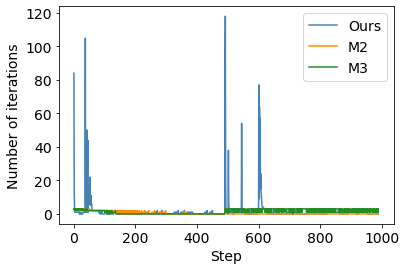

In [219]:
plt.plot(pk_results['nit'], label='Ours', color=pk_curve)
plt.plot(linear_results['nit'], label='M2', color=linear_curve)
plt.plot(bilinear_results['nit'], label='M3', color=bilinear_curve)
# plt.yscale('log', base=5)
plt.legend(fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Step', fontsize=14)
plt.ylabel('Number of iterations', fontsize=14)

plt.savefig(os.path.join(figures_path, 'kdv_'+forcing_type+'_momentum_iter.png'), dpi=200, bbox_inches='tight')
plt.savefig(os.path.join(figures_path, 'kdv_'+forcing_type+'_momentum_iter.pdf'), dpi=200, bbox_inches='tight')



In [170]:
# pk_kdv_opt_momentum_0 = dx * tf.reduce_sum(tf.square(pk_kdv_opt_momentum_soln_0), axis=-1)
# linear_kdv_opt_momentum_0 = dx * tf.reduce_sum(tf.square(linear_kdv_opt_momentum_soln_0), axis=-1)
# bilinear_kdv_opt_momentum_0 = dx * tf.reduce_sum(tf.square(bilinear_kdv_opt_momentum_soln_0), axis=-1)
pk_kdv_opt_momentum_5 = dx * tf.reduce_sum(tf.square(pk_kdv_opt_momentum_soln_5), axis=-1)
linear_kdv_opt_momentum_5 = dx * tf.reduce_sum(tf.square(linear_kdv_opt_momentum_soln_5), axis=-1)
bilinear_kdv_opt_momentum_5 = dx * tf.reduce_sum(tf.square(bilinear_kdv_opt_momentum_soln_5), axis=-1)

Text(0, 0.5, 'Momentum')

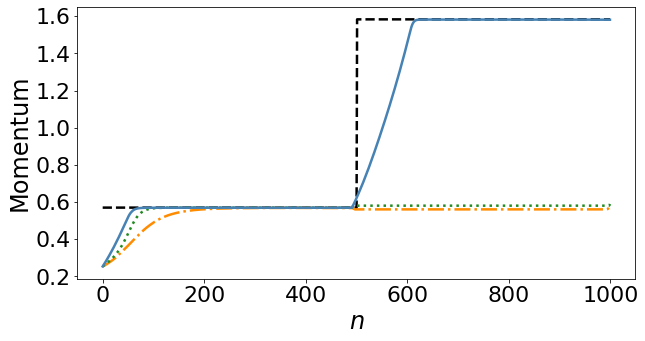

In [171]:
plt.figure(figsize=(10, 5))
plt.plot(momentum_ref, label="Reference", linestyle="--", color=ref_color, linewidth=linewidth)

# plt.plot(
#     linear_kdv_opt_momentum_0,
#     label=r"$M2(\lambda = 0)$",
#     color=linear_no_penalty_color,
#     linestyle=linear_linestyle,
#     linewidth=linewidth,
# )
# plt.plot(
#     bilinear_kdv_opt_momentum_0,
#     label=r"$M3(\lambda = 0)$",
#     color=bilinear_no_penalty_color,
#     linestyle=bilinear_linestyle,
#     linewidth=linewidth,
# )
# plt.plot(
#     pk_kdv_opt_momentum_0,
#     label=r"$Ours(\lambda = 0)$",
#     color=pk_no_penalty_color, 
#     linestyle=pk_linestyle, 
#     linewidth=linewidth
# )

plt.plot(
    linear_kdv_opt_momentum_5,
    label=r"$M2(\lambda = 0.005)$",
    color=linear_curve,
    linestyle=linear_linestyle,
    linewidth=linewidth,
)
plt.plot(
    bilinear_kdv_opt_momentum_5,
    label=r"$M3(\lambda = 0.005)$",
    color=bilinear_curve,
    linestyle=bilinear_linestyle,
    linewidth=linewidth,
)
plt.plot(
    pk_kdv_opt_momentum_5,
    label=r"$Ours(\lambda = 0.005)$",
    color=pk_curve, 
    linestyle=pk_linestyle, 
    linewidth=linewidth
)


plt.xticks(fontsize=ticks_font)
plt.yticks(fontsize=ticks_font)
plt.xlabel(r"$n$", fontsize=label_font)
plt.ylabel("Momentum", fontsize=label_font)
# plt.legend(fontsize=legend_font, loc=(1.05, 0.001))


# plt.savefig(os.path.join(figures_path, 'kdv_'+forcing_type+'_momentum_tracking.png'), dpi=200, bbox_inches='tight')
# plt.savefig(os.path.join(figures_path, 'kdv_'+forcing_type+'_momentum_tracking.pdf'), dpi=200, bbox_inches='tight')


In [172]:
# np.save(os.path.join(data_path,'pk_momentum_sin_lambda_5.npy'), pk_kdv_opt_momentum_5)